In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, Reshape, UpSampling2D, MaxPool2D, Dense, Flatten
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(session)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

In [4]:
batch_size = 500
latent_dim = 10
dropout_rate = 0.3
start_lr = 0.0001
num_classes = 10

In [5]:
from keras.layers import RepeatVector, Reshape, concatenate


def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1 * dim2
    units_repeat = RepeatVector(repeat_n)(units)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])

In [6]:
from keras.layers import Lambda


input_cvae_encoder = Input(shape=(28, 28, 1))
input_cvae_encoder_lbl = Input(shape=(num_classes,), dtype='float32')

with tf.variable_scope("cvae_encoder"):
    x = Conv2D(32, kernel_size=(5, 5))(input_cvae_encoder)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)
    x = add_units_to_conv2d(x, input_cvae_encoder_lbl)

    x = Conv2D(16, kernel_size=(5, 5))(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)

    begin_of_dense = Flatten()(x)
    x = Dense(latent_dim * 40)(begin_of_dense)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(latent_dim * 20)(begin_of_dense)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
cvae_encoder = Model([input_cvae_encoder, input_cvae_encoder_lbl], l, name="Encoder")
cvae_encoder_mean = Model([input_cvae_encoder, input_cvae_encoder_lbl], z_mean, name="ZMeaner")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
input_cvae_decoder = Input(shape=(latent_dim,))
input_cvae_decoder_lbl = Input(shape=(num_classes,), dtype='float32')

with tf.variable_scope("cvae_decoder"):
    x = Dense(49)(input_cvae_decoder)
    x = Reshape(target_shape=(7, 7, 1))(x)

    x = Conv2D(16, kernel_size=(7, 7), padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)
    x = add_units_to_conv2d(x, input_cvae_decoder_lbl)    

    x = Conv2D(32, kernel_size=(5, 5), padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = LeakyReLU()(x)    
    x = Dropout(dropout_rate)(x)
    decoded = Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')(x)

cvae_decoder = Model([input_cvae_decoder, input_cvae_decoder_lbl], decoded, name='Decoder')

In [8]:
from keras.objectives import binary_crossentropy


def cvae_loss(x, decoded):
    x = K.reshape(x, shape=(batch_size, 28 * 28))
    decoded = K.reshape(decoded, shape=(batch_size, 28 * 28))
    xent_loss = 28 * 28 * binary_crossentropy(x, decoded)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (xent_loss + kl_loss) / 2 / 28 / 28

In [9]:
from keras.optimizers import Adam


cvae_model = Model(inputs=[input_cvae_encoder, input_cvae_encoder_lbl, input_cvae_decoder_lbl],
                   outputs=cvae_decoder([cvae_encoder([input_cvae_encoder, input_cvae_encoder_lbl]), input_cvae_decoder_lbl]),
                   name="ConvCVAE")
cvae_model.compile(loss=cvae_loss, optimizer=Adam(start_lr))
cvae_model.summary()

Model: "ConvCVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 10)           73068       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10)           0                                     

In [10]:
session.run(tf.global_variables_initializer())

In [11]:
digit_size = 28
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

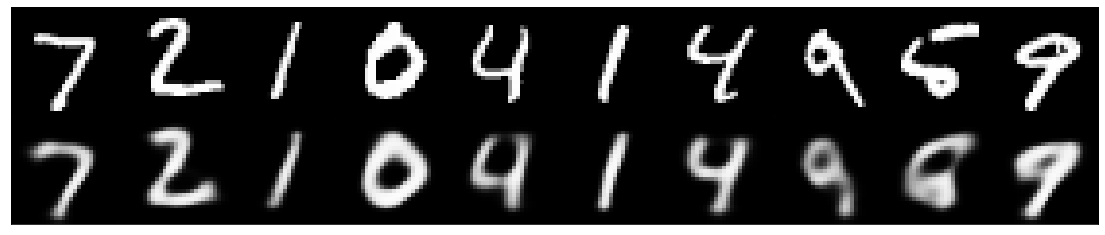

Epoch 102/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0825 - val_loss: 0.0745
Epoch 103/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0825 - val_loss: 0.0746
Epoch 104/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0825 - val_loss: 0.0746
Epoch 105/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0824 - val_loss: 0.0744
Epoch 106/200
60000/60000 [==============================] - 10s 161us/step - loss: 0.0824 - val_loss: 0.0745
Epoch 107/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0824 - val_loss: 0.0744
Epoch 108/200
60000/60000 [==============================] - 10s 161us/step - loss: 0.0823 - val_loss: 0.0744
Epoch 109/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0823 - val_loss: 0.0743
Epoch 110/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0823 - val_loss: 0.0742
Epoch 111/

60000/60000 [==============================] - 10s 160us/step - loss: 0.0811 - val_loss: 0.0731
Epoch 177/200
60000/60000 [==============================] - 10s 159us/step - loss: 0.0811 - val_loss: 0.0731
Epoch 178/200
60000/60000 [==============================] - 10s 159us/step - loss: 0.0810 - val_loss: 0.0731
Epoch 179/200
60000/60000 [==============================] - 10s 159us/step - loss: 0.0810 - val_loss: 0.0731
Epoch 180/200
60000/60000 [==============================] - 10s 159us/step - loss: 0.0810 - val_loss: 0.0730
Epoch 181/200
60000/60000 [==============================] - 10s 159us/step - loss: 0.0810 - val_loss: 0.0731
Epoch 182/200
60000/60000 [==============================] - 10s 159us/step - loss: 0.0810 - val_loss: 0.0731
Epoch 183/200
60000/60000 [==============================] - 10s 160us/step - loss: 0.0810 - val_loss: 0.0731
Epoch 184/200
60000/60000 [==============================] - 10s 159us/step - loss: 0.0810 - val_loss: 0.0730
Epoch 185/200
60000/6000

In [12]:
import time

from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard


latent_distrs = [[] for x in range(num_classes)]
epochs = []
# epochs_to_check = np.linspace(1, 101, num=20).astype('int')
epochs_to_check = [i for i in range(101)]

imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10


def on_epoch_end(epoch, logs):
    if epoch in epochs_to_check:
        clear_output()
        
        decoded = cvae_model.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])
        
        for lbl in range(num_classes):
            idxs = y_test == lbl
            z_predicted = cvae_encoder_mean.predict([x_test[idxs], y_test_cat[idxs]], batch_size=batch_size)
            latent_distrs[lbl].append(z_predicted)
        epochs.append(epoch)


pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
tb     = TensorBoard(log_dir='./logs')


start_time = time.time()
cvae_model.fit([x_train, y_train_cat, y_train_cat], x_train,
               shuffle=True,
               epochs=200,
               batch_size=batch_size,
               validation_data=([x_test, y_test_cat, y_test_cat], x_test),
               callbacks=[pltfig, tb],
               verbose=1)
print(f"ALL TRAINING TIME: %s" % (time.time() - start_time))

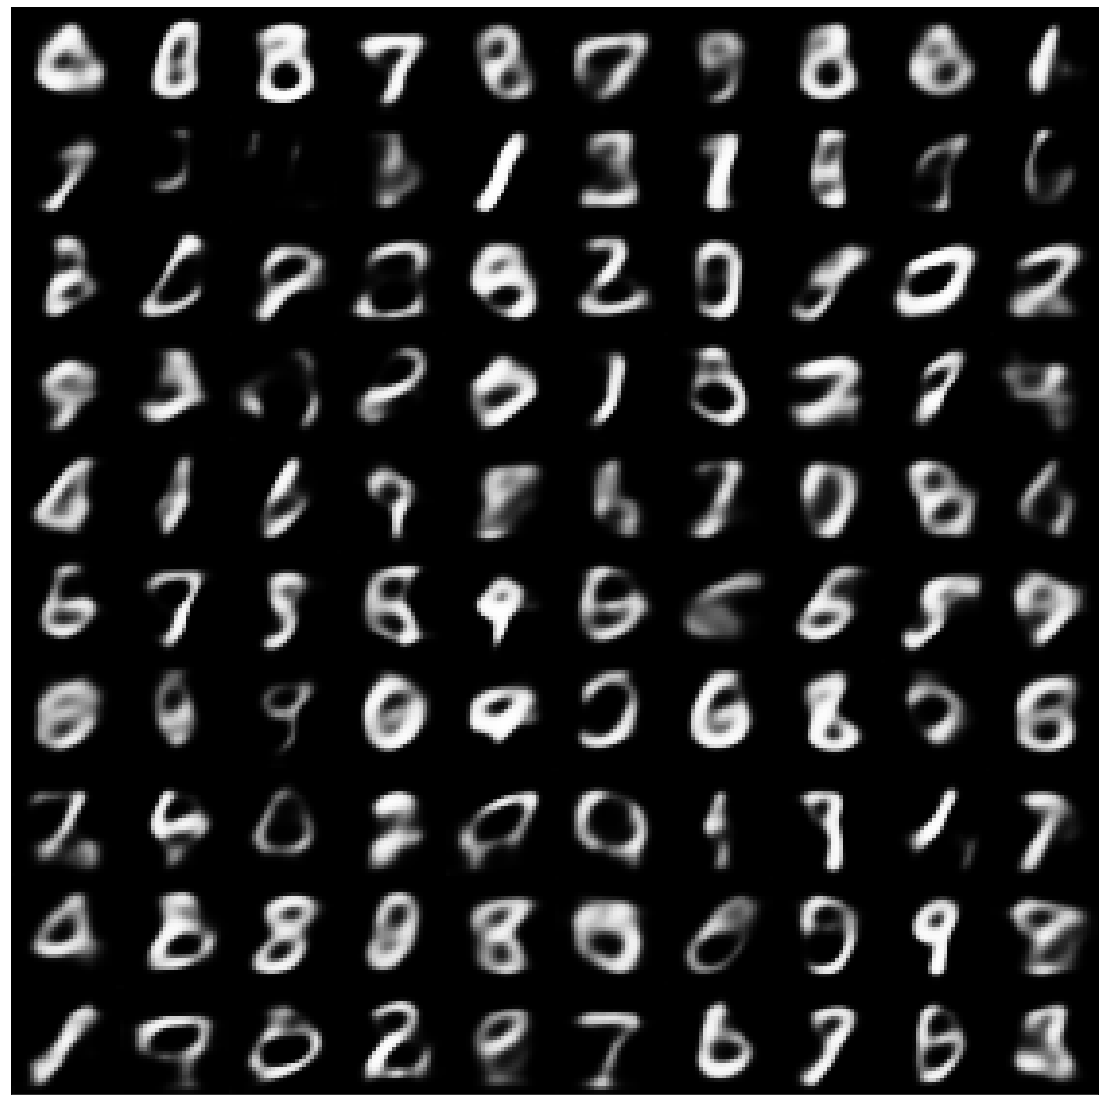

In [13]:
to_compare = []
for lbl in range(num_classes):
    codes = np.random.normal(size=(batch_size, latent_dim))
    lbls = np.zeros(shape=(batch_size, num_classes))
    lbls[:, lbl] = 1

    predicted = cvae_decoder.predict([codes, lbls], batch_size=batch_size)
    to_compare.append(predicted[:n_compare])
plot_digits(*to_compare)

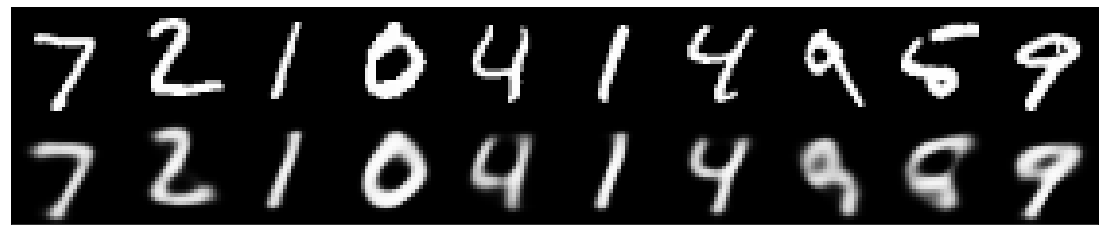

In [14]:
decoded = cvae_model.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
plot_digits(imgs[:n_compare], decoded[:n_compare])

In [15]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_cvae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "cvae_10dim.json"), "w") as f:
    json.dump(cvae_model.to_json(), f, indent=4)
cvae_model.save_weights(os.path.join(save_path, "cvae_10dim.h5"))

with open(os.path.join(save_path, "cvae_encoder_10dim.json"), "w") as f:
    json.dump(cvae_encoder.to_json(), f, indent=4)
cvae_encoder.save_weights(os.path.join(save_path, "cvae_encoder_10dim.h5"))

with open(os.path.join(save_path, "cvae_decoder_10dim.json"), "w") as f:
    json.dump(cvae_decoder.to_json(), f, indent=4)
cvae_decoder.save_weights(os.path.join(save_path, "cvae_decoder_10dim.h5"))

# Draw the manifold

In [16]:
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import cm


def make_2d_scatter_gif(fname, fig):
    plt.title("MANIFOLD\nEpoch: {}".format(epochs[0]))
    for lbl in range(num_classes):
        im = plt.scatter(latent_distrs[lbl][0][:, 0], latent_distrs[lbl][0][:, 1], label=str(lbl))
    plt.legend(loc='upper right')

    def update(i):
        fig.clear()
        for lbl in range(num_classes):
            im = plt.scatter(latent_distrs[lbl][i][:, 0], latent_distrs[lbl][i][:, 1], label=str(lbl))
        im.axes.set_title("MANIFOLD\nEpoch: {}".format(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        plt.legend(loc='upper right')

        return im
    
    min_len = min([len(latent_distrs[lbl]) for lbl in range(num_classes)])
    writer = matplotlib.animation.HTMLWriter()
    anim = FuncAnimation(fig, update, frames=range(min_len), interval=100)
    anim.save(fname, dpi=80, writer="imagemagick")

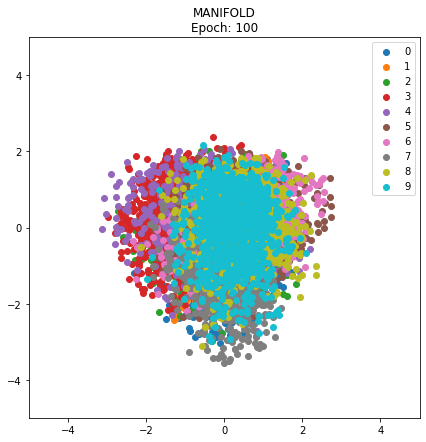

In [17]:
import os


gif_file_path = "./figs4/z_distr_conv_cvae_10dim.gif"
if not os.path.exists(os.path.dirname(gif_file_path)):
    os.mkdir(os.path.dirname(gif_file_path))
    
make_2d_scatter_gif(gif_file_path, plt.figure(figsize=(7,7)))

# BUILDING GAN

In [18]:
batch_size = 64

def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while (True):
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]
        for i in range(n_batches):
            yield x[batch_size * i:batch_size * (i + 1)], y[batch_size * i:batch_size * (i + 1)]

train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it = gen_batch(x_test, y_test_cat)

In [19]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='image')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z = Input(tensor=z_)

In [20]:
with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = add_units_to_conv2d(x, lbl)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)

    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], d, name="Discriminator")

In [21]:
generated_z = cvae_decoder([z, lbl])
discr_img = discrim([img, lbl])
discr_gen_z = discrim([generated_z, lbl])

gan_model = Model([z, lbl], discr_gen_z, name="GAN")
gan = gan_model([z, lbl])

In [22]:
log_dis_img = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5 * (log_dis_gen_z + log_dis_img)

In [23]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.0001)

generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'cvae_decoder')
discrim_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discrim')

step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
session.run(tf.global_variables_initializer())

In [25]:
# After tf.global_variables_initializer() the decoder_model is null
# We need to load weights from file
cvae_decoder.load_weights(os.path.join(save_path, "cvae_decoder_10dim.h5"))

In [26]:
def step(image, label, zp):
    l_dis, _ = session.run([L_dis, step_gen], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

def step_d(image, label, zp):
    l_dis, _ = session.run([L_dis, step_dis], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

In [27]:
import numpy


periods_to_check = np.arange(0., 4000.0, 50.0).astype('int')


def on_n_period():
    to_compare = []
    for lbl in range(num_classes):
        codes = np.random.normal(size=(batch_size, latent_dim))
        lbls = np.zeros(shape=(batch_size, num_classes))
        lbls[:, lbl] = 1

        predicted = cvae_decoder.predict([codes, lbls], batch_size=batch_size)
        to_compare.append(predicted[:n_compare])
    plot_digits(*to_compare)

.l_d: 0.6979830265045166
Period: 0


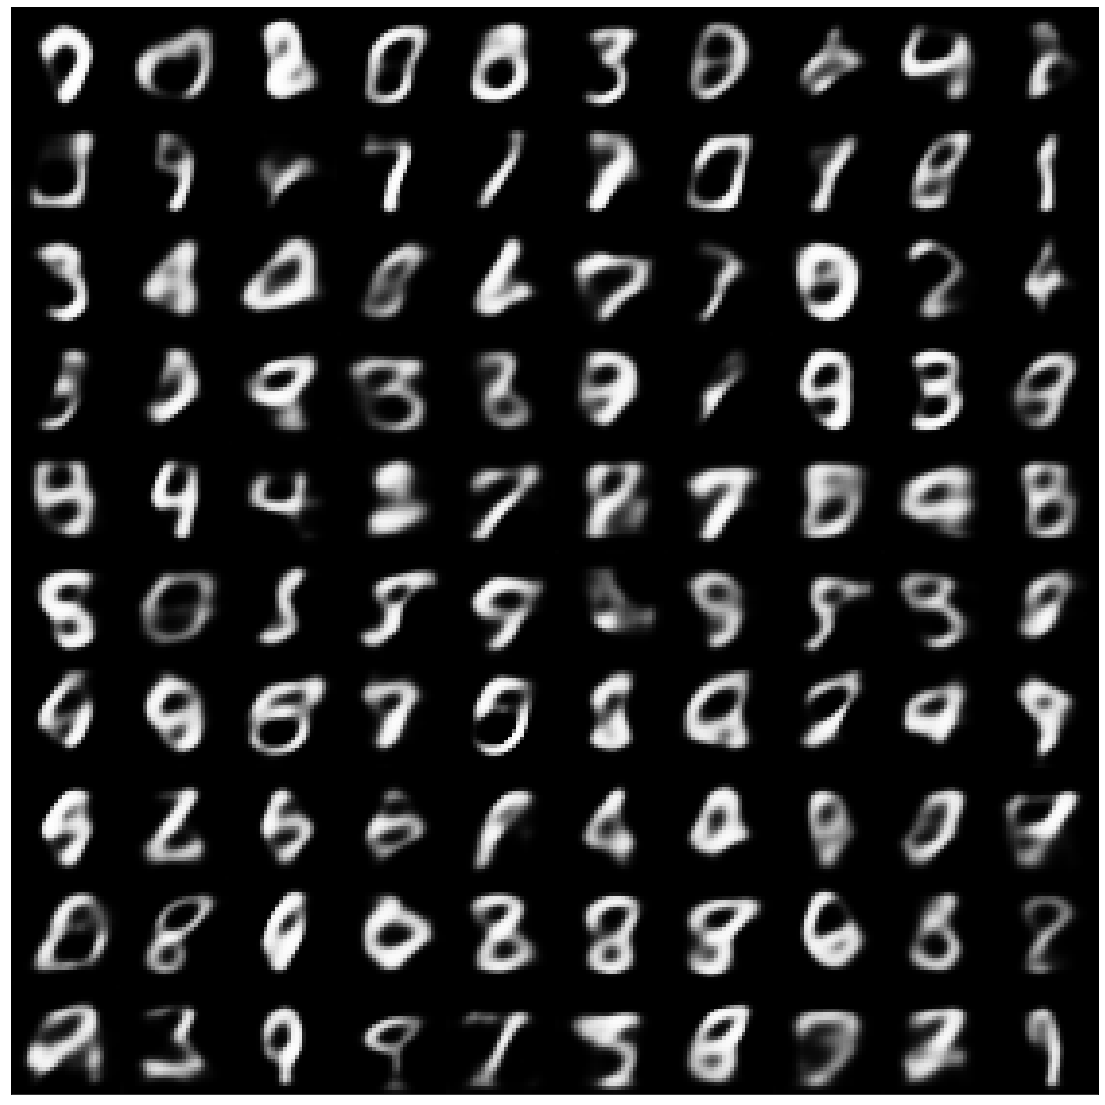

.l_d: 0.6963613033294678
.l_d: 0.6988149285316467
.l_d: 0.6939057111740112
.l_d: 0.691500186920166
.l_d: 0.6980108022689819
.l_d: 0.7035970687866211
.l_d: 0.6956894993782043
.l_d: 0.7029149532318115
.l_d: 0.6893715262413025
.l_d: 0.7023301124572754
.l_d: 0.6940303444862366
.l_d: 0.6904089450836182
.l_d: 0.693129301071167
.l_d: 0.6959154605865479
.l_d: 0.7032297849655151
.l_d: 0.6940070390701294
.l_d: 0.6930209398269653
.l_d: 0.6940590143203735
.l_d: 0.6940891146659851
.l_d: 0.6962341666221619
.l_d: 0.6974538564682007
.l_d: 0.6926846504211426
.l_d: 0.7053832411766052
.l_d: 0.6973099708557129
.l_d: 0.6955541968345642
.l_d: 0.6902118921279907
.l_d: 0.6934913396835327
.l_d: 0.6918573379516602
.l_d: 0.6864795684814453
.l_d: 0.6951598525047302
.l_d: 0.6967412829399109
.l_d: 0.6912384629249573
.l_d: 0.7021637558937073
.l_d: 0.688560962677002
.l_d: 0.7001274824142456
.l_d: 0.6881870031356812
.l_d: 0.6991305351257324
.l_d: 0.6974489688873291
.l_d: 0.6986652612686157
.l_d: 0.6918990015983582
.l_

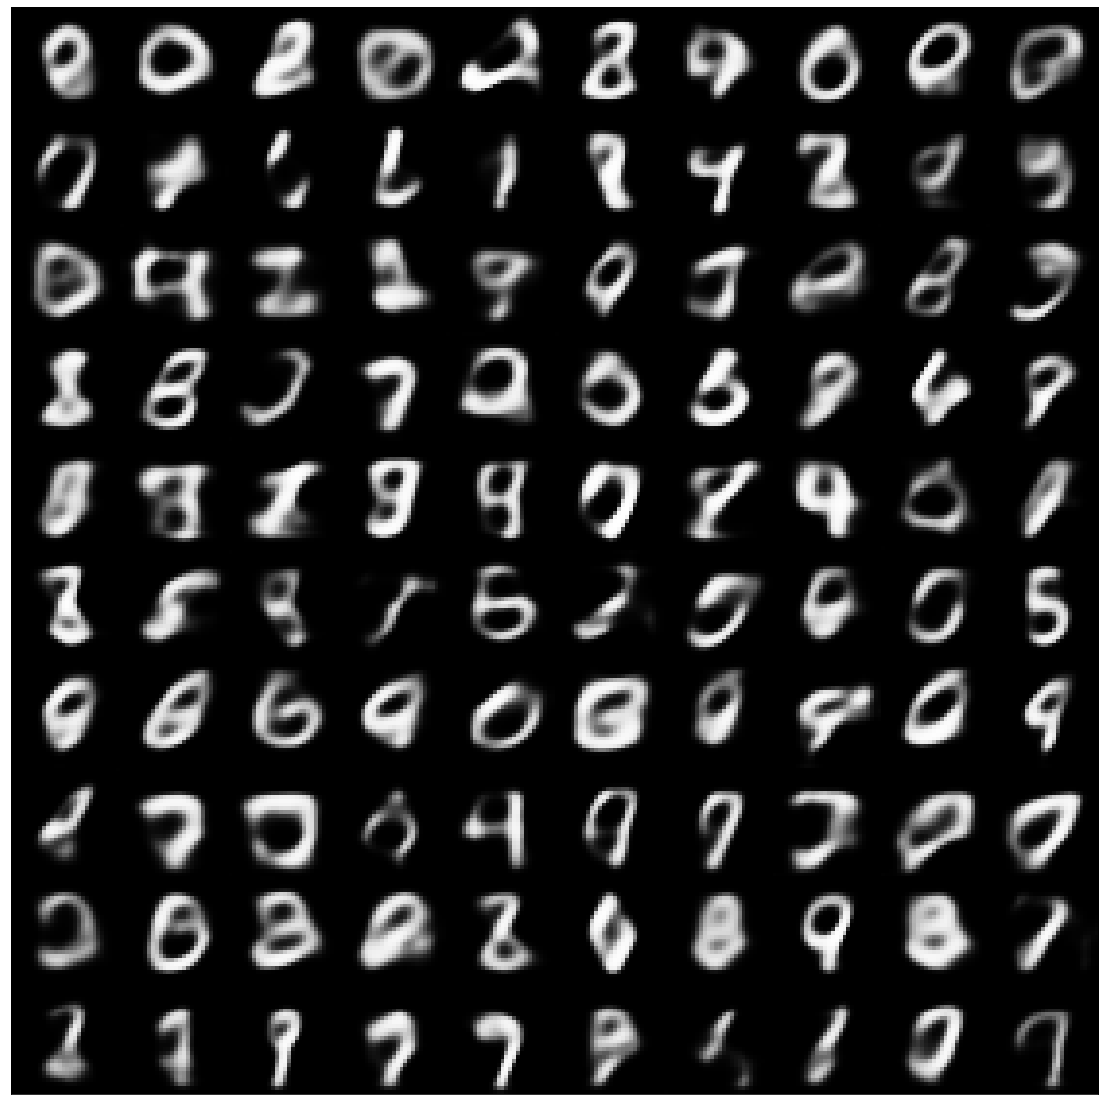

.l_d: 0.6908338069915771
.l_d: 0.6953648924827576
.l_d: 0.6938729286193848
.l_d: 0.6879044771194458
.l_d: 0.6962422132492065
.l_d: 0.6999361515045166
.l_d: 0.6940319538116455
.l_d: 0.6969901323318481
.l_d: 0.6942346096038818
.l_d: 0.6906070709228516
.l_d: 0.7017258405685425
.l_d: 0.6840957403182983
.l_d: 0.6848659515380859
.l_d: 0.688654899597168
.l_d: 0.6982240676879883
.l_d: 0.691308319568634
.l_d: 0.6971166133880615
.l_d: 0.6906881928443909
.l_d: 0.6949795484542847
.l_d: 0.693509578704834
.l_d: 0.6936872601509094
.l_d: 0.6817900538444519
.l_d: 0.6902244091033936
.l_d: 0.6907845139503479
.l_d: 0.6908438205718994
.l_d: 0.6910339593887329
.l_d: 0.6890237331390381
.l_d: 0.6897495985031128
.l_d: 0.6924692392349243
.l_d: 0.6908097267150879
.l_d: 0.6875431537628174
.l_d: 0.6904146671295166
.l_d: 0.6907387971878052
.l_d: 0.683472752571106
.l_d: 0.6851730942726135
.l_d: 0.6926240921020508
.l_d: 0.686549186706543
.l_d: 0.6931647062301636
.l_d: 0.6864670515060425
.l_d: 0.6870149374008179
.l_d:

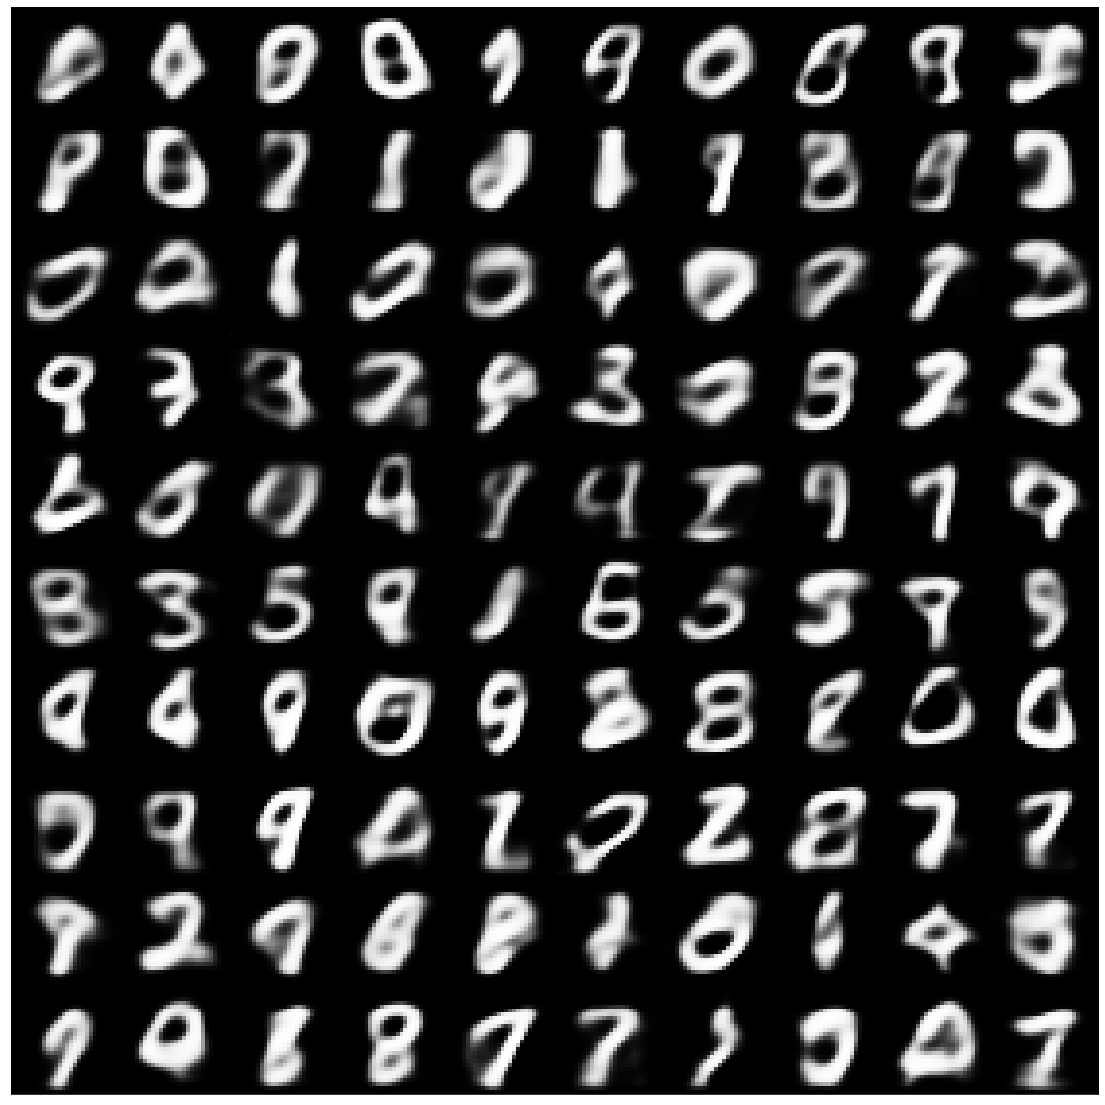

.l_d: 0.6886756420135498
.l_d: 0.6809747219085693
.l_d: 0.687885582447052
.l_d: 0.6835916638374329
.l_d: 0.6839134097099304
.l_d: 0.6805554032325745
.l_d: 0.6876579523086548
.l_d: 0.6811401844024658
.l_d: 0.6796925067901611
.l_d: 0.6802678108215332
.l_d: 0.6773602366447449
.l_d: 0.6705880165100098
.l_d: 0.6796633005142212
.l_d: 0.680389404296875
.l_d: 0.6824891567230225
.l_d: 0.6839603185653687
.l_d: 0.6817532181739807
.l_d: 0.6765485405921936
.l_d: 0.6770455241203308
.l_d: 0.6868022680282593
.l_d: 0.6820073127746582
.l_d: 0.677889347076416
.l_d: 0.6724939346313477
.l_d: 0.6741703748703003
.l_d: 0.6771577596664429
.l_d: 0.6672519445419312
.l_d: 0.6786491870880127
.l_d: 0.668571412563324
.l_d: 0.6755166053771973
.l_d: 0.6747144460678101
.l_d: 0.6782812476158142
.l_d: 0.6652612686157227
.l_d: 0.6842142939567566
.l_d: 0.6724392771720886
.l_d: 0.6701767444610596
.l_d: 0.6716071963310242
.l_d: 0.6710152626037598
.l_d: 0.6658430099487305
.l_d: 0.665711522102356
.l_d: 0.6723660230636597
.l_d:

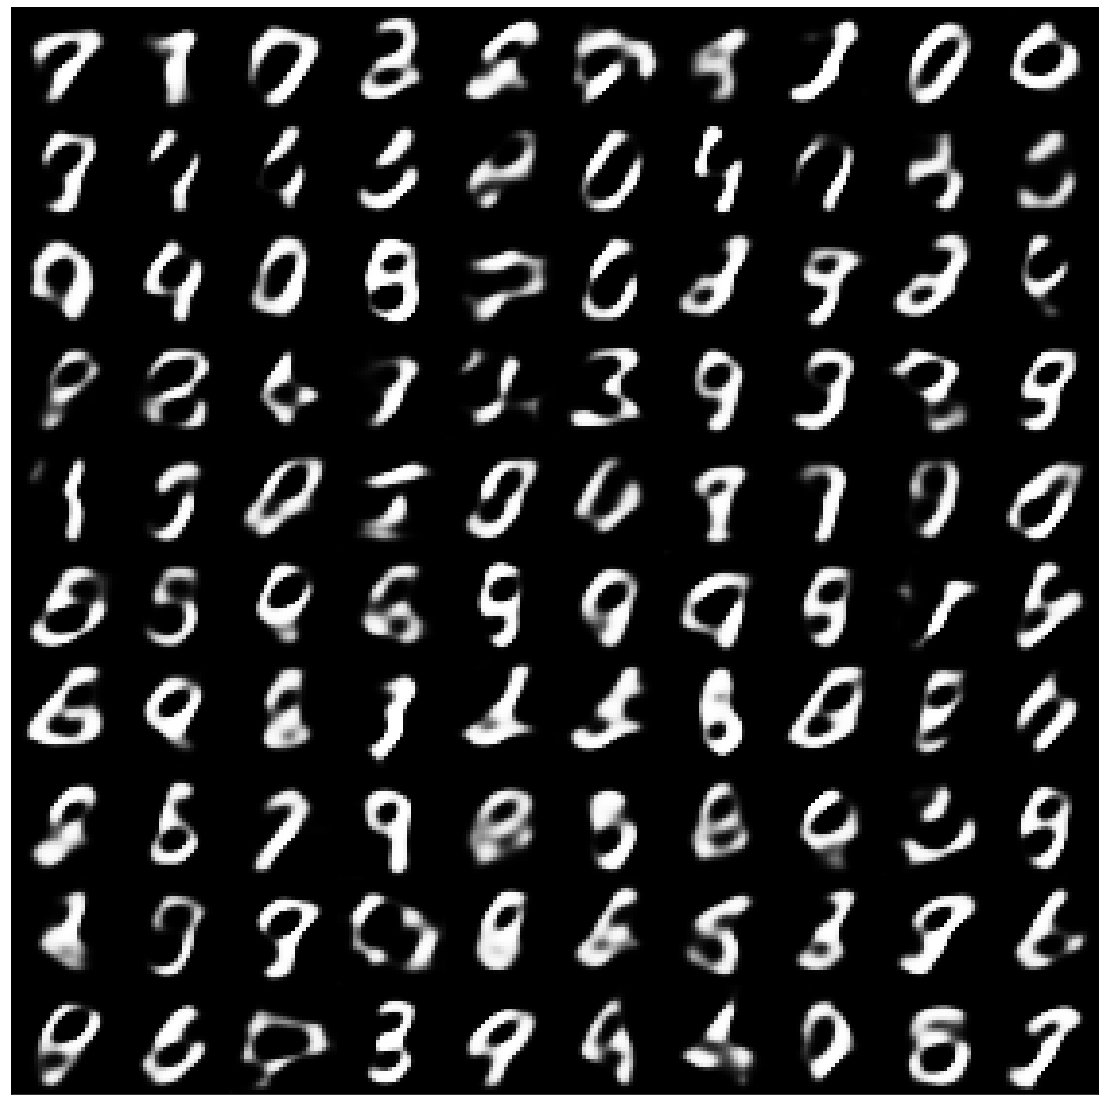

.l_d: 0.6623539924621582
.l_d: 0.6699462532997131
.l_d: 0.673031747341156
.l_d: 0.661256730556488
.l_d: 0.6679195165634155
.l_d: 0.6681250929832458
.l_d: 0.663009762763977
.l_d: 0.6659074425697327
.l_d: 0.663776695728302
.l_d: 0.6663715839385986
.l_d: 0.6735286712646484
.l_d: 0.6753601431846619
.l_d: 0.6756861805915833
.l_d: 0.6620002388954163
.l_d: 0.6591026186943054
.l_d: 0.6670629382133484
.l_d: 0.6657438278198242
.l_d: 0.6654418706893921
.l_d: 0.661380410194397
.l_d: 0.6706321239471436
.l_d: 0.6624622344970703
.l_d: 0.6669676303863525
.l_d: 0.6721028089523315
.l_d: 0.6699682474136353
.l_d: 0.6613157987594604
.l_d: 0.6703811883926392
.l_d: 0.6573556065559387
.l_d: 0.6622987389564514
.l_d: 0.6630369424819946
.l_d: 0.669258713722229
.l_d: 0.6548879146575928
.l_d: 0.6673237681388855
.l_d: 0.6544604897499084
.l_d: 0.6586987376213074
.l_d: 0.6709669828414917
.l_d: 0.651029109954834
.l_d: 0.6648164391517639
.l_d: 0.6574376225471497
.l_d: 0.663151741027832
.l_d: 0.6665259003639221
.l_d: 0.

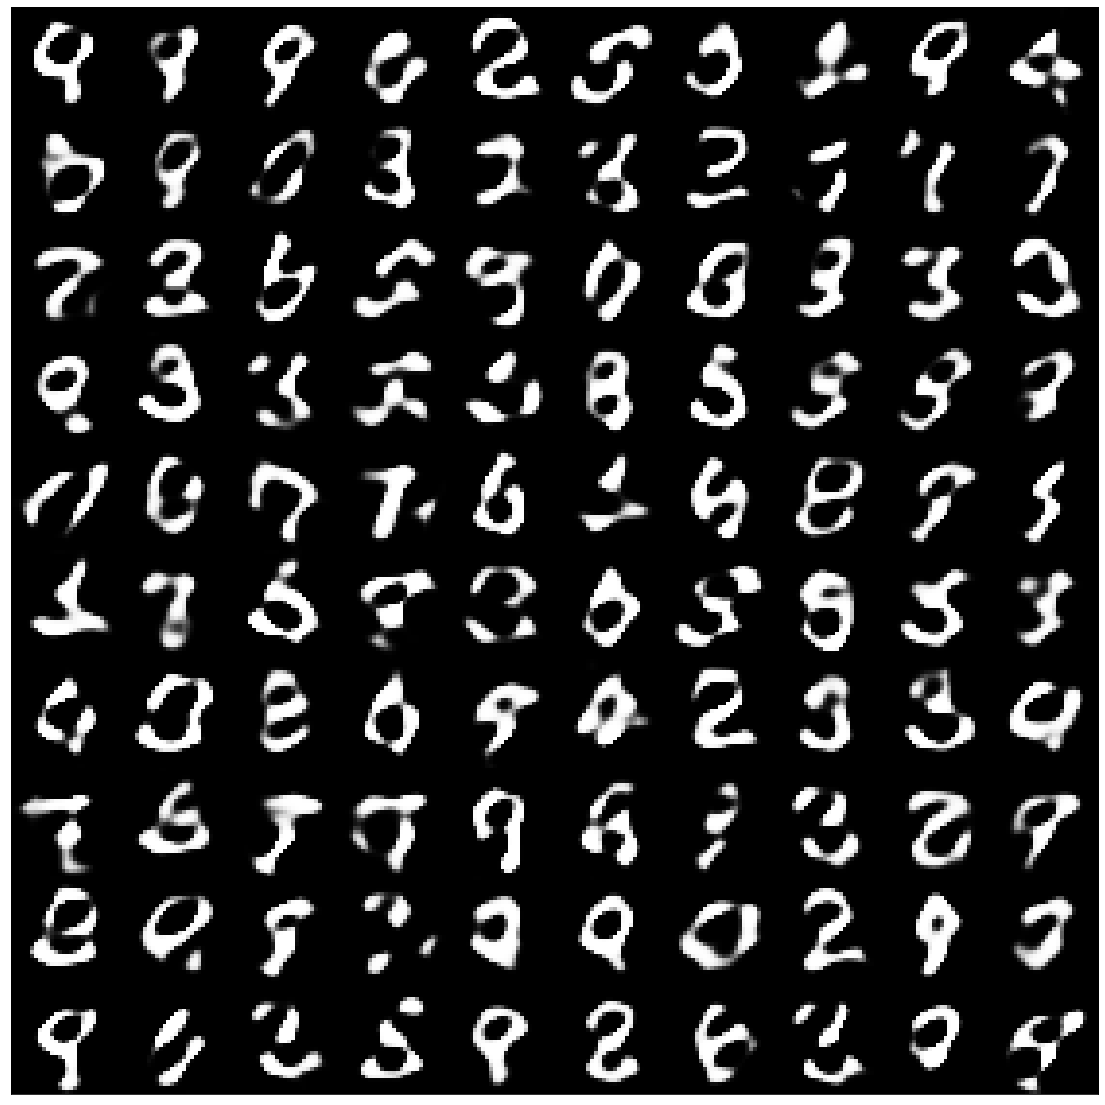

.l_d: 0.6595558524131775
.l_d: 0.671891987323761
.l_d: 0.6483938694000244
.l_d: 0.6570158004760742
.l_d: 0.664360523223877
.l_d: 0.6526209712028503
.l_d: 0.6612739562988281
.l_d: 0.6606632471084595
.l_d: 0.6626905202865601
.l_d: 0.6678236722946167
.l_d: 0.666526198387146
.l_d: 0.6559090614318848
.l_d: 0.6618779897689819
.l_d: 0.657916784286499
.l_d: 0.6590105891227722
.l_d: 0.6647806167602539
.l_d: 0.6659682393074036
.l_d: 0.6618365049362183
.l_d: 0.6578788757324219
.l_d: 0.6615541577339172
.l_d: 0.655918300151825
.l_d: 0.6596100926399231
.l_d: 0.6459745168685913
.l_d: 0.6539146900177002
.l_d: 0.6622964143753052
.l_d: 0.6550462245941162
.l_d: 0.6660667657852173
.l_d: 0.6481873393058777
.l_d: 0.6512404680252075
.l_d: 0.662460207939148
.l_d: 0.6615815162658691
.l_d: 0.6454801559448242
.l_d: 0.6563788652420044
.l_d: 0.6582959890365601
.l_d: 0.6430126428604126
.l_d: 0.6499285101890564
.l_d: 0.6585604548454285
.l_d: 0.6495763063430786
.l_d: 0.633756697177887
.l_d: 0.6537324786186218
.l_d: 0

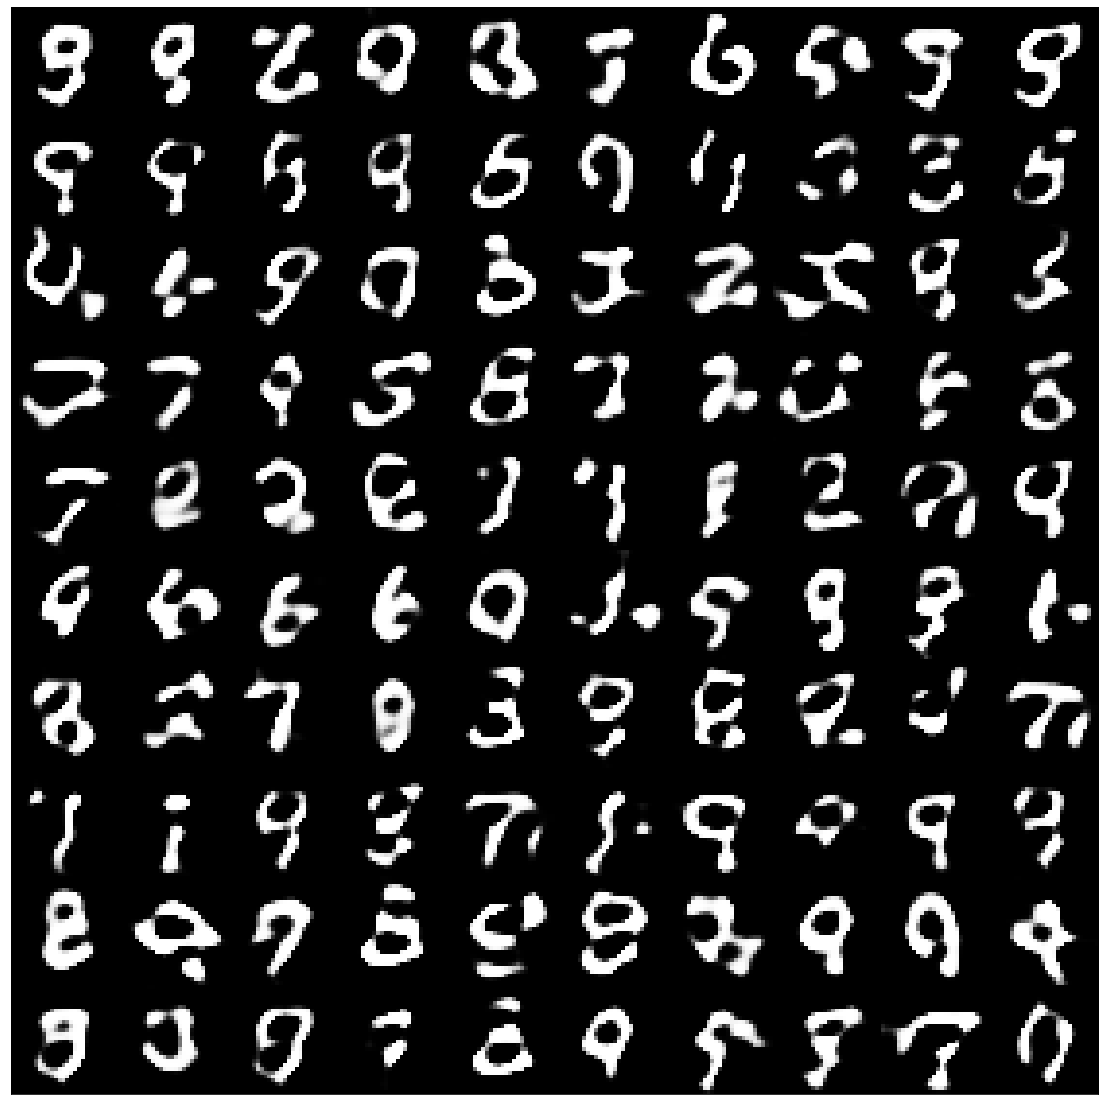

.l_d: 0.6496632099151611
.l_d: 0.6499278545379639
.l_d: 0.6436212658882141
.l_d: 0.652123749256134
.l_d: 0.6536672711372375
.l_d: 0.6428871154785156
.l_d: 0.6476200819015503
.l_d: 0.6408022046089172
.l_d: 0.6546909809112549
.l_d: 0.6434143781661987
.l_d: 0.64838707447052
.l_d: 0.6420179009437561
.l_d: 0.6569620370864868
.l_d: 0.6433513164520264
.l_d: 0.654110312461853
.l_d: 0.6368849873542786
.l_d: 0.6549736857414246
.l_d: 0.6537973880767822
.l_d: 0.6467885971069336
.l_d: 0.6428190469741821
.l_d: 0.6481345891952515
.l_d: 0.6434253454208374
.l_d: 0.6545556783676147
.l_d: 0.6452395915985107
.l_d: 0.6345447301864624
.l_d: 0.6435993909835815
.l_d: 0.6561170816421509
.l_d: 0.6554266214370728
.l_d: 0.641576886177063
.l_d: 0.6531845331192017
.l_d: 0.6341517567634583
.l_d: 0.6336243152618408
.l_d: 0.6348310708999634
.l_d: 0.6392070055007935
.l_d: 0.6362420320510864
.l_d: 0.6340062618255615
.l_d: 0.636467456817627
.l_d: 0.6486515998840332
.l_d: 0.6511533856391907
.l_d: 0.6366927623748779
.l_d: 

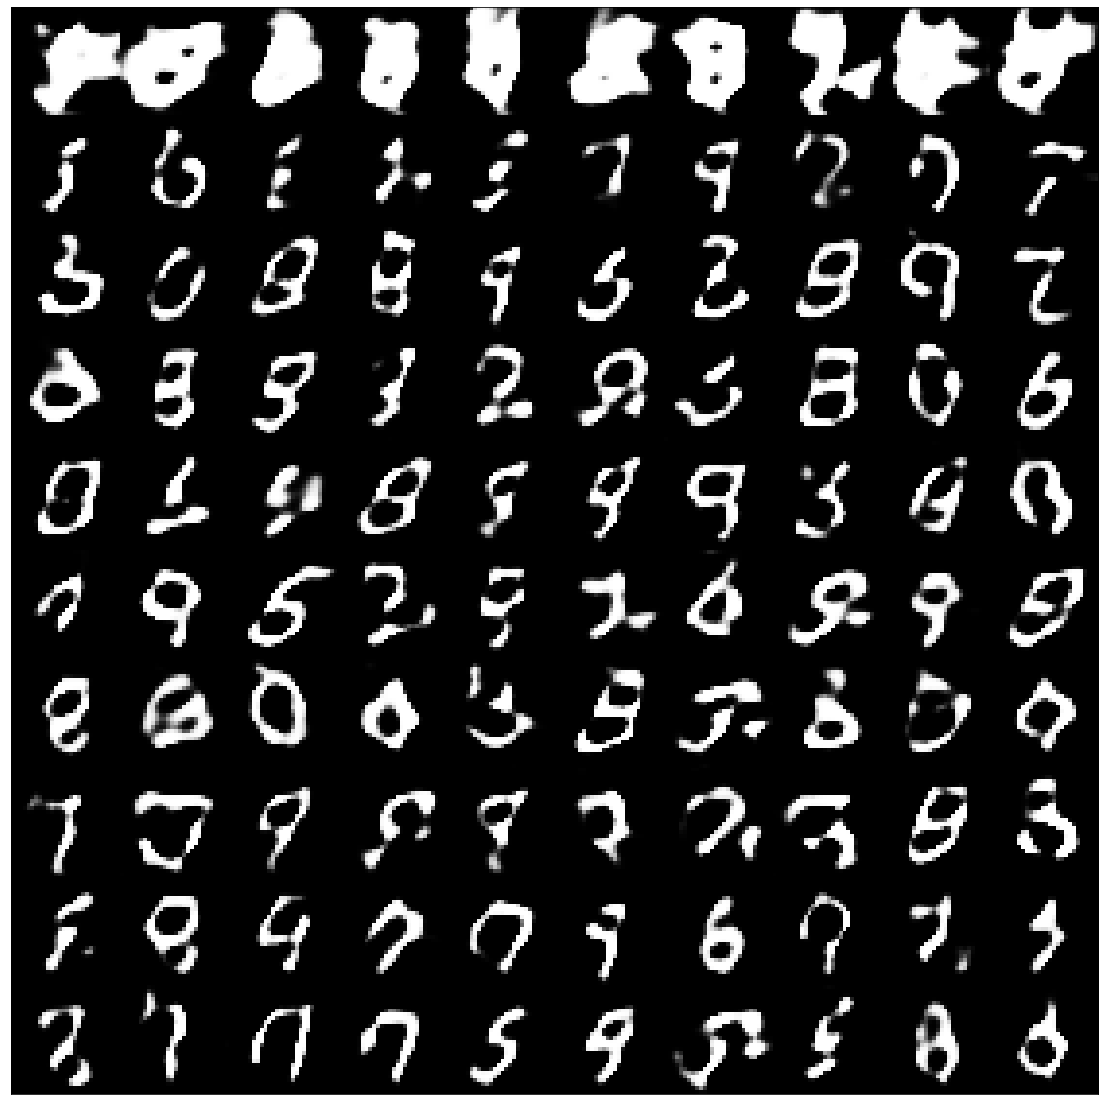

.l_d: 0.6636330485343933
.l_d: 0.6421425938606262
.l_d: 0.6435246467590332
.l_d: 0.6321091055870056
.l_d: 0.6478469371795654
.l_d: 0.6370998620986938
.l_d: 0.6436582207679749
.l_d: 0.6365175247192383
.l_d: 0.6388393640518188
.l_d: 0.6419684290885925
.l_d: 0.6503081321716309
.l_d: 0.6426485776901245
.l_d: 0.6350675225257874
.l_d: 0.6232932806015015
.l_d: 0.6405717134475708
.l_d: 0.6461272239685059
.l_d: 0.6235843300819397
.l_d: 0.6305751800537109
.l_d: 0.648248016834259
.l_d: 0.6453514099121094
.l_d: 0.6324955224990845
.l_d: 0.6381331086158752
.l_d: 0.631020724773407
.l_d: 0.6170680522918701
.l_d: 0.6212309002876282
.l_d: 0.634692370891571
.l_d: 0.6401363611221313
.l_d: 0.6435894966125488
.l_d: 0.6371274590492249
.l_d: 0.6322040557861328
.l_d: 0.634807288646698
.l_d: 0.6306027173995972
.l_d: 0.6460362076759338
.l_d: 0.6481670141220093
.l_d: 0.6402455568313599
.l_d: 0.6355563402175903
.l_d: 0.6246963739395142
.l_d: 0.6297575235366821
.l_d: 0.6449220776557922
.l_d: 0.6238903403282166
.l_d

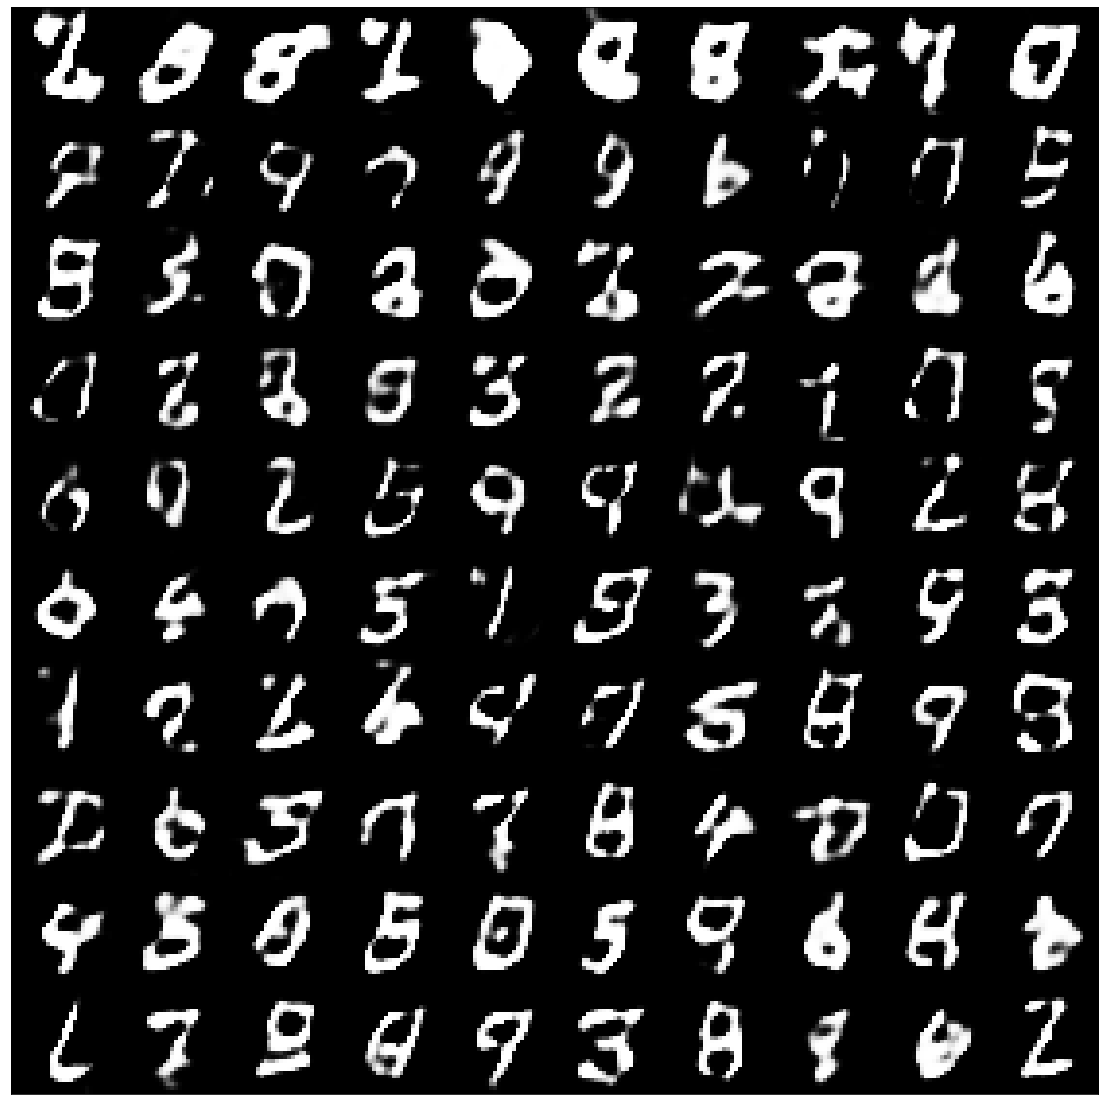

.l_d: 0.6114324927330017
.l_d: 0.6220029592514038
.l_d: 0.6250894665718079
.l_d: 0.6365633606910706
.l_d: 0.6467089653015137
.l_d: 0.6277042627334595
.l_d: 0.6211115121841431
.l_d: 0.6388618350028992
.l_d: 0.6199820041656494
.l_d: 0.6273468136787415
.l_d: 0.6167213320732117
.l_d: 0.6423640251159668
.l_d: 0.6459551453590393
.l_d: 0.6488082408905029
.l_d: 0.6476476192474365
.l_d: 0.6142443418502808
.l_d: 0.6351321935653687
.l_d: 0.6250744462013245
.l_d: 0.6094905138015747
.l_d: 0.6299670934677124
.l_d: 0.6233485341072083
.l_d: 0.6310558319091797
.l_d: 0.6370475888252258
.l_d: 0.6222900152206421
.l_d: 0.6448792219161987
.l_d: 0.6325125694274902
.l_d: 0.6524296402931213
.l_d: 0.6292752623558044
.l_d: 0.6258461475372314
.l_d: 0.6409100294113159
.l_d: 0.6332319378852844
.l_d: 0.6241957545280457
.l_d: 0.6227686405181885
.l_d: 0.6304349899291992
.l_d: 0.629240870475769
.l_d: 0.6167689561843872
.l_d: 0.6256148815155029
.l_d: 0.6120578050613403
.l_d: 0.6195049285888672
.l_d: 0.6188870668411255
.

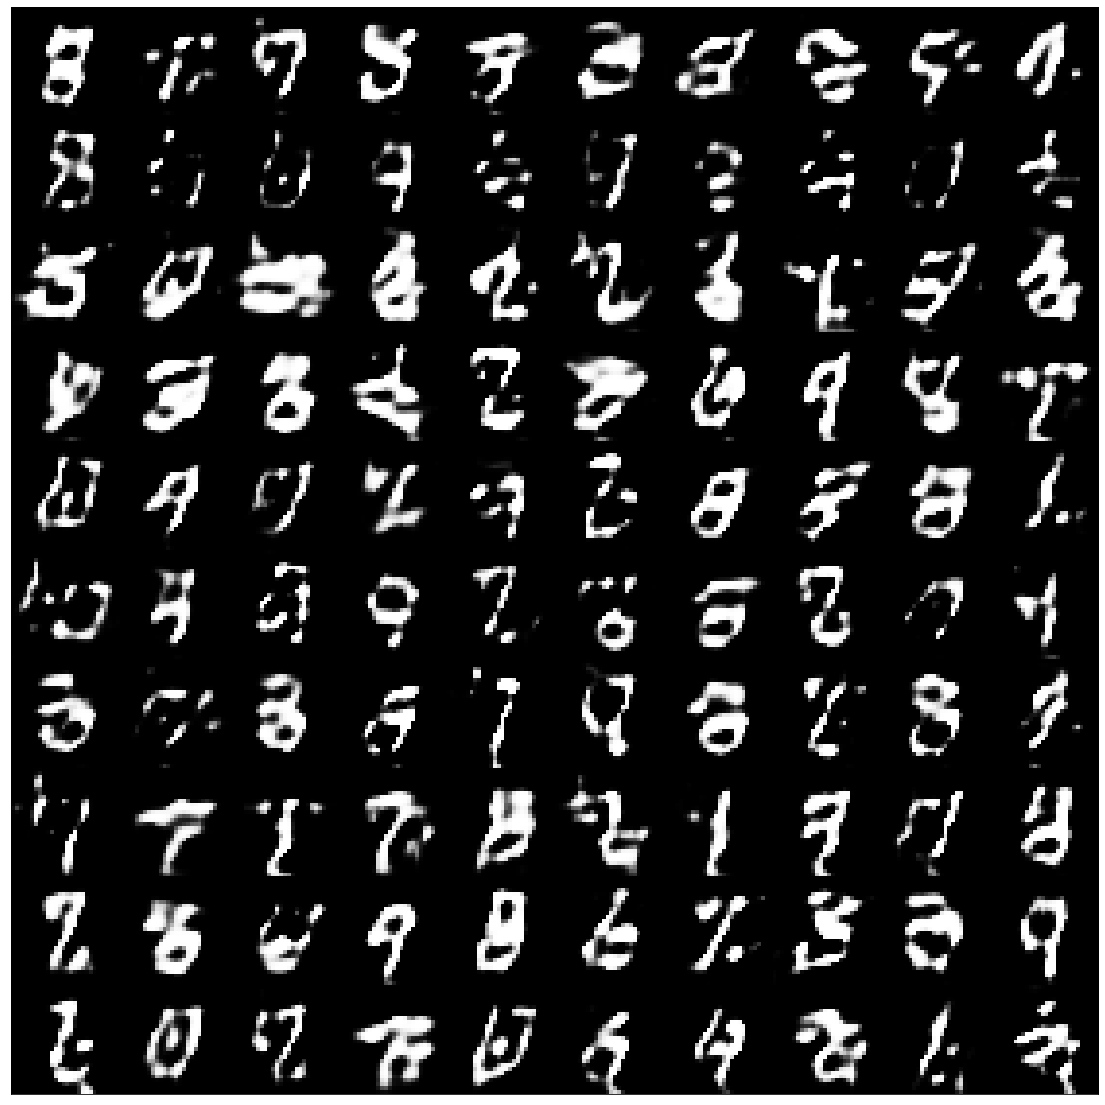

.l_d: 0.6360787153244019
.l_d: 0.6212992072105408
.l_d: 0.6216952204704285
.l_d: 0.6198314428329468
.l_d: 0.6392817497253418
.l_d: 0.6168832778930664
.l_d: 0.6109962463378906
.l_d: 0.6236587166786194
.l_d: 0.6262500286102295
.l_d: 0.630851686000824
.l_d: 0.6289165019989014
.l_d: 0.5975833535194397
.l_d: 0.6292530298233032
.l_d: 0.6192983388900757
.l_d: 0.6020714044570923
.l_d: 0.6229014992713928
.l_d: 0.6141461133956909
.l_d: 0.6121875047683716
.l_d: 0.606088399887085
.l_d: 0.6106640100479126
.l_d: 0.6172448992729187
.l_d: 0.613242506980896
.l_d: 0.6142188906669617
.l_d: 0.610481858253479
.l_d: 0.6134271621704102
.l_d: 0.5993291735649109
.l_d: 0.5950397849082947
.l_d: 0.6100552678108215
.l_d: 0.6192790269851685
.l_d: 0.5985108613967896
.l_d: 0.6123706102371216
.l_d: 0.6143529415130615
.l_d: 0.6032446622848511
.l_d: 0.6077444553375244
.l_d: 0.5916016101837158
.l_d: 0.6075867414474487
.l_d: 0.6129690408706665
.l_d: 0.6104798913002014
.l_d: 0.6104986667633057
.l_d: 0.614223062992096
.l_d:

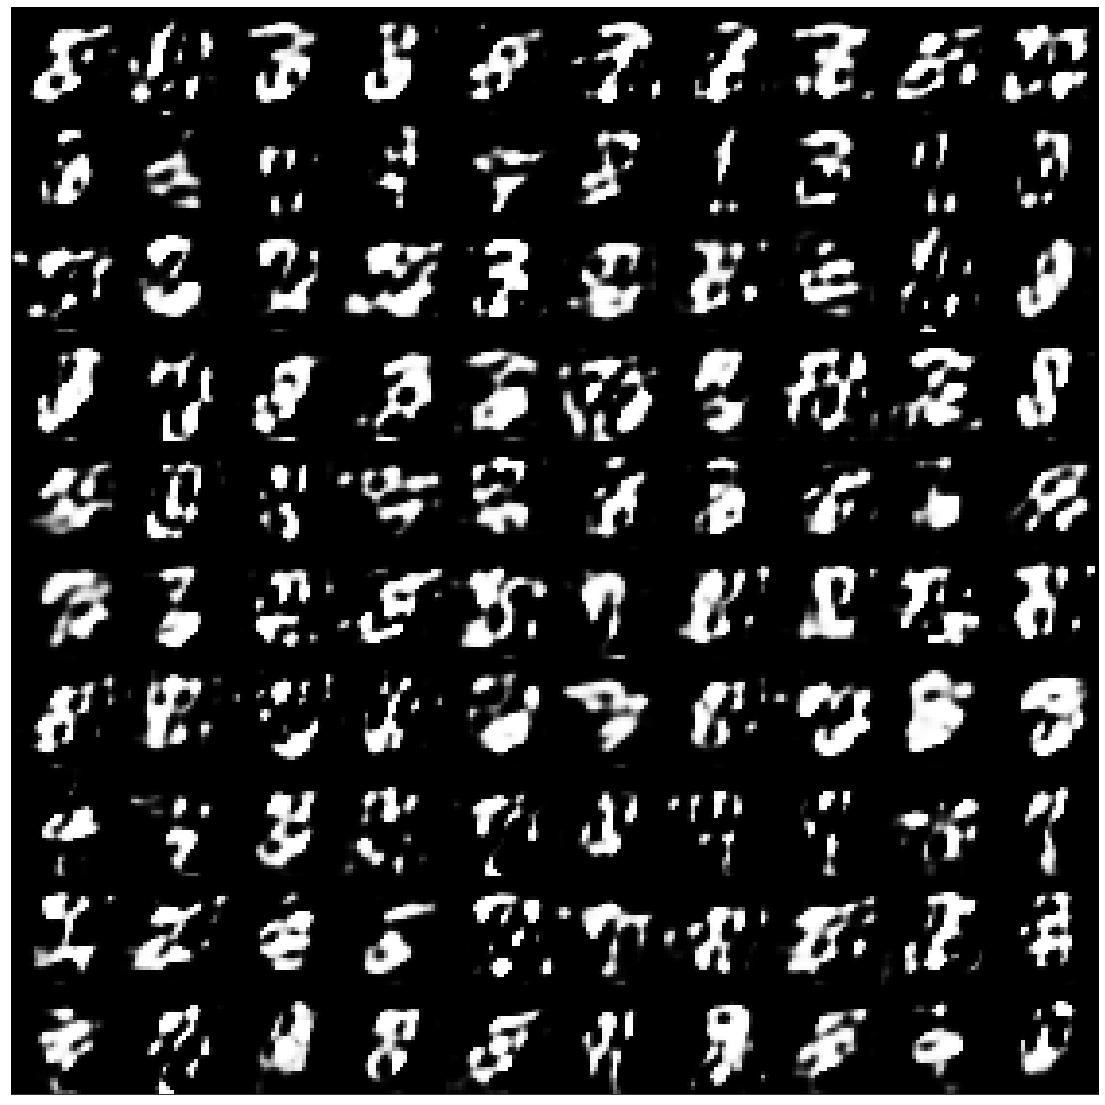

.l_d: 0.6101748943328857
.l_d: 0.5957364439964294
.l_d: 0.624320387840271
.l_d: 0.598661482334137
.l_d: 0.6003597378730774
.l_d: 0.6099468469619751
.l_d: 0.6315652132034302
.l_d: 0.6043877005577087
.l_d: 0.6295037865638733
.l_d: 0.6125311851501465
.l_d: 0.6331871151924133
.l_d: 0.6129500865936279
.l_d: 0.6172369718551636
.l_d: 0.6097654104232788
.l_d: 0.6112328767776489
.l_d: 0.6091047525405884
.l_d: 0.6206889152526855
.l_d: 0.6025274991989136
.l_d: 0.6022711396217346
.l_d: 0.6290410757064819
.l_d: 0.5897915363311768
.l_d: 0.5803965926170349
.l_d: 0.6114168167114258
.l_d: 0.6011843681335449
.l_d: 0.5967143774032593
.l_d: 0.6038855910301208
.l_d: 0.5895779132843018
.l_d: 0.5794119834899902
.l_d: 0.6009061336517334
.l_d: 0.5930802822113037
.l_d: 0.618619441986084
.l_d: 0.6055779457092285
.l_d: 0.6133520007133484
.l_d: 0.5800542235374451
.l_d: 0.6063373684883118
.l_d: 0.60676109790802
.l_d: 0.5971537828445435
.l_d: 0.5991905331611633
.l_d: 0.6121652126312256
.l_d: 0.5779714584350586
.l_d:

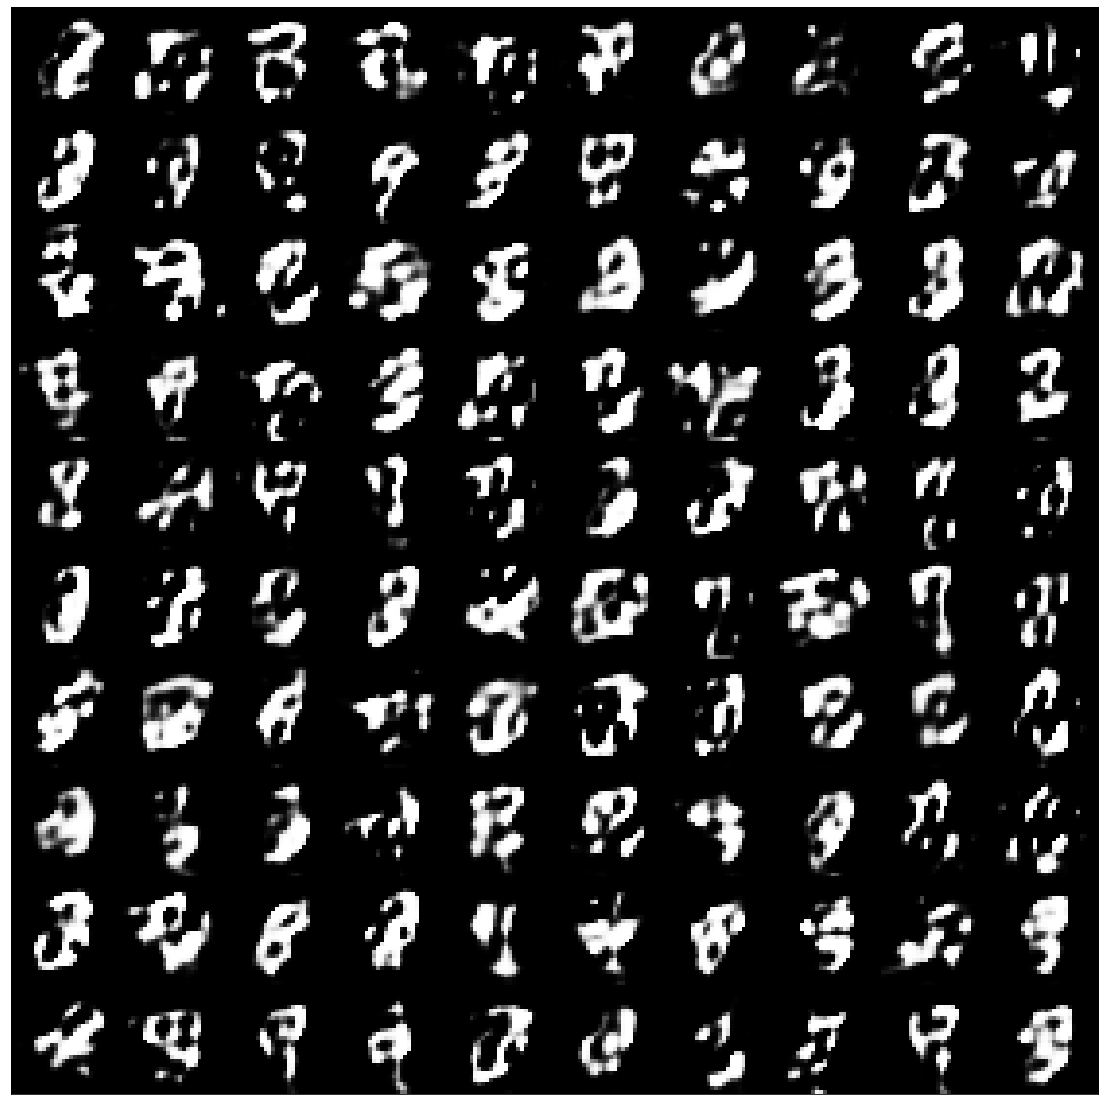

.l_d: 0.592259407043457
.l_d: 0.6094321012496948
.l_d: 0.5831609964370728
.l_d: 0.6072091460227966
.l_d: 0.5921123027801514
.l_d: 0.5784728527069092
.l_d: 0.580988347530365
.l_d: 0.5658937692642212
.l_d: 0.5738754272460938
.l_d: 0.5964531898498535
.l_d: 0.5848280191421509
.l_d: 0.6150130033493042
.l_d: 0.583718478679657
.l_d: 0.5696616172790527
.l_d: 0.5602978467941284
.l_d: 0.6081018447875977
.l_d: 0.562113881111145
.l_d: 0.621227502822876
.l_d: 0.591992974281311
.l_d: 0.5824441909790039
.l_d: 0.6006328463554382
.l_d: 0.6243708729743958
.l_d: 0.5635913610458374
.l_d: 0.5892230868339539
.l_d: 0.5771074891090393
.l_d: 0.5796939134597778
.l_d: 0.5696719884872437
.l_d: 0.5476353168487549
.l_d: 0.5787938833236694
.l_d: 0.5654445290565491
.l_d: 0.586459755897522
.l_d: 0.5795284509658813
.l_d: 0.5712904930114746
.l_d: 0.569042444229126
.l_d: 0.5961942672729492
.l_d: 0.5836879014968872
.l_d: 0.5962649583816528
.l_d: 0.5709702968597412
.l_d: 0.567934513092041
.l_d: 0.5641927719116211
.l_d: 0.5

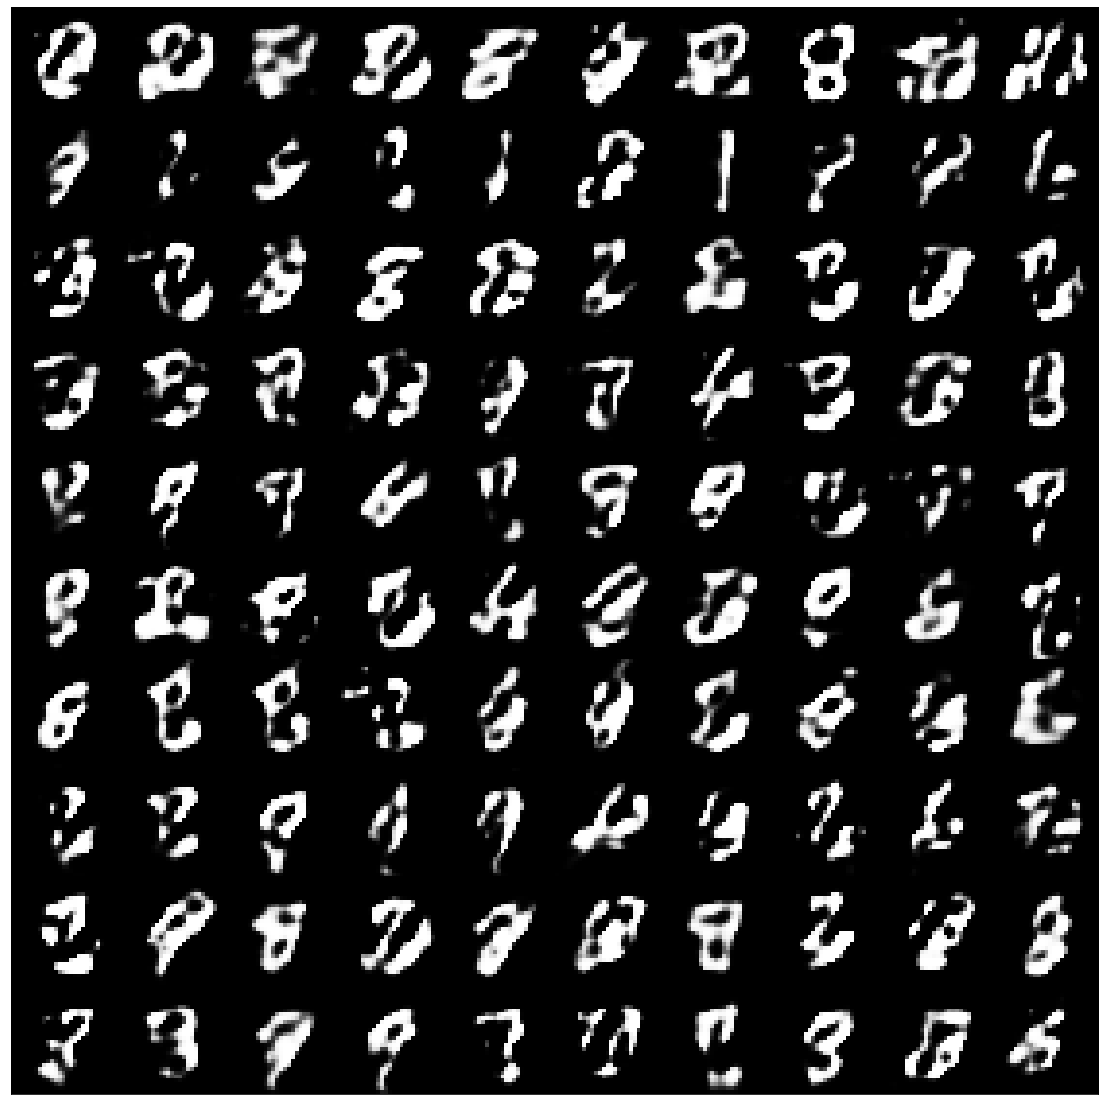

.l_d: 0.5632340312004089
.l_d: 0.5830367803573608
.l_d: 0.5607567429542542
.l_d: 0.5909938812255859
.l_d: 0.5550661087036133
.l_d: 0.5832775831222534
.l_d: 0.55352783203125
.l_d: 0.5750753879547119
.l_d: 0.5532269477844238
.l_d: 0.5550764799118042
.l_d: 0.5884146690368652
.l_d: 0.5686880350112915
.l_d: 0.5526071786880493
.l_d: 0.5454649925231934
.l_d: 0.5570298433303833
.l_d: 0.5440974831581116
.l_d: 0.5781894326210022
.l_d: 0.558857798576355
.l_d: 0.561760425567627
.l_d: 0.5536853075027466
.l_d: 0.5482696294784546
.l_d: 0.5647147297859192
.l_d: 0.5729438066482544
.l_d: 0.5751689076423645
.l_d: 0.5623306035995483
.l_d: 0.5462327003479004
.l_d: 0.5469536185264587
.l_d: 0.555709958076477
.l_d: 0.5635319948196411
.l_d: 0.5762239694595337
.l_d: 0.5562320351600647
.l_d: 0.5530372262001038
.l_d: 0.5753418207168579
.l_d: 0.5755622386932373
.l_d: 0.5611967444419861
.l_d: 0.5425676107406616
.l_d: 0.5415672659873962
.l_d: 0.5492600202560425
.l_d: 0.5512707233428955
.l_d: 0.5628441572189331
.l_d:

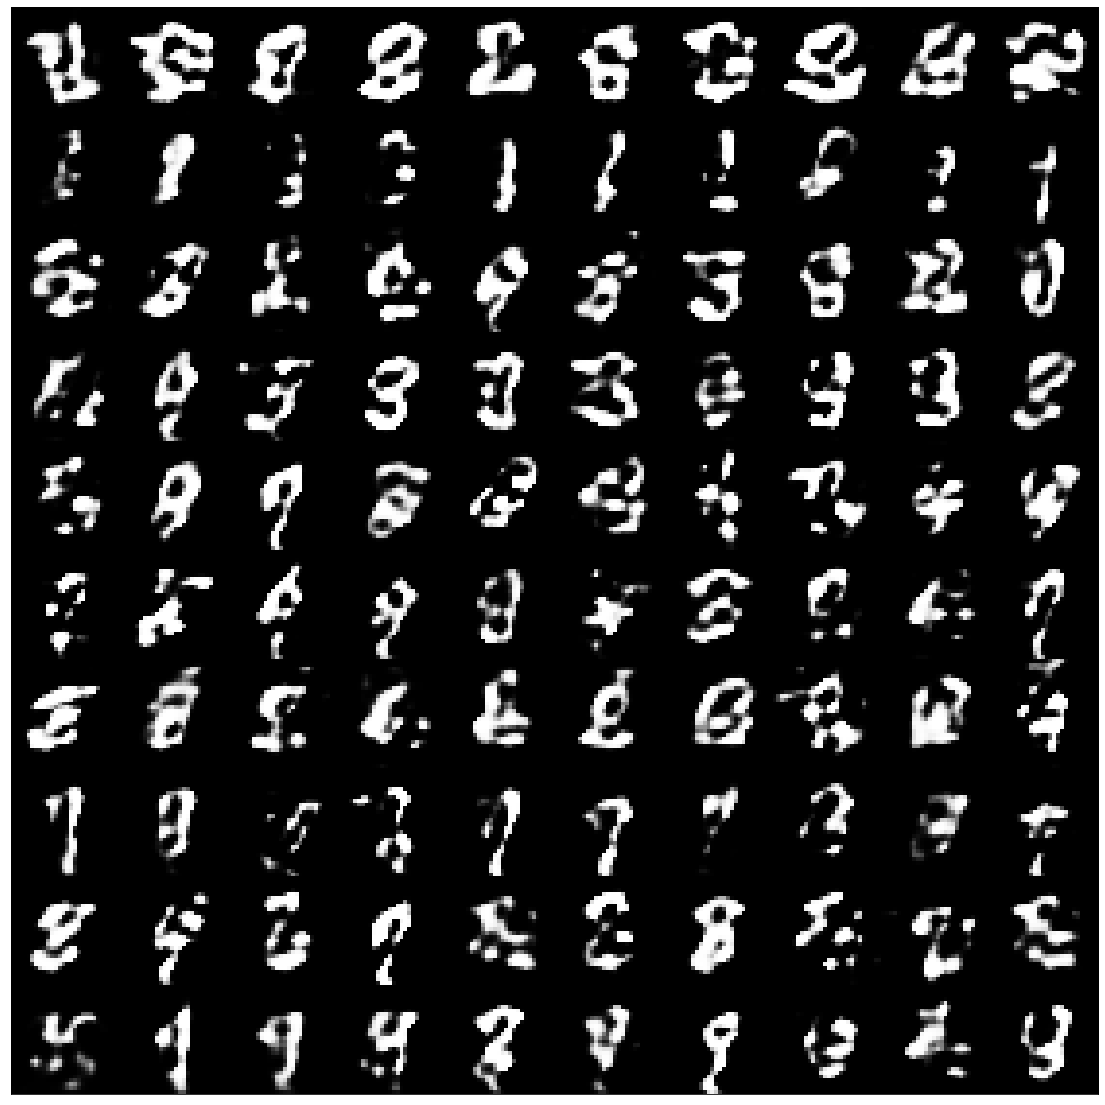

.l_d: 0.5509173274040222
.l_d: 0.5360748767852783
.l_d: 0.5708795189857483
.l_d: 0.5364839434623718
.l_d: 0.5329972505569458
.l_d: 0.5446147918701172
.l_d: 0.576040506362915
.l_d: 0.5586479306221008
.l_d: 0.5333722233772278
.l_d: 0.5585675239562988
.l_d: 0.5581624507904053
.l_d: 0.55252605676651
.l_d: 0.5445718169212341
.l_d: 0.5319689512252808
.l_d: 0.5457009673118591
.l_d: 0.5284665822982788
.l_d: 0.5440757870674133
.l_d: 0.5518810749053955
.l_d: 0.5320430397987366
.l_d: 0.5613283514976501
.l_d: 0.5524721145629883
.l_d: 0.552334725856781
.l_d: 0.5459482073783875
.l_d: 0.5759887099266052
.l_d: 0.5474139451980591
.l_d: 0.5485426187515259
.l_d: 0.547002911567688
.l_d: 0.5541526675224304
.l_d: 0.5579086542129517
.l_d: 0.5725057721138
.l_d: 0.543156087398529
.l_d: 0.5306825637817383
.l_d: 0.5511462688446045
.l_d: 0.5522268414497375
.l_d: 0.5702483057975769
.l_d: 0.5458114743232727
.l_d: 0.5547055602073669
.l_d: 0.570033609867096
.l_d: 0.5534057021141052
.l_d: 0.5529552698135376
.l_d: 0.56

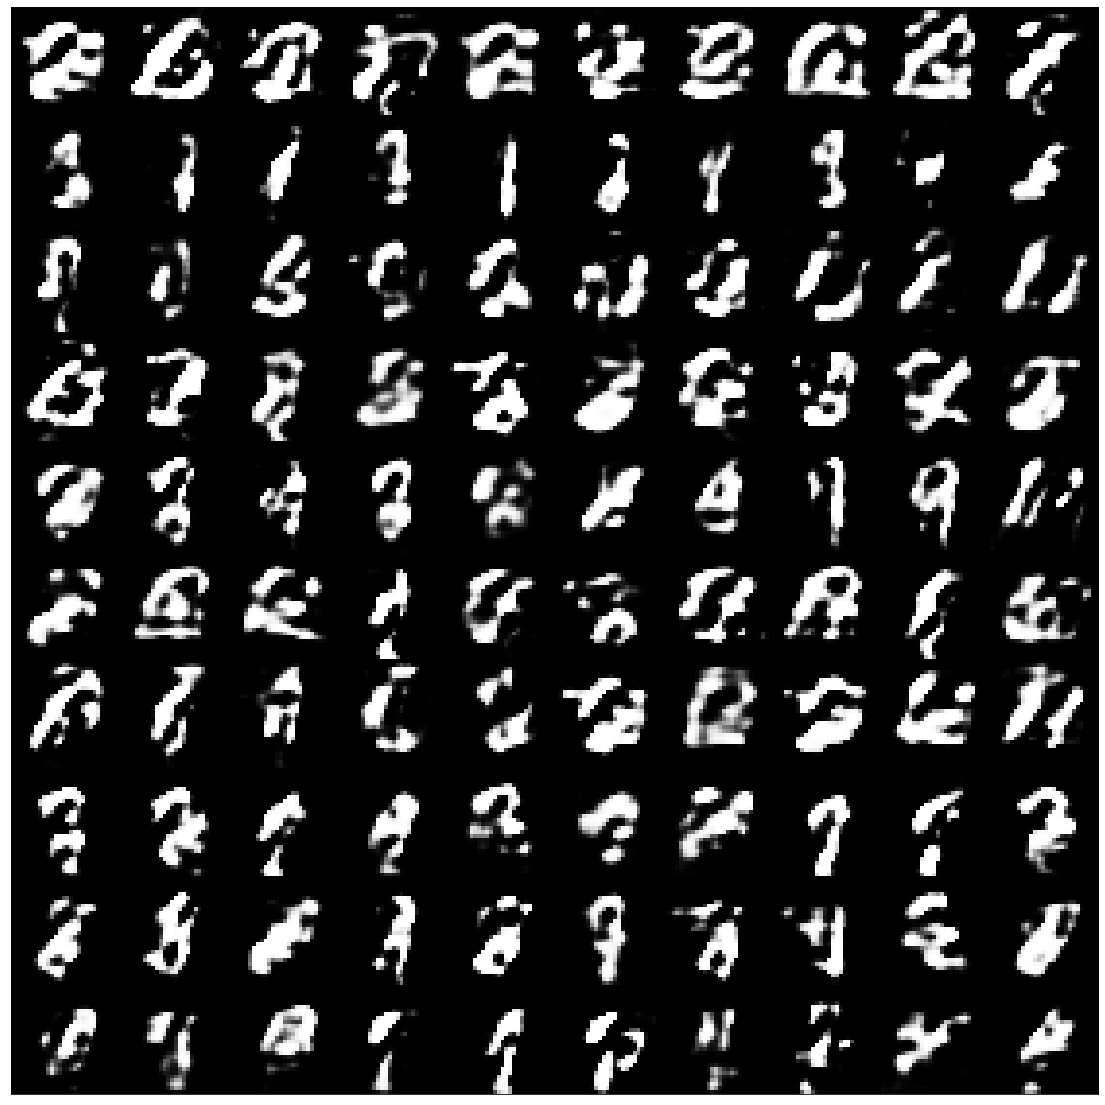

.l_d: 0.5315374135971069
.l_d: 0.5679999589920044
.l_d: 0.5648276805877686
.l_d: 0.5286331176757812
.l_d: 0.5406621694564819
.l_d: 0.5500035881996155
.l_d: 0.5227945446968079
.l_d: 0.5361917018890381
.l_d: 0.5684707760810852
.l_d: 0.5228520035743713
.l_d: 0.547092080116272
.l_d: 0.543714165687561
.l_d: 0.5217947959899902
.l_d: 0.5344041585922241
.l_d: 0.5298038125038147
.l_d: 0.5370073914527893
.l_d: 0.5422383546829224
.l_d: 0.5545088648796082
.l_d: 0.5658175945281982
.l_d: 0.5605819821357727
.l_d: 0.5622590780258179
.l_d: 0.529219388961792
.l_d: 0.5393350124359131
.l_d: 0.5370995998382568
.l_d: 0.535906970500946
.l_d: 0.5465558767318726
.l_d: 0.5483903884887695
.l_d: 0.5219082832336426
.l_d: 0.5304926633834839
.l_d: 0.5479682683944702
.l_d: 0.5469210147857666
.l_d: 0.545758843421936
.l_d: 0.529707670211792
.l_d: 0.5568535923957825
.l_d: 0.562978982925415
.l_d: 0.5219516754150391
.l_d: 0.5354504585266113
.l_d: 0.5314935445785522
.l_d: 0.5370416641235352
.l_d: 0.5321863889694214
.l_d: 0

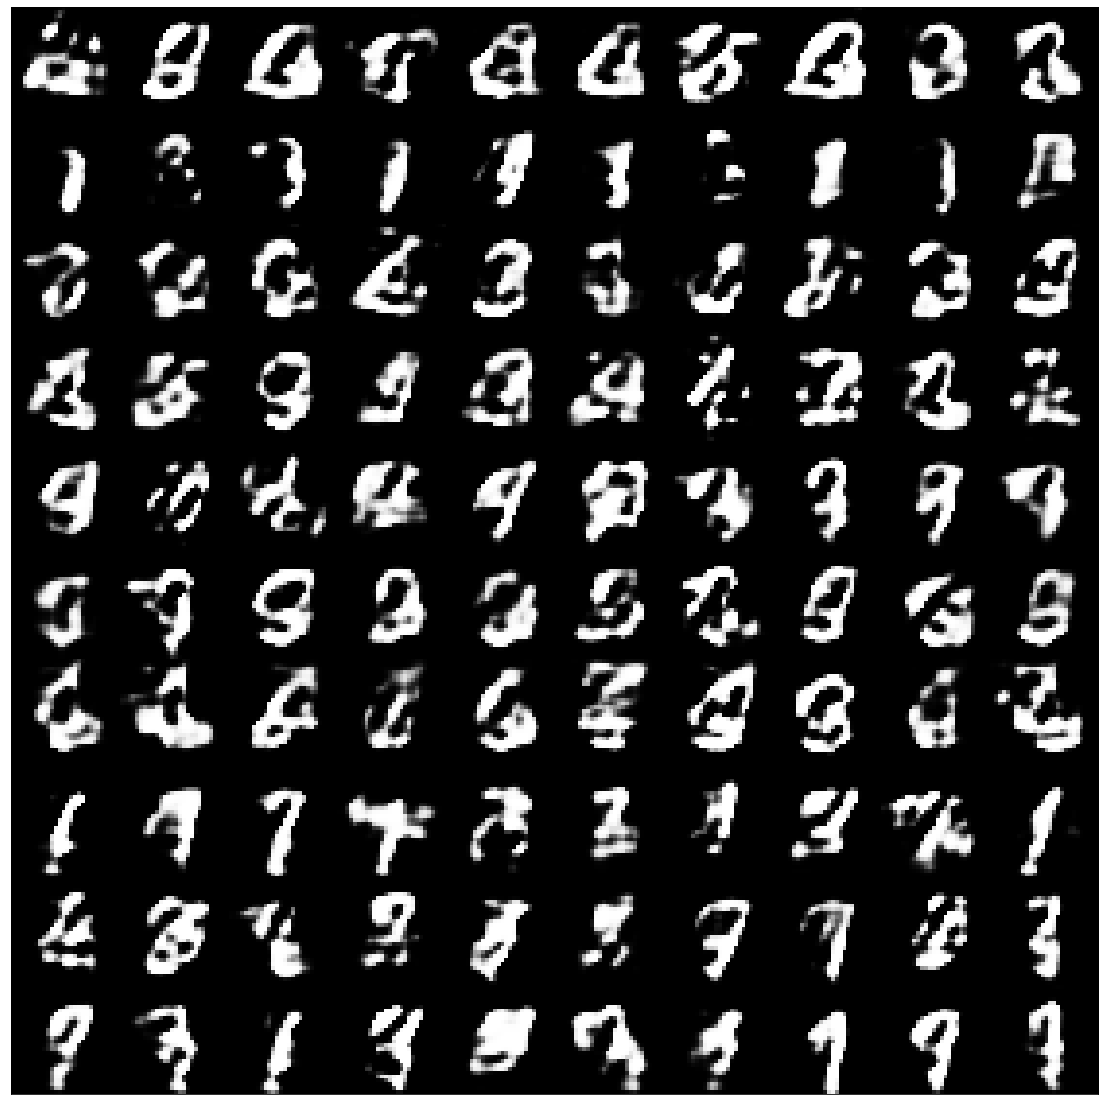

.l_d: 0.5242510437965393
.l_d: 0.5665264129638672
.l_d: 0.5307003259658813
.l_d: 0.5449903011322021
.l_d: 0.5327824354171753
.l_d: 0.5502105951309204
.l_d: 0.5401614904403687
.l_d: 0.526063084602356
.l_d: 0.5488473773002625
.l_d: 0.5468769073486328
.l_d: 0.5409163236618042
.l_d: 0.5359807014465332
.l_d: 0.5282189249992371
.l_d: 0.5330921411514282
.l_d: 0.5358418226242065
.l_d: 0.5806221961975098
.l_d: 0.5799578428268433
.l_d: 0.5322117805480957
.l_d: 0.5419750213623047
.l_d: 0.5558727979660034
.l_d: 0.5261029005050659
.l_d: 0.5406213998794556
.l_d: 0.5557418465614319
.l_d: 0.5290465354919434
.l_d: 0.5616230964660645
.l_d: 0.5449881553649902
.l_d: 0.5683527588844299
.l_d: 0.5548875331878662
.l_d: 0.5536611080169678
.l_d: 0.5389640927314758
.l_d: 0.5093978643417358
.l_d: 0.5460165739059448
.l_d: 0.5583335161209106
.l_d: 0.5387671589851379
.l_d: 0.5366572141647339
.l_d: 0.5732375383377075
.l_d: 0.5108985900878906
.l_d: 0.5560849905014038
.l_d: 0.5199754238128662
.l_d: 0.5649420022964478
.

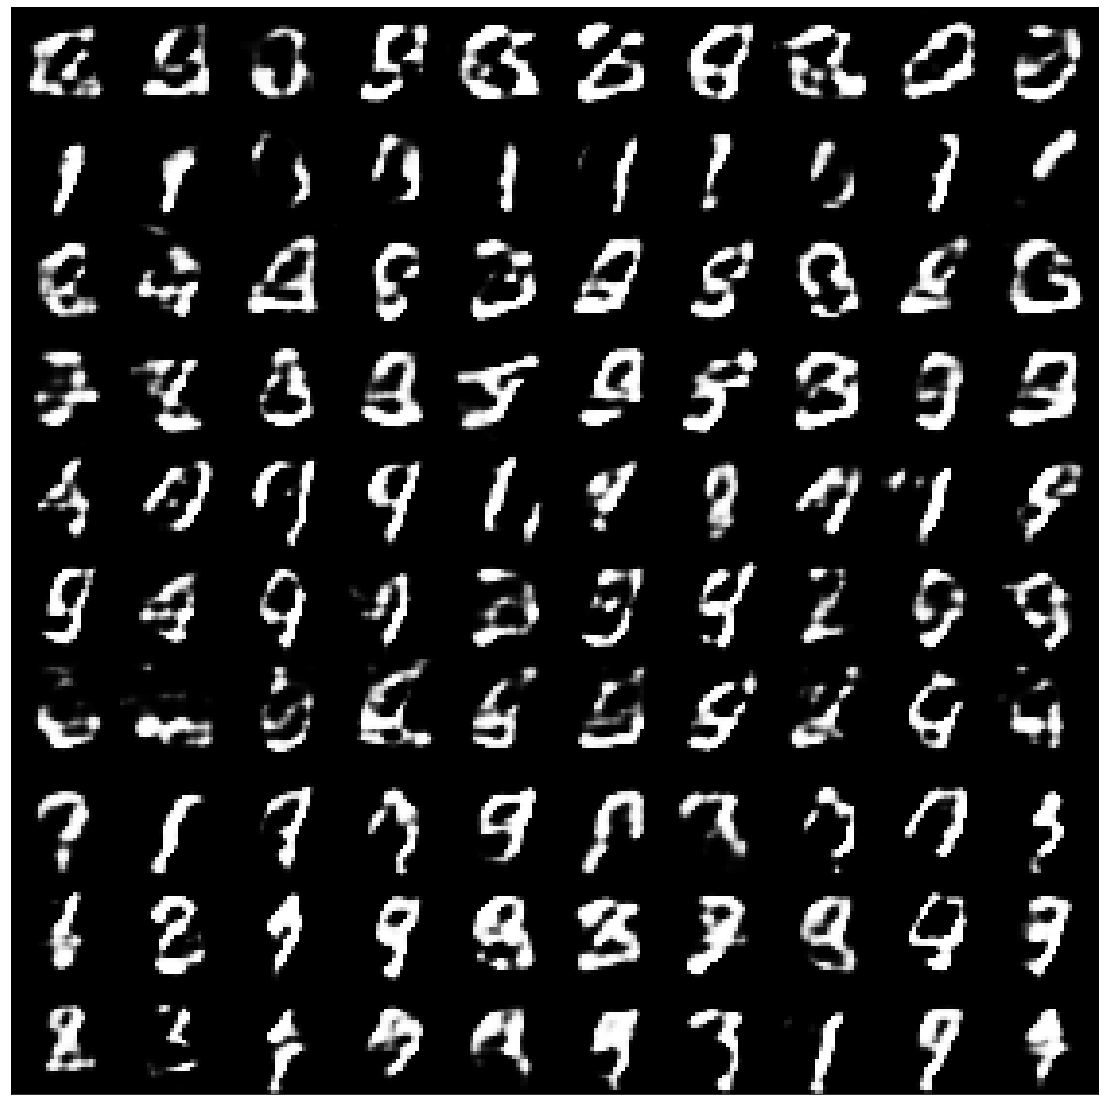

.l_d: 0.5386601686477661
.l_d: 0.5563989281654358
.l_d: 0.5493785738945007
.l_d: 0.5340641140937805
.l_d: 0.5539026260375977
.l_d: 0.5618488788604736
.l_d: 0.538404643535614
.l_d: 0.5368242263793945
.l_d: 0.5693869590759277
.l_d: 0.5296933650970459
.l_d: 0.5386133193969727
.l_d: 0.5187981724739075
.l_d: 0.536933422088623
.l_d: 0.5472365617752075
.l_d: 0.5703100562095642
.l_d: 0.5694602727890015
.l_d: 0.5506488084793091
.l_d: 0.5447978973388672
.l_d: 0.5727126598358154
.l_d: 0.5401433706283569
.l_d: 0.5245983600616455
.l_d: 0.5319485664367676
.l_d: 0.5603361129760742
.l_d: 0.5318378210067749
.l_d: 0.5441348552703857
.l_d: 0.5128323435783386
.l_d: 0.534835934638977
.l_d: 0.5443418622016907
.l_d: 0.5530415773391724
.l_d: 0.5648757815361023
.l_d: 0.5672321915626526
.l_d: 0.571708083152771
.l_d: 0.5449722409248352
.l_d: 0.5504226684570312
.l_d: 0.5452243089675903
.l_d: 0.5399239659309387
.l_d: 0.5342222452163696
.l_d: 0.5035899877548218
.l_d: 0.5313236117362976
.l_d: 0.5492434501647949
.l_d

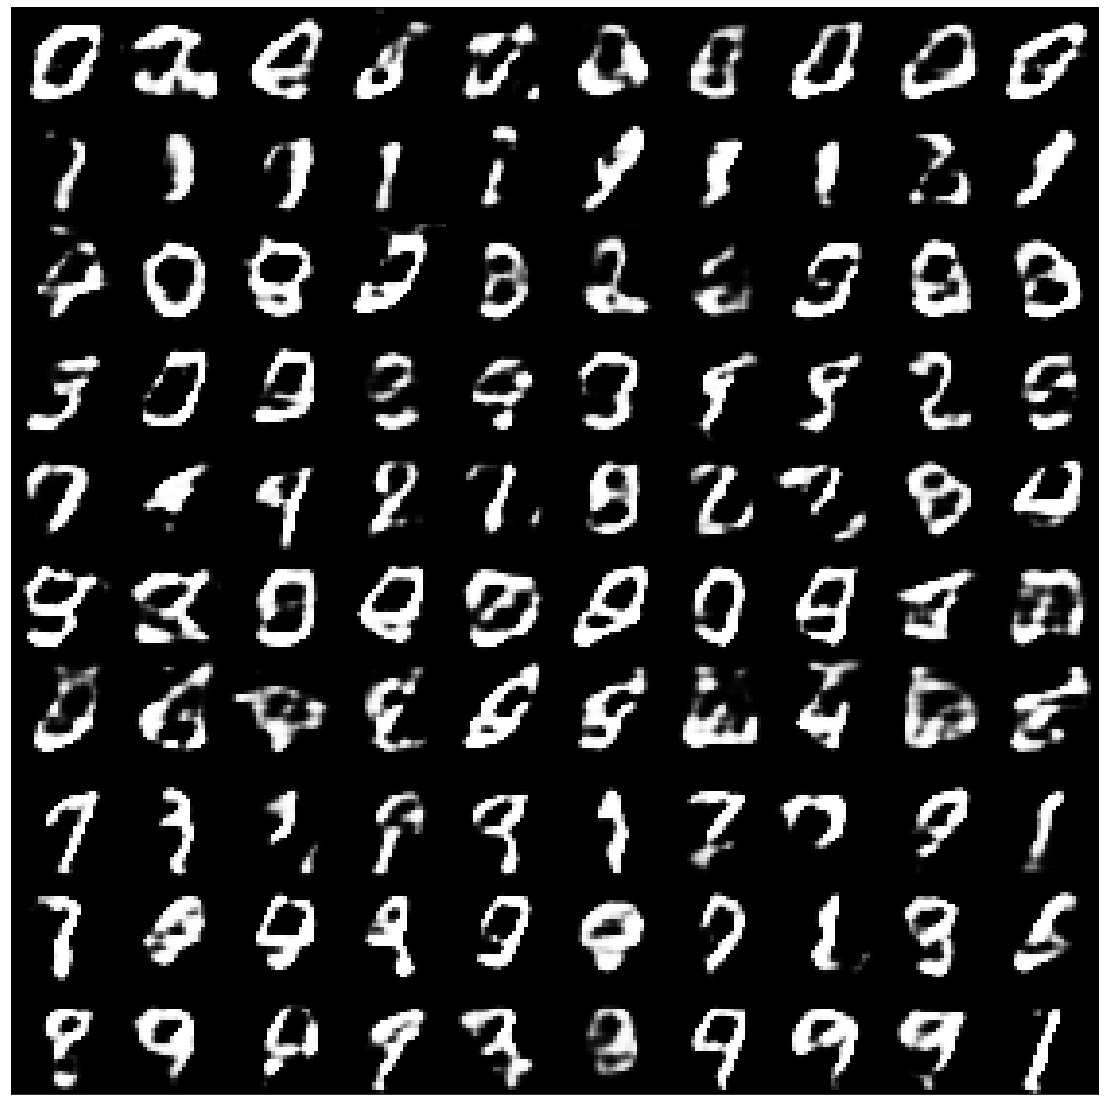

.l_d: 0.524839460849762
.l_d: 0.5606904625892639
.l_d: 0.535883903503418
.l_d: 0.5652079582214355
.l_d: 0.5088618993759155
.l_d: 0.5327884554862976
.l_d: 0.5384598970413208
.l_d: 0.5572547316551208
.l_d: 0.544916570186615
.l_d: 0.5483071208000183
.l_d: 0.5693520307540894
.l_d: 0.5640658736228943
.l_d: 0.5864335298538208
.l_d: 0.5601104497909546
.l_d: 0.562711238861084
.l_d: 0.553490400314331
.l_d: 0.5539190769195557
.l_d: 0.5161022543907166
.l_d: 0.5450717210769653
.l_d: 0.5412347316741943
.l_d: 0.5459260940551758
.l_d: 0.5537230968475342
.l_d: 0.5110571980476379
.l_d: 0.5386691093444824
.l_d: 0.5247868299484253
.l_d: 0.5703160166740417
.l_d: 0.550682783126831
.l_d: 0.5383341312408447
.l_d: 0.5174052715301514
.l_d: 0.5699395537376404
.l_d: 0.5378169417381287
.l_d: 0.5223808288574219
.l_d: 0.49177923798561096
.l_d: 0.5400887131690979
.l_d: 0.5279802680015564
.l_d: 0.5088096261024475
.l_d: 0.5642383098602295
.l_d: 0.5301541686058044
.l_d: 0.5696759819984436
.l_d: 0.5382139682769775
.l_d:

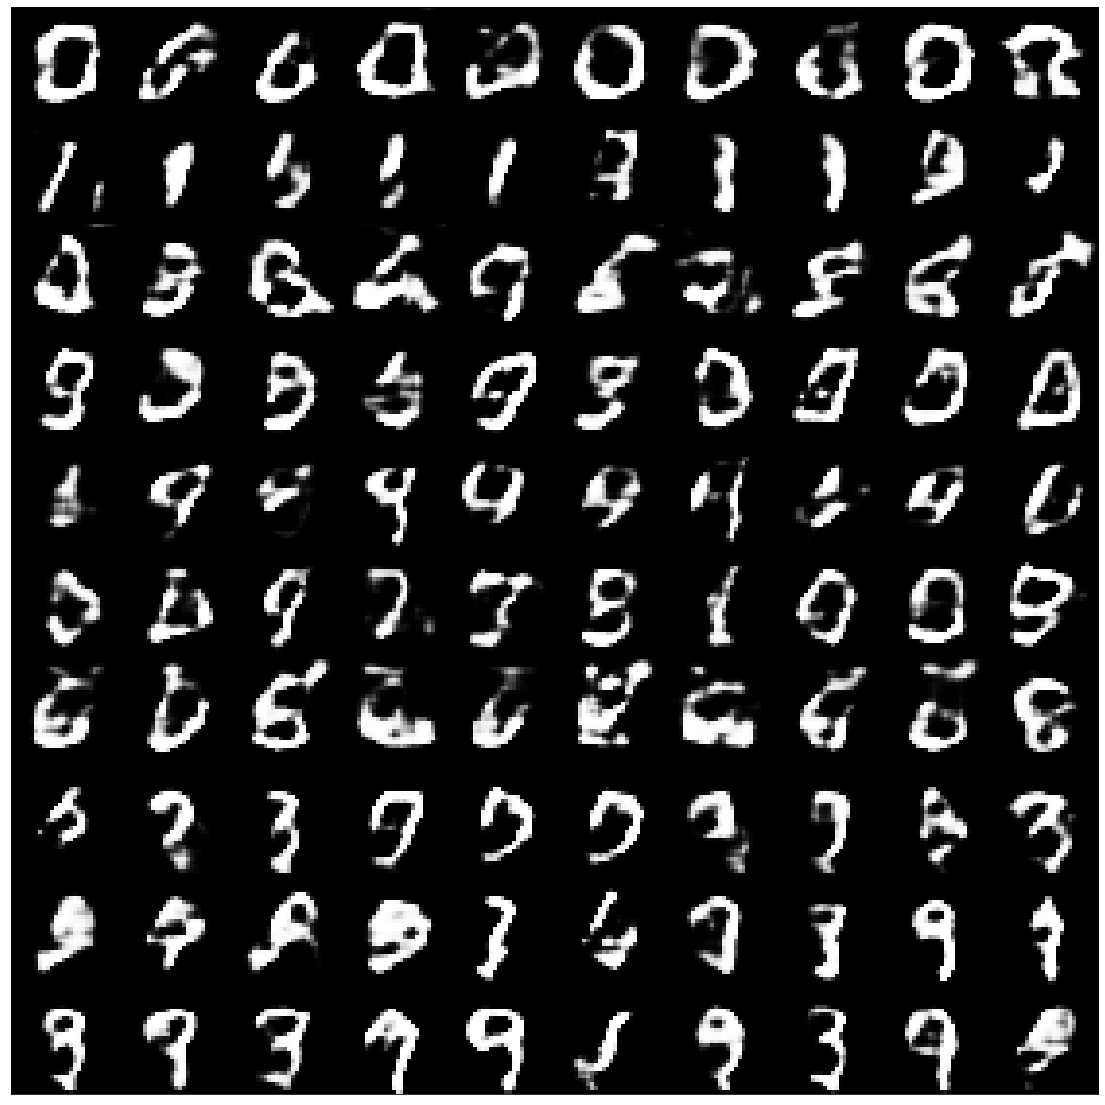

.l_d: 0.5591704845428467
.l_d: 0.5488924384117126
.l_d: 0.5410305261611938
.l_d: 0.532953143119812
.l_d: 0.5675450563430786
.l_d: 0.5347079634666443
.l_d: 0.5817599296569824
.l_d: 0.5244042873382568
.l_d: 0.5280311107635498
.l_d: 0.5292136073112488
.l_d: 0.5556514263153076
.l_d: 0.5297777652740479
.l_d: 0.5614696741104126
.l_d: 0.5748014450073242
.l_d: 0.5094335675239563
.l_d: 0.5845819711685181
.l_d: 0.5440519452095032
.l_d: 0.5684382319450378
.l_d: 0.5316479206085205
.l_d: 0.5452252626419067
.l_d: 0.524423360824585
.l_d: 0.5616191029548645
.l_d: 0.5231949687004089
.l_d: 0.5508327484130859
.l_d: 0.5493931770324707
.l_d: 0.564210057258606
.l_d: 0.5580471158027649
.l_d: 0.5408998727798462
.l_d: 0.5585620403289795
.l_d: 0.5470471978187561
.l_d: 0.5266778469085693
.l_d: 0.5912168025970459
.l_d: 0.5250166058540344
.l_d: 0.5857500433921814
.l_d: 0.5515227317810059
.l_d: 0.5730114579200745
.l_d: 0.546989917755127
.l_d: 0.5061659812927246
.l_d: 0.5295532941818237
.l_d: 0.5522966384887695
.l_d

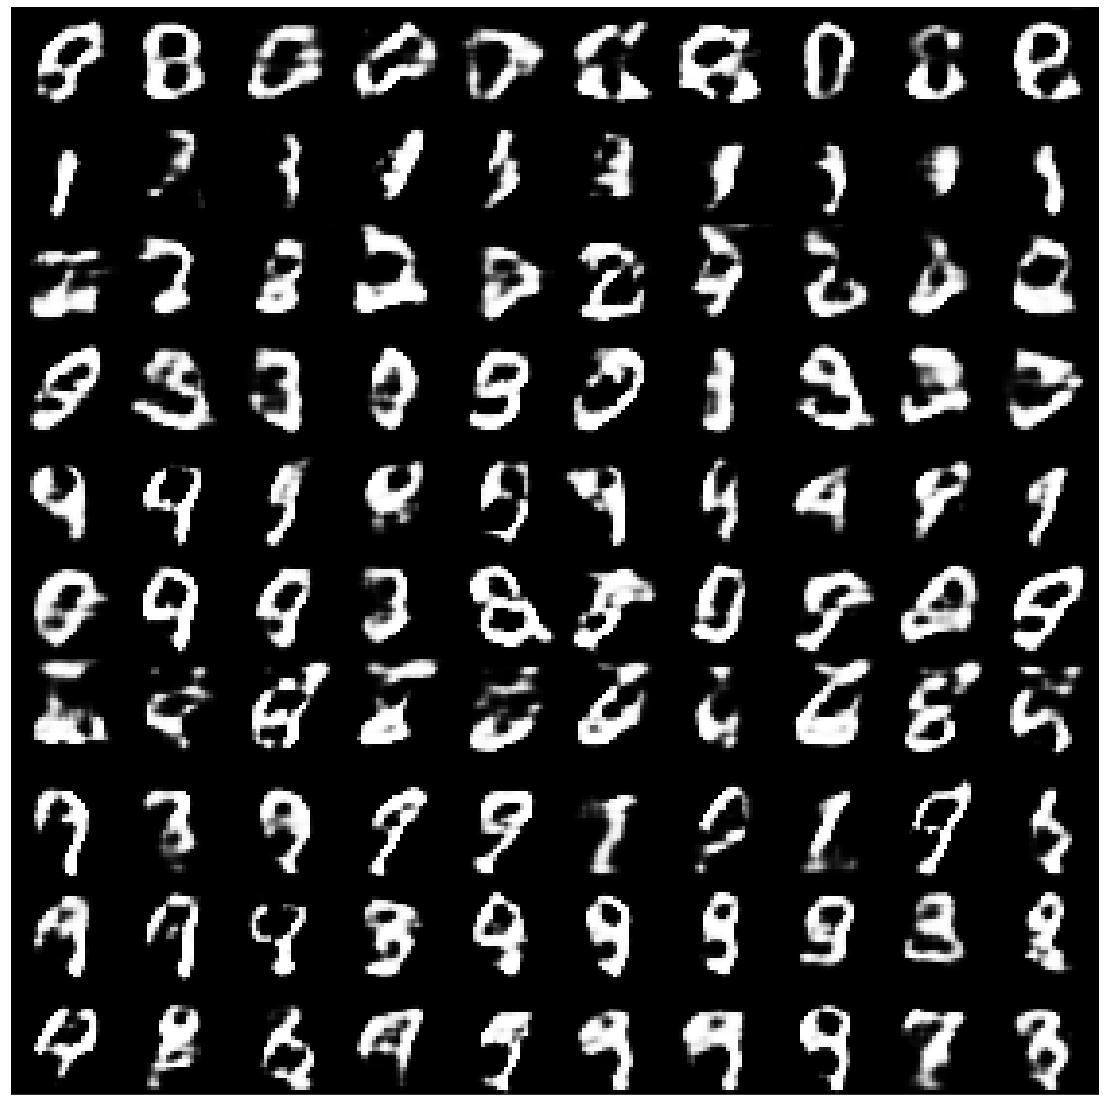

.l_d: 0.5407612919807434
.l_d: 0.5390368700027466
.l_d: 0.5801944732666016
.l_d: 0.5606790781021118
.l_d: 0.5276055335998535
.l_d: 0.5634229779243469
.l_d: 0.5382363796234131
.l_d: 0.5367686748504639
.l_d: 0.548489511013031
.l_d: 0.528052568435669
.l_d: 0.5236063003540039
.l_d: 0.5349040031433105
.l_d: 0.5563610792160034
.l_d: 0.5587337017059326
.l_d: 0.5373581647872925
.l_d: 0.5627476572990417
.l_d: 0.5416909456253052
.l_d: 0.575412392616272
.l_d: 0.5507569909095764
.l_d: 0.5554718971252441
.l_d: 0.5273151993751526
.l_d: 0.5392857789993286
.l_d: 0.552469789981842
.l_d: 0.549534797668457
.l_d: 0.5613285303115845
.l_d: 0.542001485824585
.l_d: 0.5248887538909912
.l_d: 0.5554866790771484
.l_d: 0.5267648100852966
.l_d: 0.5214969515800476
.l_d: 0.4967930316925049
.l_d: 0.5433417558670044
.l_d: 0.5303177237510681
.l_d: 0.5147284269332886
.l_d: 0.5135254263877869
.l_d: 0.5951501131057739
.l_d: 0.5648866295814514
.l_d: 0.5530692934989929
.l_d: 0.529785692691803
.l_d: 0.5335509181022644
.l_d: 0

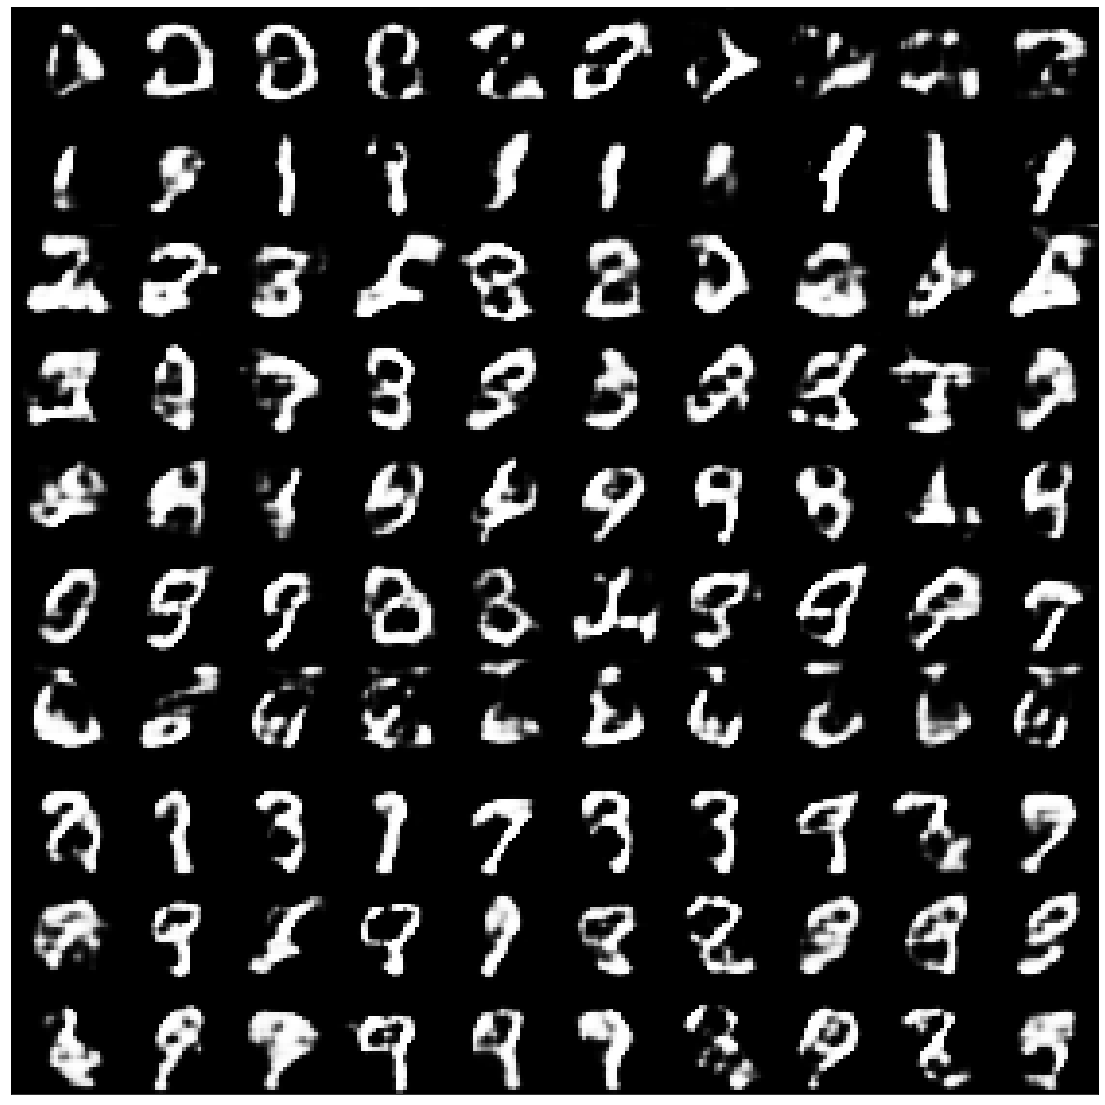

.l_d: 0.5372072458267212
.l_d: 0.5440407991409302
.l_d: 0.5210157632827759
.l_d: 0.5631558895111084
.l_d: 0.5742291212081909
.l_d: 0.5410776138305664
.l_d: 0.564484715461731
.l_d: 0.5317678451538086
.l_d: 0.5472712516784668
.l_d: 0.5110776424407959
.l_d: 0.5397953987121582
.l_d: 0.5634399652481079
.l_d: 0.5476857423782349
.l_d: 0.5600666403770447
.l_d: 0.5434012413024902
.l_d: 0.5339834690093994
.l_d: 0.5346248149871826
.l_d: 0.5297295451164246
.l_d: 0.5074688196182251
.l_d: 0.5634766817092896
.l_d: 0.5489201545715332
.l_d: 0.5202731490135193
.l_d: 0.4936996102333069
.l_d: 0.5494460463523865
.l_d: 0.5229500532150269
.l_d: 0.5413647294044495
.l_d: 0.5437673330307007
.l_d: 0.5460220575332642
.l_d: 0.5848618149757385
.l_d: 0.5246487259864807
.l_d: 0.5447394847869873
.l_d: 0.5095483064651489
.l_d: 0.55433589220047
.l_d: 0.5319606065750122
.l_d: 0.5393509268760681
.l_d: 0.5195556282997131
.l_d: 0.5793004035949707
.l_d: 0.5588850975036621
.l_d: 0.5590283274650574
.l_d: 0.5540395379066467
.l_

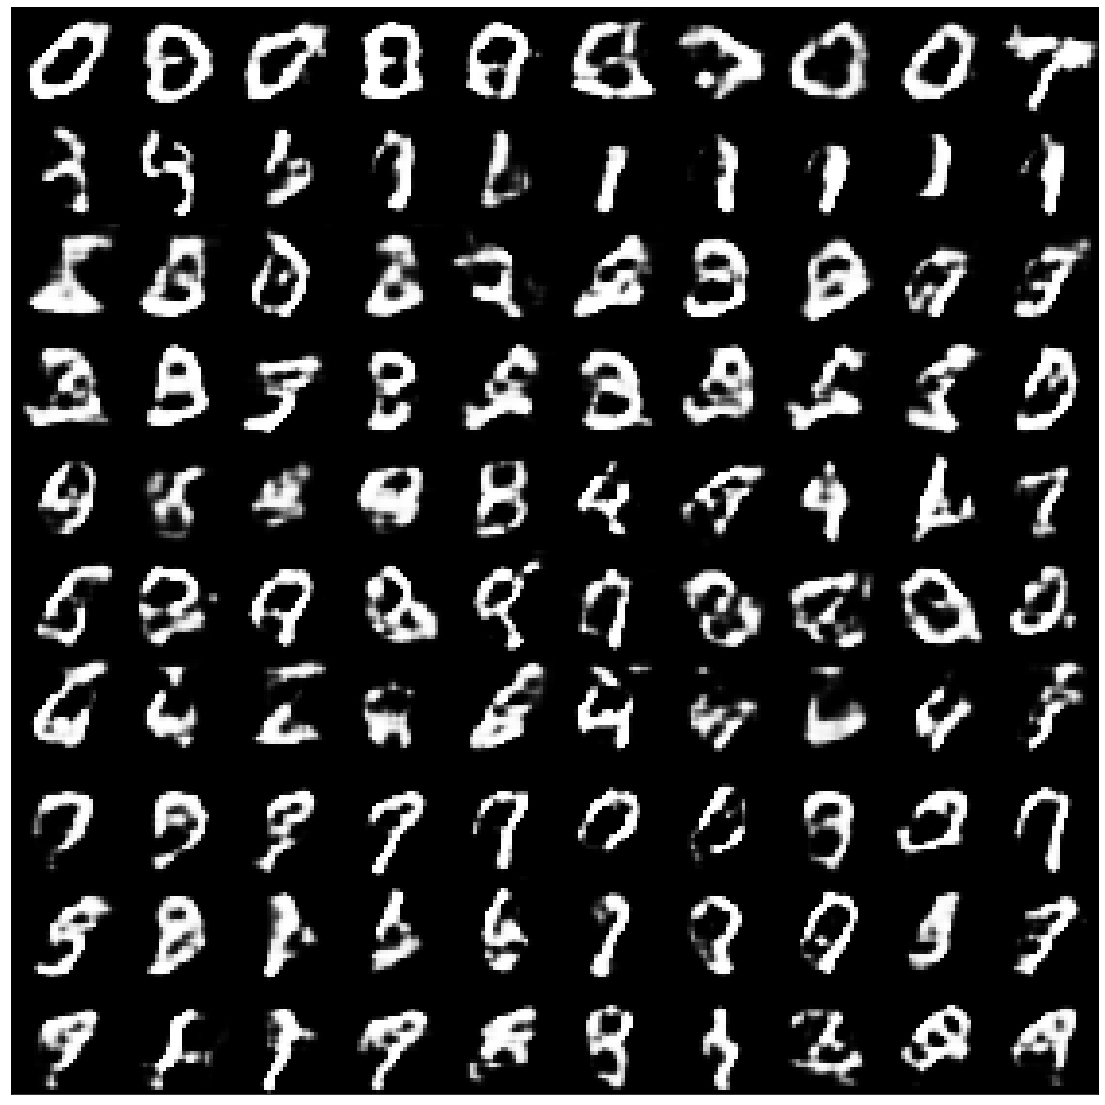

.l_d: 0.5162829160690308
.l_d: 0.5562433004379272
.l_d: 0.49647659063339233
.l_d: 0.5510758757591248
.l_d: 0.515876293182373
.l_d: 0.5200207829475403
.l_d: 0.5378842353820801
.l_d: 0.5144554376602173
.l_d: 0.5565837025642395
.l_d: 0.5594388246536255
.l_d: 0.5687952637672424
.l_d: 0.5534034967422485
.l_d: 0.5124431848526001
.l_d: 0.5274034142494202
.l_d: 0.5795662999153137
.l_d: 0.5952266454696655
.l_d: 0.5394448637962341
.l_d: 0.5739378929138184
.l_d: 0.558035671710968
.l_d: 0.5445300936698914
.l_d: 0.5455628037452698
.l_d: 0.5268179178237915
.l_d: 0.5609303712844849
.l_d: 0.49506035447120667
.l_d: 0.5391207933425903
.l_d: 0.5466699004173279
.l_d: 0.5335213541984558
.l_d: 0.537722110748291
.l_d: 0.5739855766296387
.l_d: 0.5725240111351013
.l_d: 0.5543449521064758
.l_d: 0.5224634408950806
.l_d: 0.5427876710891724
.l_d: 0.5395987033843994
.l_d: 0.552058756351471
.l_d: 0.5435751676559448
.l_d: 0.544638991355896
.l_d: 0.5428590774536133
.l_d: 0.5329656600952148
.l_d: 0.5365409255027771
.l_

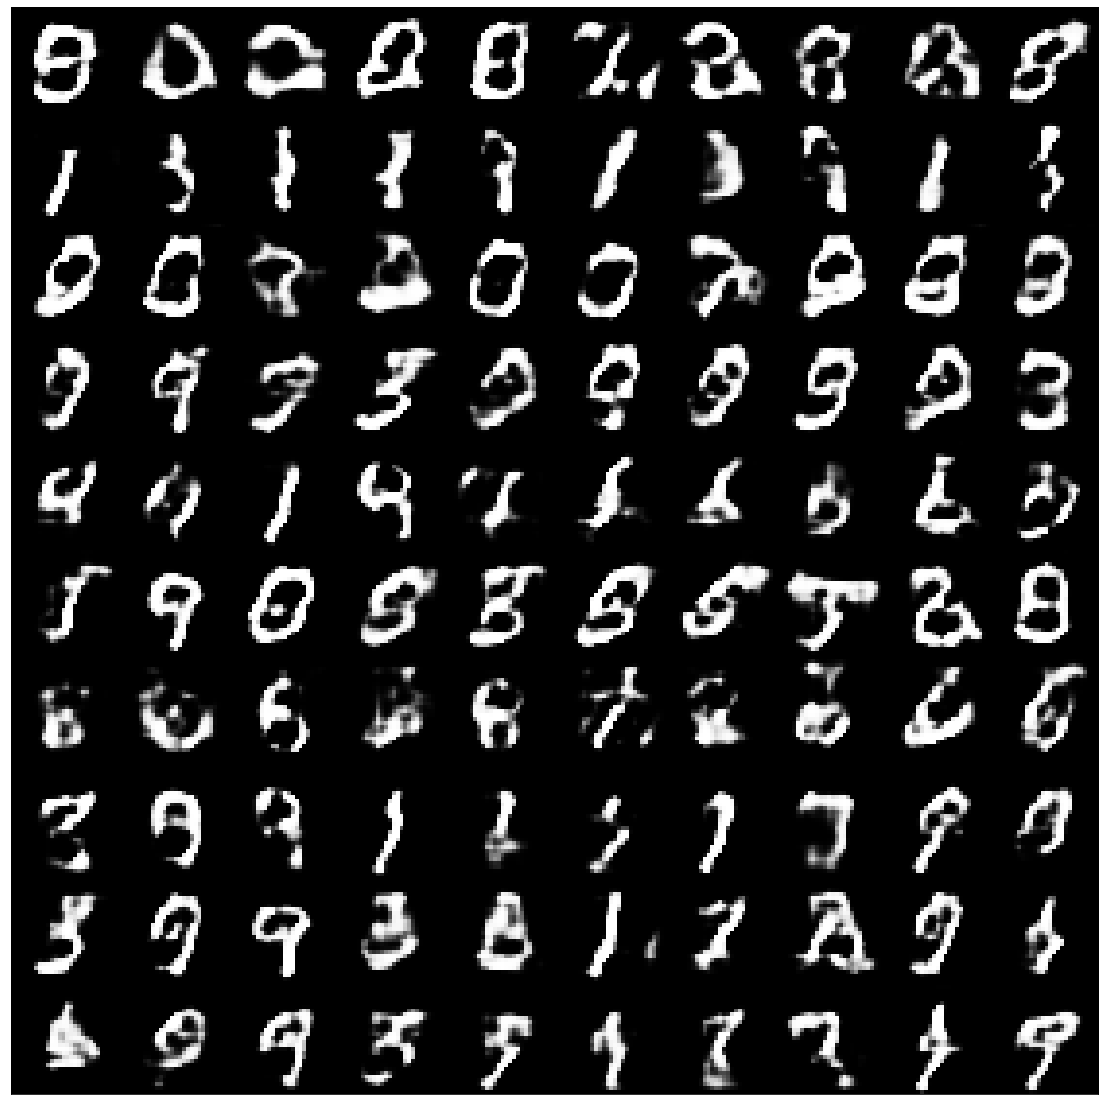

.l_d: 0.5274255871772766
.l_d: 0.5456105470657349
.l_d: 0.5235975980758667
.l_d: 0.5418215990066528
.l_d: 0.5434123277664185
.l_d: 0.5549103021621704
.l_d: 0.5659143328666687
.l_d: 0.5506434440612793
.l_d: 0.5589370727539062
.l_d: 0.5575545430183411
.l_d: 0.524816632270813
.l_d: 0.5466240048408508
.l_d: 0.5131202936172485
.l_d: 0.5392045378684998
.l_d: 0.5419611930847168
.l_d: 0.5887608528137207
.l_d: 0.5274291038513184
.l_d: 0.541988730430603
.l_d: 0.5311541557312012
.l_d: 0.5424439311027527
.l_d: 0.5436127185821533
.l_d: 0.5473220348358154
.l_d: 0.5455518960952759
.l_d: 0.525370717048645
.l_d: 0.5634782314300537
.l_d: 0.5169125199317932
.l_d: 0.5314669609069824
.l_d: 0.5653328895568848
.l_d: 0.5374870896339417
.l_d: 0.5562542676925659
.l_d: 0.5375598669052124
.l_d: 0.5631450414657593
.l_d: 0.5115021467208862
.l_d: 0.5560824871063232
.l_d: 0.5177946090698242
.l_d: 0.5149152278900146
.l_d: 0.5343834757804871
.l_d: 0.5586853623390198
.l_d: 0.5723019242286682
.l_d: 0.5386726260185242
.l_

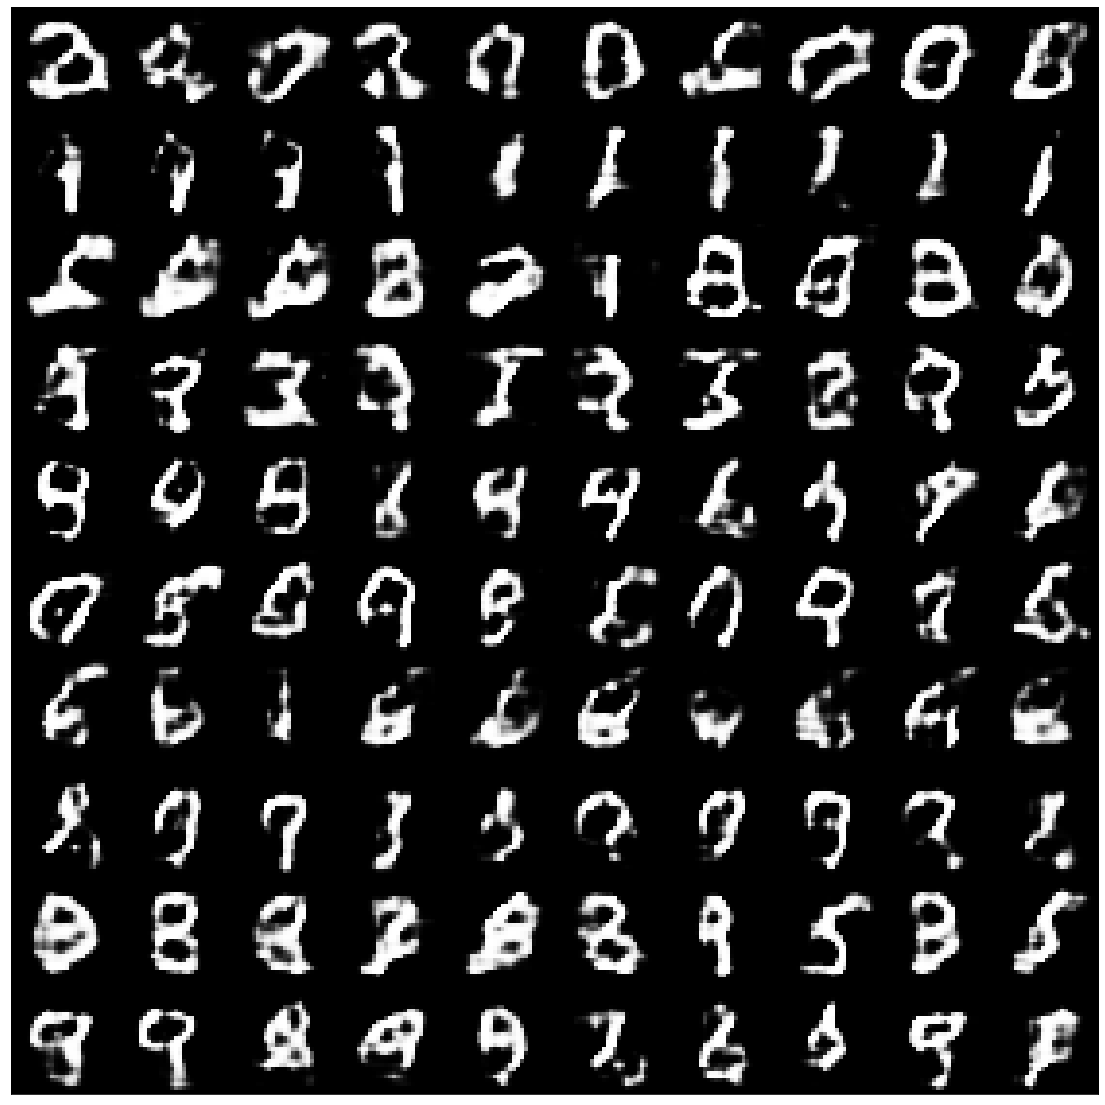

.l_d: 0.5249649286270142
.l_d: 0.5394095182418823
.l_d: 0.5389623045921326
.l_d: 0.5383262634277344
.l_d: 0.5213512182235718
.l_d: 0.5454212427139282
.l_d: 0.5724339485168457
.l_d: 0.5528064370155334
.l_d: 0.5013424158096313
.l_d: 0.5534362196922302
.l_d: 0.5401685237884521
.l_d: 0.5827927589416504
.l_d: 0.5916889905929565
.l_d: 0.5337330102920532
.l_d: 0.5458272695541382
.l_d: 0.5101262927055359
.l_d: 0.5096234083175659
.l_d: 0.47630882263183594
.l_d: 0.5462682843208313
.l_d: 0.5462552309036255
.l_d: 0.5623130798339844
.l_d: 0.5202910900115967
.l_d: 0.4981197416782379
.l_d: 0.562045693397522
.l_d: 0.5402143597602844
.l_d: 0.5505834221839905
.l_d: 0.5323478579521179
.l_d: 0.49244990944862366
.l_d: 0.5636632442474365
.l_d: 0.5290482640266418
.l_d: 0.5203058123588562
.l_d: 0.5490450859069824
.l_d: 0.5417006015777588
.l_d: 0.5714049339294434
.l_d: 0.5281486511230469
.l_d: 0.5349595546722412
.l_d: 0.5337417125701904
.l_d: 0.5029321312904358
.l_d: 0.5171647071838379
.l_d: 0.5456810593605042

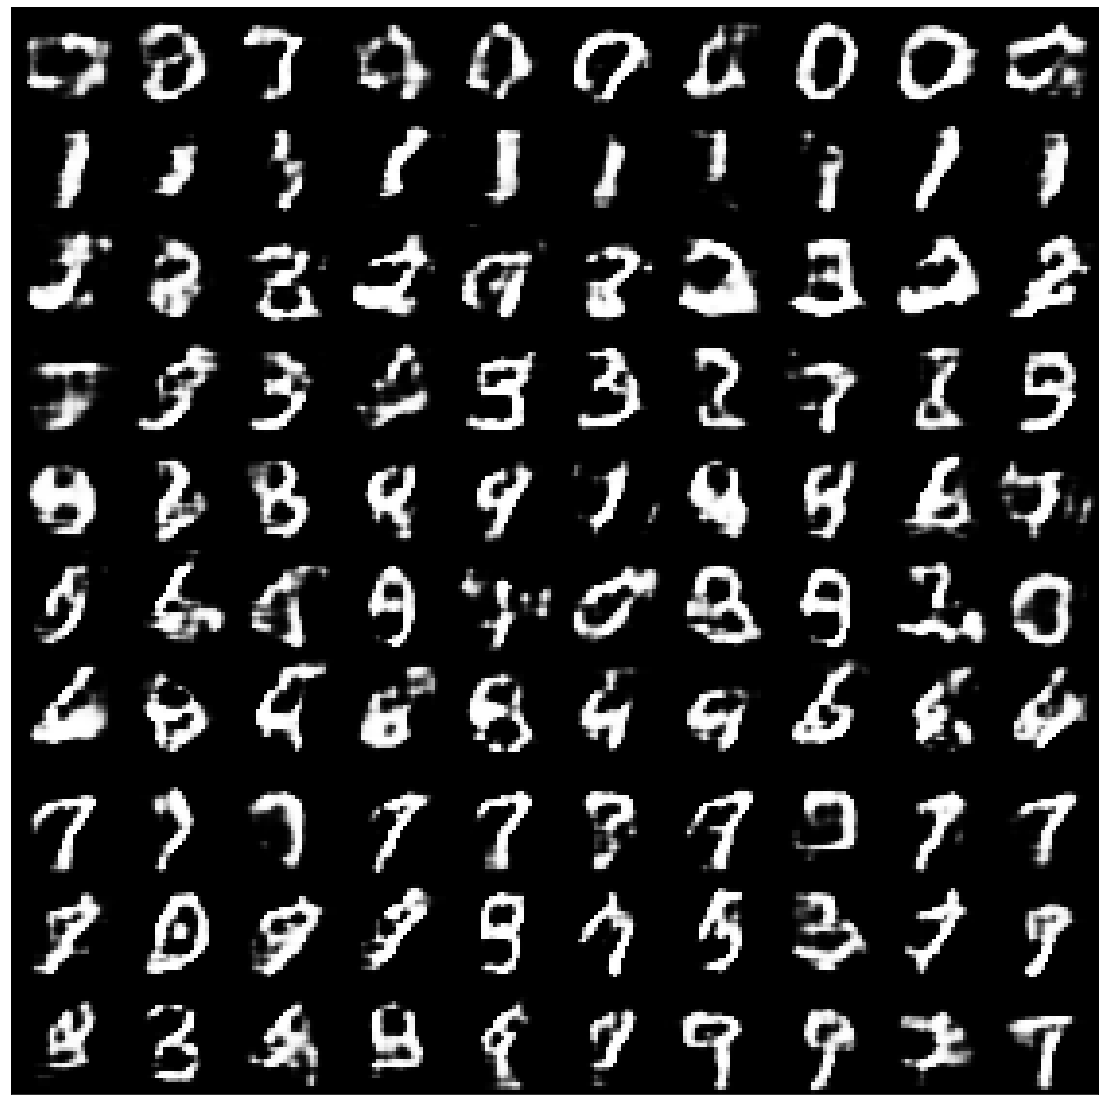

.l_d: 0.5441795587539673
.l_d: 0.5135310888290405
.l_d: 0.5525859594345093
.l_d: 0.5147557258605957
.l_d: 0.4776015281677246
.l_d: 0.5621219873428345
.l_d: 0.5571518540382385
.l_d: 0.5609157085418701
.l_d: 0.596593976020813
.l_d: 0.5299205780029297
.l_d: 0.5760653018951416
.l_d: 0.5074853897094727
.l_d: 0.49683600664138794
.l_d: 0.5145500898361206
.l_d: 0.5516347885131836
.l_d: 0.5193215608596802
.l_d: 0.5273610949516296
.l_d: 0.5578400492668152
.l_d: 0.5319472551345825
.l_d: 0.5520703196525574
.l_d: 0.56451416015625
.l_d: 0.49507927894592285
.l_d: 0.5555362105369568
.l_d: 0.5258955955505371
.l_d: 0.5174058079719543
.l_d: 0.5521054863929749
.l_d: 0.4771450161933899
.l_d: 0.533332347869873
.l_d: 0.49967315793037415
.l_d: 0.5374622941017151
.l_d: 0.5613017082214355
.l_d: 0.5606285333633423
.l_d: 0.5395069122314453
.l_d: 0.6041139364242554
.l_d: 0.5082492232322693
.l_d: 0.5447912216186523
.l_d: 0.510063111782074
.l_d: 0.5359008312225342
.l_d: 0.48778867721557617
.l_d: 0.5420264005661011
.

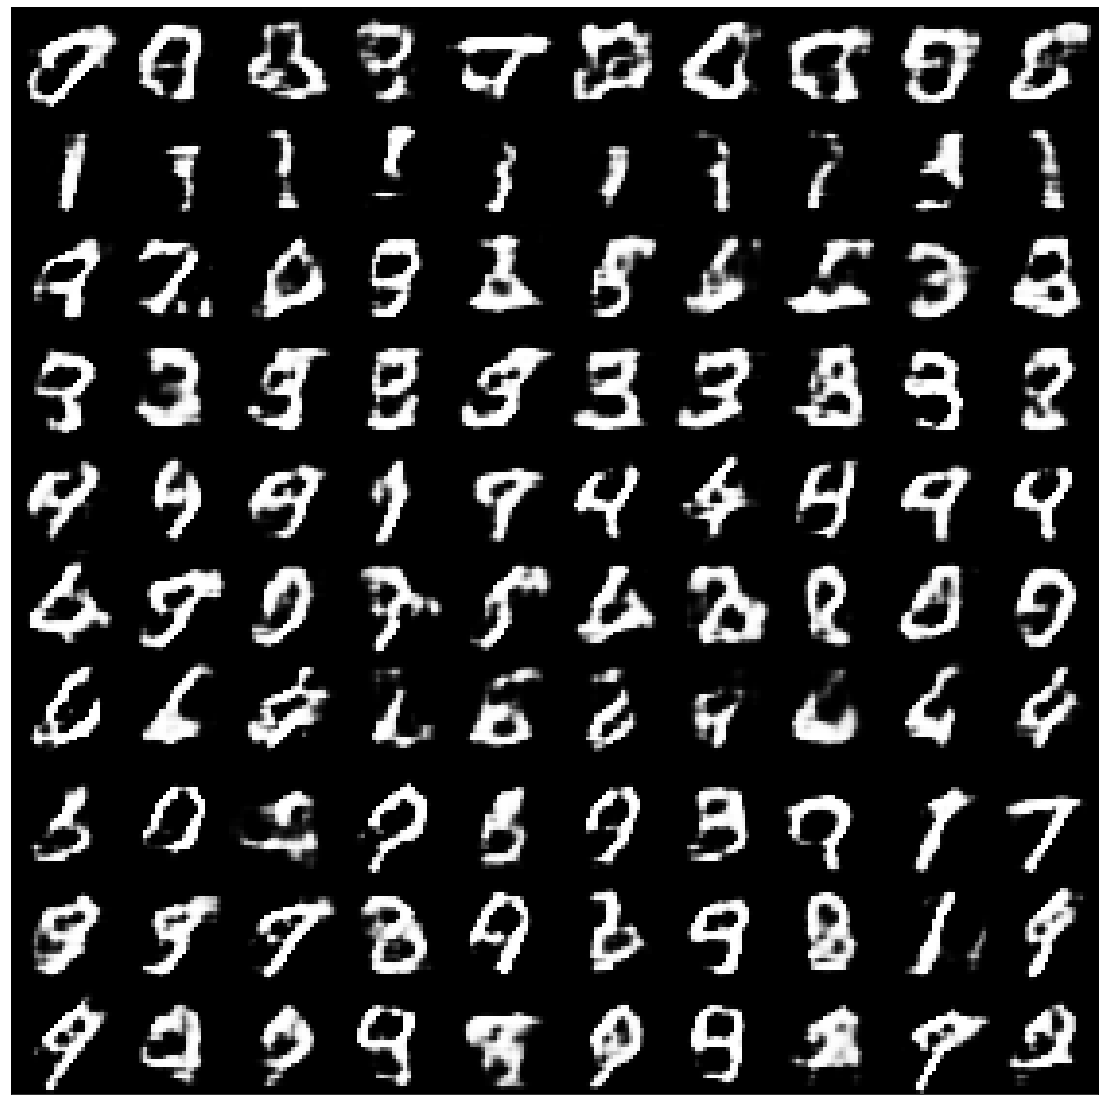

.l_d: 0.5650541186332703
.l_d: 0.502202033996582
.l_d: 0.5069088935852051
.l_d: 0.5228811502456665
.l_d: 0.5033183693885803
.l_d: 0.4795840382575989
.l_d: 0.5274707078933716
.l_d: 0.5545965433120728
.l_d: 0.5432313680648804
.l_d: 0.5153809785842896
.l_d: 0.5048384070396423
.l_d: 0.5788527727127075
.l_d: 0.4791414439678192
.l_d: 0.5262693166732788
.l_d: 0.5591769814491272
.l_d: 0.5450698137283325
.l_d: 0.5405611395835876
.l_d: 0.5555803775787354
.l_d: 0.525355875492096
.l_d: 0.4732516407966614
.l_d: 0.4840050935745239
.l_d: 0.5276098847389221
.l_d: 0.5013332366943359
.l_d: 0.5041828155517578
.l_d: 0.5422136783599854
.l_d: 0.5203225612640381
.l_d: 0.5135762691497803
.l_d: 0.5178308486938477
.l_d: 0.49072274565696716
.l_d: 0.5592758655548096
.l_d: 0.48862332105636597
.l_d: 0.5496945381164551
.l_d: 0.5413743853569031
.l_d: 0.5197095274925232
.l_d: 0.5518020987510681
.l_d: 0.5533356070518494
.l_d: 0.5484617948532104
.l_d: 0.5015290975570679
.l_d: 0.4555244445800781
.l_d: 0.518335223197937
.

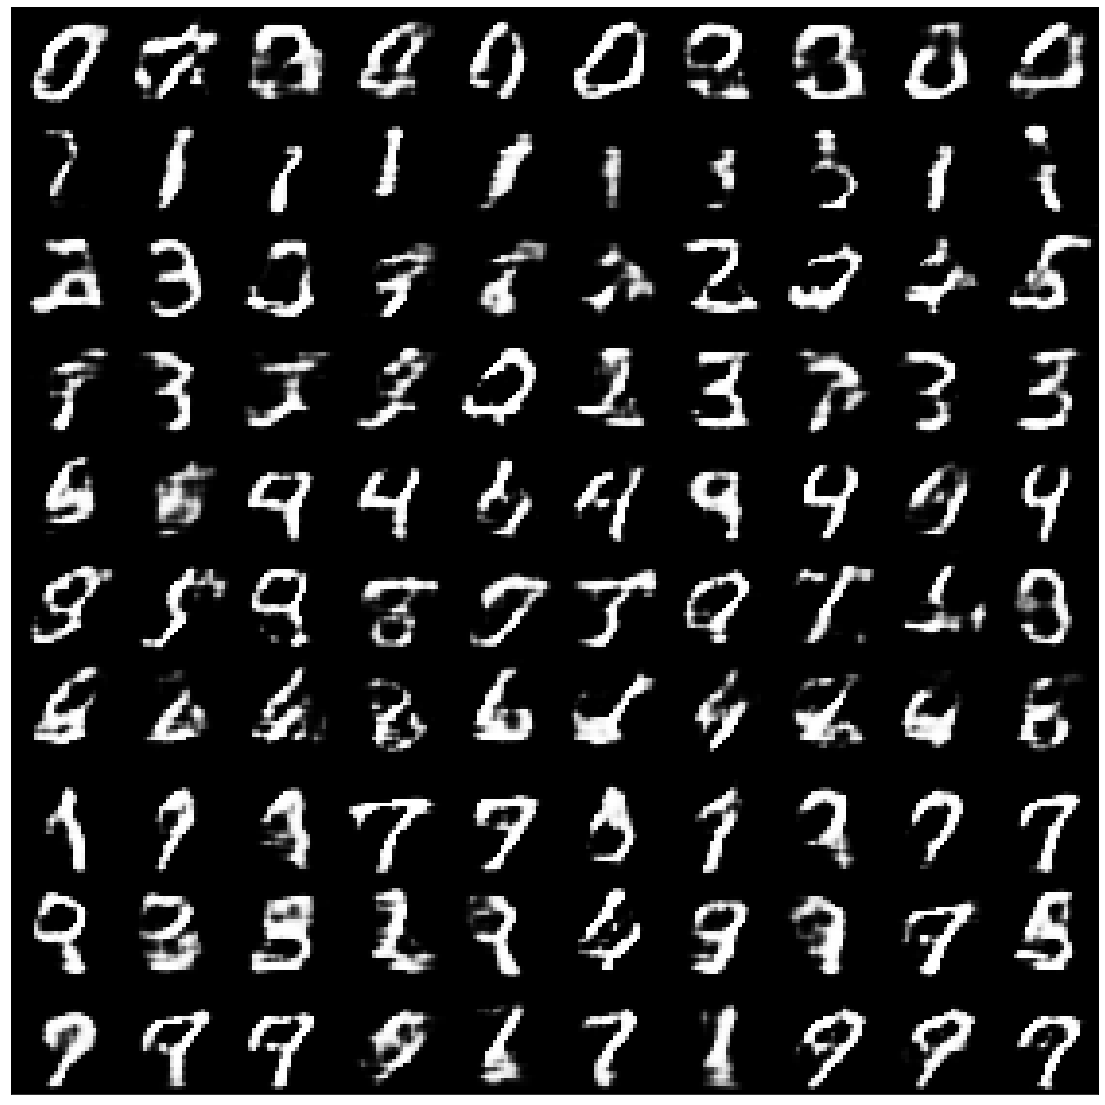

.l_d: 0.5612926483154297
.l_d: 0.5397407412528992
.l_d: 0.5393506288528442
.l_d: 0.5273480415344238
.l_d: 0.5317049026489258
.l_d: 0.541903555393219
.l_d: 0.5046605467796326
.l_d: 0.5299609303474426
.l_d: 0.5551753044128418
.l_d: 0.5189586877822876
.l_d: 0.5498254299163818
.l_d: 0.5057499408721924
.l_d: 0.495323121547699
.l_d: 0.5266678333282471
.l_d: 0.49914422631263733
.l_d: 0.5341914296150208
.l_d: 0.5564938187599182
.l_d: 0.5461359620094299
.l_d: 0.5018442869186401
.l_d: 0.481344997882843
.l_d: 0.504269540309906
.l_d: 0.5125676393508911
.l_d: 0.5064473748207092
.l_d: 0.4896779954433441
.l_d: 0.47482264041900635
.l_d: 0.5817668437957764
.l_d: 0.4900529980659485
.l_d: 0.5204653143882751
.l_d: 0.5081722736358643
.l_d: 0.513220489025116
.l_d: 0.5131088495254517
.l_d: 0.5101540088653564
.l_d: 0.52945476770401
.l_d: 0.4928692877292633
.l_d: 0.5466525554656982
.l_d: 0.47135868668556213
.l_d: 0.49947893619537354
.l_d: 0.5300419926643372
.l_d: 0.5209563970565796
.l_d: 0.4809280037879944
.l_

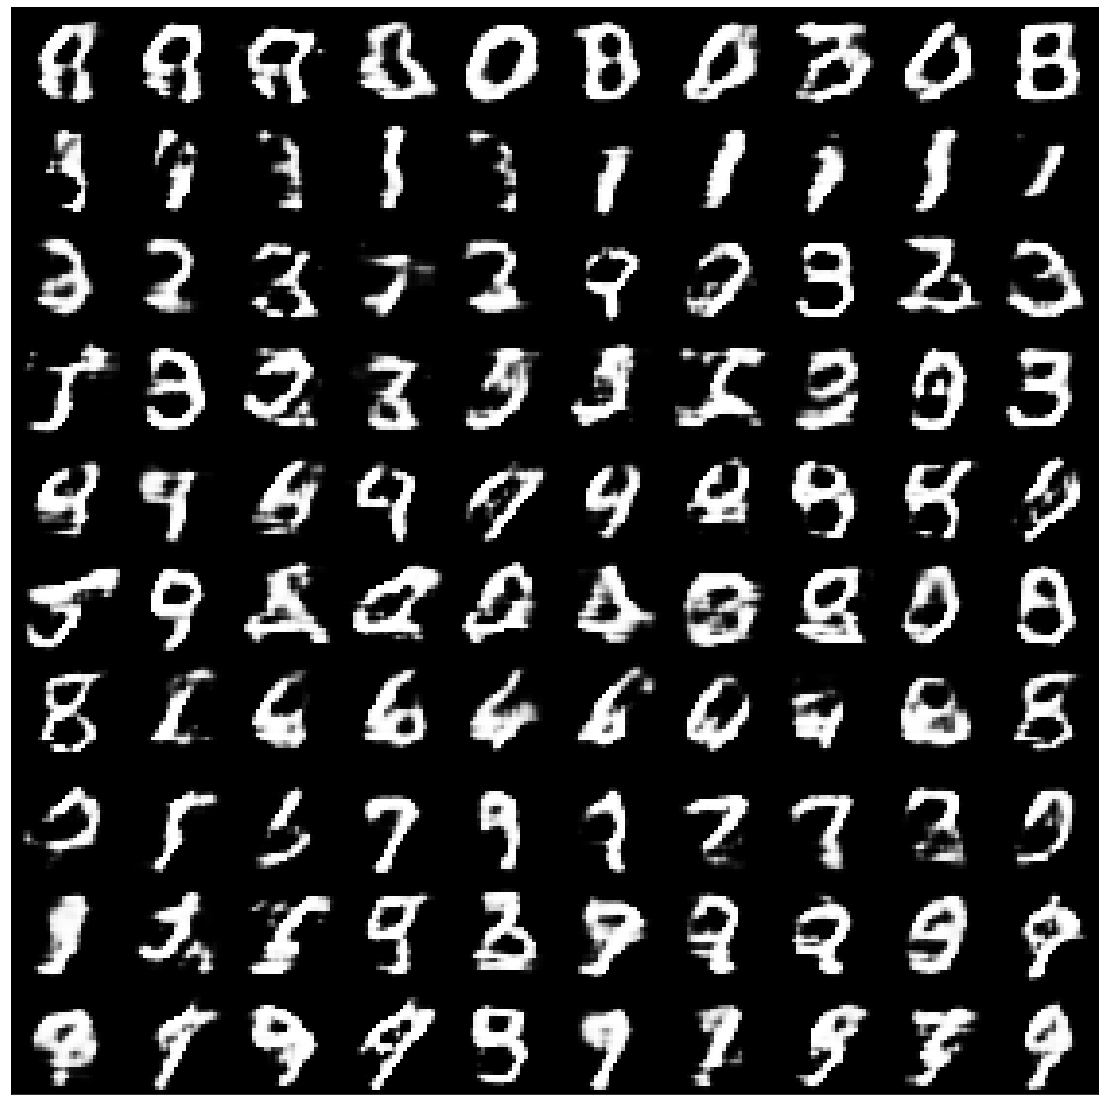

.l_d: 0.5450295209884644
.l_d: 0.5496346354484558
.l_d: 0.5110418796539307
.l_d: 0.5327638387680054
.l_d: 0.5496469140052795
.l_d: 0.5173472166061401
.l_d: 0.5133224129676819
.l_d: 0.48577120900154114
.l_d: 0.5184379816055298
.l_d: 0.5204623937606812
.l_d: 0.5561666488647461
.l_d: 0.5266420245170593
.l_d: 0.5164202451705933
.l_d: 0.5424501299858093
.l_d: 0.5302611589431763
.l_d: 0.555638313293457
.l_d: 0.5315883159637451
.l_d: 0.48074156045913696
.l_d: 0.48149892687797546
.l_d: 0.5333702564239502
.l_d: 0.46431732177734375
.l_d: 0.524547815322876
.l_d: 0.5418947339057922
.l_d: 0.5056401491165161
.l_d: 0.5457140207290649
.l_d: 0.5384036898612976
.l_d: 0.5457339286804199
.l_d: 0.49817535281181335
.l_d: 0.49328500032424927
.l_d: 0.5086995363235474
.l_d: 0.5161935091018677
.l_d: 0.5289874076843262
.l_d: 0.4794572591781616
.l_d: 0.5079929232597351
.l_d: 0.5191958546638489
.l_d: 0.5376940965652466
.l_d: 0.4917129576206207
.l_d: 0.5062262415885925
.l_d: 0.46026989817619324
.l_d: 0.444147825241

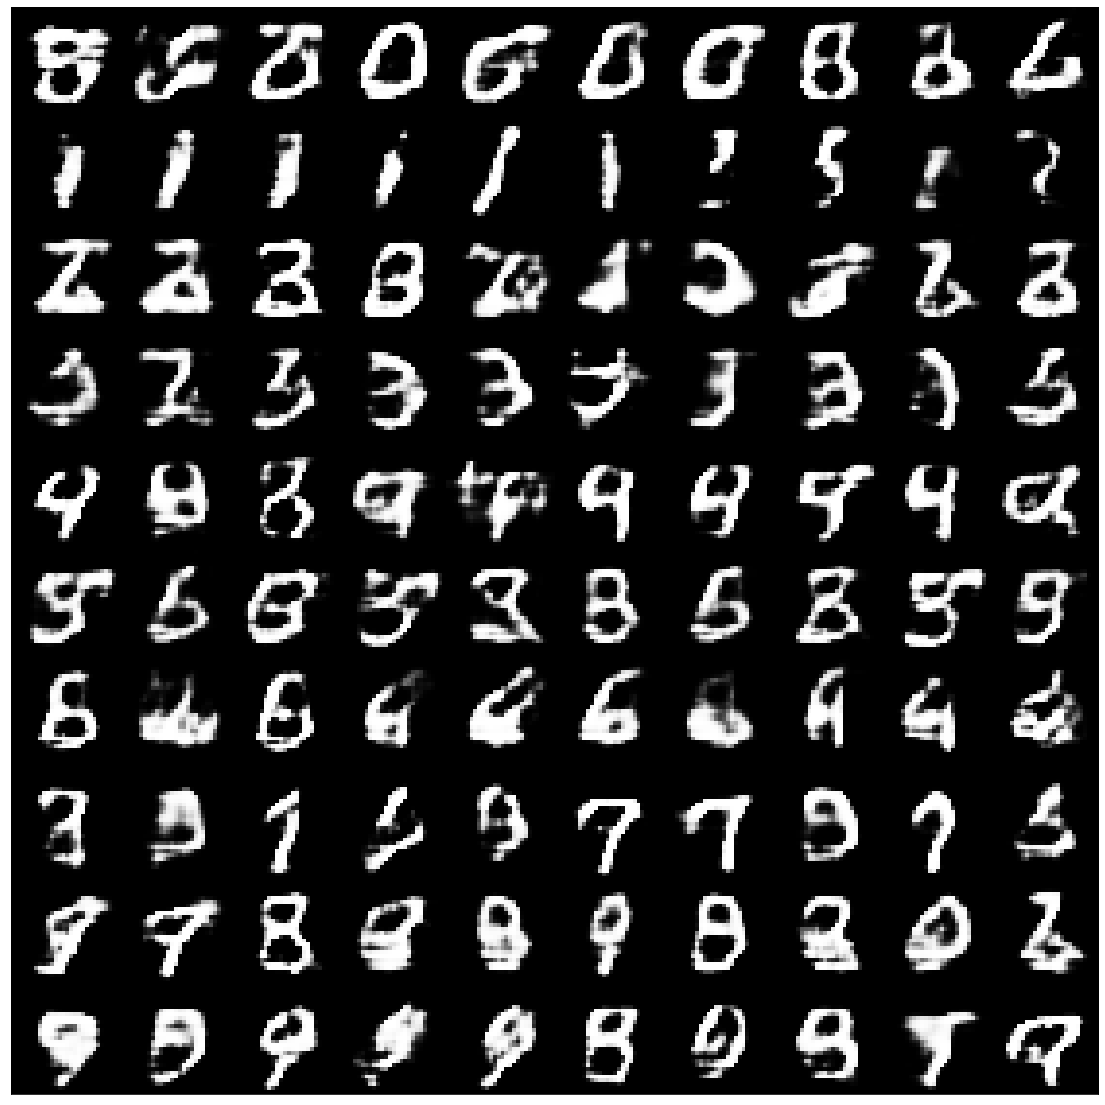

.l_d: 0.5307943820953369
.l_d: 0.5368489623069763
.l_d: 0.4996930956840515
.l_d: 0.5122177004814148
.l_d: 0.5254696011543274
.l_d: 0.5217301249504089
.l_d: 0.5241262316703796
.l_d: 0.530913233757019
.l_d: 0.530505895614624
.l_d: 0.5534520149230957
.l_d: 0.49993860721588135
.l_d: 0.5147569179534912
.l_d: 0.5123404264450073
.l_d: 0.5187674760818481
.l_d: 0.4719488322734833
.l_d: 0.5004856586456299
.l_d: 0.4835119843482971
.l_d: 0.49094581604003906
.l_d: 0.5184851884841919
.l_d: 0.48818060755729675
.l_d: 0.4857737421989441
.l_d: 0.5563867688179016
.l_d: 0.5423699021339417
.l_d: 0.5083286762237549
.l_d: 0.48095273971557617
.l_d: 0.5413795709609985
.l_d: 0.5599111318588257
.l_d: 0.5625900030136108
.l_d: 0.5094221234321594
.l_d: 0.5402902960777283
.l_d: 0.5174415111541748
.l_d: 0.456436425447464
.l_d: 0.510576605796814
.l_d: 0.4880606234073639
.l_d: 0.565188467502594
.l_d: 0.5090889930725098
.l_d: 0.49900293350219727
.l_d: 0.533505916595459
.l_d: 0.5023139715194702
.l_d: 0.482012540102005
.l

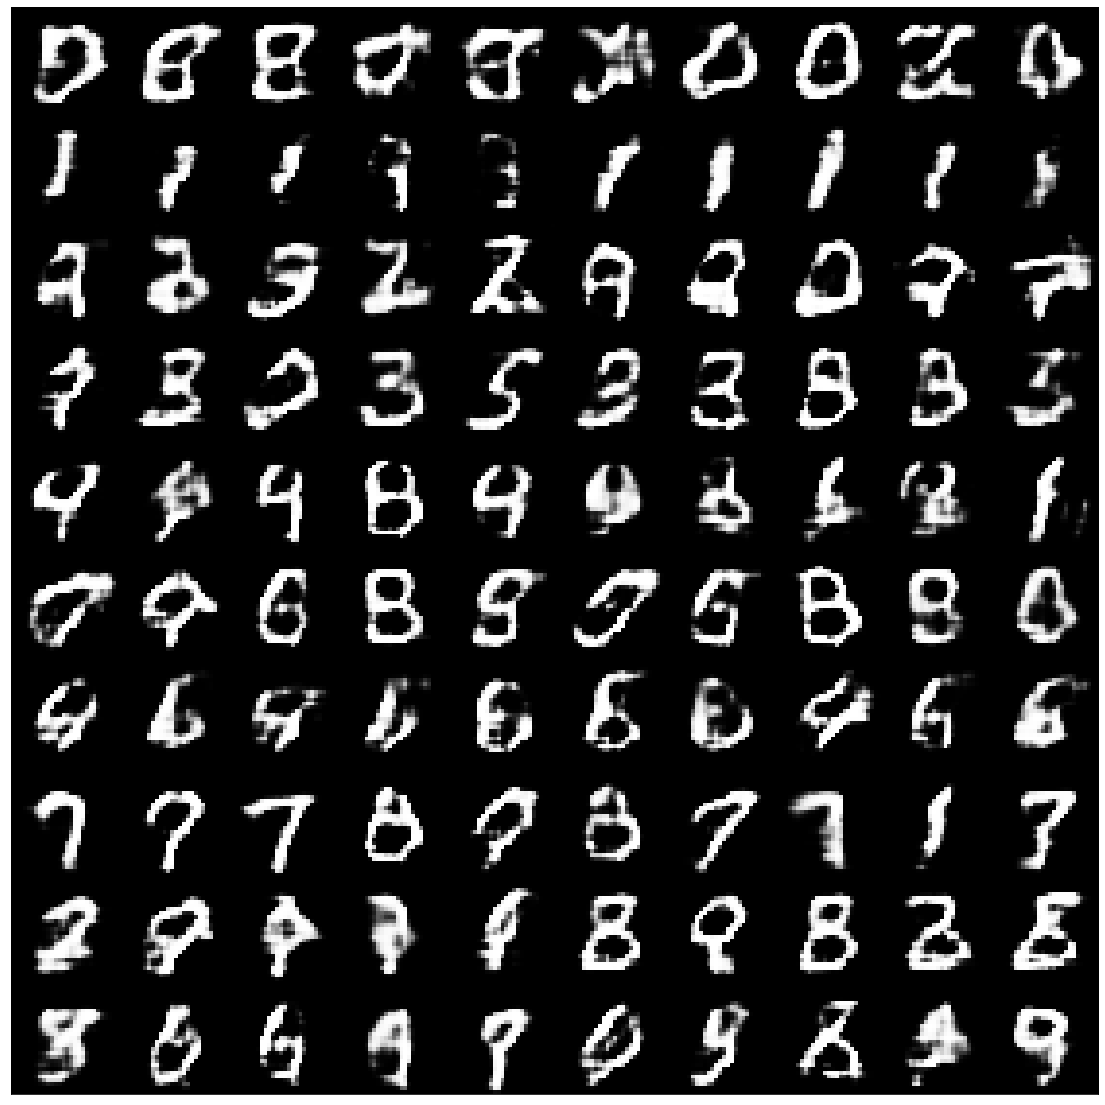

.l_d: 0.4869493842124939
.l_d: 0.5050543546676636
.l_d: 0.5751146078109741
.l_d: 0.5461811423301697
.l_d: 0.5573194622993469
.l_d: 0.523369312286377
.l_d: 0.4995501935482025
.l_d: 0.5554964542388916
.l_d: 0.5213004350662231
.l_d: 0.49341416358947754
.l_d: 0.5364875197410583
.l_d: 0.5040879249572754
.l_d: 0.5049195289611816
.l_d: 0.498710036277771
.l_d: 0.5453447103500366
.l_d: 0.5206298232078552
.l_d: 0.5287899374961853
.l_d: 0.5085239410400391
.l_d: 0.5765893459320068
.l_d: 0.5310647487640381
.l_d: 0.5072969198226929
.l_d: 0.5042964220046997
.l_d: 0.4989074766635895
.l_d: 0.5123443603515625
.l_d: 0.5132634043693542
.l_d: 0.47183817625045776
.l_d: 0.5175341963768005
.l_d: 0.5287318229675293
.l_d: 0.5554547905921936
.l_d: 0.5205247402191162
.l_d: 0.47882741689682007
.l_d: 0.5325331687927246
.l_d: 0.4926549792289734
.l_d: 0.5165354013442993
.l_d: 0.46403536200523376
.l_d: 0.4774630069732666
.l_d: 0.5113743543624878
.l_d: 0.5929012298583984
.l_d: 0.5248969793319702
.l_d: 0.508894443511962

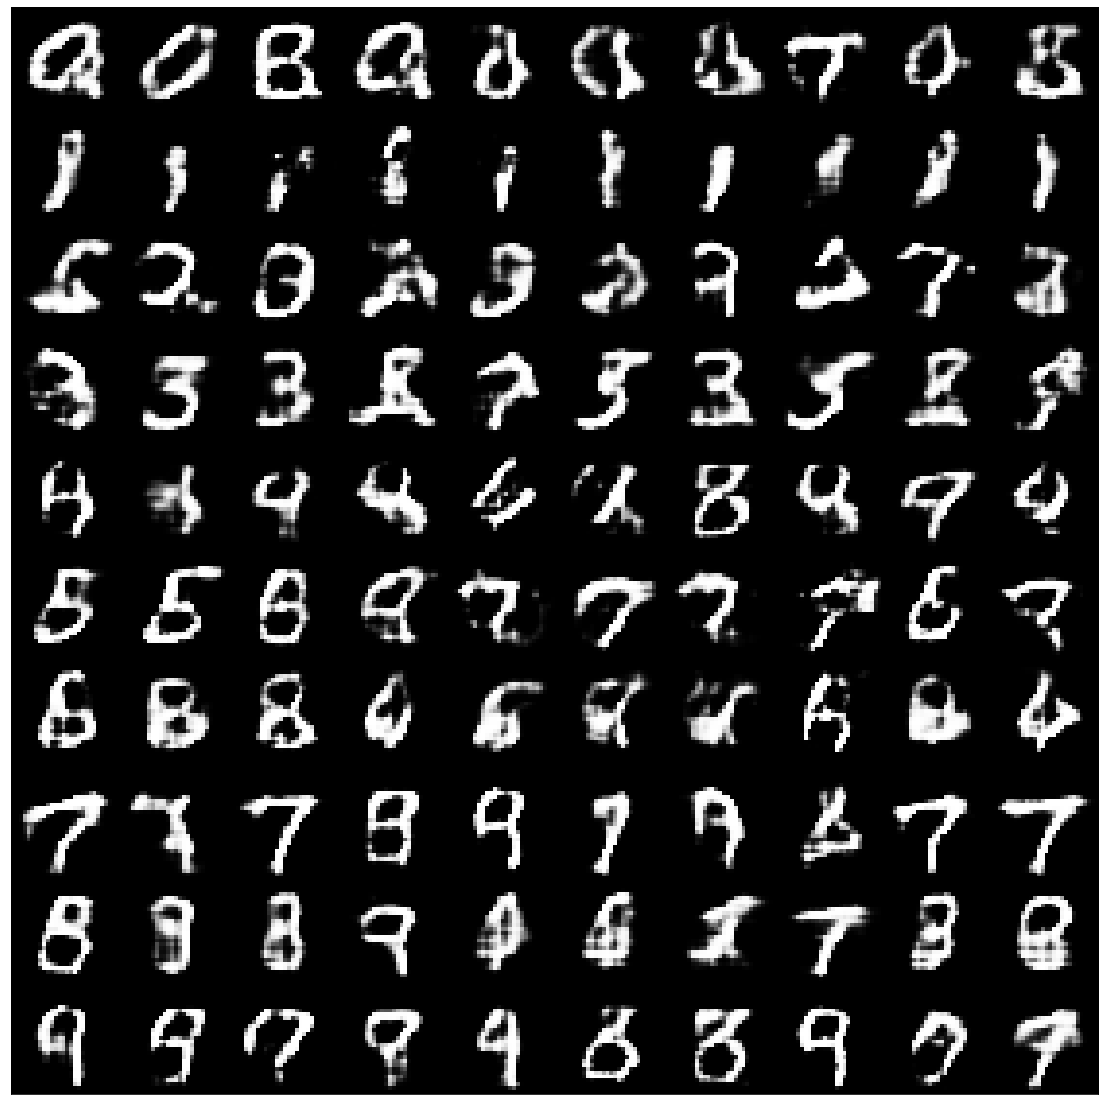

.l_d: 0.5440336465835571
.l_d: 0.5381299257278442
.l_d: 0.5435712337493896
.l_d: 0.5265276432037354
.l_d: 0.5091565847396851
.l_d: 0.4986606240272522
.l_d: 0.4932711124420166
.l_d: 0.4767782390117645
.l_d: 0.5083737373352051
.l_d: 0.45820558071136475
.l_d: 0.49175649881362915
.l_d: 0.5061608552932739
.l_d: 0.5108090043067932
.l_d: 0.5058241486549377
.l_d: 0.5083832740783691
.l_d: 0.5038751363754272
.l_d: 0.514272928237915
.l_d: 0.4793395698070526
.l_d: 0.5180612206459045
.l_d: 0.4898820221424103
.l_d: 0.5396851301193237
.l_d: 0.486749529838562
.l_d: 0.5482844114303589
.l_d: 0.4743014872074127
.l_d: 0.46811550855636597
.l_d: 0.4804514944553375
.l_d: 0.47009360790252686
.l_d: 0.4868646264076233
.l_d: 0.4536701440811157
.l_d: 0.48378080129623413
.l_d: 0.5084444284439087
.l_d: 0.5014790892601013
.l_d: 0.5302240252494812
.l_d: 0.4875034987926483
.l_d: 0.5444056391716003
.l_d: 0.5115249752998352
.l_d: 0.4839843511581421
.l_d: 0.4617733955383301
.l_d: 0.46576473116874695
.l_d: 0.5471132993698

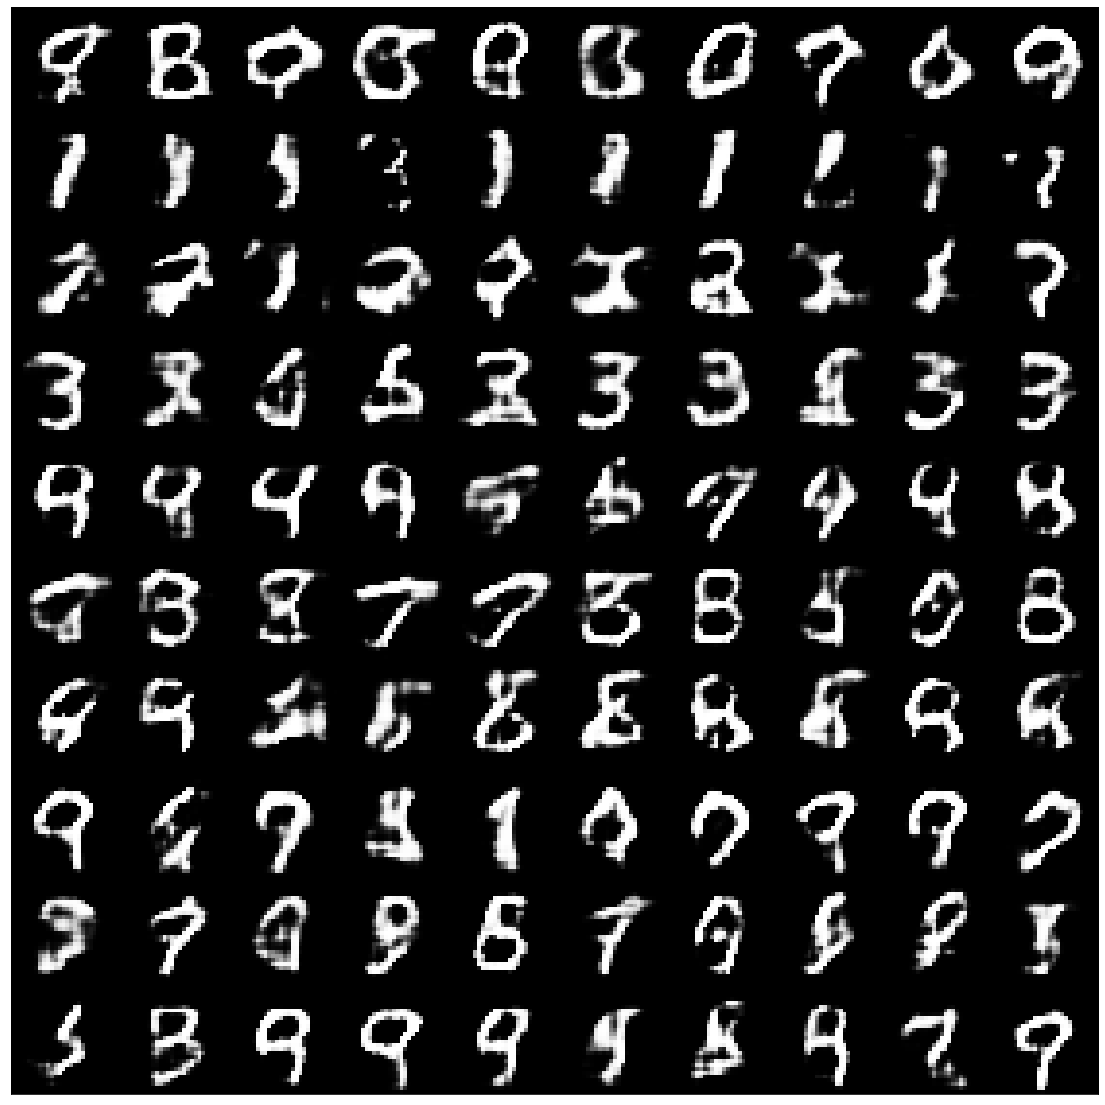

.l_d: 0.4579102396965027
.l_d: 0.47157350182533264
.l_d: 0.46726858615875244
.l_d: 0.5053839683532715
.l_d: 0.5022383332252502
.l_d: 0.47229552268981934
.l_d: 0.5296947956085205
.l_d: 0.5401235818862915
.l_d: 0.48023146390914917
.l_d: 0.5152736902236938
.l_d: 0.42693662643432617
.l_d: 0.5003964900970459
.l_d: 0.43087297677993774
.l_d: 0.46871668100357056
.l_d: 0.539954423904419
.l_d: 0.48825129866600037
.l_d: 0.4462723731994629
.l_d: 0.5175572037696838
.l_d: 0.4820024371147156
.l_d: 0.5231232047080994
.l_d: 0.48598936200141907
.l_d: 0.46280425786972046
.l_d: 0.49848365783691406
.l_d: 0.5267452597618103
.l_d: 0.4979383945465088
.l_d: 0.5183610320091248
.l_d: 0.49875861406326294
.l_d: 0.5274566411972046
.l_d: 0.510260820388794
.l_d: 0.4801023602485657
.l_d: 0.5143237113952637
.l_d: 0.4949886202812195
.l_d: 0.5013548135757446
.l_d: 0.4511321485042572
.l_d: 0.45643091201782227
.l_d: 0.5028305053710938
.l_d: 0.4460699260234833
.l_d: 0.4809560179710388
.l_d: 0.5099874138832092
.l_d: 0.503031

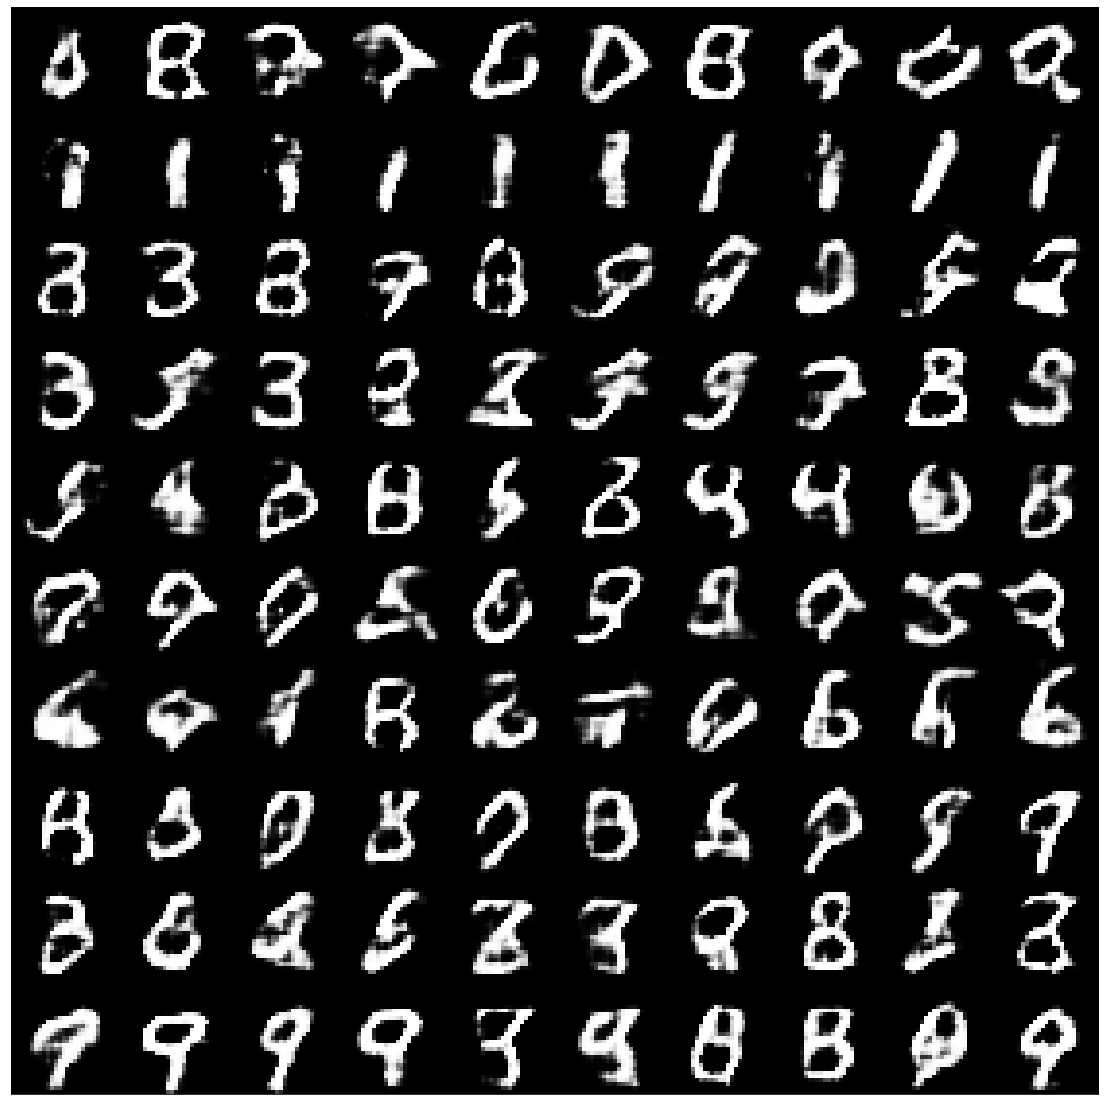

.l_d: 0.5063288807868958
.l_d: 0.4509415328502655
.l_d: 0.5177632570266724
.l_d: 0.5167450904846191
.l_d: 0.48195528984069824
.l_d: 0.4656063914299011
.l_d: 0.5089094042778015
.l_d: 0.5076395273208618
.l_d: 0.47864875197410583
.l_d: 0.48588210344314575
.l_d: 0.4788990914821625
.l_d: 0.4693957567214966
.l_d: 0.4752858281135559
.l_d: 0.4845488667488098
.l_d: 0.47596806287765503
.l_d: 0.45470207929611206
.l_d: 0.49100935459136963
.l_d: 0.48546624183654785
.l_d: 0.47419998049736023
.l_d: 0.4851219058036804
.l_d: 0.45663177967071533
.l_d: 0.5151644945144653
.l_d: 0.4572841227054596
.l_d: 0.47983789443969727
.l_d: 0.46914732456207275
.l_d: 0.5134643316268921
.l_d: 0.5818004012107849
.l_d: 0.44483980536460876
.l_d: 0.5042868256568909
.l_d: 0.44906312227249146
.l_d: 0.4417743980884552
.l_d: 0.47281911969184875
.l_d: 0.4759644567966461
.l_d: 0.4479593336582184
.l_d: 0.43573909997940063
.l_d: 0.463920533657074
.l_d: 0.45929962396621704
.l_d: 0.4728335440158844
.l_d: 0.456014484167099
.l_d: 0.516

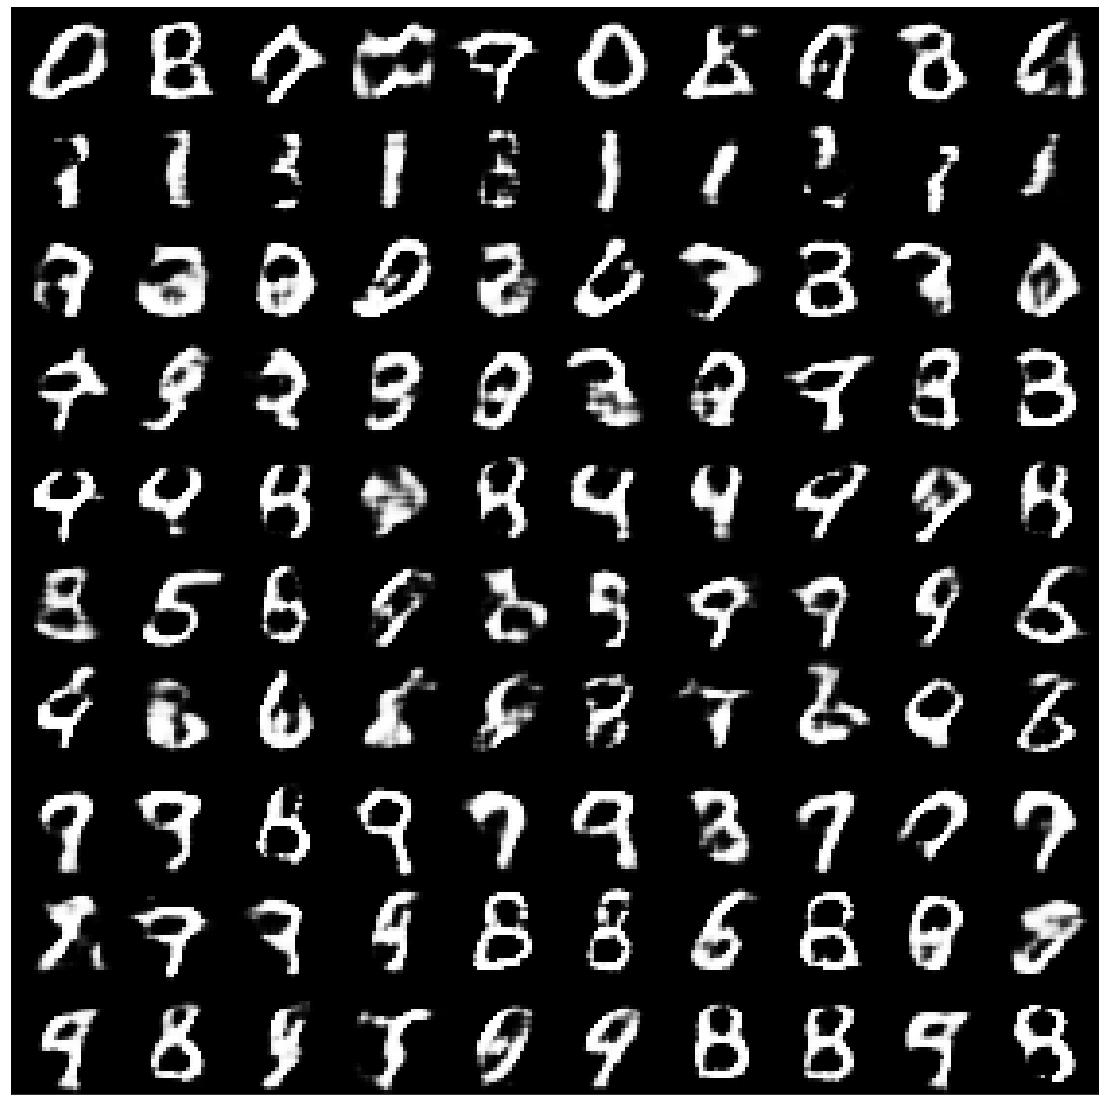

.l_d: 0.4772712290287018
.l_d: 0.4368950128555298
.l_d: 0.42918646335601807
.l_d: 0.45004695653915405
.l_d: 0.5024092197418213
.l_d: 0.43830323219299316
.l_d: 0.44765639305114746
.l_d: 0.4980064332485199
.l_d: 0.47593966126441956
.l_d: 0.4892737567424774
.l_d: 0.5630679130554199
.l_d: 0.5352104902267456
.l_d: 0.49942684173583984
.l_d: 0.45008376240730286
.l_d: 0.46691417694091797
.l_d: 0.4919266402721405
.l_d: 0.4662231504917145
.l_d: 0.49337637424468994
.l_d: 0.4479180574417114
.l_d: 0.5021499395370483
.l_d: 0.46664559841156006
.l_d: 0.44468995928764343
.l_d: 0.43891245126724243
.l_d: 0.45742785930633545
.l_d: 0.48863211274147034
.l_d: 0.44773393869400024
.l_d: 0.4844076633453369
.l_d: 0.46639102697372437
.l_d: 0.49594372510910034
.l_d: 0.4614905118942261
.l_d: 0.539546012878418
.l_d: 0.4866814613342285
.l_d: 0.46306484937667847
.l_d: 0.505609929561615
.l_d: 0.5302441716194153
.l_d: 0.49941718578338623
.l_d: 0.45878398418426514
.l_d: 0.446123331785202
.l_d: 0.47901612520217896
.l_d: 0

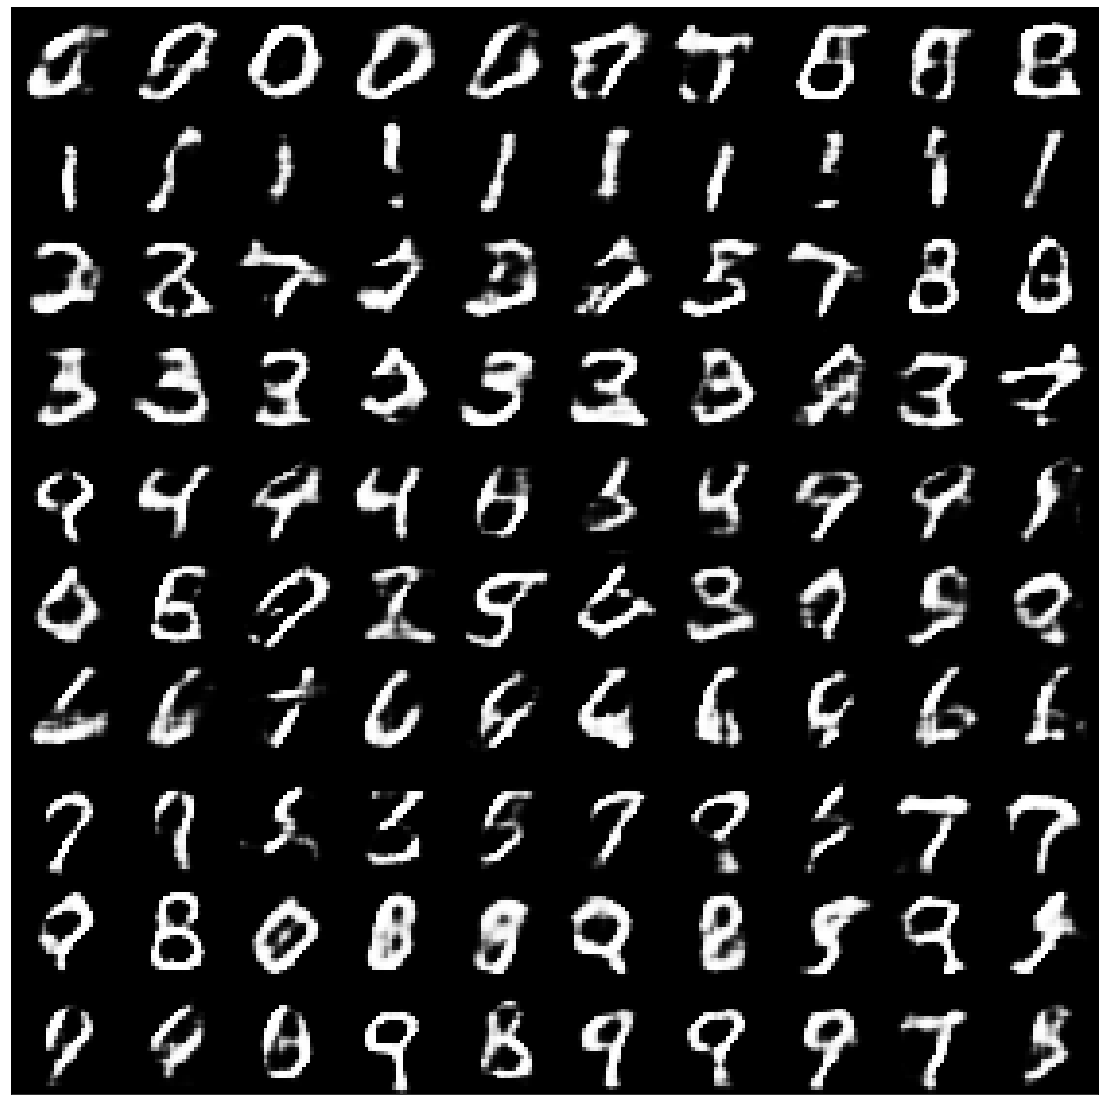

.l_d: 0.49285247921943665
.l_d: 0.5001975297927856
.l_d: 0.4553319811820984
.l_d: 0.4731437563896179
.l_d: 0.48367440700531006
.l_d: 0.4755437672138214
.l_d: 0.4437832534313202
.l_d: 0.46460628509521484
.l_d: 0.5020677447319031
.l_d: 0.4702182412147522
.l_d: 0.47508761286735535
.l_d: 0.47171899676322937
.l_d: 0.5070063471794128
.l_d: 0.5201937556266785
.l_d: 0.6001688241958618
.l_d: 0.5083534121513367
.l_d: 0.49800577759742737
.l_d: 0.5098702907562256
.l_d: 0.4994460344314575
.l_d: 0.46484842896461487
.l_d: 0.46346843242645264
.l_d: 0.4882718622684479
.l_d: 0.46408867835998535
.l_d: 0.4594205617904663
.l_d: 0.4947396516799927
.l_d: 0.4953655004501343
.l_d: 0.54520183801651
.l_d: 0.4838263988494873
.l_d: 0.5024921894073486
.l_d: 0.4966096580028534
.l_d: 0.46930748224258423
.l_d: 0.5559157729148865
.l_d: 0.5088877081871033
.l_d: 0.5100429058074951
.l_d: 0.47774726152420044
.l_d: 0.5046428442001343
.l_d: 0.5130893588066101
.l_d: 0.5146239995956421
.l_d: 0.4918292462825775
.l_d: 0.48080867

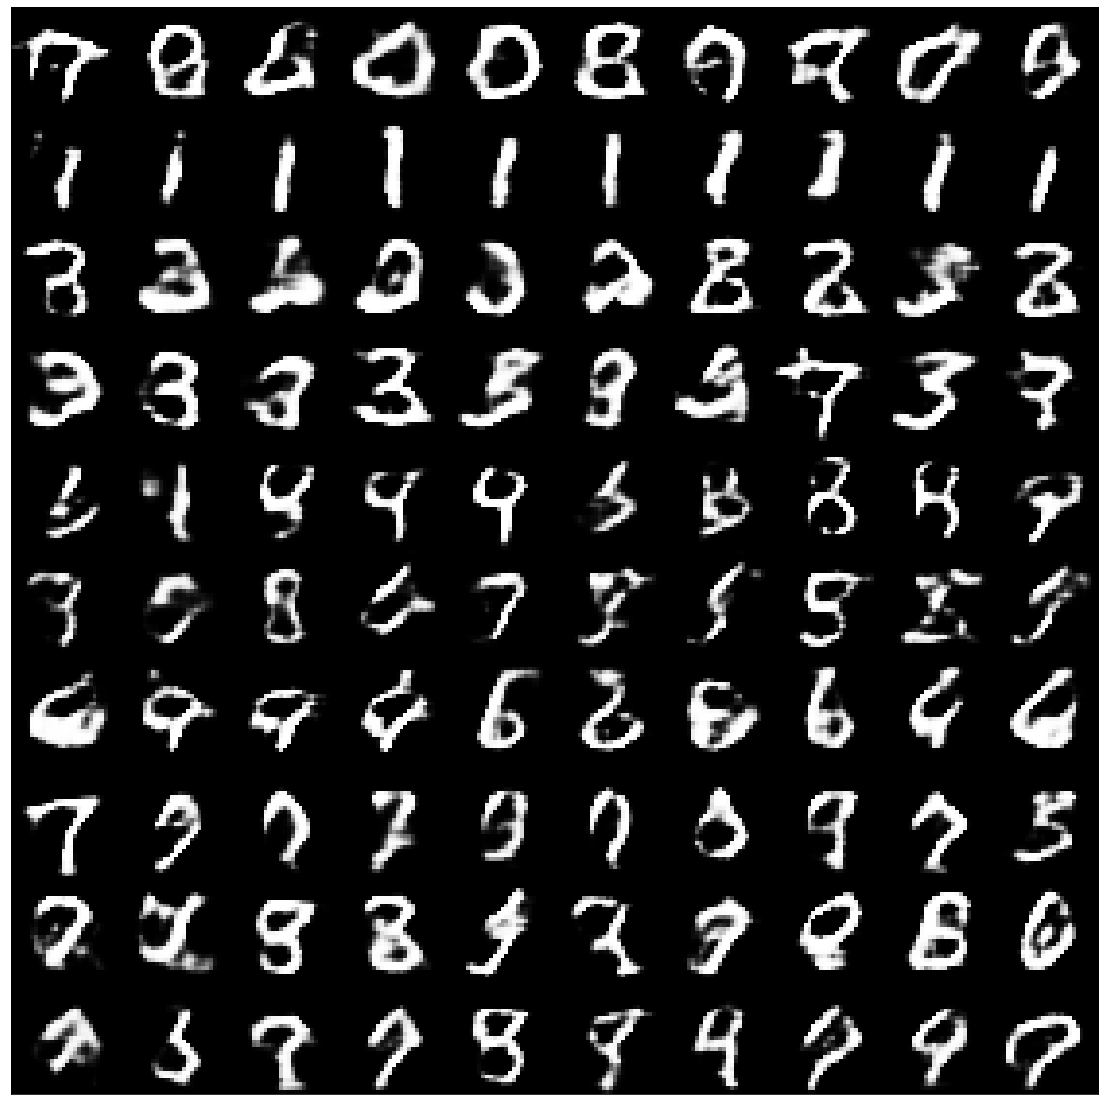

.l_d: 0.5339932441711426
.l_d: 0.48788025975227356
.l_d: 0.4764813780784607
.l_d: 0.5206483006477356
.l_d: 0.49324923753738403
.l_d: 0.5061473846435547
.l_d: 0.4920378625392914
.l_d: 0.4520998001098633
.l_d: 0.536526620388031
.l_d: 0.5031300783157349
.l_d: 0.5449984073638916
.l_d: 0.5502054691314697
.l_d: 0.4655257761478424
.l_d: 0.47942763566970825
.l_d: 0.43646422028541565
.l_d: 0.46366649866104126
.l_d: 0.479682981967926
.l_d: 0.5130118727684021
.l_d: 0.5230787992477417
.l_d: 0.4943873882293701
.l_d: 0.45993325114250183
.l_d: 0.48074060678482056
.l_d: 0.5089784264564514
.l_d: 0.45614883303642273
.l_d: 0.5215046405792236
.l_d: 0.4623650312423706
.l_d: 0.48997762799263
.l_d: 0.5107536315917969
.l_d: 0.5410862565040588
.l_d: 0.47353729605674744
.l_d: 0.49504995346069336
.l_d: 0.47327321767807007
.l_d: 0.545232892036438
.l_d: 0.5347413420677185
.l_d: 0.49588823318481445
.l_d: 0.4475409984588623
.l_d: 0.4328846335411072
.l_d: 0.46328046917915344
.l_d: 0.5068087577819824
.l_d: 0.497335016

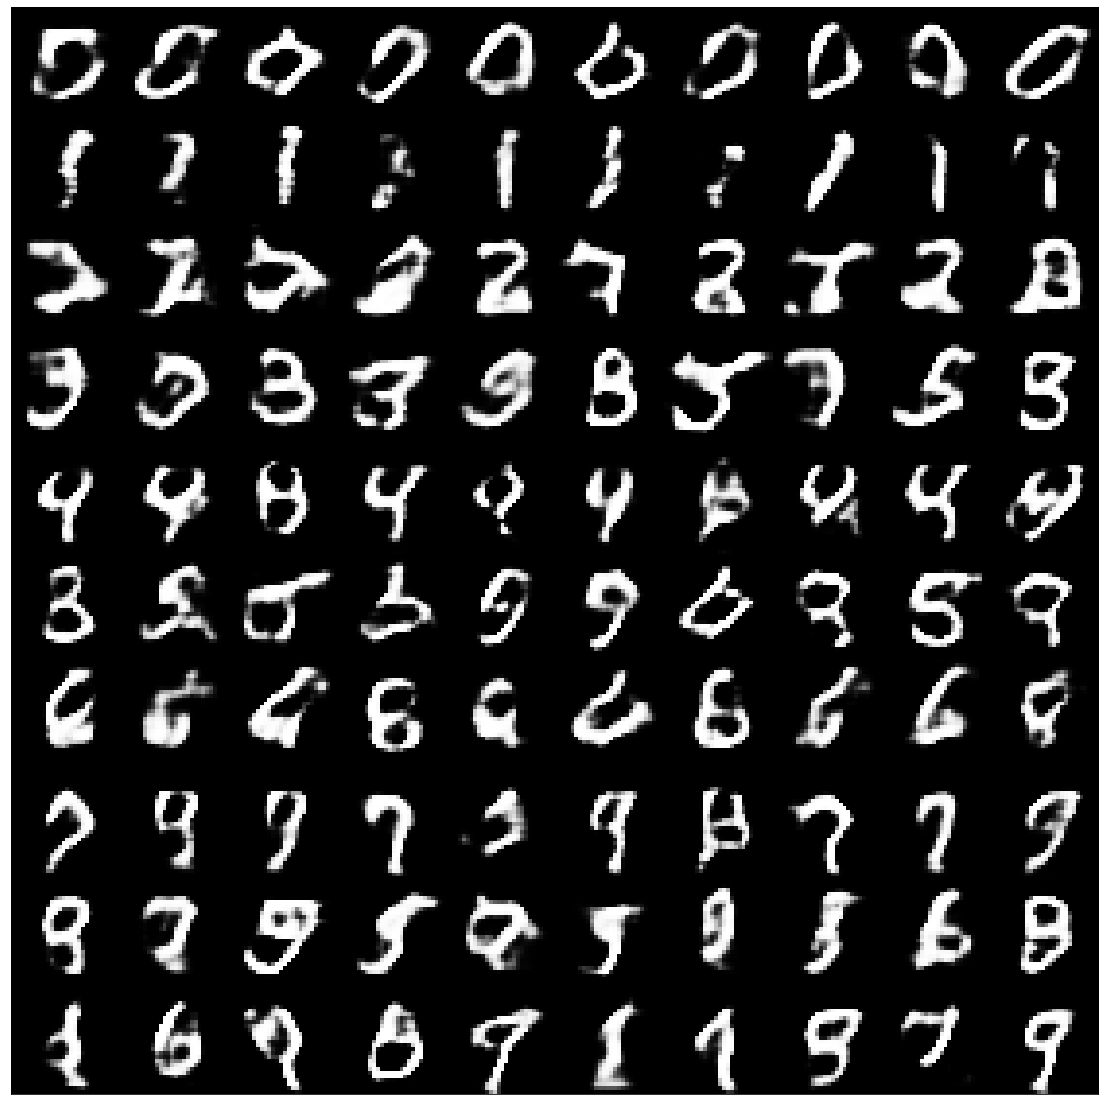

.l_d: 0.5288395881652832
.l_d: 0.5071120262145996
.l_d: 0.49553394317626953
.l_d: 0.4665876030921936
.l_d: 0.48657017946243286
.l_d: 0.5138095617294312
.l_d: 0.49675485491752625
.l_d: 0.5127754211425781
.l_d: 0.5185623168945312
.l_d: 0.46528226137161255
.l_d: 0.49096572399139404
.l_d: 0.48757046461105347
.l_d: 0.5128059983253479
.l_d: 0.48950886726379395
.l_d: 0.45998212695121765
.l_d: 0.46164461970329285
.l_d: 0.5033523440361023
.l_d: 0.5133407115936279
.l_d: 0.47739681601524353
.l_d: 0.5094661712646484
.l_d: 0.44497817754745483
.l_d: 0.4681200683116913
.l_d: 0.5413724184036255
.l_d: 0.5026854276657104
.l_d: 0.4735395312309265
.l_d: 0.5288885235786438
.l_d: 0.538790225982666
.l_d: 0.4617852568626404
.l_d: 0.48293814063072205
.l_d: 0.5141294598579407
.l_d: 0.44741055369377136
.l_d: 0.4827589690685272
.l_d: 0.448100209236145
.l_d: 0.41176608204841614
.l_d: 0.44092464447021484
.l_d: 0.49938222765922546
.l_d: 0.47653424739837646
.l_d: 0.48946613073349
.l_d: 0.5012179613113403
.l_d: 0.5423

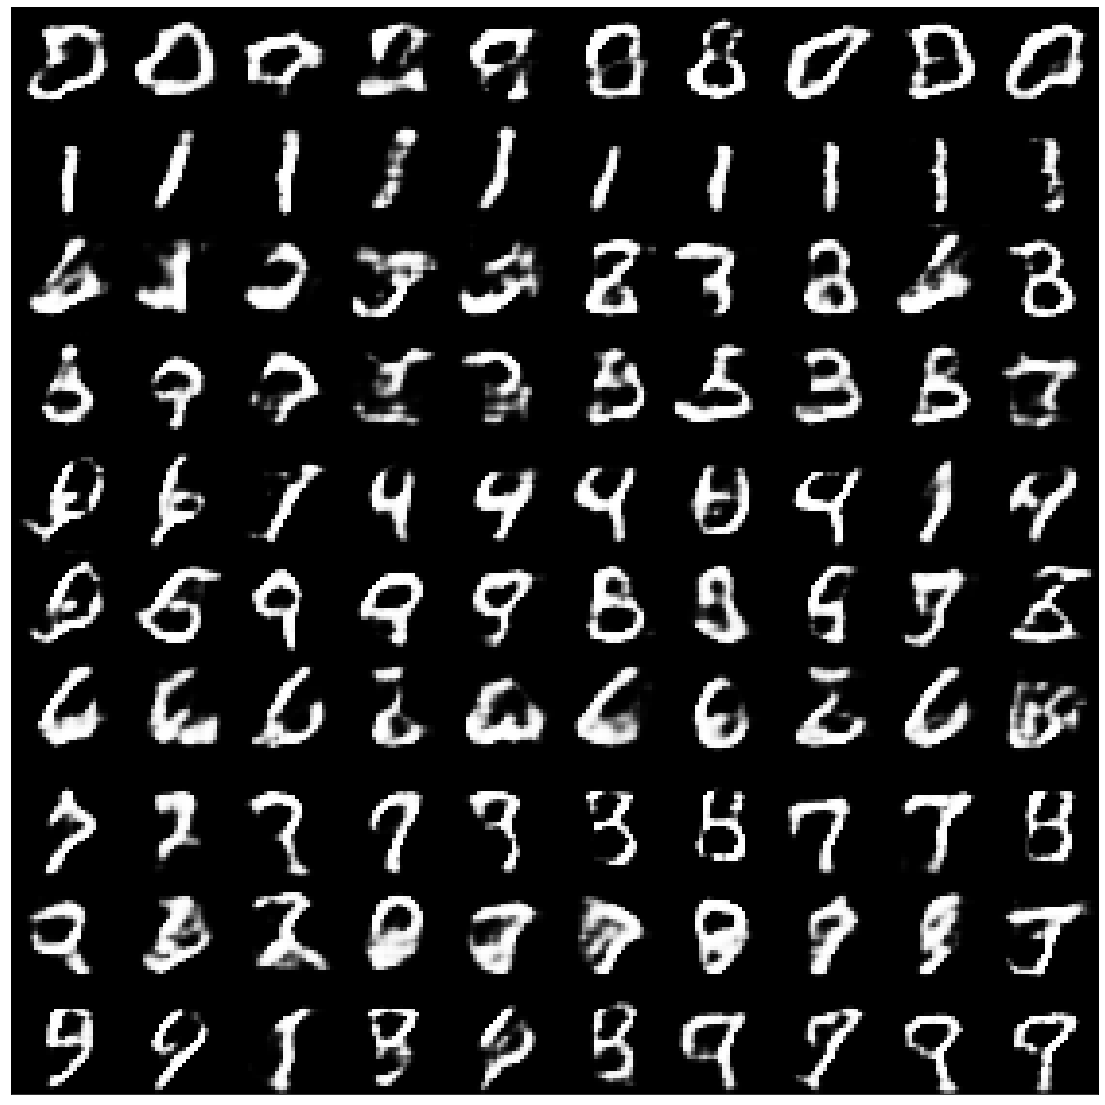

.l_d: 0.41802021861076355
.l_d: 0.4936905801296234
.l_d: 0.5103427171707153
.l_d: 0.4789629280567169
.l_d: 0.4871973395347595
.l_d: 0.49491995573043823
.l_d: 0.47215527296066284
.l_d: 0.4944818615913391
.l_d: 0.454730749130249
.l_d: 0.5002263784408569
.l_d: 0.5081709623336792
.l_d: 0.5365623235702515
.l_d: 0.49717047810554504
.l_d: 0.5073431730270386
.l_d: 0.4665142297744751
.l_d: 0.4311288297176361
.l_d: 0.48943430185317993
.l_d: 0.4857771396636963
.l_d: 0.4392072856426239
.l_d: 0.4890677034854889
.l_d: 0.46675580739974976
.l_d: 0.4726341962814331
.l_d: 0.4791916608810425
.l_d: 0.46920138597488403
.l_d: 0.5387425422668457
.l_d: 0.5053096413612366
.l_d: 0.4837483763694763
.l_d: 0.5518431067466736
.l_d: 0.5046901106834412
.l_d: 0.4778730273246765
.l_d: 0.5220261812210083
.l_d: 0.448152631521225
.l_d: 0.49850380420684814
.l_d: 0.4768162667751312
.l_d: 0.4705142378807068
.l_d: 0.501275897026062
.l_d: 0.419392853975296
.l_d: 0.43182986974716187
.l_d: 0.49008169770240784
.l_d: 0.46996146440

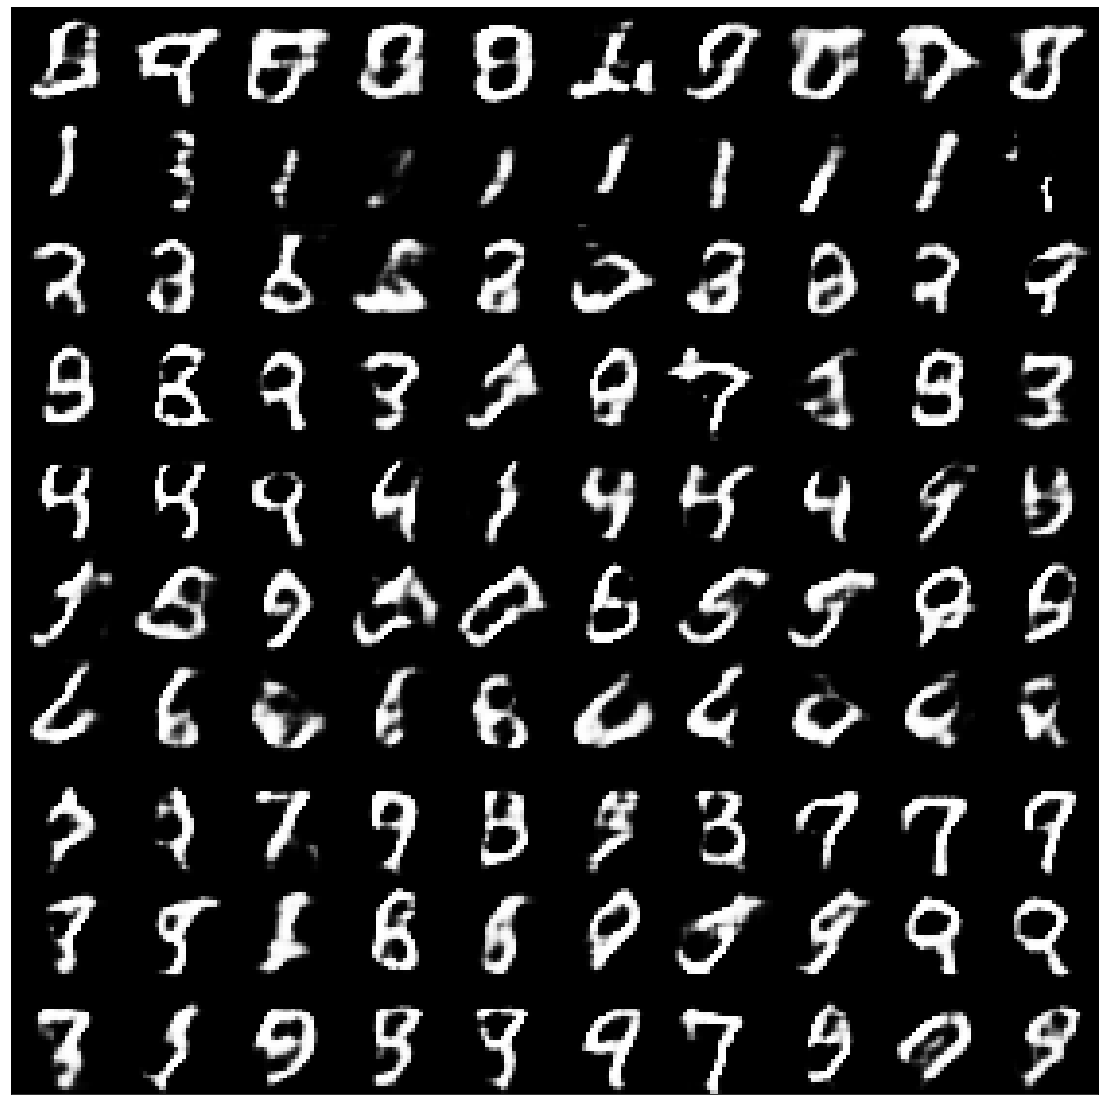

.l_d: 0.4724491536617279
.l_d: 0.47905486822128296
.l_d: 0.4445110857486725
.l_d: 0.49194034934043884
.l_d: 0.46616947650909424
.l_d: 0.48435646295547485
.l_d: 0.4924515187740326
.l_d: 0.46667546033859253
.l_d: 0.44762465357780457
.l_d: 0.4766809046268463
.l_d: 0.5150210857391357
.l_d: 0.5310136675834656
.l_d: 0.4835067391395569
.l_d: 0.49512970447540283
.l_d: 0.5414764881134033
.l_d: 0.4557723104953766
.l_d: 0.4642990231513977
.l_d: 0.47695401310920715
.l_d: 0.4897727966308594
.l_d: 0.5173152685165405
.l_d: 0.4913542866706848
.l_d: 0.5019295811653137
.l_d: 0.5051409602165222
.l_d: 0.5074959993362427
.l_d: 0.48940372467041016
.l_d: 0.41162338852882385
.l_d: 0.4444125294685364
.l_d: 0.4910833239555359
.l_d: 0.44092127680778503
.l_d: 0.4894539713859558
.l_d: 0.48000234365463257
.l_d: 0.48457634449005127
.l_d: 0.4762212038040161
.l_d: 0.47867584228515625
.l_d: 0.4970581531524658
.l_d: 0.520876944065094
.l_d: 0.525448203086853
.l_d: 0.4681795835494995
.l_d: 0.4492344856262207
.l_d: 0.46768

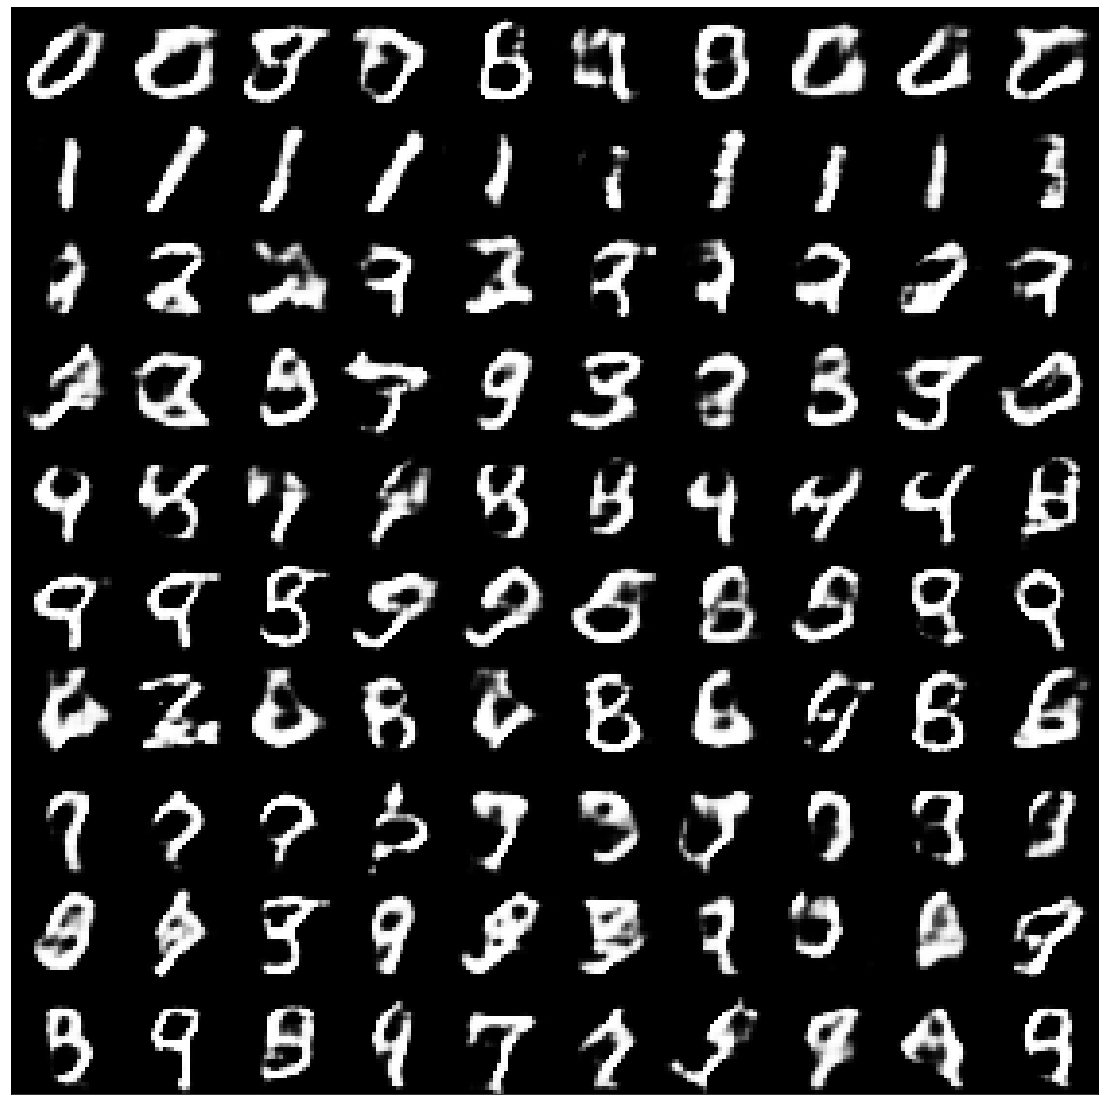

.l_d: 0.5179247856140137
.l_d: 0.4885149300098419
.l_d: 0.49214884638786316
.l_d: 0.5224555134773254
.l_d: 0.5089552402496338
.l_d: 0.4761187732219696
.l_d: 0.5168324708938599
.l_d: 0.4926876127719879
.l_d: 0.43335938453674316
.l_d: 0.4544554054737091
.l_d: 0.44550448656082153
.l_d: 0.4884052872657776
.l_d: 0.45839014649391174
.l_d: 0.47790437936782837
.l_d: 0.5023964643478394
.l_d: 0.5093363523483276
.l_d: 0.4303576648235321
.l_d: 0.5128812789916992
.l_d: 0.42651358246803284
.l_d: 0.4506761133670807
.l_d: 0.47580215334892273
.l_d: 0.4816751778125763
.l_d: 0.5284361839294434
.l_d: 0.45017048716545105
.l_d: 0.4824468493461609
.l_d: 0.5009695291519165
.l_d: 0.47568070888519287
.l_d: 0.43313172459602356
.l_d: 0.46490249037742615
.l_d: 0.531872034072876
.l_d: 0.467606782913208
.l_d: 0.5582221150398254
.l_d: 0.5238653421401978
.l_d: 0.46708443760871887
.l_d: 0.44251689314842224
.l_d: 0.43047893047332764
.l_d: 0.4328392744064331
.l_d: 0.46855029463768005
.l_d: 0.47867506742477417
.l_d: 0.470

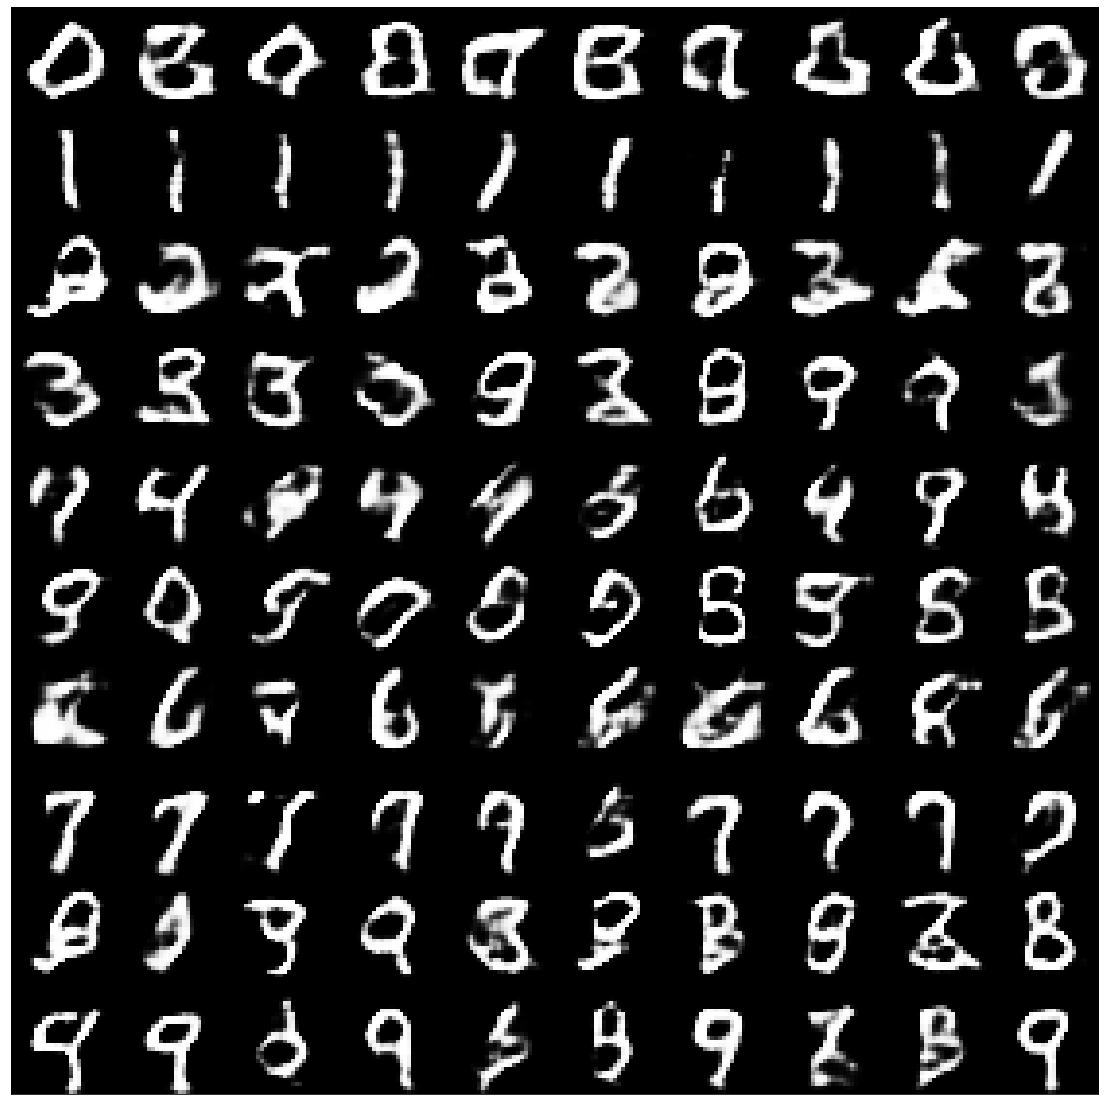

.l_d: 0.40976548194885254
.l_d: 0.47687944769859314
.l_d: 0.45161521434783936
.l_d: 0.4450235962867737
.l_d: 0.5033157467842102
.l_d: 0.47779327630996704
.l_d: 0.41533464193344116
.l_d: 0.47247228026390076
.l_d: 0.4593544602394104
.l_d: 0.5154509544372559
.l_d: 0.4022045135498047
.l_d: 0.46361109614372253
.l_d: 0.4654965102672577
.l_d: 0.4474203884601593
.l_d: 0.4694960117340088
.l_d: 0.5344748497009277
.l_d: 0.492387056350708
.l_d: 0.4175145626068115
.l_d: 0.46935006976127625
.l_d: 0.4937441647052765
.l_d: 0.44321227073669434
.l_d: 0.5209289193153381
.l_d: 0.47339606285095215
.l_d: 0.46088606119155884
.l_d: 0.4818064868450165
.l_d: 0.4317263662815094
.l_d: 0.4118051528930664
.l_d: 0.52503502368927
.l_d: 0.4750893712043762
.l_d: 0.48310840129852295
.l_d: 0.5151525735855103
.l_d: 0.5723637938499451
.l_d: 0.5099337697029114
.l_d: 0.48927849531173706
.l_d: 0.4666282534599304
.l_d: 0.40687835216522217
.l_d: 0.48508167266845703
.l_d: 0.45602571964263916
.l_d: 0.48982611298561096
.l_d: 0.457

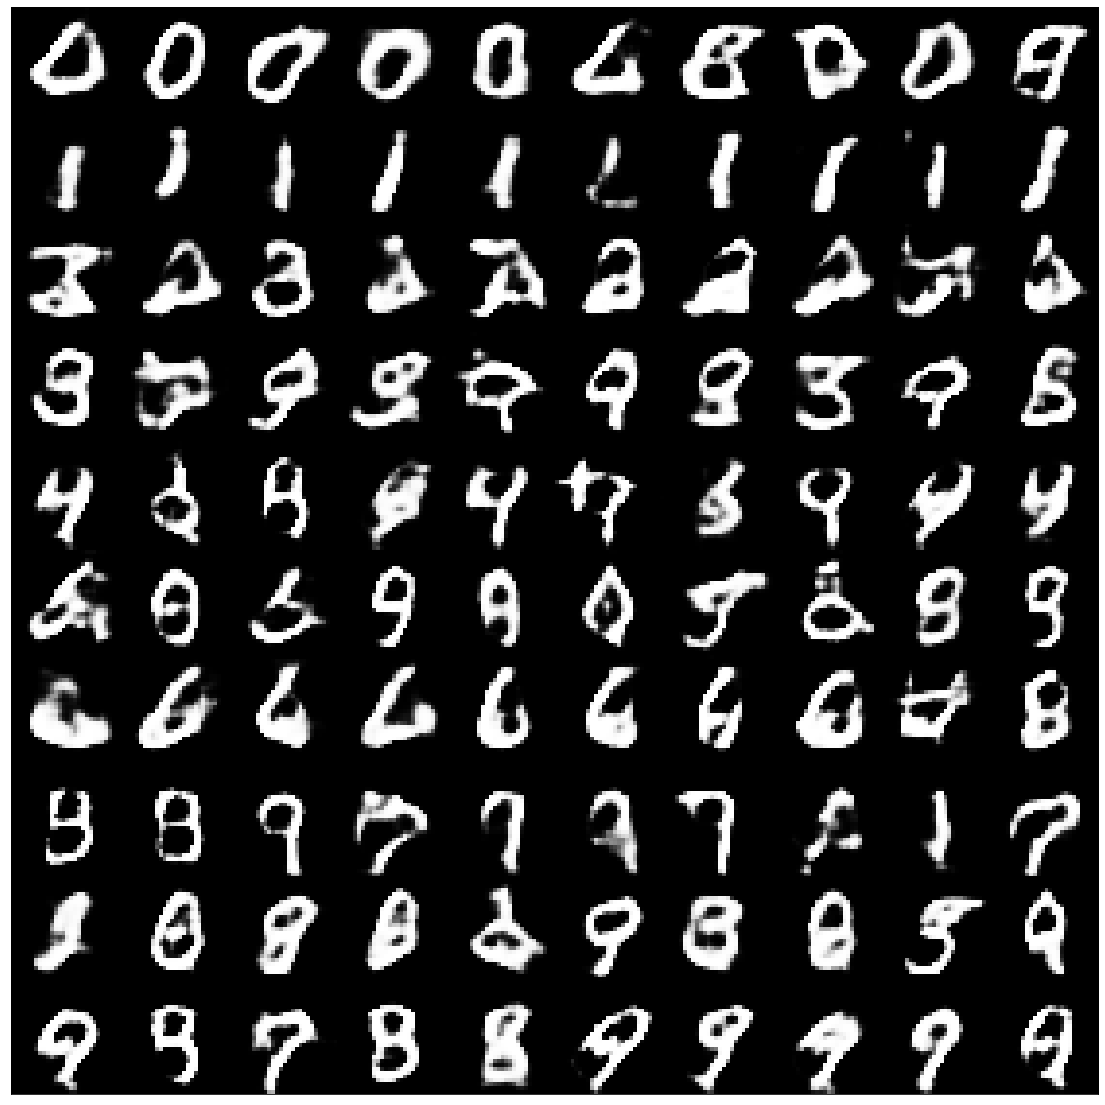

.l_d: 0.44284236431121826
.l_d: 0.5353153944015503
.l_d: 0.484600692987442
.l_d: 0.48284614086151123
.l_d: 0.5801539421081543
.l_d: 0.48931875824928284
.l_d: 0.4781261086463928
.l_d: 0.43865466117858887
.l_d: 0.48734143376350403
.l_d: 0.5039581060409546
.l_d: 0.47921961545944214
.l_d: 0.449543833732605
.l_d: 0.4446275532245636
.l_d: 0.43689554929733276
.l_d: 0.5092730522155762
.l_d: 0.4928109645843506
.l_d: 0.5224335789680481
.l_d: 0.477142333984375
.l_d: 0.4953509569168091
.l_d: 0.566626250743866
.l_d: 0.5070992708206177
.l_d: 0.47574520111083984
.l_d: 0.5200819969177246
.l_d: 0.4507414698600769
.l_d: 0.5223492383956909
.l_d: 0.5091251134872437
.l_d: 0.4823572635650635
.l_d: 0.49941450357437134
.l_d: 0.45939886569976807
.l_d: 0.4221338927745819
.l_d: 0.49547648429870605
.l_d: 0.4488982558250427
.l_d: 0.43525856733322144
.l_d: 0.5233562588691711
.l_d: 0.47743797302246094
.l_d: 0.44284123182296753
.l_d: 0.5281963348388672
.l_d: 0.4632871448993683
.l_d: 0.5850845575332642
.l_d: 0.5952294

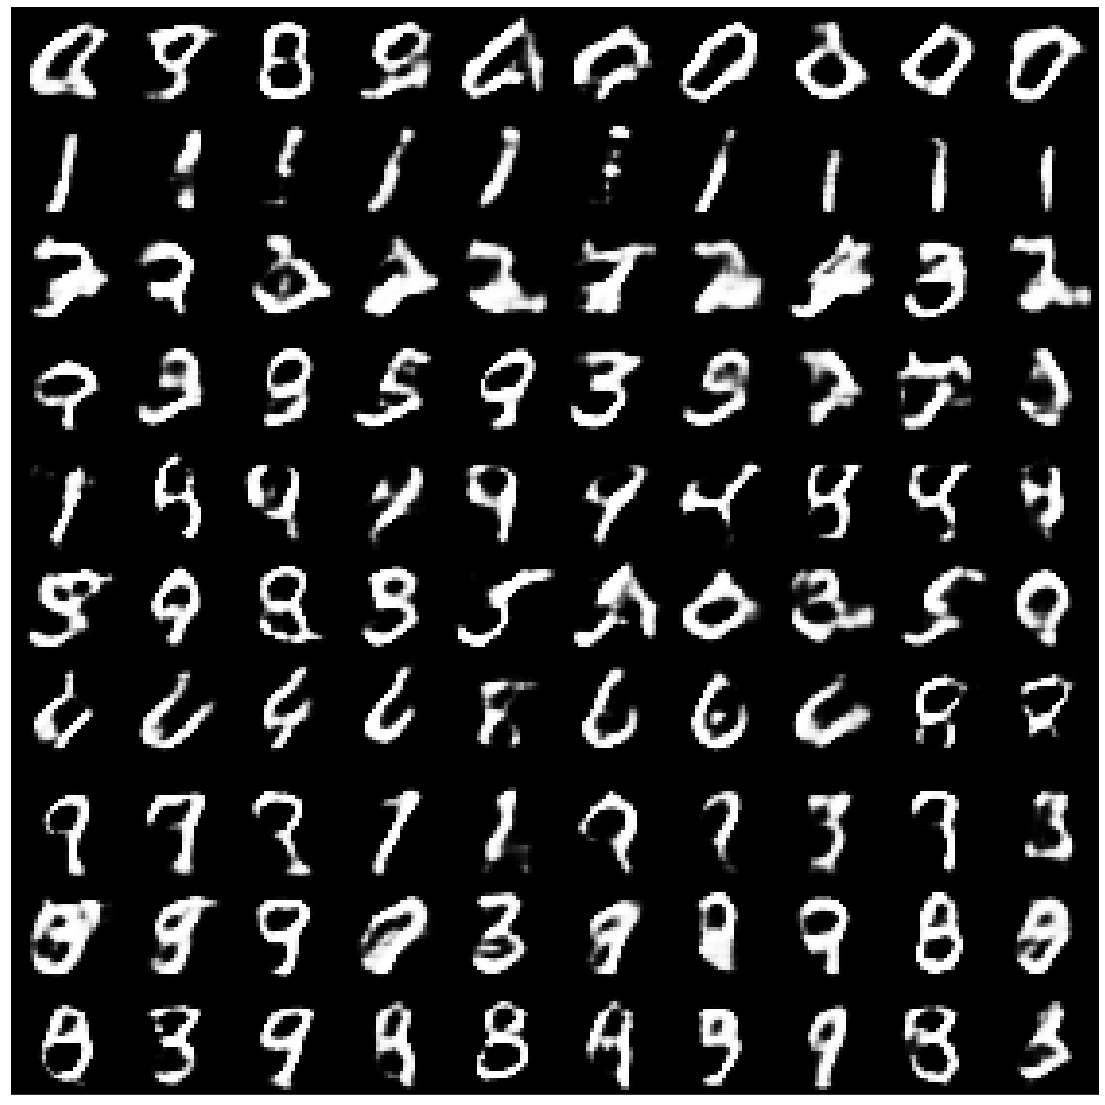

.l_d: 0.4342009127140045
.l_d: 0.45763739943504333
.l_d: 0.4934471845626831
.l_d: 0.46163007616996765
.l_d: 0.4785909056663513
.l_d: 0.5128704309463501
.l_d: 0.48273131251335144
.l_d: 0.44844332337379456
.l_d: 0.48336920142173767
.l_d: 0.4570760726928711
.l_d: 0.48461252450942993
.l_d: 0.5317365527153015
.l_d: 0.41647639870643616
.l_d: 0.43747374415397644
.l_d: 0.4882919192314148
.l_d: 0.5432517528533936
.l_d: 0.44218167662620544
.l_d: 0.4170674681663513
.l_d: 0.550987720489502
.l_d: 0.4973573088645935
.l_d: 0.4979306757450104
.l_d: 0.48734647035598755
.l_d: 0.4731364846229553
.l_d: 0.4337145686149597
.l_d: 0.45746302604675293
.l_d: 0.4798484444618225
.l_d: 0.5541558265686035
.l_d: 0.5202314853668213
.l_d: 0.46594083309173584
.l_d: 0.5164197087287903
.l_d: 0.5783786773681641
.l_d: 0.473372220993042
.l_d: 0.4739625155925751
.l_d: 0.45376694202423096
.l_d: 0.484025776386261
.l_d: 0.5129169821739197
.l_d: 0.43796661496162415
.l_d: 0.46519047021865845
.l_d: 0.46681320667266846
.l_d: 0.4888

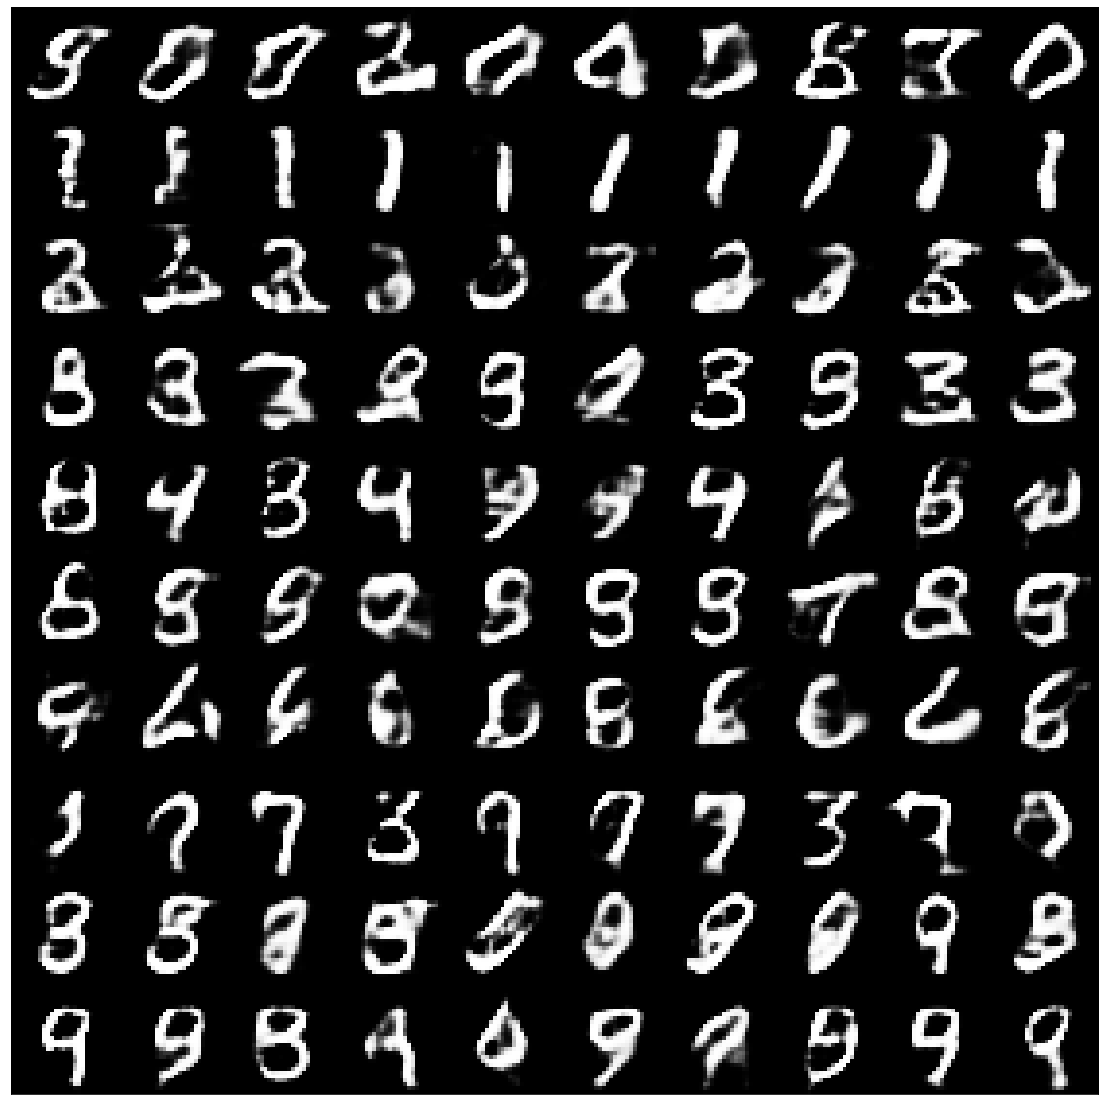

.l_d: 0.5245141983032227
.l_d: 0.49736106395721436
.l_d: 0.4547678828239441
.l_d: 0.483466774225235
.l_d: 0.4534219205379486
.l_d: 0.43883880972862244
.l_d: 0.5052329897880554
.l_d: 0.5459388494491577
.l_d: 0.4460113048553467
.l_d: 0.49164721369743347
.l_d: 0.4195963442325592
.l_d: 0.4572092890739441
.l_d: 0.44572004675865173
.l_d: 0.46244165301322937
.l_d: 0.4839538335800171
.l_d: 0.43418341875076294
.l_d: 0.5351517200469971
.l_d: 0.4818536341190338
.l_d: 0.5477101802825928
.l_d: 0.508519172668457
.l_d: 0.5144008994102478
.l_d: 0.5138781070709229
.l_d: 0.48454147577285767
.l_d: 0.4528866112232208
.l_d: 0.48034030199050903
.l_d: 0.4085276424884796
.l_d: 0.509452223777771
.l_d: 0.4633394479751587
.l_d: 0.49974262714385986
.l_d: 0.4664321839809418
.l_d: 0.48346686363220215
.l_d: 0.5126602649688721
.l_d: 0.5453143119812012
.l_d: 0.5190597772598267
.l_d: 0.5174479484558105
.l_d: 0.4931829571723938
.l_d: 0.44195887446403503
.l_d: 0.48576170206069946
.l_d: 0.5052515268325806
.l_d: 0.42250123

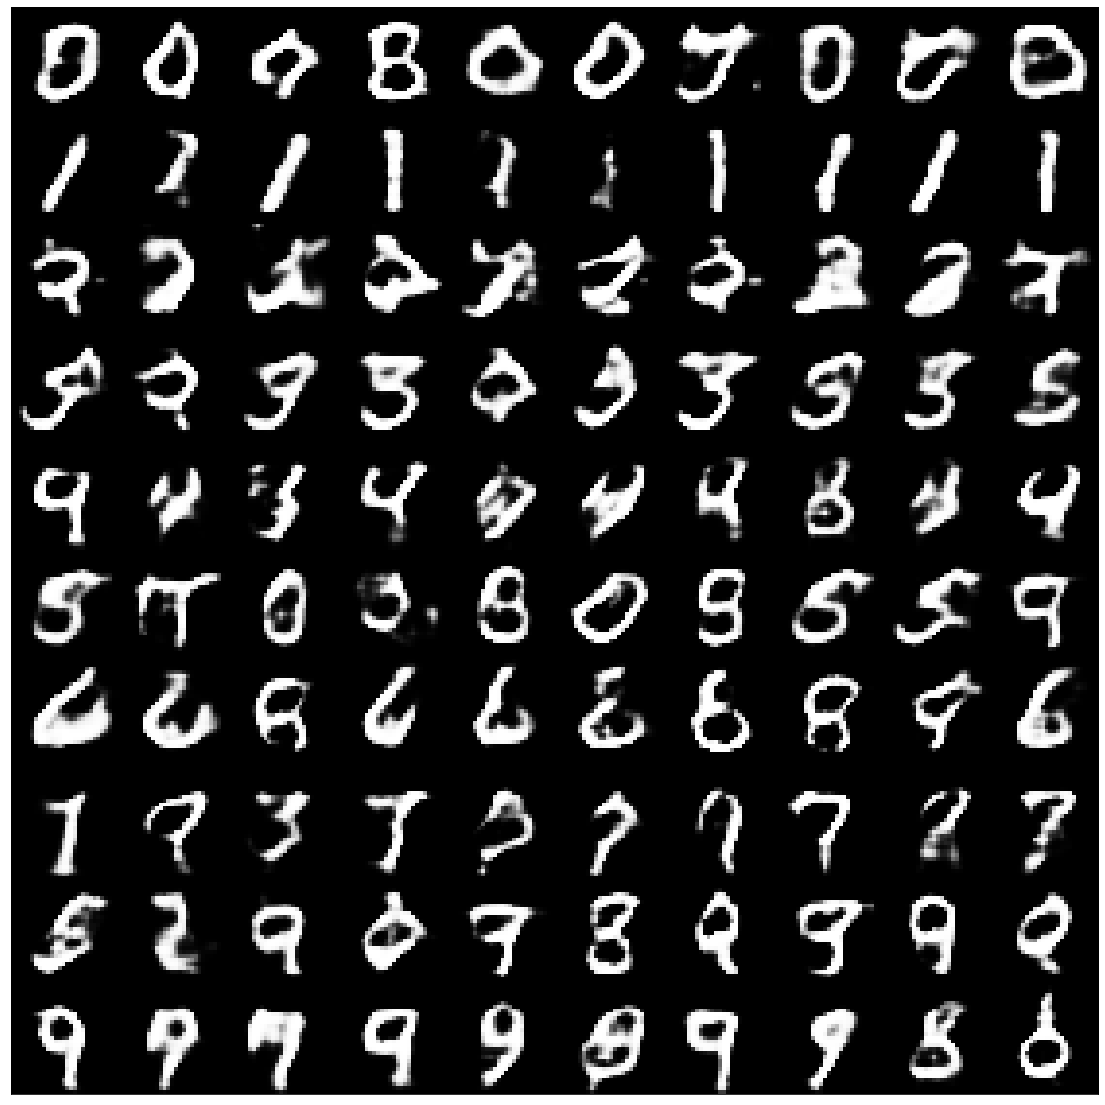

.l_d: 0.4639602601528168
.l_d: 0.4248173236846924
.l_d: 0.5179343819618225
.l_d: 0.526102602481842
.l_d: 0.505088210105896
.l_d: 0.5150274038314819
.l_d: 0.5455130338668823
.l_d: 0.4446486234664917
.l_d: 0.5439110994338989
.l_d: 0.5785584449768066
.l_d: 0.4173567295074463
.l_d: 0.4600638449192047
.l_d: 0.5784388780593872
.l_d: 0.4746733009815216
.l_d: 0.4462991952896118
.l_d: 0.5250781774520874
.l_d: 0.41544294357299805
.l_d: 0.4609696567058563
.l_d: 0.4319920539855957
.l_d: 0.48077380657196045
.l_d: 0.5560959577560425
.l_d: 0.4665178954601288
.l_d: 0.518312931060791
.l_d: 0.45617157220840454
.l_d: 0.4748644530773163
.l_d: 0.5217915773391724
.l_d: 0.48755475878715515
.l_d: 0.5052860379219055
.l_d: 0.4340716600418091
.l_d: 0.48800384998321533
.l_d: 0.41980957984924316
.l_d: 0.43130552768707275
.l_d: 0.4252837002277374
.l_d: 0.4802229404449463
.l_d: 0.4498547911643982
.l_d: 0.5015319585800171
.l_d: 0.5049569606781006
.l_d: 0.465349018573761
.l_d: 0.4769231677055359
.l_d: 0.48361268639564

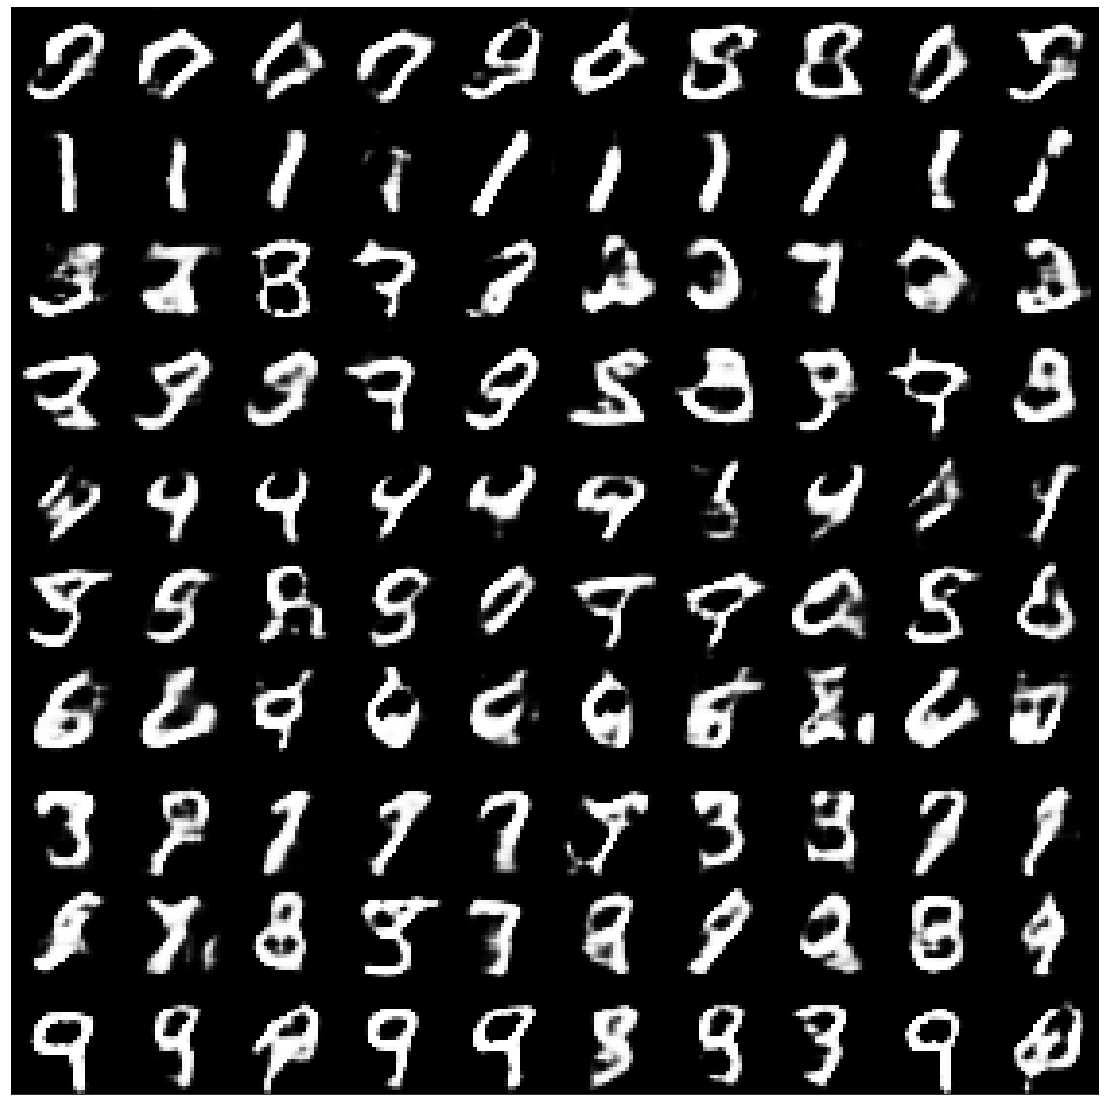

.l_d: 0.5628408789634705
.l_d: 0.44956880807876587
.l_d: 0.47332122921943665
.l_d: 0.4493131637573242
.l_d: 0.40966999530792236
.l_d: 0.531126856803894
.l_d: 0.5523627996444702
.l_d: 0.5297583937644958
.l_d: 0.4799412786960602
.l_d: 0.45891398191452026
.l_d: 0.539573073387146
.l_d: 0.5504027009010315
.l_d: 0.4848656952381134
.l_d: 0.44497552514076233
.l_d: 0.42892277240753174
.l_d: 0.4277169704437256
.l_d: 0.424274742603302
.l_d: 0.4486148953437805
.l_d: 0.49921661615371704
.l_d: 0.47994327545166016
.l_d: 0.46166008710861206
.l_d: 0.4418918490409851
.l_d: 0.4785653352737427
.l_d: 0.4582218825817108
.l_d: 0.4637036919593811
.l_d: 0.5012992024421692
.l_d: 0.44790759682655334
.l_d: 0.40240478515625
.l_d: 0.5318941473960876
.l_d: 0.5297443866729736
.l_d: 0.46847376227378845
.l_d: 0.48142358660697937
.l_d: 0.4504236876964569
.l_d: 0.4434727728366852
.l_d: 0.44707903265953064
.l_d: 0.4427468180656433
.l_d: 0.4618922472000122
.l_d: 0.4785396158695221
.l_d: 0.48301219940185547
.l_d: 0.44452756

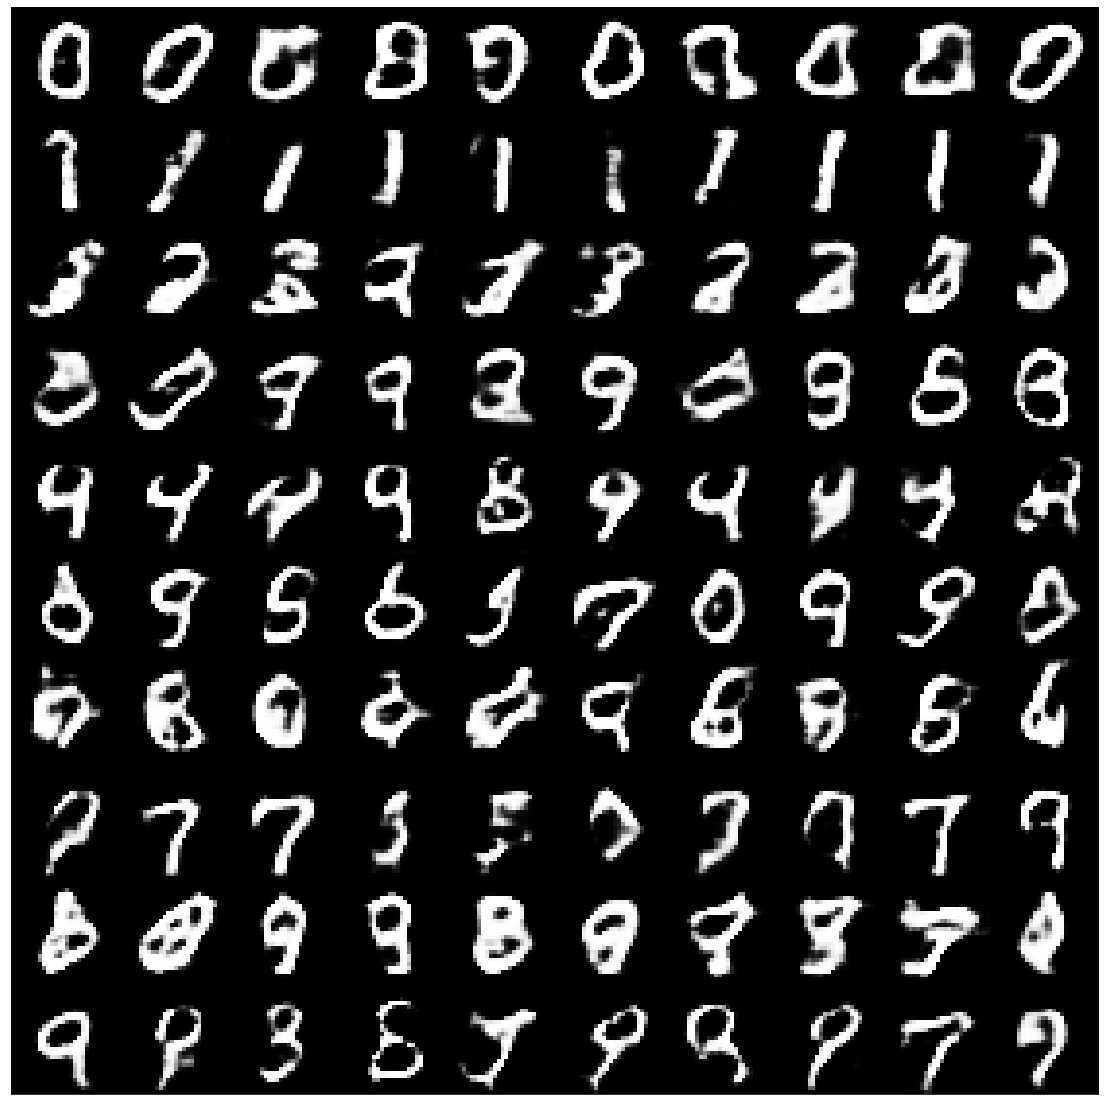

.l_d: 0.45449328422546387
.l_d: 0.4072389602661133
.l_d: 0.50828617811203
.l_d: 0.44905441999435425
.l_d: 0.4645400047302246
.l_d: 0.41615116596221924
.l_d: 0.5087045431137085
.l_d: 0.43996596336364746
.l_d: 0.4651790261268616
.l_d: 0.44589170813560486
.l_d: 0.47688400745391846
.l_d: 0.48554590344429016
.l_d: 0.4268873929977417
.l_d: 0.48021960258483887
.l_d: 0.5026420950889587
.l_d: 0.4822044372558594
.l_d: 0.4319784641265869
.l_d: 0.45099443197250366
.l_d: 0.40651583671569824
.l_d: 0.44535088539123535
.l_d: 0.44502249360084534
.l_d: 0.4874180257320404
.l_d: 0.4603411853313446
.l_d: 0.5033069849014282
.l_d: 0.5127677917480469
.l_d: 0.550630509853363
.l_d: 0.5289161205291748
.l_d: 0.46894776821136475
.l_d: 0.4406811594963074
.l_d: 0.429592490196228
.l_d: 0.46413731575012207
.l_d: 0.4591826796531677
.l_d: 0.44957029819488525
.l_d: 0.4571765959262848
.l_d: 0.5024875402450562
.l_d: 0.49867701530456543
.l_d: 0.5237271785736084
.l_d: 0.47233089804649353
.l_d: 0.4950348138809204
.l_d: 0.4227

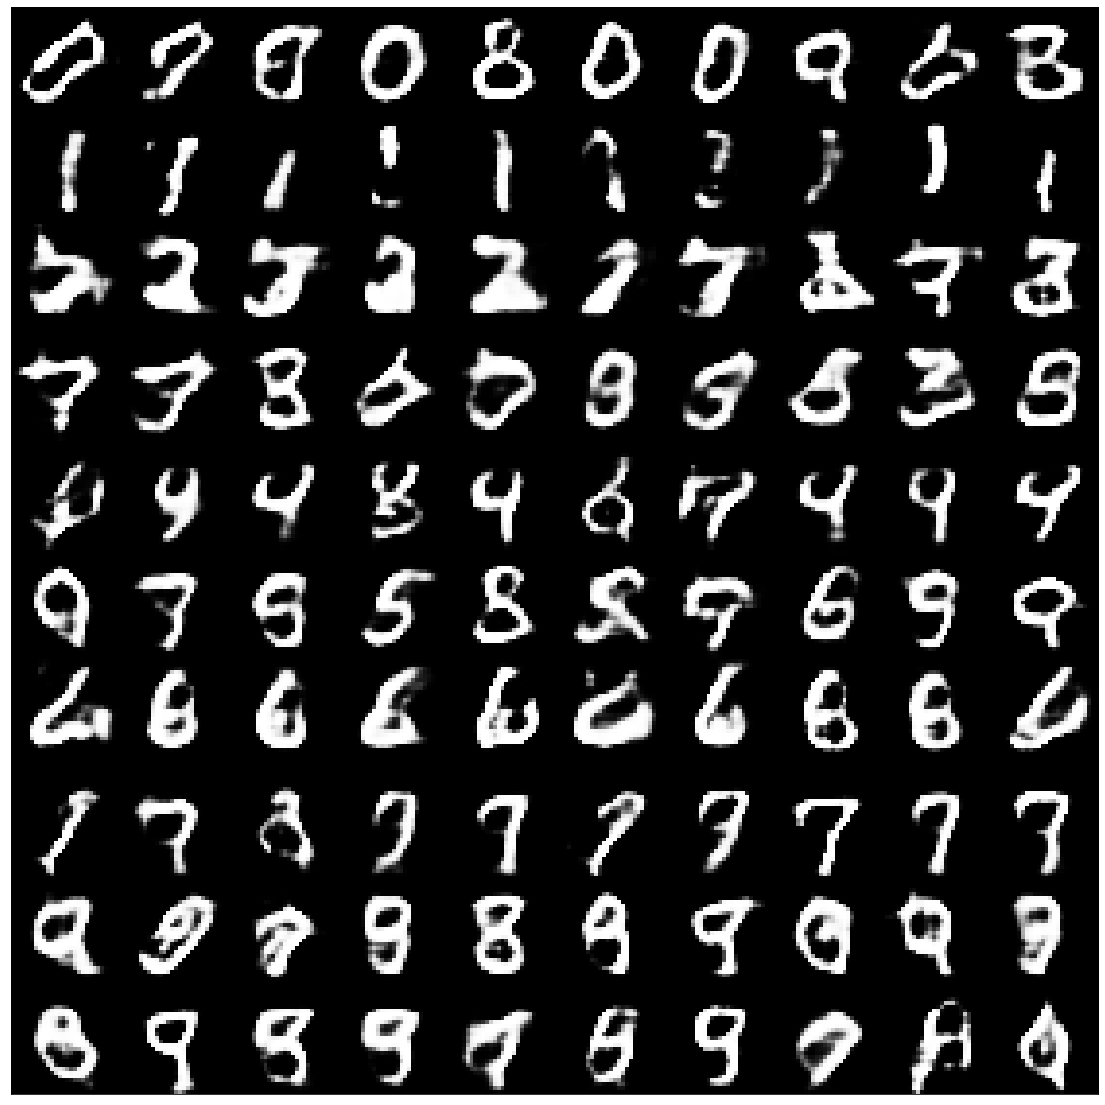

.l_d: 0.48756641149520874
.l_d: 0.49775296449661255
.l_d: 0.49425679445266724
.l_d: 0.4783279001712799
.l_d: 0.48485326766967773
.l_d: 0.4909725785255432
.l_d: 0.5349136590957642
.l_d: 0.5153607726097107
.l_d: 0.46302860975265503
.l_d: 0.44602644443511963
.l_d: 0.4704428017139435
.l_d: 0.47955334186553955
.l_d: 0.46396780014038086
.l_d: 0.4142278730869293
.l_d: 0.4621747136116028
.l_d: 0.4430118203163147
.l_d: 0.4651378393173218
.l_d: 0.5104048252105713
.l_d: 0.55031818151474
.l_d: 0.45988601446151733
.l_d: 0.450753390789032
.l_d: 0.4700865149497986
.l_d: 0.526476263999939
.l_d: 0.4521351456642151
.l_d: 0.489764928817749
.l_d: 0.4557970464229584
.l_d: 0.4393863081932068
.l_d: 0.4837189018726349
.l_d: 0.48680970072746277
.l_d: 0.5065900683403015
.l_d: 0.4701153039932251
.l_d: 0.4373926520347595
.l_d: 0.45138609409332275
.l_d: 0.46571844816207886
.l_d: 0.5189721584320068
.l_d: 0.46536096930503845
.l_d: 0.49202343821525574
.l_d: 0.4590410590171814
.l_d: 0.4980689287185669
.l_d: 0.42172953

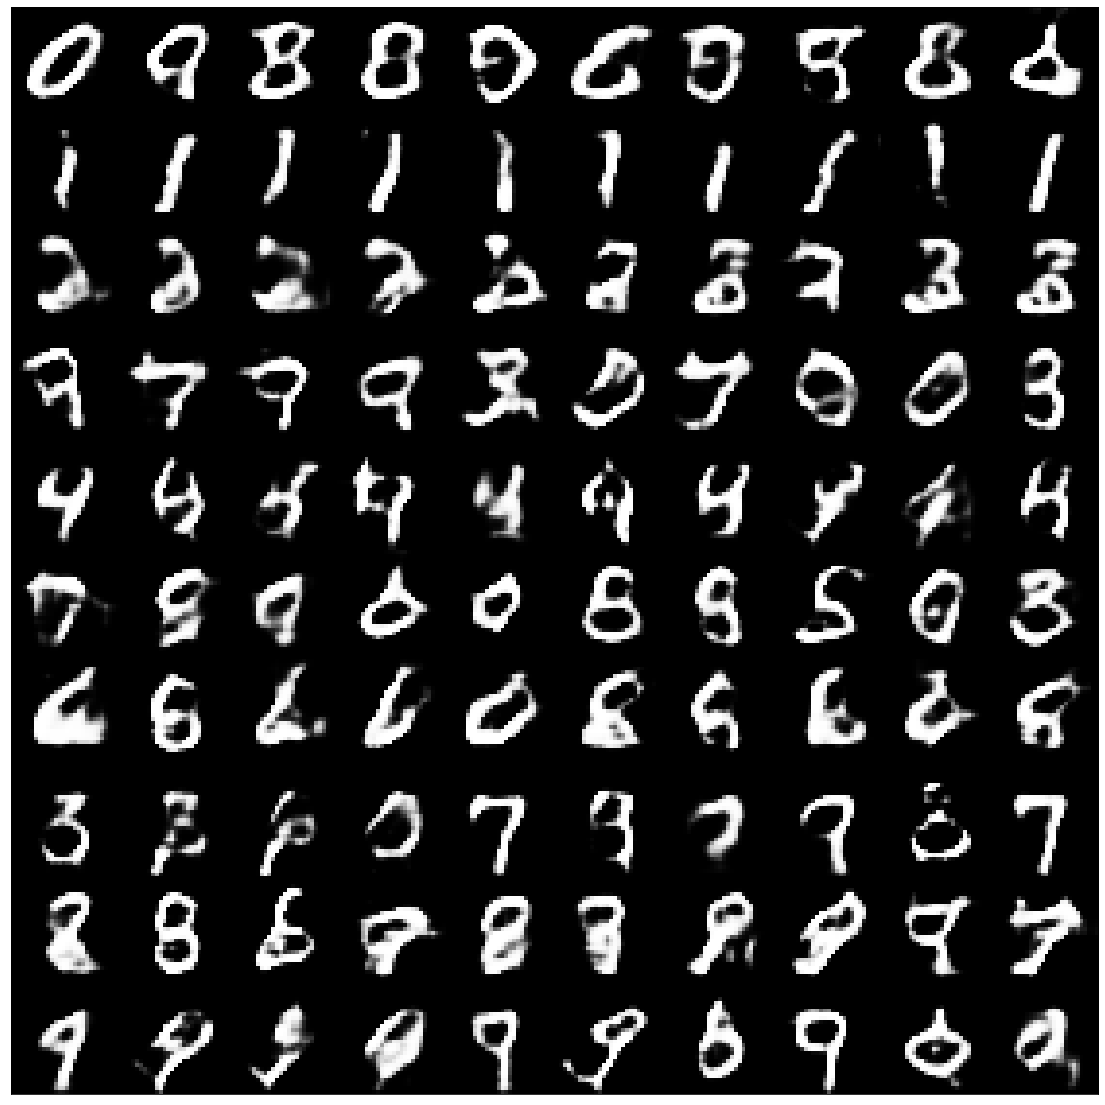

.l_d: 0.47536081075668335
.l_d: 0.4779674708843231
.l_d: 0.4739501178264618
.l_d: 0.40475332736968994
.l_d: 0.460701584815979
.l_d: 0.47634661197662354
.l_d: 0.5175191760063171
.l_d: 0.4327661991119385
.l_d: 0.46577221155166626
.l_d: 0.5421460270881653
.l_d: 0.5155125856399536
.l_d: 0.45781105756759644
.l_d: 0.4636760354042053
.l_d: 0.43148109316825867
.l_d: 0.42801493406295776
.l_d: 0.5113785266876221
.l_d: 0.48919689655303955
.l_d: 0.45741167664527893
.l_d: 0.45481783151626587
.l_d: 0.4678049683570862
.l_d: 0.4155765175819397
.l_d: 0.4546795189380646
.l_d: 0.4624564051628113
.l_d: 0.46500563621520996
.l_d: 0.49731341004371643
.l_d: 0.4981924295425415
.l_d: 0.4661024808883667
.l_d: 0.44697636365890503
.l_d: 0.43982696533203125
.l_d: 0.4389394521713257
.l_d: 0.43424203991889954
.l_d: 0.4644589424133301
.l_d: 0.41844284534454346
.l_d: 0.4670664966106415
.l_d: 0.4288206100463867
.l_d: 0.4262227416038513
.l_d: 0.4547303318977356
.l_d: 0.4891119599342346
.l_d: 0.44833528995513916
.l_d: 0.4

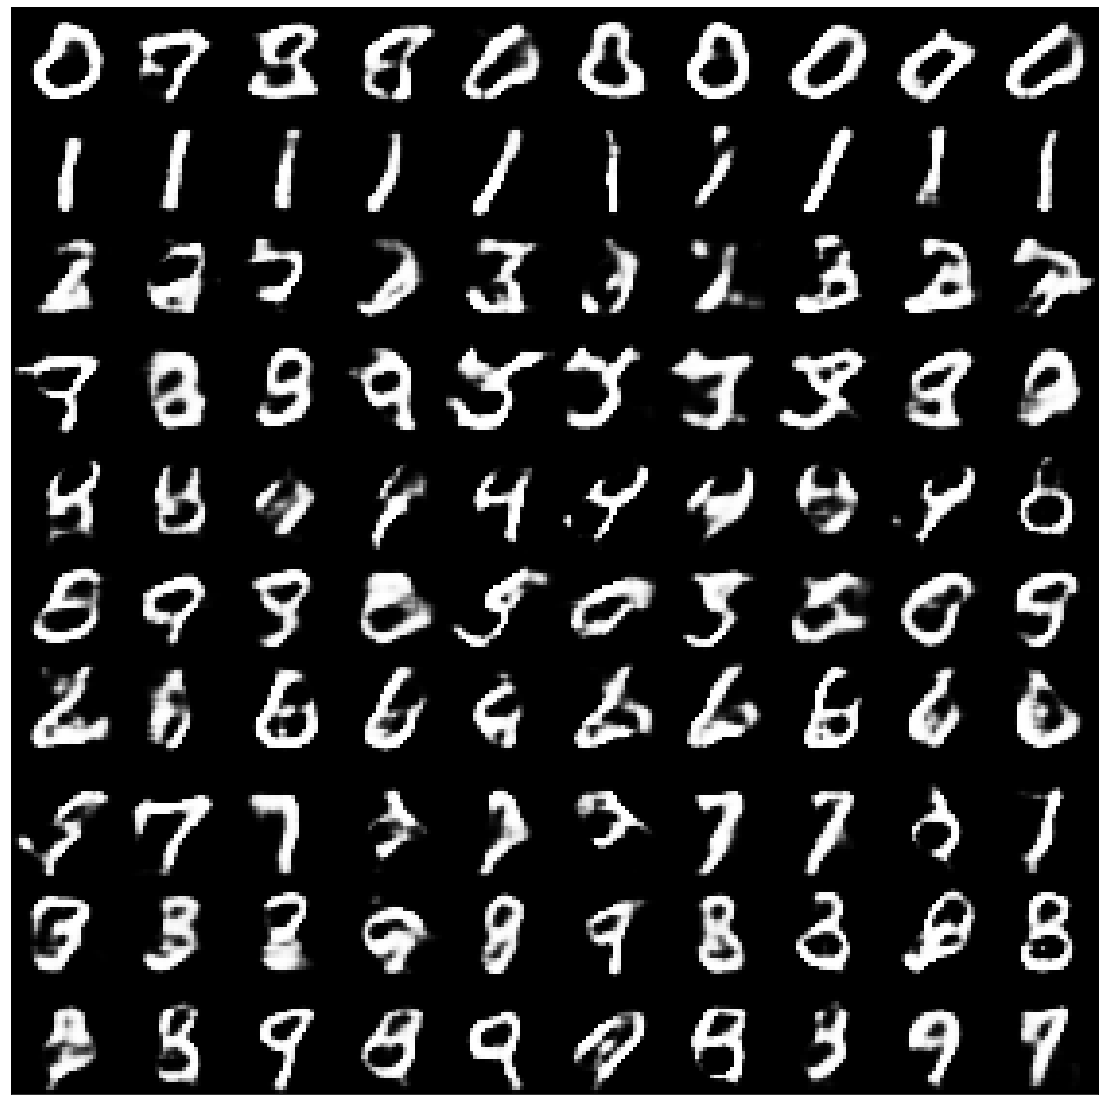

.l_d: 0.49455997347831726
.l_d: 0.43543538451194763
.l_d: 0.495117723941803
.l_d: 0.4946344494819641
.l_d: 0.4920485019683838
.l_d: 0.4913937747478485
.l_d: 0.46152347326278687
.l_d: 0.4881339967250824
.l_d: 0.5002221465110779
.l_d: 0.48101046681404114
.l_d: 0.4537004232406616
.l_d: 0.47556614875793457
.l_d: 0.44720906019210815
.l_d: 0.4565736651420593
.l_d: 0.46233081817626953
.l_d: 0.44542473554611206
.l_d: 0.5080614686012268
.l_d: 0.5272586345672607
.l_d: 0.488010048866272
.l_d: 0.45224639773368835
.l_d: 0.5069533586502075
.l_d: 0.4302772283554077
.l_d: 0.46837353706359863
.l_d: 0.46494895219802856
.l_d: 0.40810152888298035
.l_d: 0.4996536076068878
.l_d: 0.4511546492576599
.l_d: 0.43605154752731323
.l_d: 0.4832722246646881
.l_d: 0.49134206771850586
.l_d: 0.4483216106891632
.l_d: 0.47500455379486084
.l_d: 0.45628637075424194
.l_d: 0.5321203470230103
.l_d: 0.5003784894943237
.l_d: 0.4391953945159912
.l_d: 0.4679211378097534
.l_d: 0.42578253149986267
.l_d: 0.49760520458221436
.l_d: 0.4

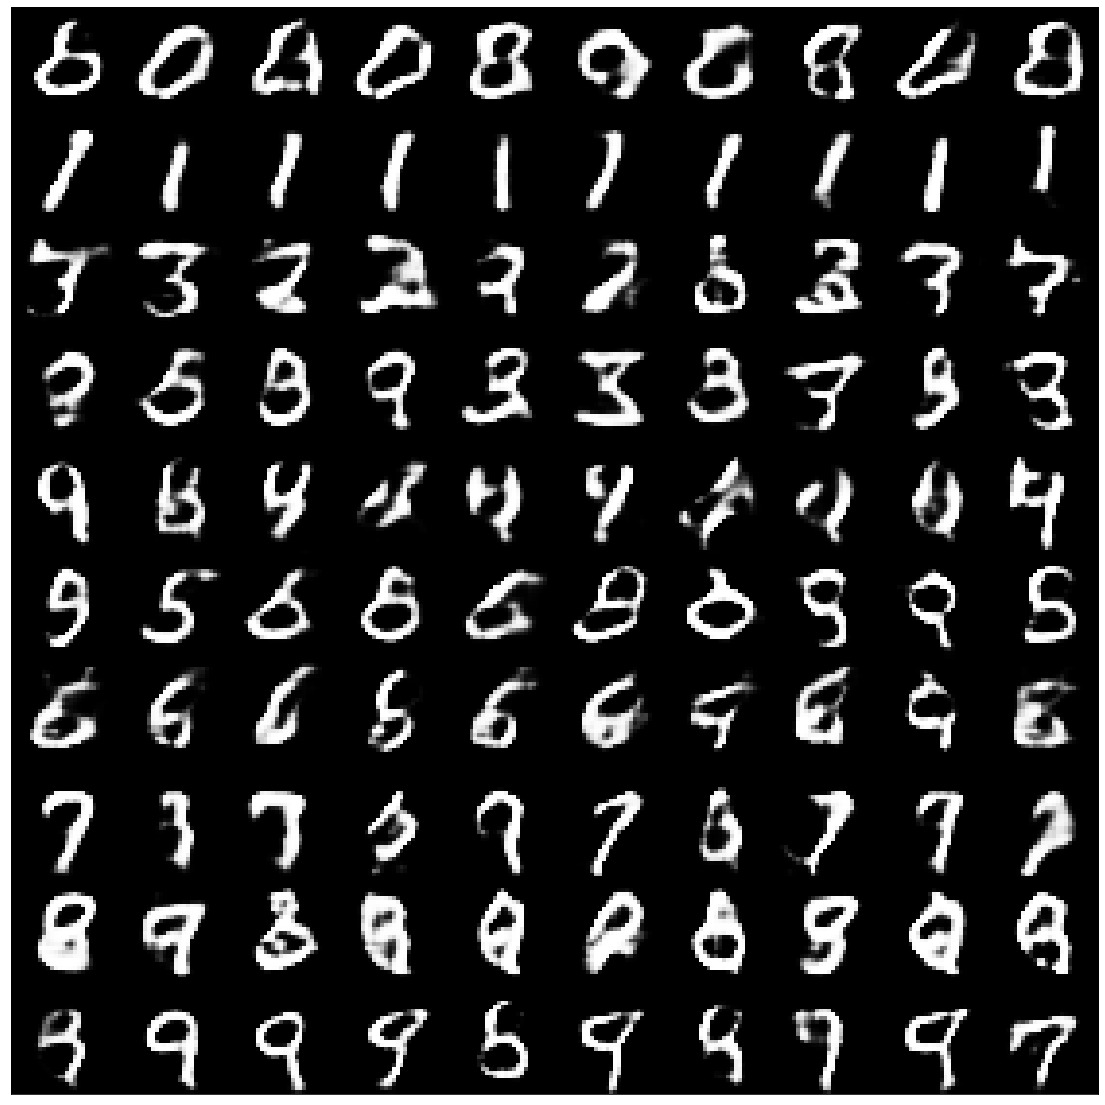

.l_d: 0.4108388423919678
.l_d: 0.4385734796524048
.l_d: 0.4791674017906189
.l_d: 0.4590887427330017
.l_d: 0.49234089255332947
.l_d: 0.49504315853118896
.l_d: 0.4402935206890106
.l_d: 0.45396551489830017
.l_d: 0.41544198989868164
.l_d: 0.4622279107570648
.l_d: 0.5196962952613831
.l_d: 0.4739852845668793
.l_d: 0.4302116334438324
.l_d: 0.4838002324104309
.l_d: 0.41227954626083374
.l_d: 0.42982831597328186
.l_d: 0.4181640148162842
.l_d: 0.443770170211792
.l_d: 0.48493263125419617
.l_d: 0.5225038528442383
.l_d: 0.5395462512969971
.l_d: 0.4693494141101837
.l_d: 0.4067513048648834
.l_d: 0.43360745906829834
.l_d: 0.45956555008888245
.l_d: 0.4755626320838928
.l_d: 0.4407573342323303
.l_d: 0.4731113612651825
.l_d: 0.457023948431015
.l_d: 0.43882596492767334
.l_d: 0.4162735342979431
.l_d: 0.48661351203918457
.l_d: 0.40699464082717896
.l_d: 0.45131605863571167
.l_d: 0.49722859263420105
.l_d: 0.47074568271636963
.l_d: 0.4462905824184418
.l_d: 0.4335079491138458
.l_d: 0.47790881991386414
.l_d: 0.413

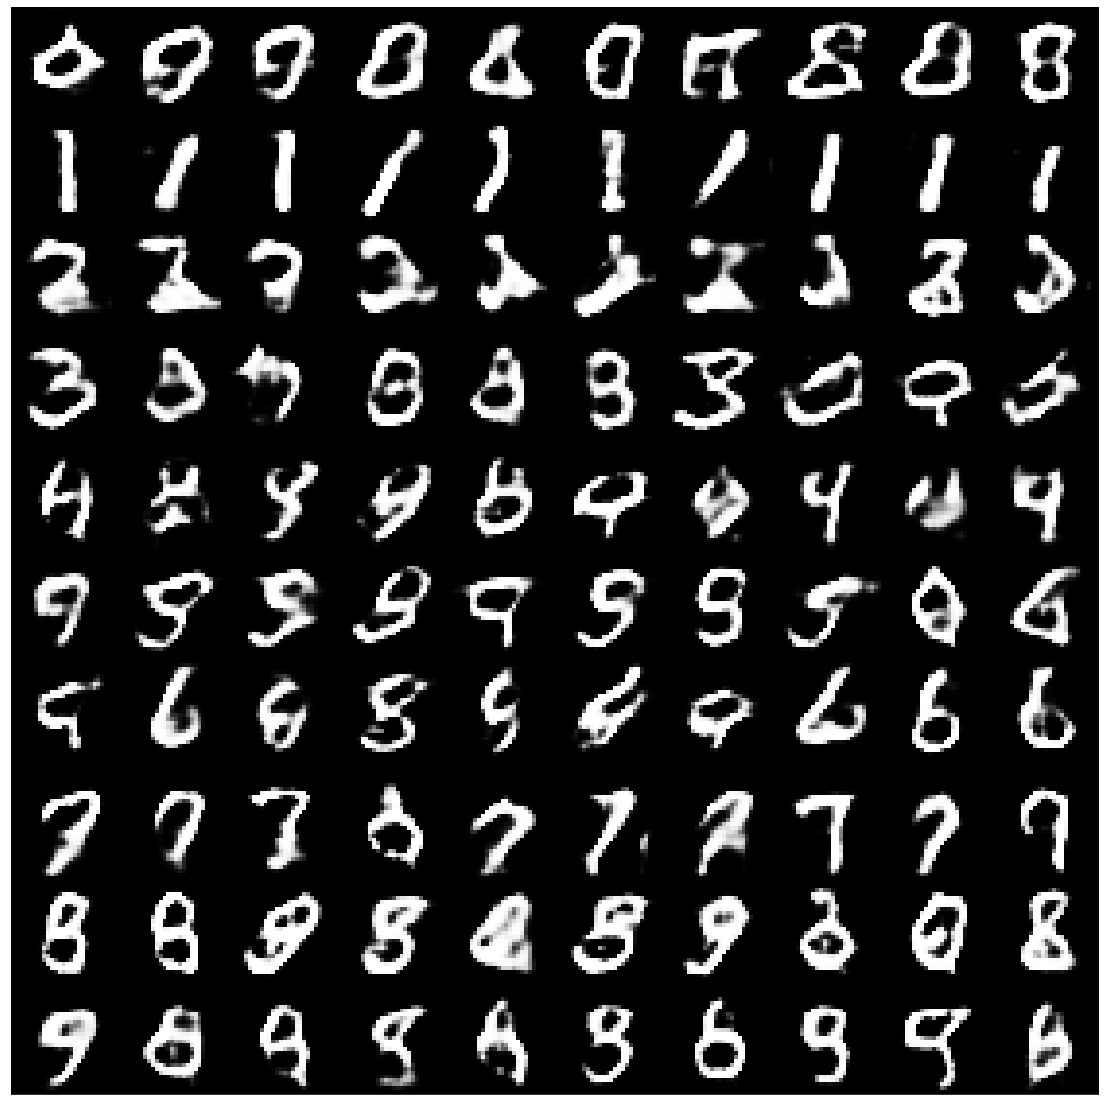

.l_d: 0.5015766024589539
.l_d: 0.432924747467041
.l_d: 0.4568193554878235
.l_d: 0.45737946033477783
.l_d: 0.5592490434646606
.l_d: 0.4378787875175476
.l_d: 0.48281002044677734
.l_d: 0.40764448046684265
.l_d: 0.458646297454834
.l_d: 0.41741153597831726
.l_d: 0.4829220771789551
.l_d: 0.45216262340545654
.l_d: 0.41157591342926025
.l_d: 0.4248045086860657
.l_d: 0.46240144968032837
.l_d: 0.48734334111213684
.l_d: 0.47223004698753357
.l_d: 0.4582022428512573
.l_d: 0.4406657814979553
.l_d: 0.4620989263057709
.l_d: 0.4218994975090027
.l_d: 0.425764799118042
.l_d: 0.4329339861869812
.l_d: 0.49005019664764404
.l_d: 0.5917572379112244
.l_d: 0.4977107346057892
.l_d: 0.4844343960285187
.l_d: 0.48711514472961426
.l_d: 0.4066505432128906
.l_d: 0.44224271178245544
.l_d: 0.44375646114349365
.l_d: 0.4144824147224426
.l_d: 0.43304505944252014
.l_d: 0.43390360474586487
.l_d: 0.45515814423561096
.l_d: 0.4680486023426056
.l_d: 0.49517640471458435
.l_d: 0.4949987828731537
.l_d: 0.44752269983291626
.l_d: 0.49

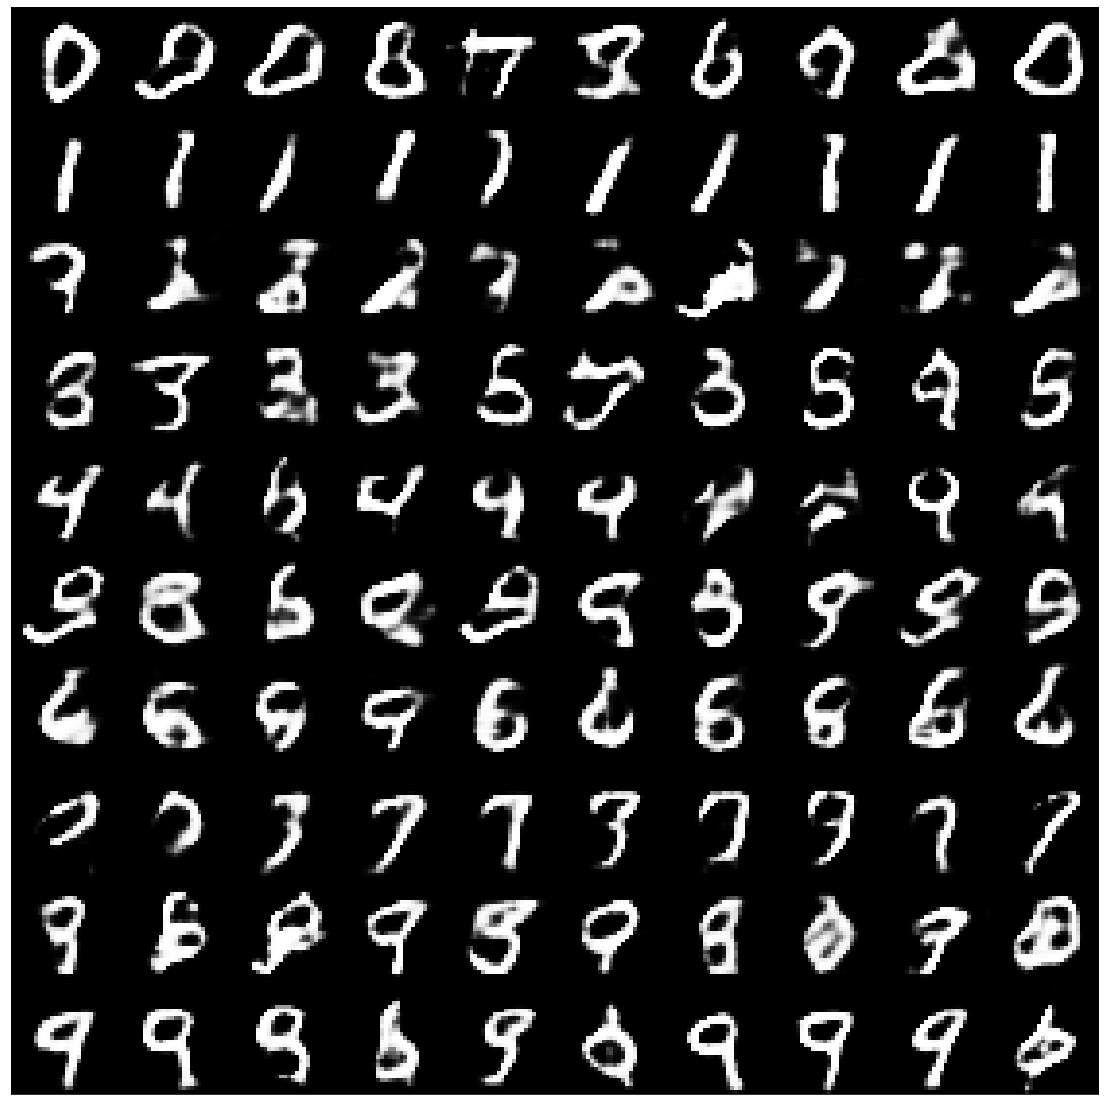

.l_d: 0.4334588050842285
.l_d: 0.4342145621776581
.l_d: 0.450689435005188
.l_d: 0.490135133266449
.l_d: 0.5114519596099854
.l_d: 0.4736117720603943
.l_d: 0.45544034242630005
.l_d: 0.427517831325531
.l_d: 0.42675021290779114
.l_d: 0.4265236258506775
.l_d: 0.43492165207862854
.l_d: 0.4893372654914856
.l_d: 0.42248600721359253
.l_d: 0.47644323110580444
.l_d: 0.45276421308517456
.l_d: 0.4394499361515045
.l_d: 0.44660717248916626
.l_d: 0.4464884400367737
.l_d: 0.4332759976387024
.l_d: 0.5223990082740784
.l_d: 0.4141189754009247
.l_d: 0.4007715582847595
.l_d: 0.44905126094818115
.l_d: 0.4300982356071472
.l_d: 0.4424422085285187
.l_d: 0.4965364933013916
.l_d: 0.4553096890449524
.l_d: 0.48234081268310547
.l_d: 0.4696360230445862
.l_d: 0.41528674960136414
.l_d: 0.49602311849594116
.l_d: 0.41002216935157776
.l_d: 0.4698699712753296
.l_d: 0.45968174934387207
.l_d: 0.5180585384368896
.l_d: 0.41051971912384033
.l_d: 0.4567692279815674
.l_d: 0.46526581048965454
.l_d: 0.4997764825820923
.l_d: 0.41330

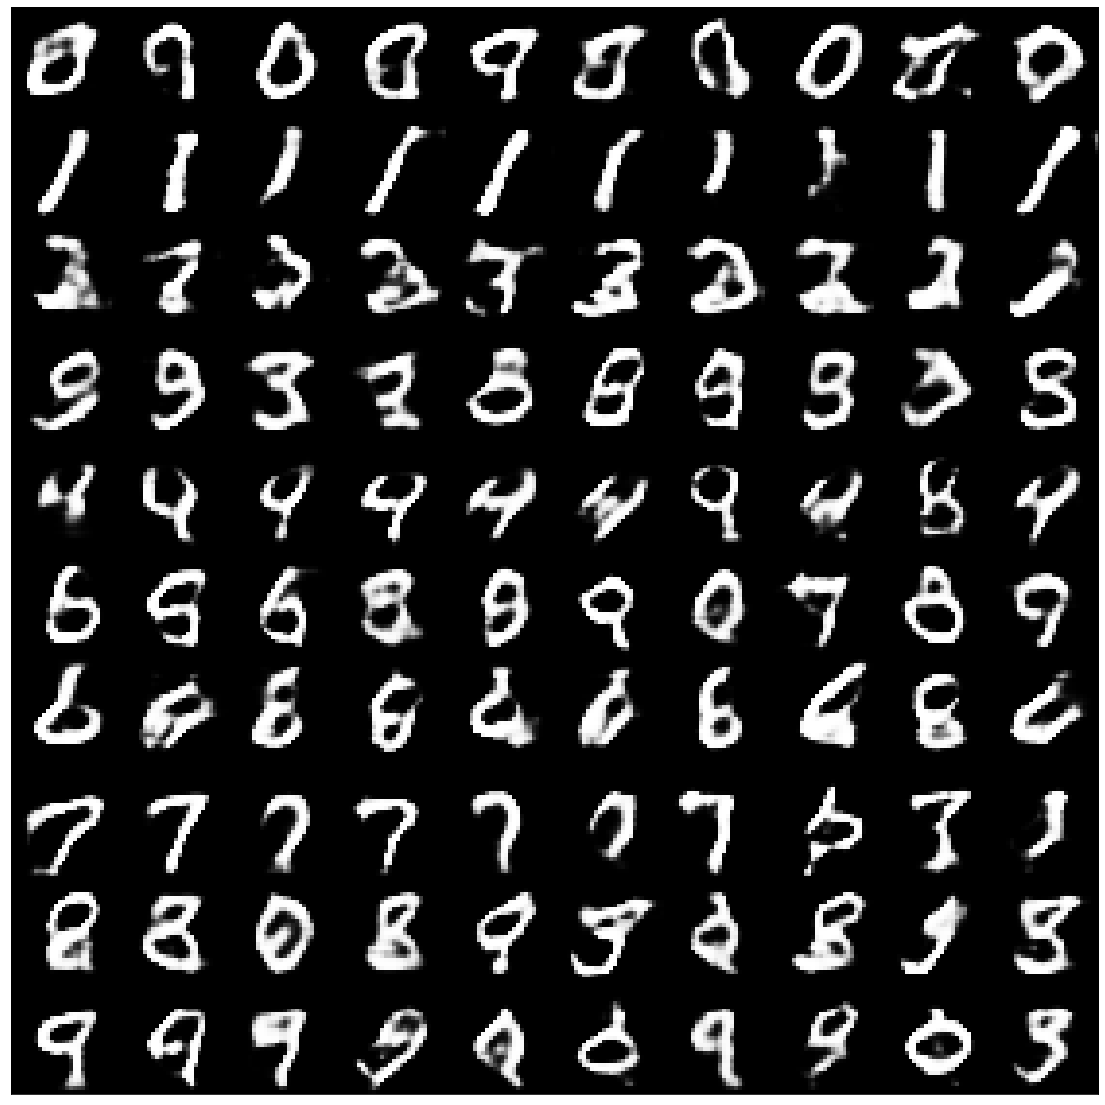

.l_d: 0.4098859429359436
.l_d: 0.42582693696022034
.l_d: 0.4503854513168335
.l_d: 0.44939985871315
.l_d: 0.436513751745224
.l_d: 0.42545512318611145
.l_d: 0.42288294434547424
.l_d: 0.4236276149749756
.l_d: 0.4825384318828583
.l_d: 0.48017770051956177
.l_d: 0.4483315050601959
.l_d: 0.44941484928131104
.l_d: 0.40420904755592346
.l_d: 0.44148871302604675
.l_d: 0.4046805202960968
.l_d: 0.549106776714325
.l_d: 0.4527907073497772
.l_d: 0.4490702152252197
.l_d: 0.424777626991272
.l_d: 0.41879433393478394
.l_d: 0.4760235846042633
.l_d: 0.404379278421402
.l_d: 0.4500414729118347
.l_d: 0.4588613510131836
.l_d: 0.4663662910461426
.l_d: 0.46751850843429565
.l_d: 0.4520602226257324
.l_d: 0.439555823802948
.l_d: 0.42765483260154724
.l_d: 0.524570882320404
.l_d: 0.40879639983177185
.l_d: 0.5052253603935242
.l_d: 0.48387467861175537
.l_d: 0.4476674497127533
.l_d: 0.4839419722557068
.l_d: 0.4289688467979431
.l_d: 0.4362426996231079
.l_d: 0.4394823908805847
.l_d: 0.46944481134414673
.l_d: 0.416125059127

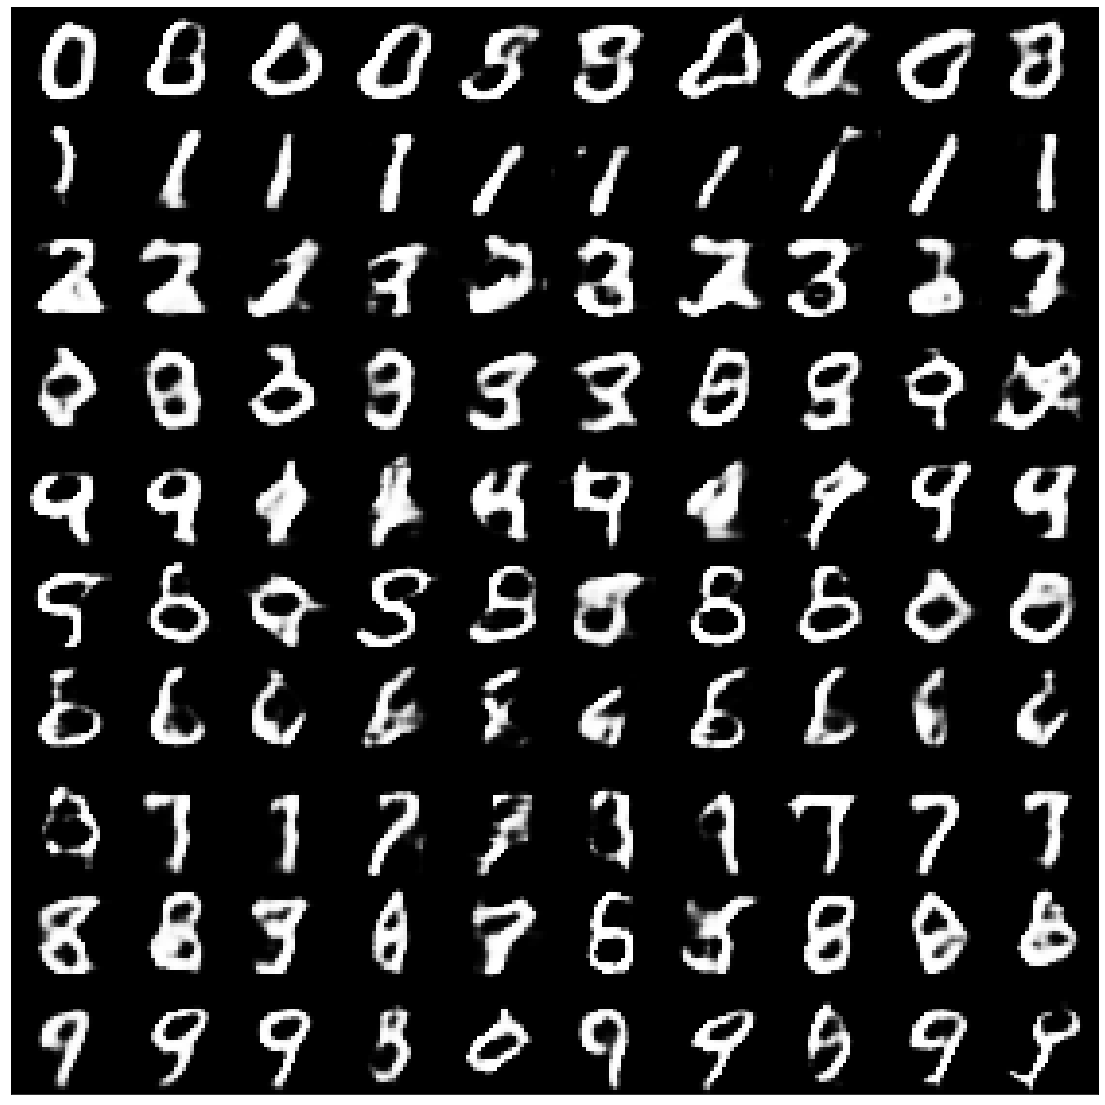

.l_d: 0.4823082685470581
.l_d: 0.47202640771865845
.l_d: 0.44928455352783203
.l_d: 0.4983311891555786
.l_d: 0.41523462533950806
.l_d: 0.4777235686779022
.l_d: 0.42375648021698
.l_d: 0.4193539321422577
.l_d: 0.449129581451416
.l_d: 0.4548245966434479
.l_d: 0.5090872049331665
.l_d: 0.4929491877555847
.l_d: 0.42598891258239746
.l_d: 0.43159791827201843
.l_d: 0.4752963185310364
.l_d: 0.45153307914733887
.l_d: 0.44665688276290894
.l_d: 0.43289095163345337
.l_d: 0.47343096137046814
.l_d: 0.49973738193511963
.l_d: 0.49867141246795654
.l_d: 0.44923657178878784
.l_d: 0.4616677165031433
.l_d: 0.41436296701431274
.l_d: 0.45483335852622986
.l_d: 0.4663715362548828
.l_d: 0.49815937876701355
.l_d: 0.4858211278915405
.l_d: 0.4156956672668457
.l_d: 0.4252476096153259
.l_d: 0.41014569997787476
.l_d: 0.4501325488090515
.l_d: 0.42273229360580444
.l_d: 0.4723385274410248
.l_d: 0.4628610908985138
.l_d: 0.46560221910476685
.l_d: 0.48321521282196045
.l_d: 0.40584835410118103
.l_d: 0.4907222092151642
.l_d: 0.

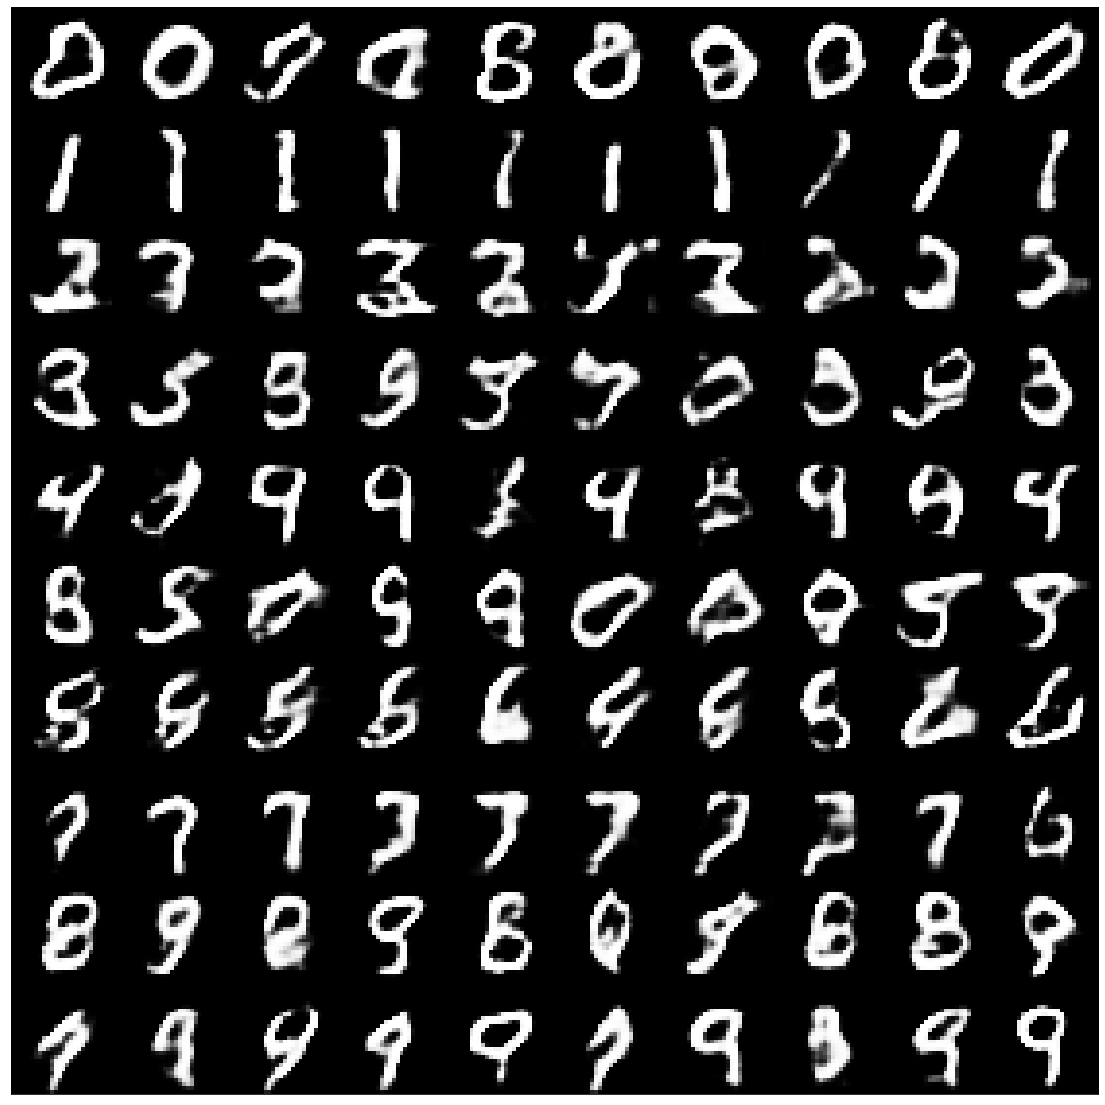

.l_d: 0.5064795613288879
.l_d: 0.441753625869751
.l_d: 0.4299517869949341
.l_d: 0.4147907495498657
.l_d: 0.46739864349365234
.l_d: 0.45717909932136536
.l_d: 0.4414364993572235
.l_d: 0.49158215522766113
.l_d: 0.47946897149086
.l_d: 0.4910650849342346
.l_d: 0.42393362522125244
.l_d: 0.4639962315559387
.l_d: 0.41987788677215576
.l_d: 0.520003616809845
.l_d: 0.5106039047241211
.l_d: 0.43327802419662476
.l_d: 0.44228655099868774
.l_d: 0.4392363429069519
.l_d: 0.4644942581653595
.l_d: 0.49216264486312866
.l_d: 0.4890715479850769
.l_d: 0.4518827497959137
.l_d: 0.45958900451660156
.l_d: 0.461445689201355
.l_d: 0.4478299617767334
.l_d: 0.42340773344039917
.l_d: 0.454351544380188
.l_d: 0.4355638921260834
.l_d: 0.46259984374046326
.l_d: 0.43674182891845703
.l_d: 0.46324798464775085
.l_d: 0.4270326495170593
.l_d: 0.4142966866493225
.l_d: 0.4538564682006836
.l_d: 0.44476839900016785
.l_d: 0.4979023337364197
.l_d: 0.4987136423587799
.l_d: 0.5456270575523376
.l_d: 0.4855502247810364
.l_d: 0.487772941

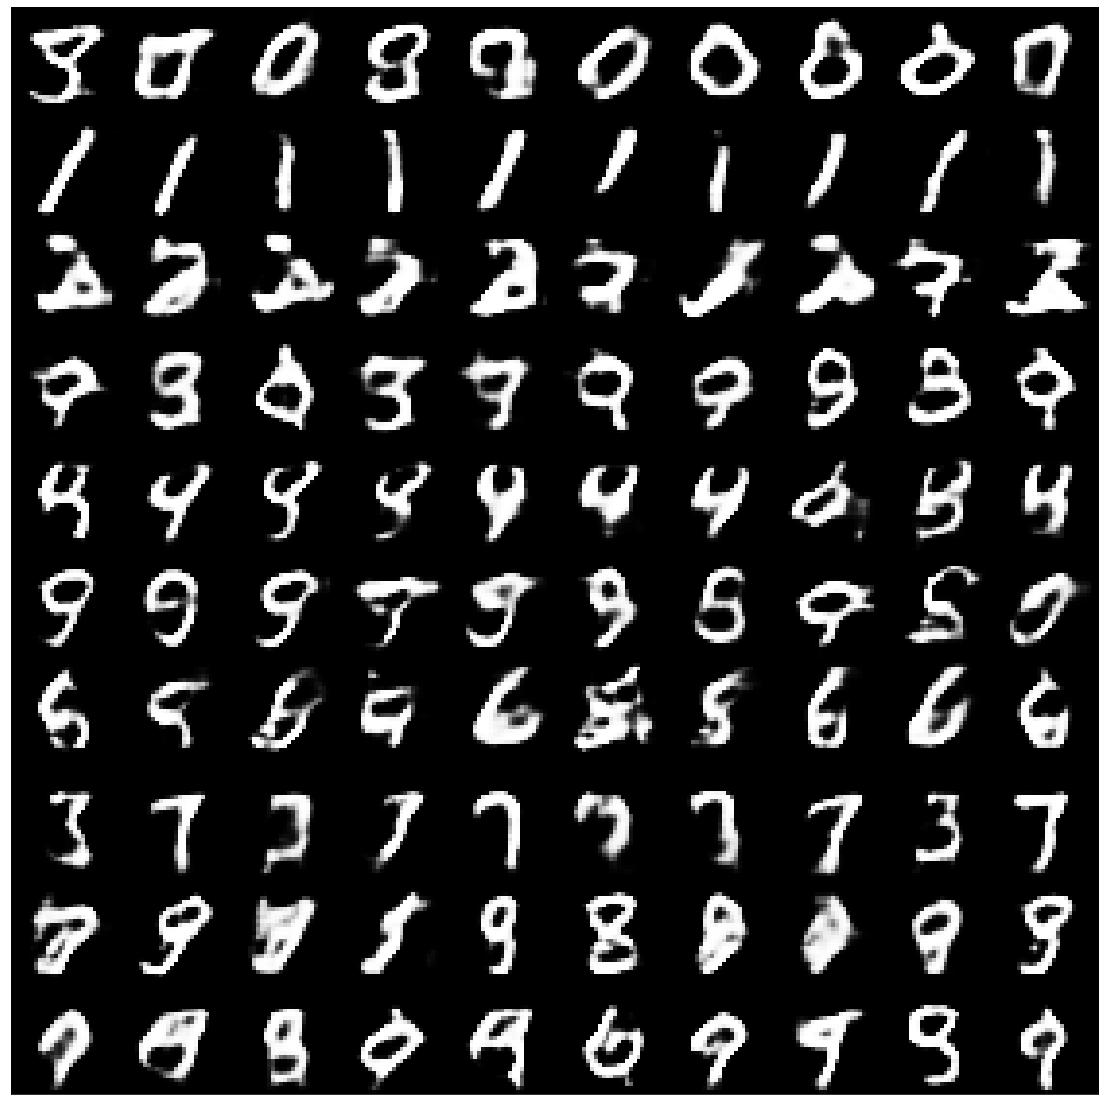

.l_d: 0.43242937326431274
.l_d: 0.4667989909648895
.l_d: 0.49354320764541626
.l_d: 0.4919882118701935
.l_d: 0.545809268951416
.l_d: 0.441284716129303
.l_d: 0.44163841009140015
.l_d: 0.47117480635643005
.l_d: 0.4780731797218323
.l_d: 0.4036102592945099
.l_d: 0.42529165744781494
.l_d: 0.45490244030952454
.l_d: 0.4273775815963745
.l_d: 0.42034202814102173
.l_d: 0.46189191937446594
.l_d: 0.44682466983795166
.l_d: 0.4909926652908325
.l_d: 0.4348188042640686
.l_d: 0.4531961679458618
.l_d: 0.4361041188240051
.l_d: 0.42771515250205994
.l_d: 0.4467654526233673
.l_d: 0.45535391569137573
.l_d: 0.4772355258464813
.l_d: 0.40548035502433777
.l_d: 0.48479172587394714
.l_d: 0.44630908966064453
.l_d: 0.4396480619907379
.l_d: 0.47326621413230896
.l_d: 0.4424978494644165
.l_d: 0.4052811861038208
.l_d: 0.4455413222312927
.l_d: 0.45776641368865967
.l_d: 0.4447760581970215
.l_d: 0.49538689851760864
.l_d: 0.4393339455127716
.l_d: 0.4286852180957794
.l_d: 0.4190461039543152
.l_d: 0.4062507748603821
.l_d: 0.42

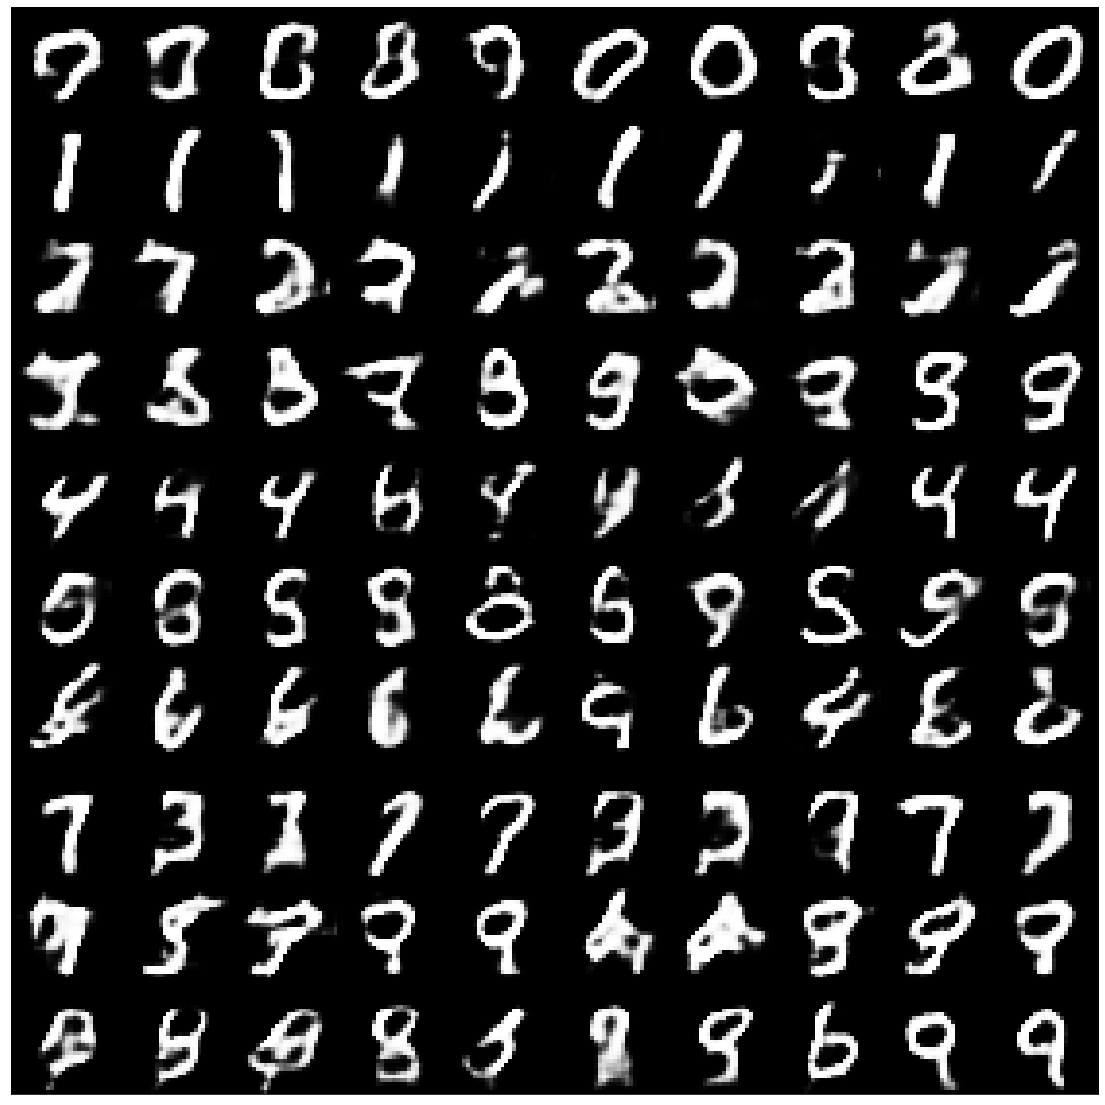

.l_d: 0.4165860712528229
.l_d: 0.44533902406692505
.l_d: 0.4166143238544464
.l_d: 0.4282694160938263
.l_d: 0.46602126955986023
.l_d: 0.4713640809059143
.l_d: 0.41847747564315796
.l_d: 0.4549233615398407
.l_d: 0.4199870824813843
.l_d: 0.4903166592121124
.l_d: 0.4914996325969696
.l_d: 0.45172780752182007
.l_d: 0.4194866418838501
.l_d: 0.46075814962387085
.l_d: 0.4353102147579193
.l_d: 0.40003371238708496
.l_d: 0.4335102438926697
.l_d: 0.41441452503204346
.l_d: 0.46250438690185547
.l_d: 0.5098105669021606
.l_d: 0.4741385877132416
.l_d: 0.46050596237182617
.l_d: 0.4347790479660034
.l_d: 0.5166193842887878
.l_d: 0.5672613382339478
.l_d: 0.46120333671569824
.l_d: 0.4350741505622864
.l_d: 0.4503284990787506
.l_d: 0.40002259612083435
.l_d: 0.40896931290626526
.l_d: 0.4870035648345947
.l_d: 0.41181856393814087
.l_d: 0.4314311146736145
.l_d: 0.4072751998901367
.l_d: 0.47913858294487
.l_d: 0.47108322381973267
.l_d: 0.4520573616027832
.l_d: 0.4391056299209595
.l_d: 0.4033884108066559
.l_d: 0.47801

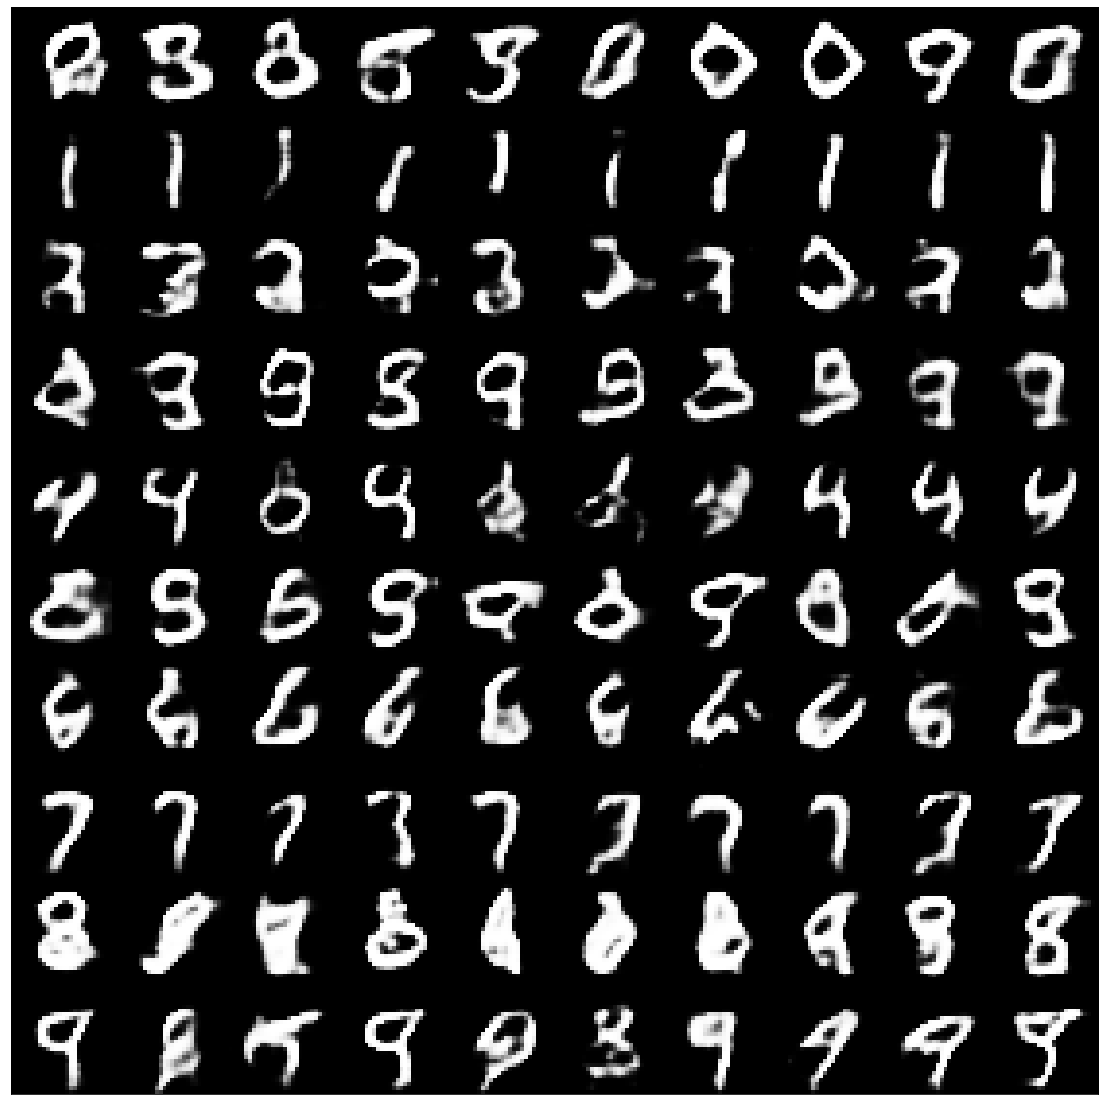

.l_d: 0.4365278482437134
.l_d: 0.5228974223136902
.l_d: 0.43594634532928467
.l_d: 0.41626790165901184
.l_d: 0.40316009521484375
.l_d: 0.40072762966156006
.l_d: 0.4703301787376404
.l_d: 0.4525298774242401
.l_d: 0.40707388520240784
.l_d: 0.4764188528060913
.l_d: 0.4225504398345947
.l_d: 0.431180864572525
.l_d: 0.45628708600997925
.l_d: 0.4510953426361084
.l_d: 0.4092136025428772
.l_d: 0.42675071954727173
.l_d: 0.4269402027130127
.l_d: 0.40910691022872925
.l_d: 0.4175044894218445
.l_d: 0.4231833815574646
.l_d: 0.42031633853912354
.l_d: 0.40028226375579834
.l_d: 0.4311743676662445
.l_d: 0.43559446930885315
.l_d: 0.5182860493659973
.l_d: 0.49451738595962524
.l_d: 0.48054224252700806
.l_d: 0.41246527433395386
.l_d: 0.41144487261772156
.l_d: 0.4017428755760193
.l_d: 0.4419000446796417
.l_d: 0.4567219316959381
.l_d: 0.43601325154304504
.l_d: 0.432910680770874
.l_d: 0.47860974073410034
.l_d: 0.4122997522354126
.l_d: 0.47271856665611267
.l_d: 0.41390156745910645
.l_d: 0.4366576671600342
.l_d: 0.

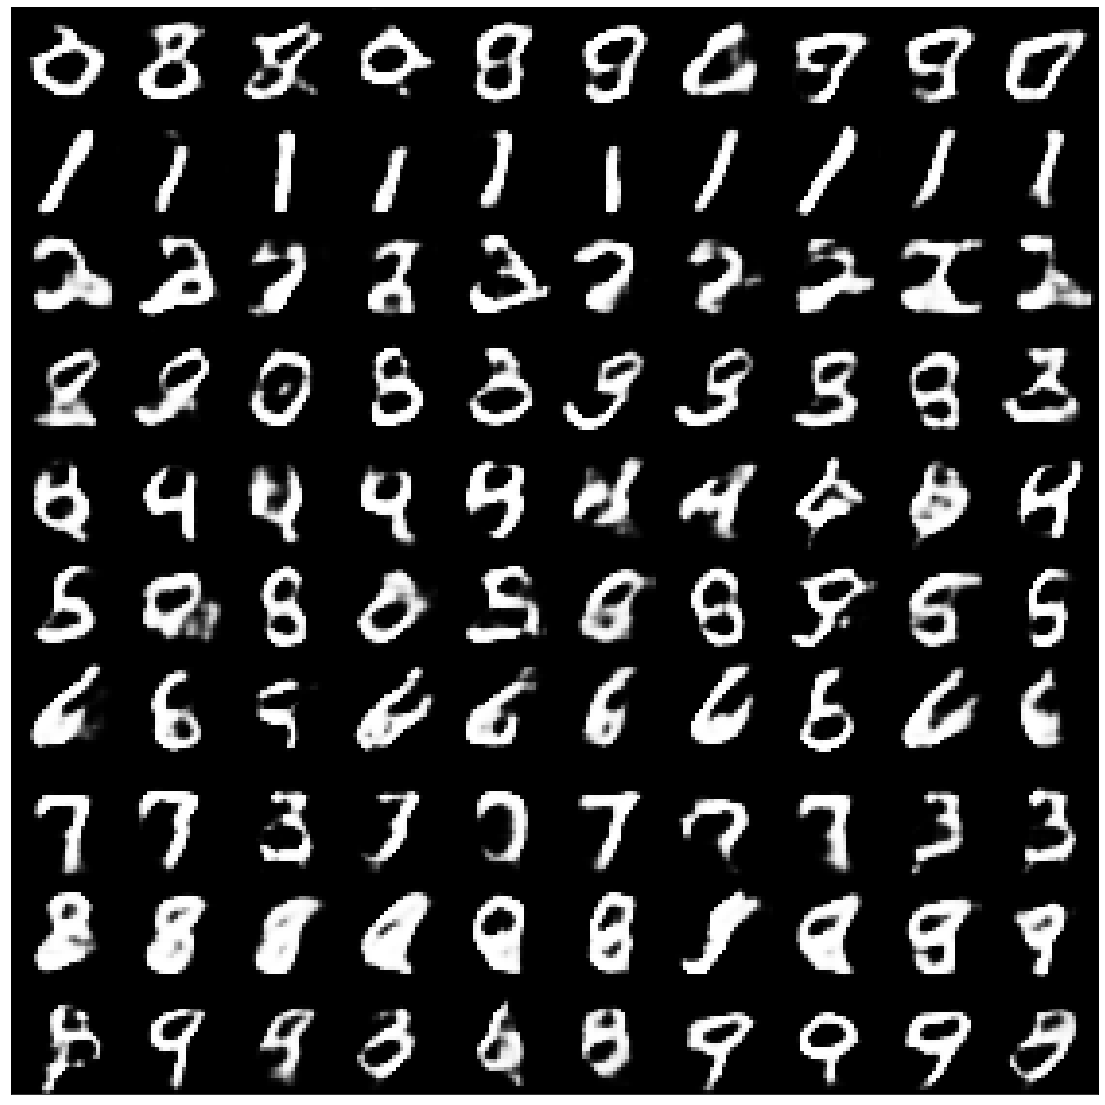

.l_d: 0.4300936460494995
.l_d: 0.4656476080417633
.l_d: 0.46551257371902466
.l_d: 0.4845883250236511
.l_d: 0.45274198055267334
.l_d: 0.4139913022518158
.l_d: 0.41254061460494995
.l_d: 0.4145767390727997
.l_d: 0.5097005367279053
.l_d: 0.482247918844223
.l_d: 0.4876769185066223
.l_d: 0.4158206582069397
.l_d: 0.4407977759838104
.l_d: 0.5151835083961487
.l_d: 0.4046401083469391
.l_d: 0.49101170897483826
.l_d: 0.4489058554172516
.l_d: 0.4377110004425049
.l_d: 0.4612658619880676
.l_d: 0.40935713052749634
.l_d: 0.5030010938644409
.l_d: 0.41786468029022217
.l_d: 0.42404264211654663
.l_d: 0.45400482416152954
.l_d: 0.5331809520721436
.l_d: 0.42832061648368835
.l_d: 0.4123523533344269
.l_d: 0.4208133816719055
.l_d: 0.4226256012916565
.l_d: 0.4411640167236328
.l_d: 0.45676955580711365
.l_d: 0.4538399279117584
.l_d: 0.43692296743392944
.l_d: 0.46897244453430176
.l_d: 0.41433635354042053
.l_d: 0.45306074619293213
.l_d: 0.4072803854942322
.l_d: 0.4708667993545532
.l_d: 0.4123070240020752
.l_d: 0.4544

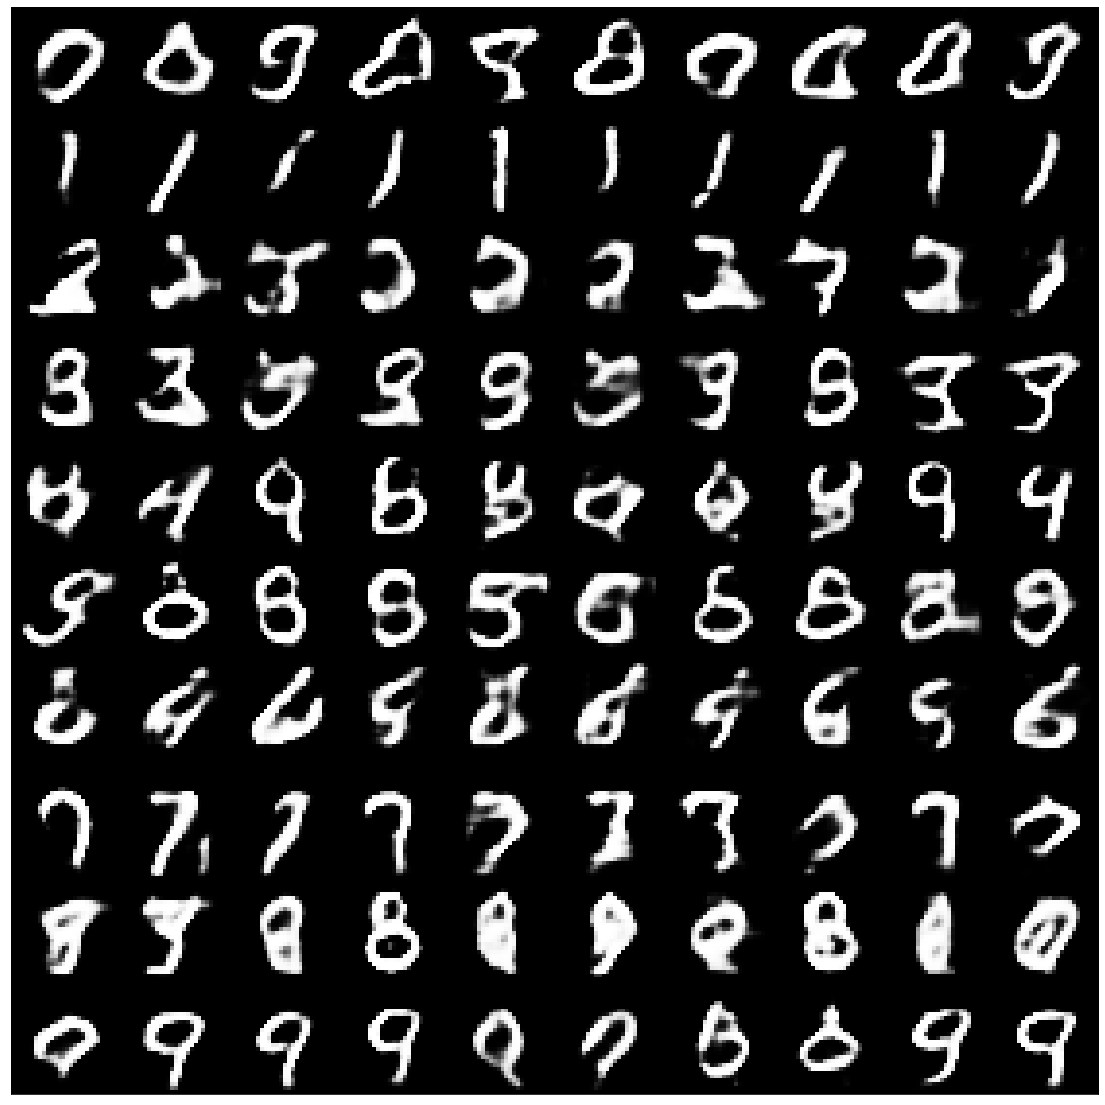

.l_d: 0.46836337447166443
.l_d: 0.422901451587677
.l_d: 0.4695334732532501
.l_d: 0.42168736457824707
.l_d: 0.4263860881328583
.l_d: 0.42965391278266907
.l_d: 0.4127618074417114
.l_d: 0.43182358145713806
.l_d: 0.4106225371360779
.l_d: 0.40549734234809875
.l_d: 0.40199312567710876
.l_d: 0.4230259656906128
.l_d: 0.442805677652359
.l_d: 0.4449802339076996
.l_d: 0.4470646381378174
.l_d: 0.4499363899230957
.l_d: 0.4858399033546448
.l_d: 0.5301133394241333
.l_d: 0.45988836884498596
.l_d: 0.4623104929924011
.l_d: 0.4384732246398926
.l_d: 0.40949925780296326
.l_d: 0.4312843680381775
.l_d: 0.42049628496170044
.l_d: 0.43764907121658325
.l_d: 0.40459975600242615
.l_d: 0.41061830520629883
.l_d: 0.44365251064300537
.l_d: 0.46557578444480896
.l_d: 0.4851987361907959
.l_d: 0.4396100640296936
.l_d: 0.4514031708240509
.l_d: 0.46064943075180054
.l_d: 0.42431938648223877
.l_d: 0.45129239559173584
.l_d: 0.44574272632598877
.l_d: 0.42446771264076233
.l_d: 0.4437502324581146
.l_d: 0.4431823492050171
.l_d: 0.

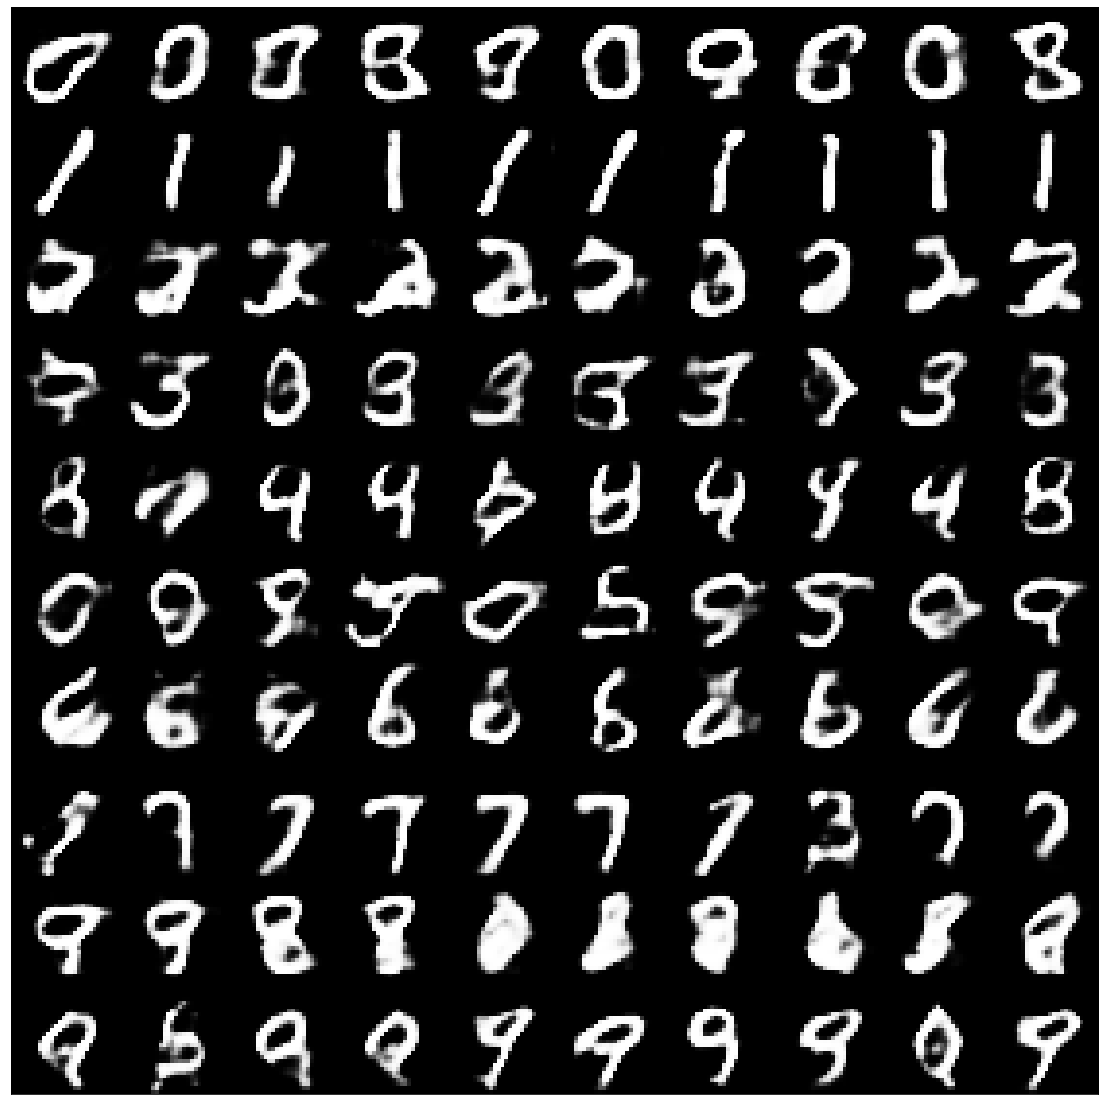

.l_d: 0.40791964530944824
.l_d: 0.4305097758769989
.l_d: 0.4016103744506836
.l_d: 0.4663320779800415
.l_d: 0.49540936946868896
.l_d: 0.4633612036705017
.l_d: 0.4823209047317505
.l_d: 0.4676862955093384
.l_d: 0.4000648260116577
.l_d: 0.4909431040287018
.l_d: 0.40599632263183594
.l_d: 0.4231344759464264
.l_d: 0.4434560537338257
.l_d: 0.44040626287460327
.l_d: 0.40003445744514465
.l_d: 0.4318476915359497
.l_d: 0.4304655194282532
.l_d: 0.4825974106788635
.l_d: 0.4557698369026184
.l_d: 0.44667506217956543
.l_d: 0.42620357871055603
.l_d: 0.4767877459526062
.l_d: 0.49812963604927063
.l_d: 0.4616793990135193
.l_d: 0.43214768171310425
.l_d: 0.4447542726993561
.l_d: 0.40200385451316833
.l_d: 0.4547193646430969
.l_d: 0.4185965657234192
.l_d: 0.44132184982299805
.l_d: 0.40557408332824707
.l_d: 0.45449596643447876
.l_d: 0.42560380697250366
.l_d: 0.42880409955978394
.l_d: 0.41403698921203613
.l_d: 0.42080754041671753
.l_d: 0.45496442914009094
.l_d: 0.4962794780731201
.l_d: 0.4545799791812897
.l_d: 0

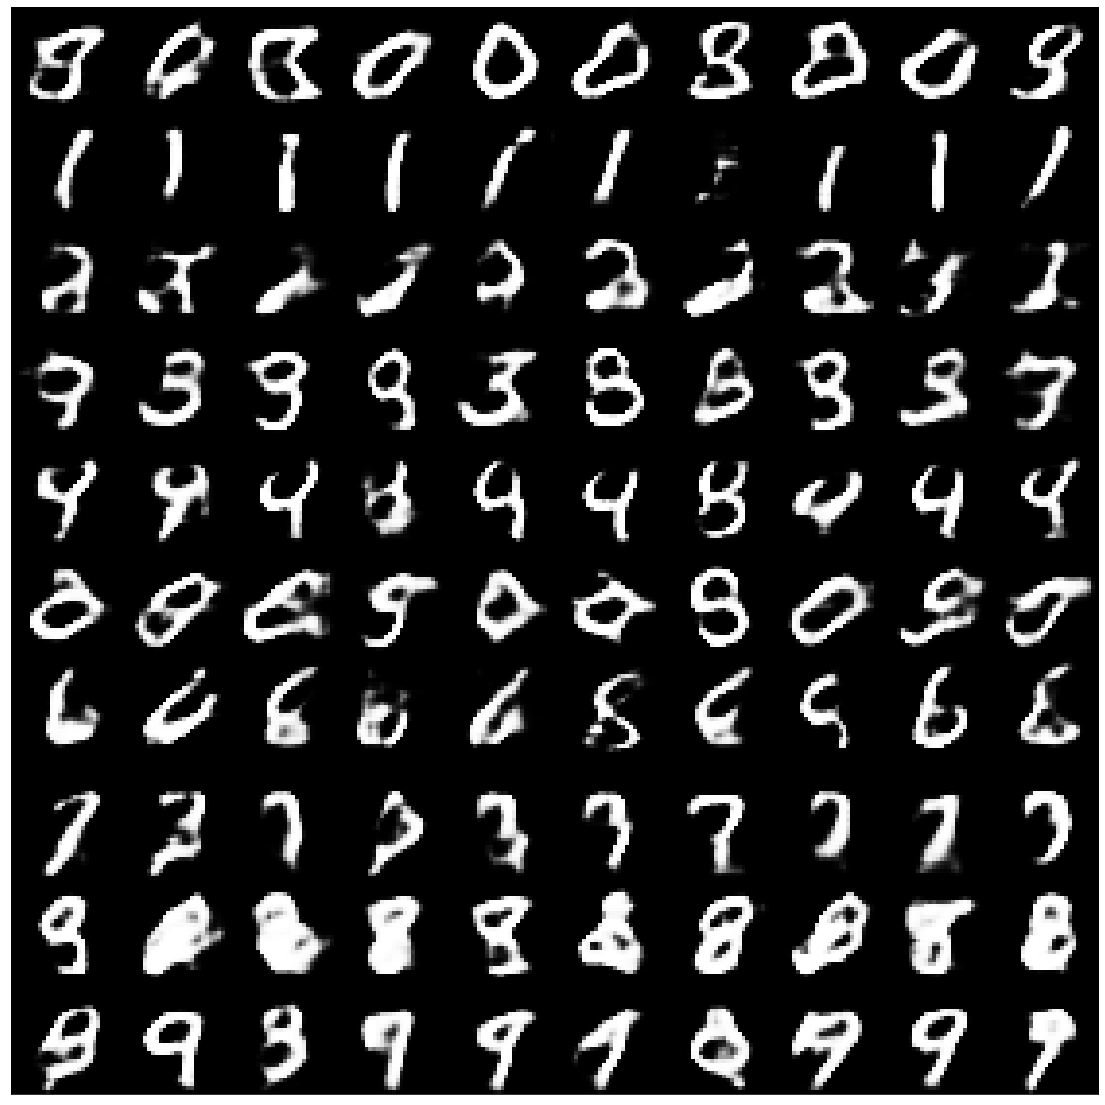

.l_d: 0.474768728017807
.l_d: 0.45229795575141907
.l_d: 0.4768133759498596
.l_d: 0.44348907470703125
.l_d: 0.4043768048286438
.l_d: 0.46096161007881165
.l_d: 0.4201974868774414
.l_d: 0.422896146774292
.l_d: 0.47000959515571594
.l_d: 0.4002341330051422
.l_d: 0.42146146297454834
.l_d: 0.4674752950668335
.l_d: 0.4158179759979248
.l_d: 0.4885712265968323
.l_d: 0.426607221364975
.l_d: 0.4126245379447937
.l_d: 0.4624723494052887
.l_d: 0.4377325177192688
.l_d: 0.4324738383293152
.l_d: 0.4077993631362915
.l_d: 0.41991758346557617
.l_d: 0.41711682081222534
.l_d: 0.4345491826534271
.l_d: 0.45119279623031616
.l_d: 0.40097761154174805
.l_d: 0.4800220727920532
.l_d: 0.4547802805900574
.l_d: 0.46134692430496216
.l_d: 0.4656611979007721
.l_d: 0.4466979503631592
.l_d: 0.4835974872112274
.l_d: 0.45657971501350403
.l_d: 0.4375893771648407
.l_d: 0.4787467420101166
.l_d: 0.5016348361968994
.l_d: 0.470453143119812
.l_d: 0.4358757436275482
.l_d: 0.4330090284347534
.l_d: 0.44435134530067444
.l_d: 0.440835475

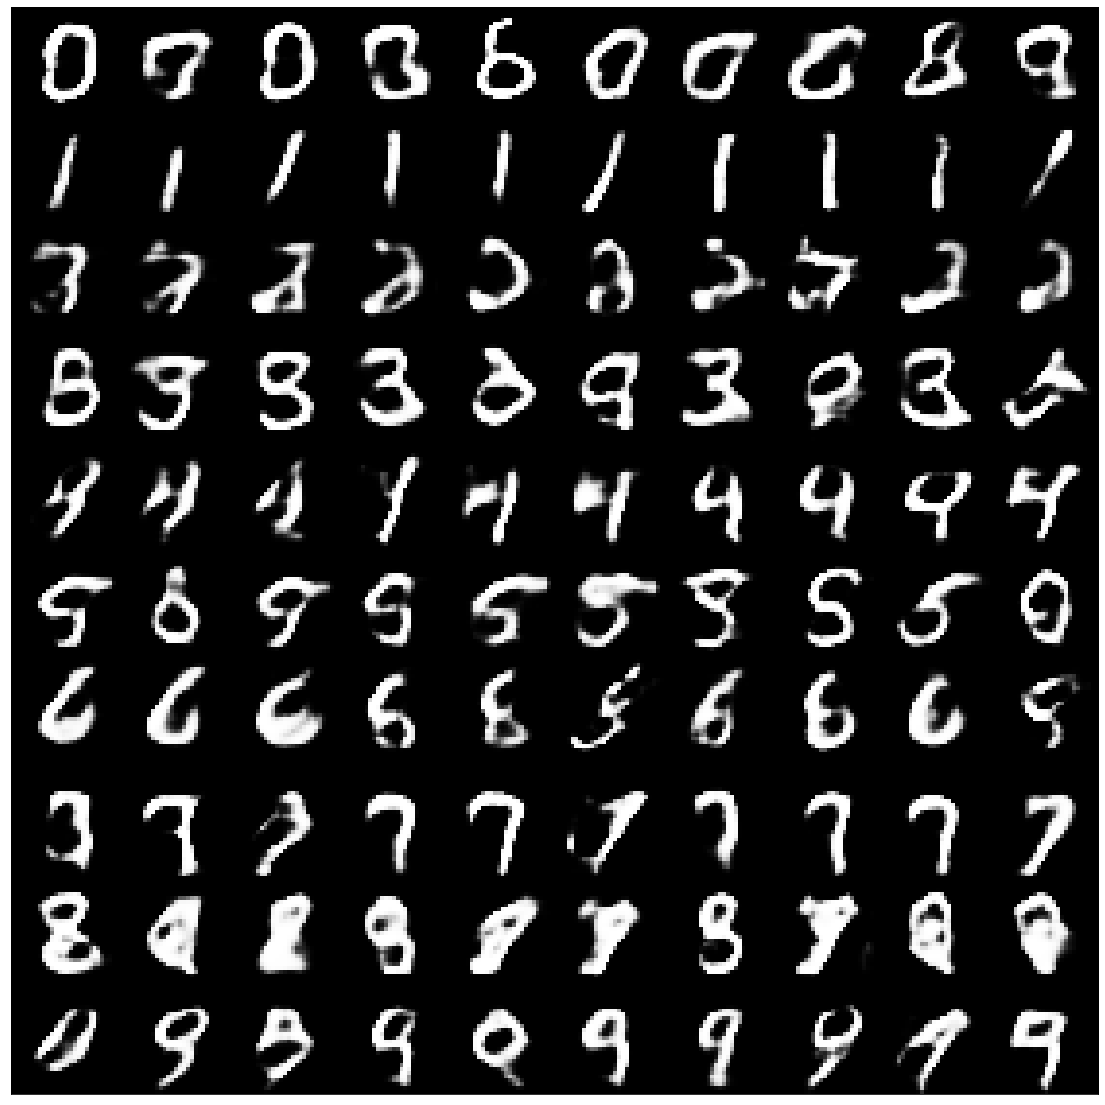

.l_d: 0.43968263268470764
.l_d: 0.4780425727367401
.l_d: 0.4094286859035492
.l_d: 0.4407704472541809
.l_d: 0.4057098627090454
.l_d: 0.45552098751068115
.l_d: 0.4056664705276489
.l_d: 0.4799227714538574
.l_d: 0.4034796357154846
.l_d: 0.5077697038650513
.l_d: 0.45537370443344116
.l_d: 0.45343470573425293
.l_d: 0.47873371839523315
.l_d: 0.47648969292640686
.l_d: 0.4210597276687622
.l_d: 0.49194425344467163
.l_d: 0.44483745098114014
.l_d: 0.4070415496826172
.l_d: 0.4629160761833191
.l_d: 0.5186449289321899
.l_d: 0.4050973951816559
.l_d: 0.41439127922058105
.l_d: 0.4129365086555481
.l_d: 0.44868654012680054
.l_d: 0.4624982476234436
.l_d: 0.4395398497581482
.l_d: 0.48668065667152405
.l_d: 0.4414072632789612
.l_d: 0.40832608938217163
.l_d: 0.4623934030532837
.l_d: 0.4729529619216919
.l_d: 0.42003023624420166
.l_d: 0.43995893001556396
.l_d: 0.5172743797302246
.l_d: 0.47971653938293457
.l_d: 0.47697755694389343
.l_d: 0.4376547336578369
.l_d: 0.4411914050579071
.l_d: 0.4889039397239685
.l_d: 0.4

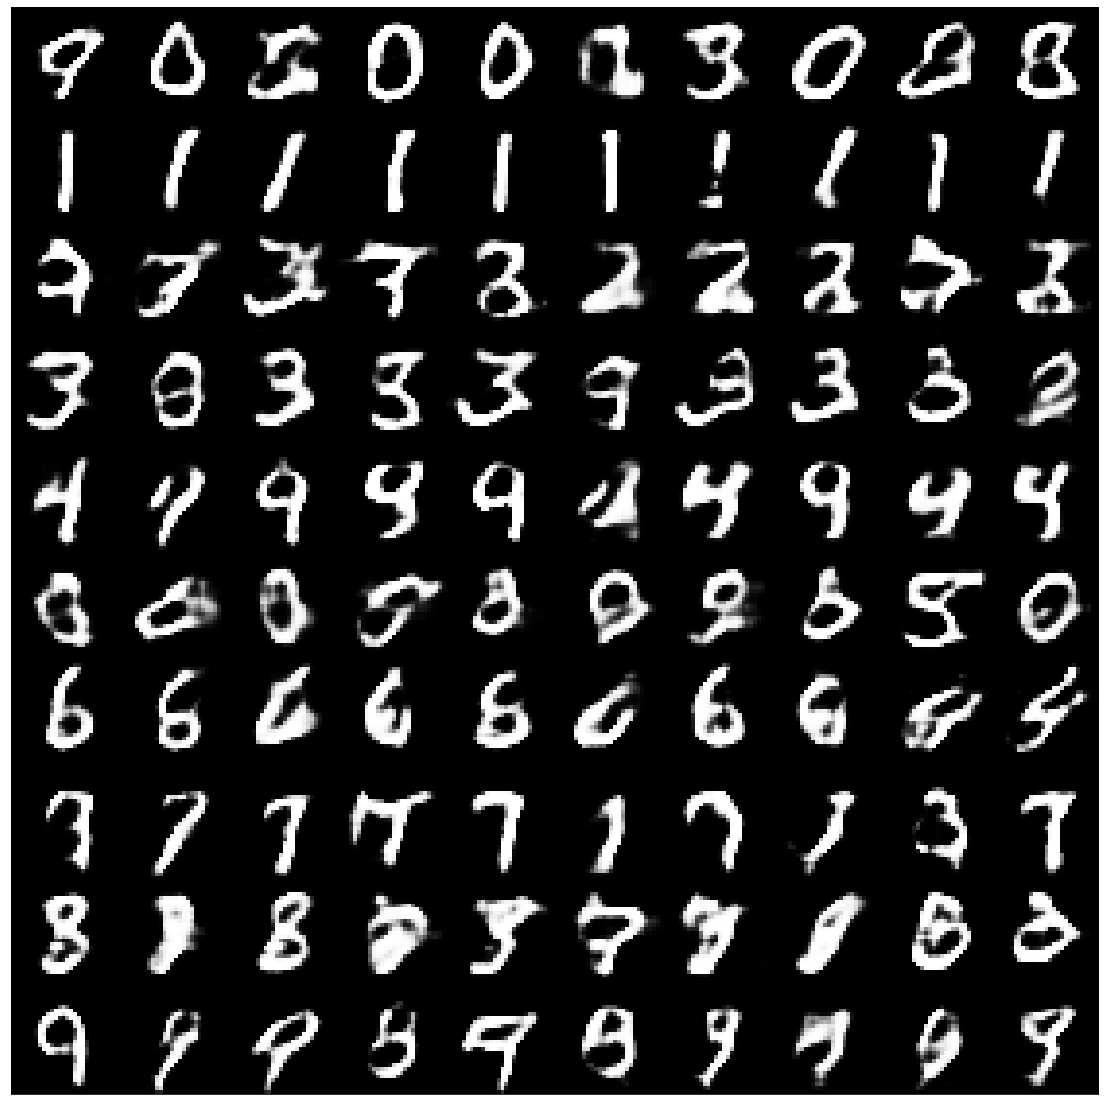

.l_d: 0.5021577477455139
.l_d: 0.4032389223575592
.l_d: 0.4284261465072632
.l_d: 0.47139638662338257
.l_d: 0.4568001925945282
.l_d: 0.42025476694107056
.l_d: 0.4069353938102722
.l_d: 0.503139853477478
.l_d: 0.47585341334342957
.l_d: 0.4805944859981537
.l_d: 0.41681087017059326
.l_d: 0.4213198721408844
.l_d: 0.4529639780521393
.l_d: 0.4261915385723114
.l_d: 0.48918288946151733
.l_d: 0.47091907262802124
.l_d: 0.4265279769897461
.l_d: 0.40729403495788574
.l_d: 0.45979994535446167
.l_d: 0.4111245572566986
.l_d: 0.4070330858230591
.l_d: 0.43943482637405396
.l_d: 0.4320788085460663
.l_d: 0.41673338413238525
.l_d: 0.4371398091316223
.l_d: 0.48646366596221924
.l_d: 0.46415606141090393
.l_d: 0.4562944173812866
.l_d: 0.4838581085205078
.l_d: 0.4561014771461487
.l_d: 0.5052382349967957
.l_d: 0.42899414896965027
.l_d: 0.4340004324913025
.l_d: 0.4032554626464844
.l_d: 0.4090779721736908
.l_d: 0.44190514087677
.l_d: 0.48742377758026123
.l_d: 0.43901652097702026
.l_d: 0.41615286469459534
.l_d: 0.4286

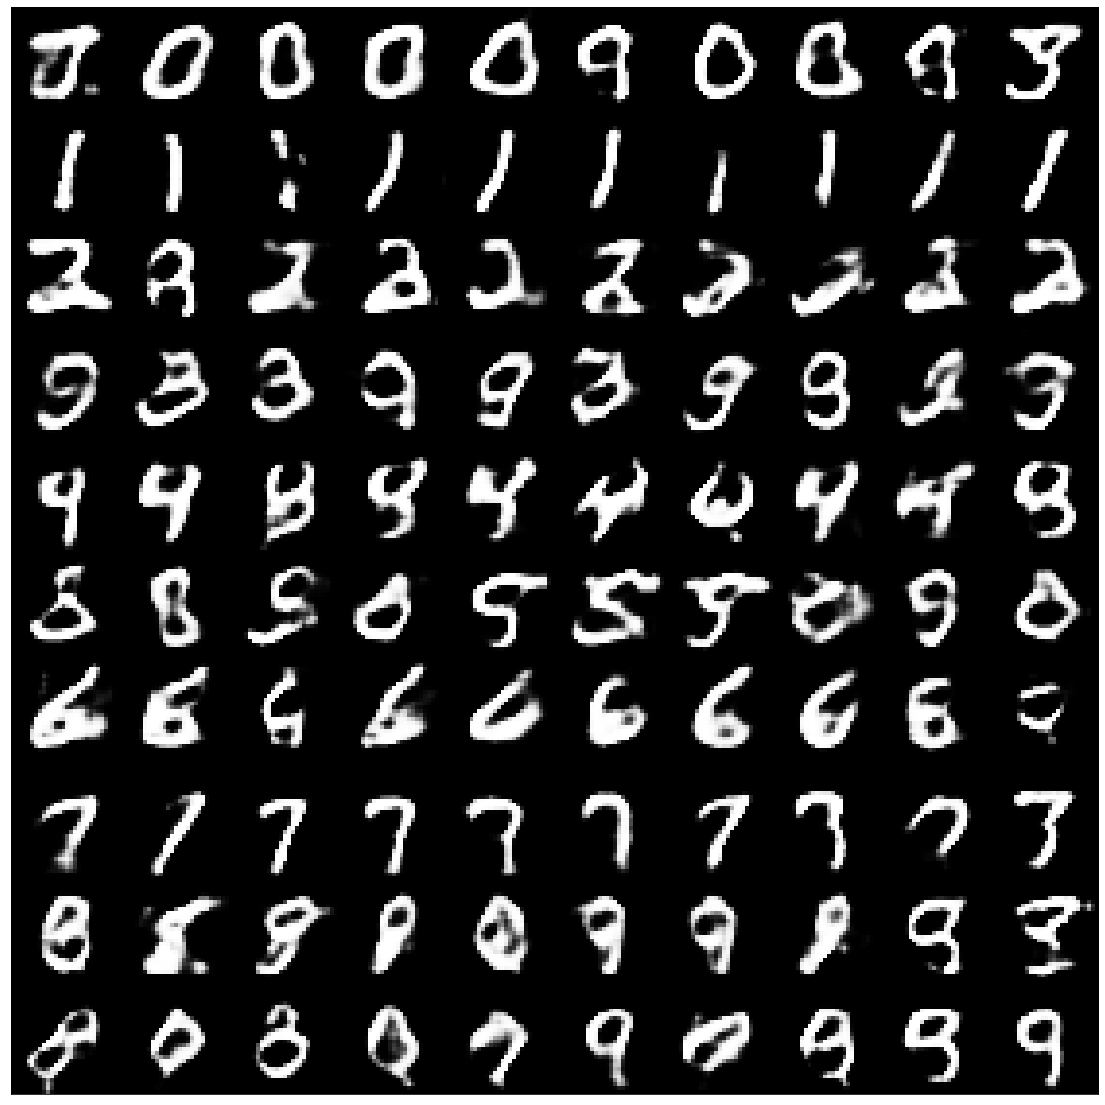

.l_d: 0.41310185194015503
.l_d: 0.4273759126663208
.l_d: 0.44994592666625977
.l_d: 0.4446171224117279
.l_d: 0.4534590542316437
.l_d: 0.41653740406036377
.l_d: 0.44758397340774536
.l_d: 0.42024046182632446
.l_d: 0.4660443067550659
.l_d: 0.44844532012939453
.l_d: 0.44204267859458923
.l_d: 0.4665473401546478
.l_d: 0.4599243700504303
.l_d: 0.40309208631515503
.l_d: 0.46979713439941406
.l_d: 0.45348384976387024
.l_d: 0.460574209690094
.l_d: 0.4051545262336731
.l_d: 0.4440055191516876
.l_d: 0.4675613045692444
.l_d: 0.49036404490470886
.l_d: 0.4391529858112335
.l_d: 0.4177827835083008
.l_d: 0.42859143018722534
.l_d: 0.44741520285606384
.l_d: 0.4663187861442566
.l_d: 0.4540776014328003
.l_d: 0.40630805492401123
.l_d: 0.4134545624256134
.l_d: 0.4126002788543701
.l_d: 0.41549718379974365
.l_d: 0.41478562355041504
.l_d: 0.4930992126464844
.l_d: 0.4558332860469818
.l_d: 0.42935460805892944
.l_d: 0.47203388810157776
.l_d: 0.4437343180179596
.l_d: 0.4774623215198517
.l_d: 0.42535823583602905
.l_d: 0

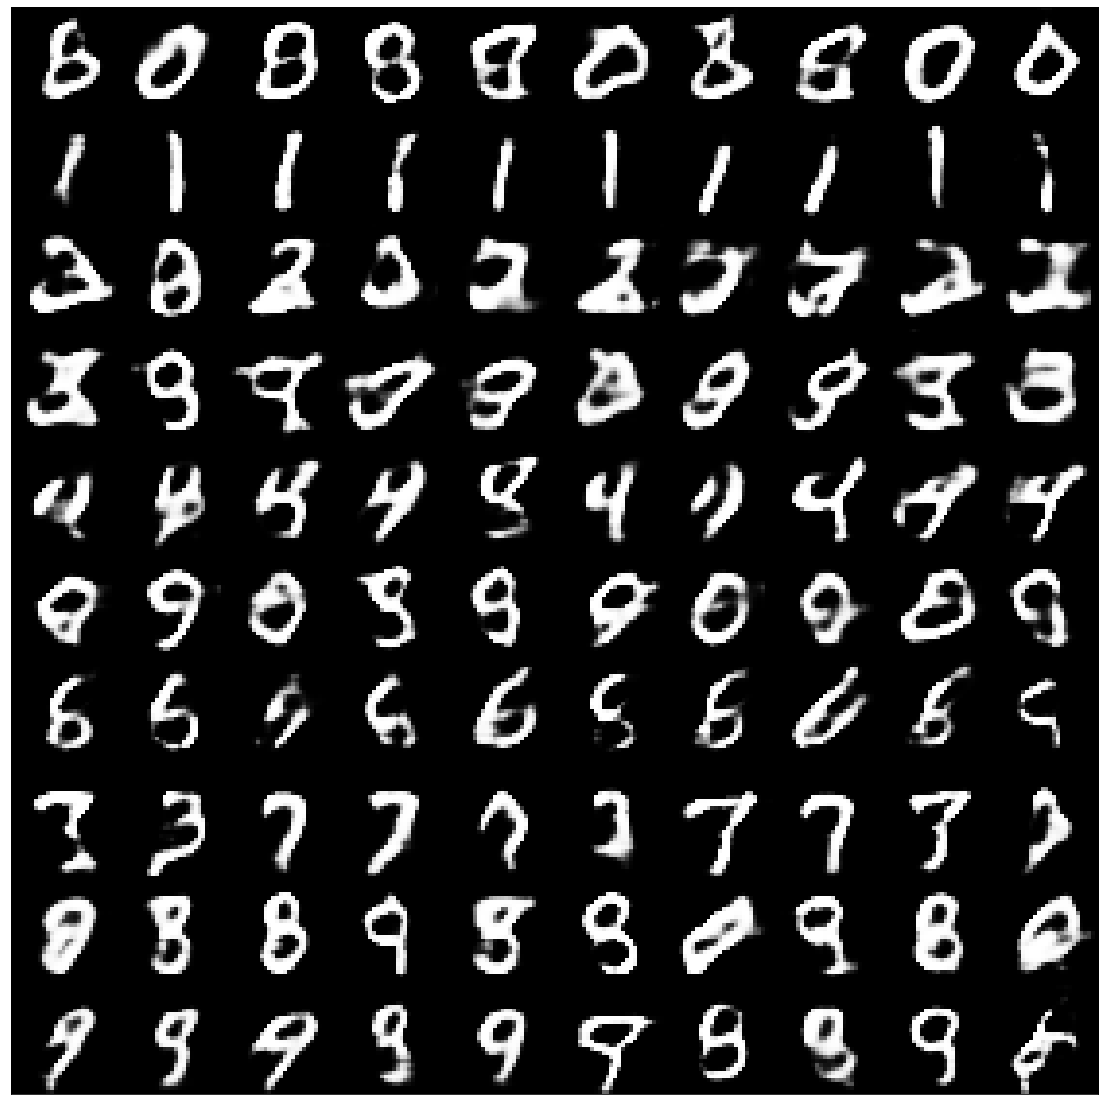

.l_d: 0.43335580825805664
.l_d: 0.42258572578430176
.l_d: 0.43074527382850647
.l_d: 0.46811407804489136
.l_d: 0.46669742465019226
.l_d: 0.4216216802597046
.l_d: 0.4468959867954254
.l_d: 0.42257362604141235
.l_d: 0.40051063895225525
.l_d: 0.4574582874774933
.l_d: 0.464677631855011
.l_d: 0.47411102056503296
.l_d: 0.4561232328414917
.l_d: 0.4295330047607422
.l_d: 0.45099425315856934
.l_d: 0.40612173080444336
.l_d: 0.43867042660713196
.l_d: 0.41570356488227844
.l_d: 0.40789794921875
.l_d: 0.4227971136569977
.l_d: 0.41383546590805054
.l_d: 0.4262724816799164
.l_d: 0.4615474343299866
.l_d: 0.43280044198036194
.l_d: 0.4558548331260681
.l_d: 0.48438721895217896
.l_d: 0.4620254933834076
.l_d: 0.43953078985214233
.l_d: 0.4222400188446045
.l_d: 0.41745397448539734
.l_d: 0.4046836495399475
.l_d: 0.42611104249954224
.l_d: 0.4313742518424988
.l_d: 0.43906211853027344
.l_d: 0.4329259693622589
.l_d: 0.5017024278640747
.l_d: 0.48337221145629883
.l_d: 0.406252384185791
.l_d: 0.4584876596927643
.l_d: 0.5

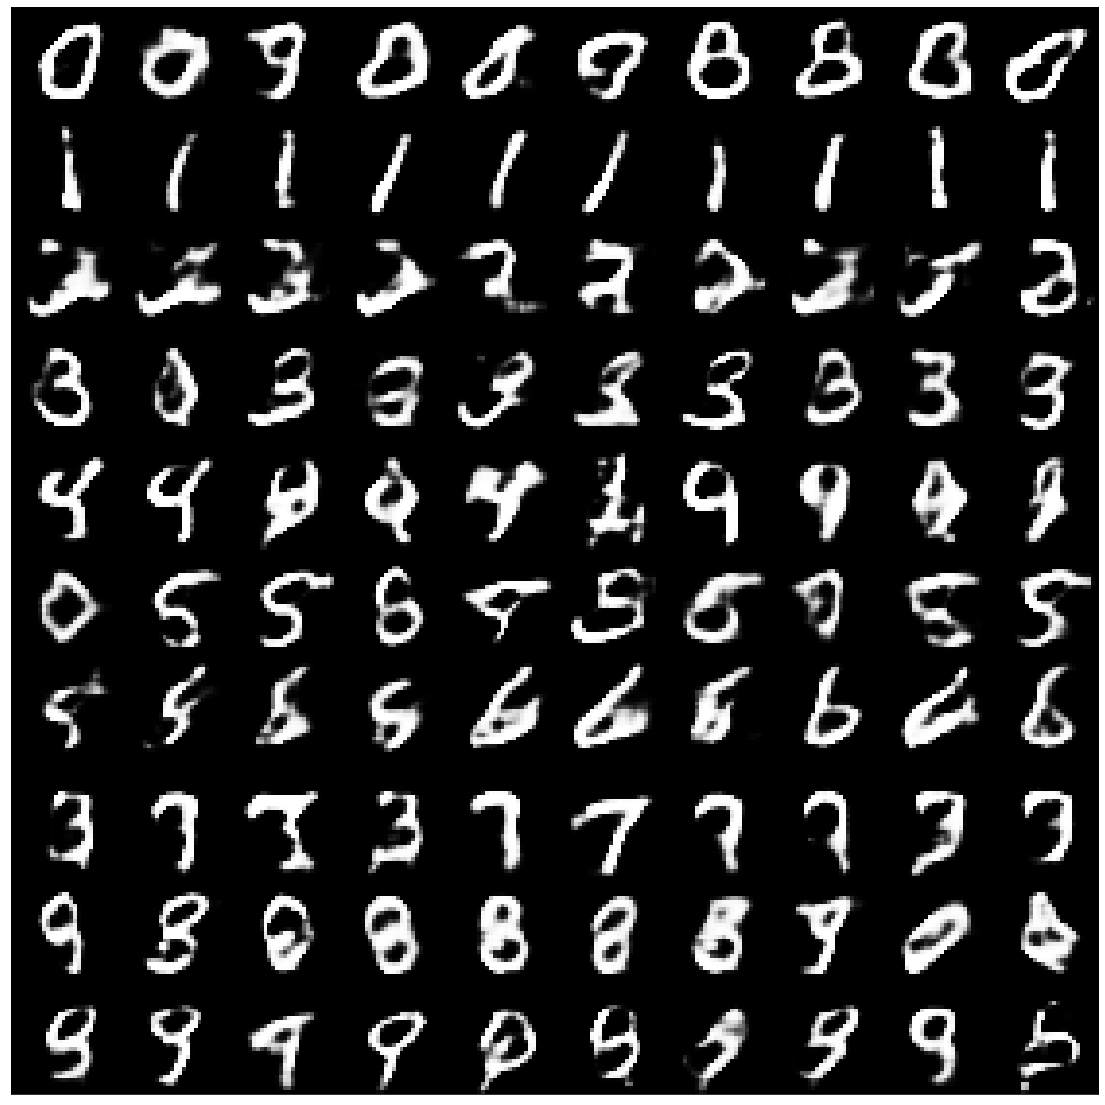

.l_d: 0.3850422501564026
.l_d: 0.4216327667236328
.l_d: 0.4302786588668823
.l_d: 0.4400387406349182
.l_d: 0.46869826316833496
.l_d: 0.524263322353363
.l_d: 0.5320360660552979
.l_d: 0.4188385605812073
.l_d: 0.41153478622436523
.l_d: 0.45038896799087524
.l_d: 0.4052733778953552
.l_d: 0.4138689339160919
.l_d: 0.4296647608280182
.l_d: 0.4314248561859131
.l_d: 0.4034709334373474
.l_d: 0.4171169698238373
.l_d: 0.43478548526763916
.l_d: 0.5086681842803955
.l_d: 0.4351596534252167
.l_d: 0.5014444589614868
.l_d: 0.46914827823638916
.l_d: 0.5263193845748901
.l_d: 0.4670373797416687
.l_d: 0.4108857214450836
.l_d: 0.4025738835334778
.l_d: 0.45734429359436035
.l_d: 0.4260220527648926
.l_d: 0.4048961400985718
.l_d: 0.40479981899261475
.l_d: 0.4074023365974426
.l_d: 0.42497748136520386
.l_d: 0.42069748044013977
.l_d: 0.43661272525787354
.l_d: 0.5500885248184204
.l_d: 0.5730493068695068
.l_d: 0.47059887647628784
.l_d: 0.4215736985206604
.l_d: 0.4541742503643036
.l_d: 0.492665559053421
.l_d: 0.45819723

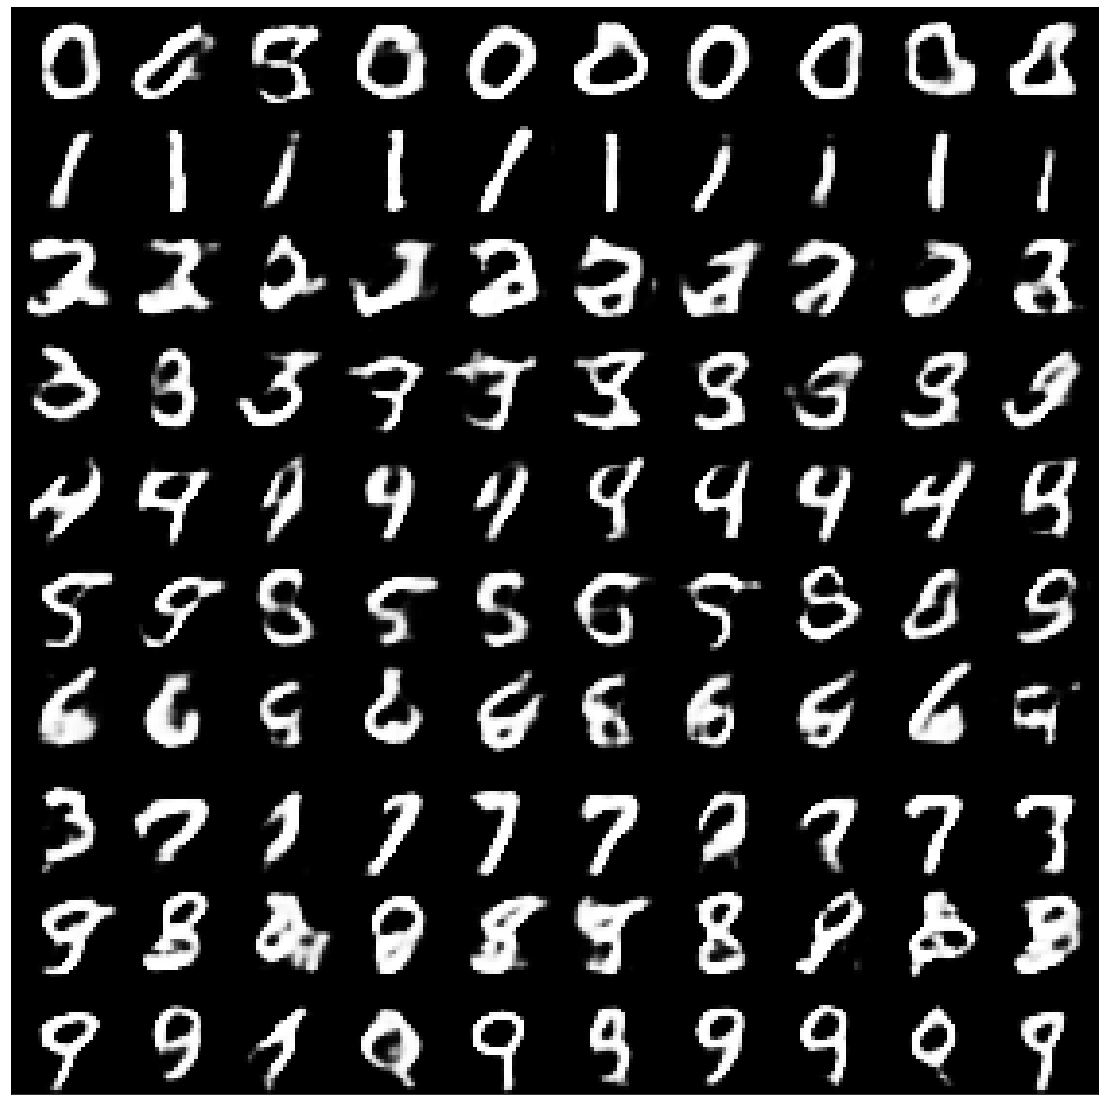

.l_d: 0.42996683716773987
.l_d: 0.400210976600647
.l_d: 0.4208798110485077
.l_d: 0.4215605854988098
.l_d: 0.45627304911613464
.l_d: 0.4564666748046875
.l_d: 0.5004869699478149
.l_d: 0.43719470500946045
.l_d: 0.40760841965675354
.l_d: 0.4973389506340027
.l_d: 0.45344963669776917
.l_d: 0.42228883504867554
.l_d: 0.42212942242622375
.l_d: 0.41825467348098755
.l_d: 0.4011778235435486
.l_d: 0.43303781747817993
.l_d: 0.5446655750274658
.l_d: 0.5191351175308228
.l_d: 0.4109913408756256
.l_d: 0.4213449954986572
.l_d: 0.4973765015602112
.l_d: 0.42082351446151733
.l_d: 0.4280302822589874
.l_d: 0.4008787274360657
.l_d: 0.40318137407302856
.l_d: 0.4532831311225891
.l_d: 0.4568515419960022
.l_d: 0.46535003185272217
.l_d: 0.4602506756782532
.l_d: 0.4655686020851135
.l_d: 0.548772931098938
.l_d: 0.42751938104629517
.l_d: 0.41668519377708435
.l_d: 0.420937716960907
.l_d: 0.40989574790000916
.l_d: 0.44558948278427124
.l_d: 0.40700864791870117
.l_d: 0.4171644151210785
.l_d: 0.42183226346969604
.l_d: 0.41

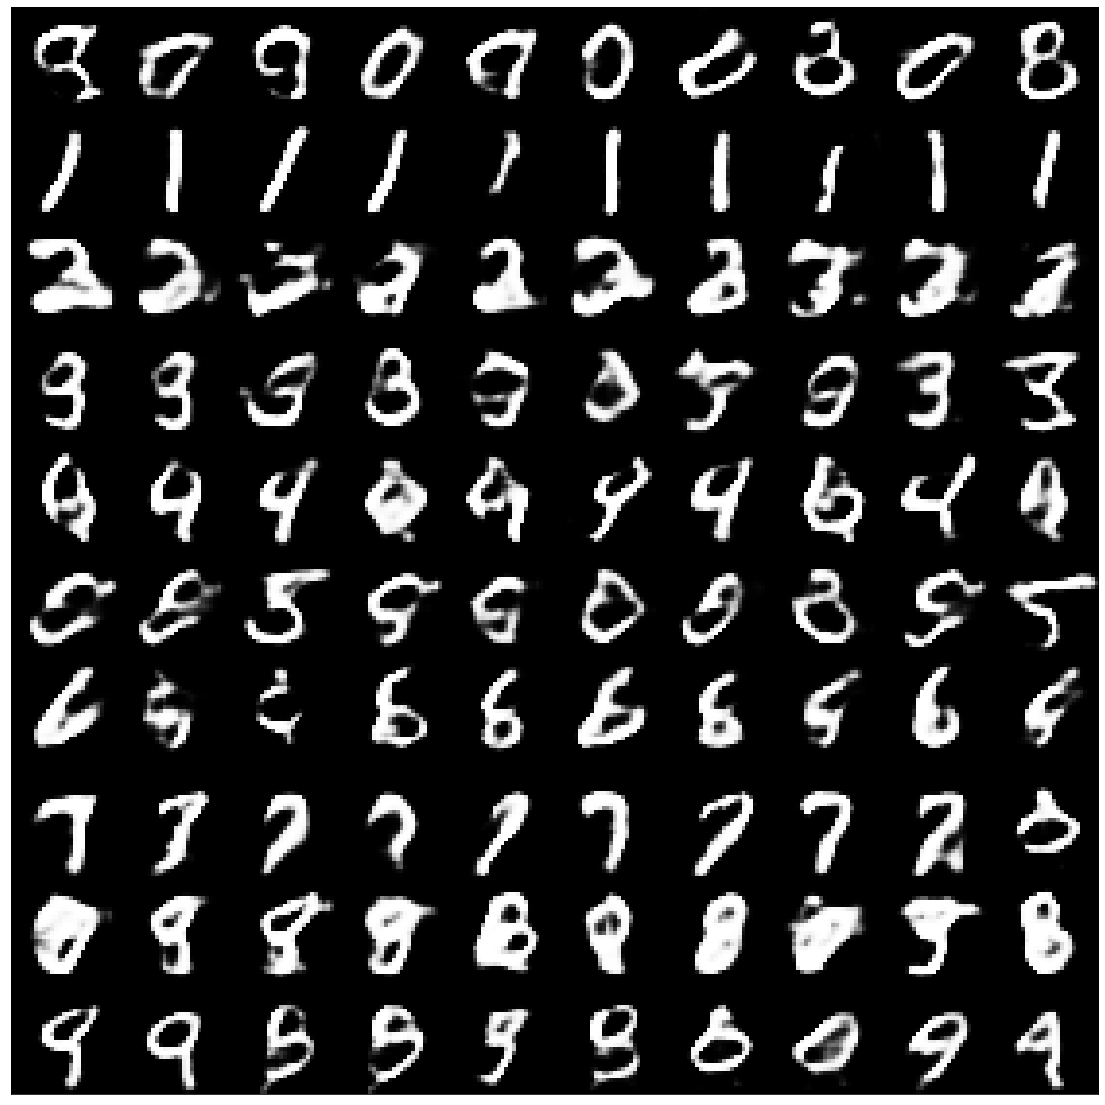

.l_d: 0.4328056871891022
.l_d: 0.4166150689125061
.l_d: 0.4305914342403412
.l_d: 0.4347226023674011
.l_d: 0.4612548053264618
.l_d: 0.4291825294494629
.l_d: 0.4056592583656311
.l_d: 0.4577716290950775
.l_d: 0.4901120066642761
.l_d: 0.5034943222999573
.l_d: 0.5183877348899841
.l_d: 0.4506175220012665
.l_d: 0.4781498610973358
.l_d: 0.41987043619155884
.l_d: 0.419365257024765
.l_d: 0.4513866901397705
.l_d: 0.4081993103027344
.l_d: 0.42508015036582947
.l_d: 0.4143938720226288
.l_d: 0.4517872631549835
.l_d: 0.4068550765514374
.l_d: 0.40809229016304016
.l_d: 0.41347020864486694
.l_d: 0.4412532448768616
.l_d: 0.4254347085952759
.l_d: 0.4678187072277069
.l_d: 0.44635745882987976
.l_d: 0.40324297547340393
.l_d: 0.4045991003513336
.l_d: 0.42120397090911865
.l_d: 0.4379321038722992
.l_d: 0.5177783966064453
.l_d: 0.5002599358558655
.l_d: 0.42761674523353577
.l_d: 0.4170990586280823
.l_d: 0.4671346843242645
.l_d: 0.41816550493240356
.l_d: 0.41874998807907104
.l_d: 0.4327470362186432
.l_d: 0.43245878

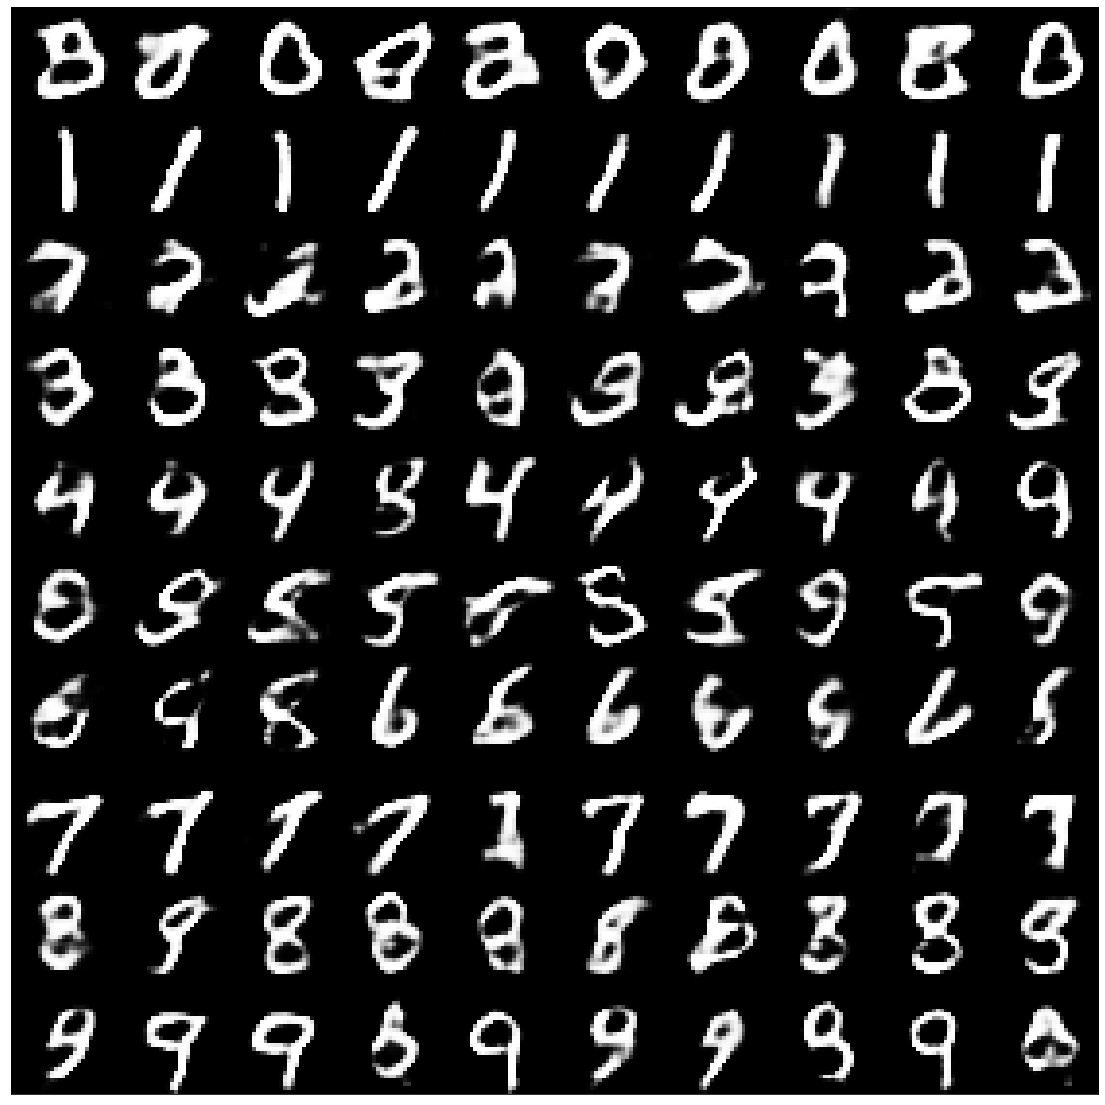

.l_d: 0.42237621545791626
.l_d: 0.4782944321632385
.l_d: 0.41417205333709717
.l_d: 0.3980686068534851
.l_d: 0.484258770942688
.l_d: 0.4005526304244995
.l_d: 0.4277656078338623
.l_d: 0.4270705282688141
.l_d: 0.4049859046936035
.l_d: 0.46570050716400146
.l_d: 0.4694731831550598
.l_d: 0.5253139138221741
.l_d: 0.4802895486354828
.l_d: 0.48841187357902527
.l_d: 0.45818448066711426
.l_d: 0.45007553696632385
.l_d: 0.4393060803413391
.l_d: 0.4303874373435974
.l_d: 0.4391591250896454
.l_d: 0.40284064412117004
.l_d: 0.4047932028770447
.l_d: 0.4186425805091858
.l_d: 0.4673699140548706
.l_d: 0.4011838436126709
.l_d: 0.4679426848888397
.l_d: 0.43622004985809326
.l_d: 0.4002273976802826
.l_d: 0.4597020745277405
.l_d: 0.4437580108642578
.l_d: 0.42797499895095825
.l_d: 0.4146583080291748
.l_d: 0.43222078680992126
.l_d: 0.4436725378036499
.l_d: 0.43842434883117676
.l_d: 0.5248785018920898
.l_d: 0.48367273807525635
.l_d: 0.4102633595466614
.l_d: 0.4202561378479004
.l_d: 0.407440185546875
.l_d: 0.4180414

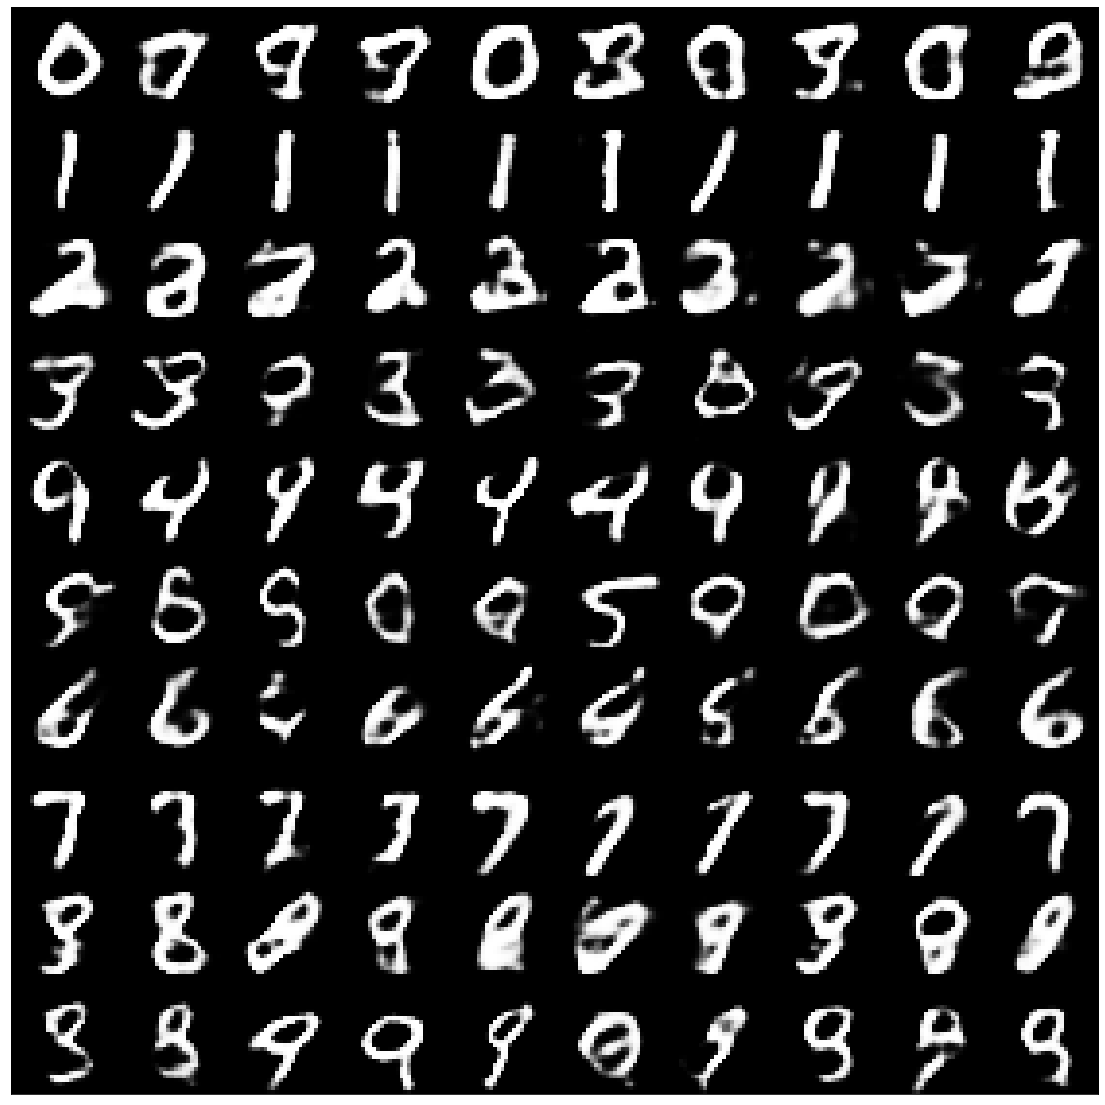

.l_d: 0.4798455834388733
.l_d: 0.5206385254859924
.l_d: 0.42924392223358154
.l_d: 0.4525330662727356
.l_d: 0.45876848697662354
.l_d: 0.4595693349838257
.l_d: 0.4657178223133087
.l_d: 0.430380642414093
.l_d: 0.4243178367614746
.l_d: 0.4020359516143799
.l_d: 0.41564565896987915
.l_d: 0.45115330815315247
.l_d: 0.4651221036911011
.l_d: 0.42611074447631836
.l_d: 0.4527721405029297
.l_d: 0.45281851291656494
.l_d: 0.42178061604499817
.l_d: 0.45397546887397766
.l_d: 0.48653990030288696
.l_d: 0.4162241220474243
.l_d: 0.47268325090408325
.l_d: 0.4151158034801483
.l_d: 0.4960620701313019
.l_d: 0.43049532175064087
.l_d: 0.4052969515323639
.l_d: 0.44219428300857544
.l_d: 0.4097544550895691
.l_d: 0.4355483055114746
.l_d: 0.43604838848114014
.l_d: 0.44643425941467285
.l_d: 0.4838661551475525
.l_d: 0.44062572717666626
.l_d: 0.427592009305954
.l_d: 0.4643588066101074
.l_d: 0.4135218858718872
.l_d: 0.4047527015209198
.l_d: 0.42483294010162354
.l_d: 0.4021853804588318
.l_d: 0.34435248374938965
.l_d: 0.43

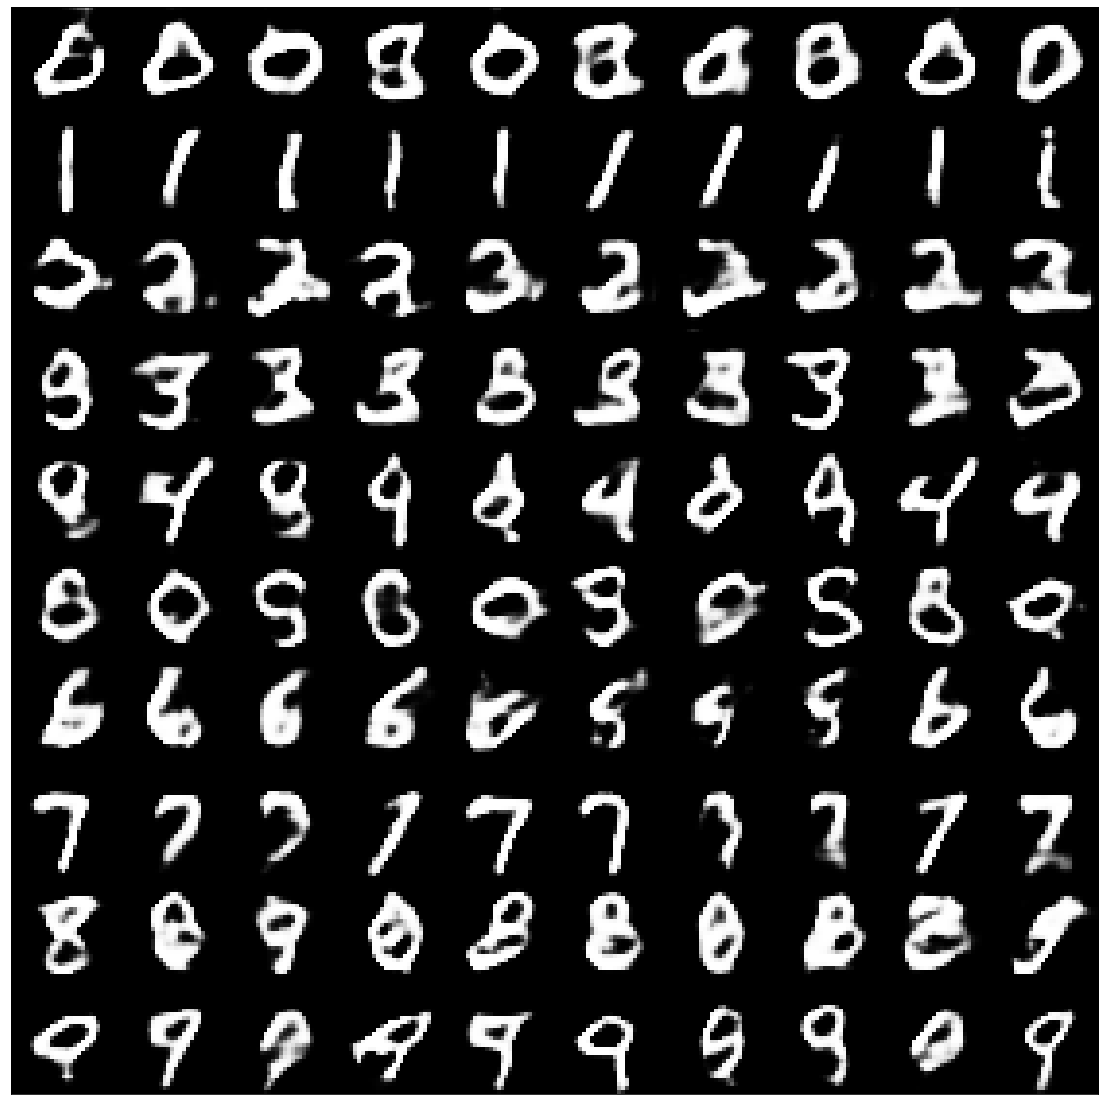

.l_d: 0.47482091188430786
.l_d: 0.5258899927139282
.l_d: 0.48148012161254883
.l_d: 0.42571765184402466
.l_d: 0.42814919352531433
.l_d: 0.4216882586479187
.l_d: 0.43201667070388794
.l_d: 0.4080822467803955
.l_d: 0.46609169244766235
.l_d: 0.4879099130630493
.l_d: 0.418934166431427
.l_d: 0.4775969684123993
.l_d: 0.4546317458152771
.l_d: 0.4748373031616211
.l_d: 0.4205121695995331
.l_d: 0.44627857208251953
.l_d: 0.493245393037796
.l_d: 0.47905418276786804
.l_d: 0.418371319770813
.l_d: 0.4695451855659485
.l_d: 0.46008771657943726
.l_d: 0.4088688790798187
.l_d: 0.41740959882736206
.l_d: 0.4017956256866455
.l_d: 0.45574235916137695
.l_d: 0.4038936495780945
.l_d: 0.43086469173431396
.l_d: 0.4480328857898712
.l_d: 0.4414004683494568
.l_d: 0.4844732880592346
.l_d: 0.4281998872756958
.l_d: 0.46848636865615845
.l_d: 0.42412272095680237
.l_d: 0.4222235381603241
.l_d: 0.47477418184280396
.l_d: 0.4317532777786255
.l_d: 0.47275906801223755
.l_d: 0.4365517199039459
.l_d: 0.5642030239105225
.l_d: 0.4741

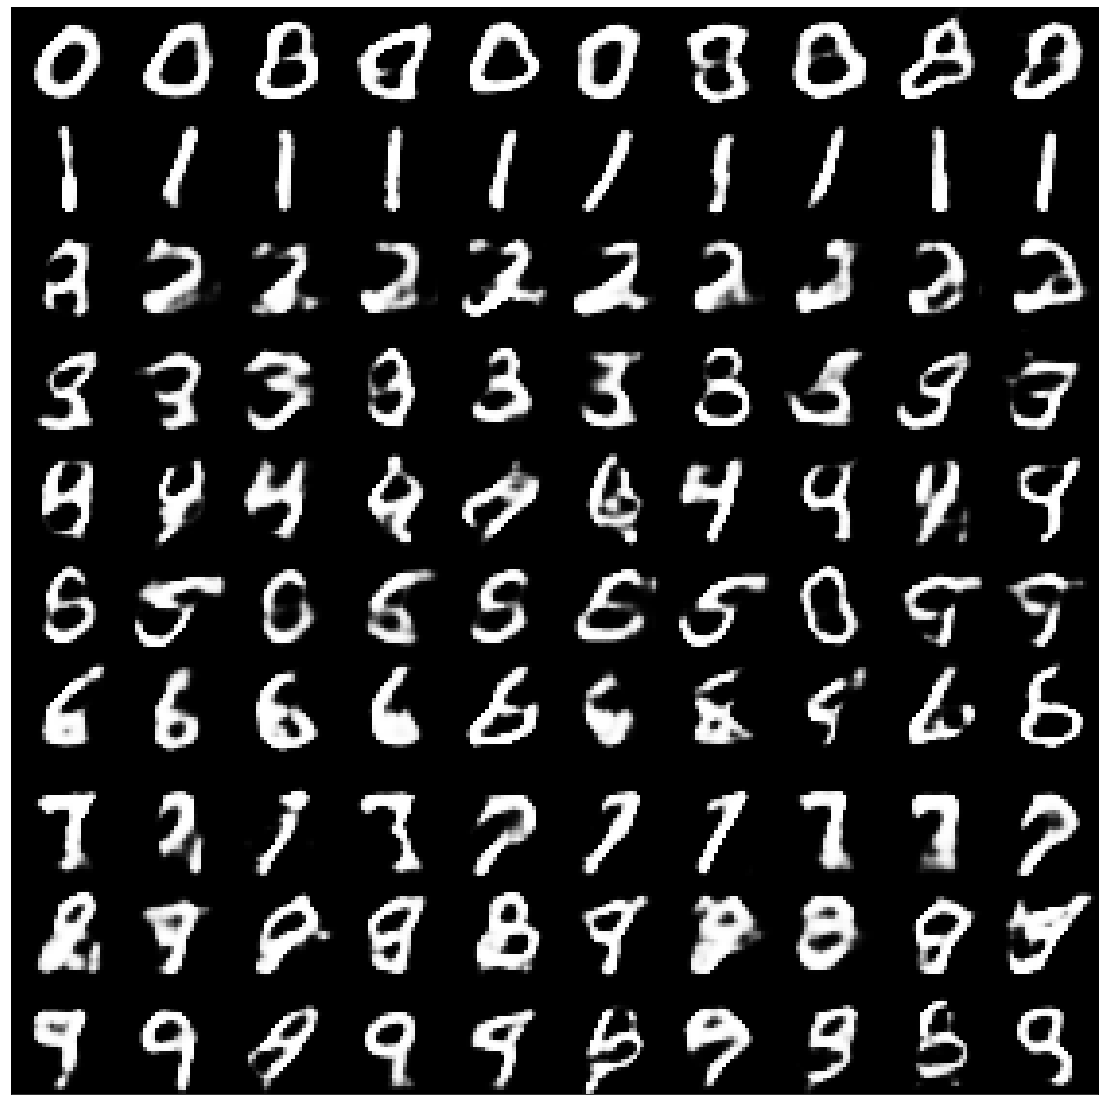

.l_d: 0.4288526773452759
.l_d: 0.42555272579193115
.l_d: 0.4338277280330658
.l_d: 0.4499581754207611
.l_d: 0.4415697753429413
.l_d: 0.4594058394432068
.l_d: 0.4089916944503784
.l_d: 0.4534386694431305
.l_d: 0.42894893884658813
.l_d: 0.4468642473220825
.l_d: 0.4005223512649536
.l_d: 0.41186559200286865
.l_d: 0.4397308826446533
.l_d: 0.4665851593017578
.l_d: 0.42596644163131714
.l_d: 0.5326648950576782
.l_d: 0.4173091650009155
.l_d: 0.44908732175827026
.l_d: 0.4434278905391693
.l_d: 0.40428030490875244
.l_d: 0.45499691367149353
.l_d: 0.5316837430000305
.l_d: 0.4122562110424042
.l_d: 0.40691840648651123
.l_d: 0.4555816054344177
.l_d: 0.41549718379974365
.l_d: 0.4121516942977905
.l_d: 0.41525402665138245
.l_d: 0.4093632996082306
.l_d: 0.4188171625137329
.l_d: 0.4128603935241699
.l_d: 0.4368201196193695
.l_d: 0.4673241972923279
.l_d: 0.4531329572200775
.l_d: 0.41127216815948486
.l_d: 0.5164945125579834
.l_d: 0.4575996398925781
.l_d: 0.44323307275772095
.l_d: 0.49788424372673035
.l_d: 0.4265

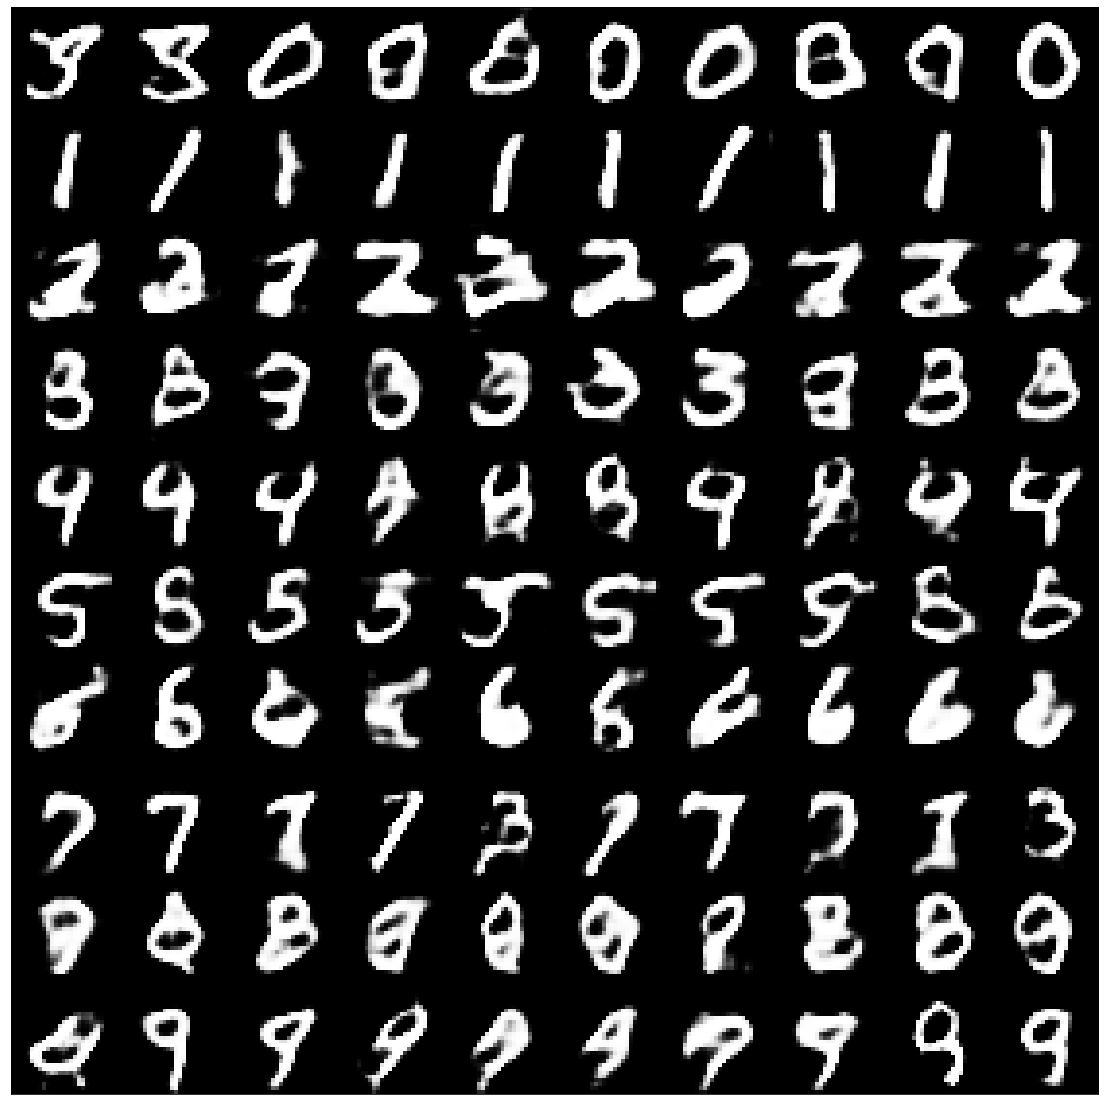

.l_d: 0.44060471653938293
.l_d: 0.46536481380462646
.l_d: 0.466763436794281
.l_d: 0.4276520907878876
.l_d: 0.4011859893798828
.l_d: 0.4334489703178406
.l_d: 0.4225580096244812
.l_d: 0.44001996517181396
.l_d: 0.4130275845527649
.l_d: 0.427573561668396
.l_d: 0.46982842683792114
.l_d: 0.4633273482322693
.l_d: 0.42976275086402893
.l_d: 0.4433465003967285
.l_d: 0.44854849576950073
.l_d: 0.44093799591064453
.l_d: 0.41601115465164185
.l_d: 0.42964446544647217
.l_d: 0.4722828269004822
.l_d: 0.4417873024940491
.l_d: 0.4174708425998688
.l_d: 0.4345993101596832
.l_d: 0.4900093674659729
.l_d: 0.41154444217681885
.l_d: 0.4426237940788269
.l_d: 0.43239033222198486
.l_d: 0.4284244179725647
.l_d: 0.4009053409099579
.l_d: 0.4440271258354187
.l_d: 0.4726073741912842
.l_d: 0.4245266318321228
.l_d: 0.44219860434532166
.l_d: 0.41420742869377136
.l_d: 0.4856194257736206
.l_d: 0.4368056058883667
.l_d: 0.4817725718021393
.l_d: 0.41726309061050415
.l_d: 0.4029717445373535
.l_d: 0.43265295028686523
.l_d: 0.4051

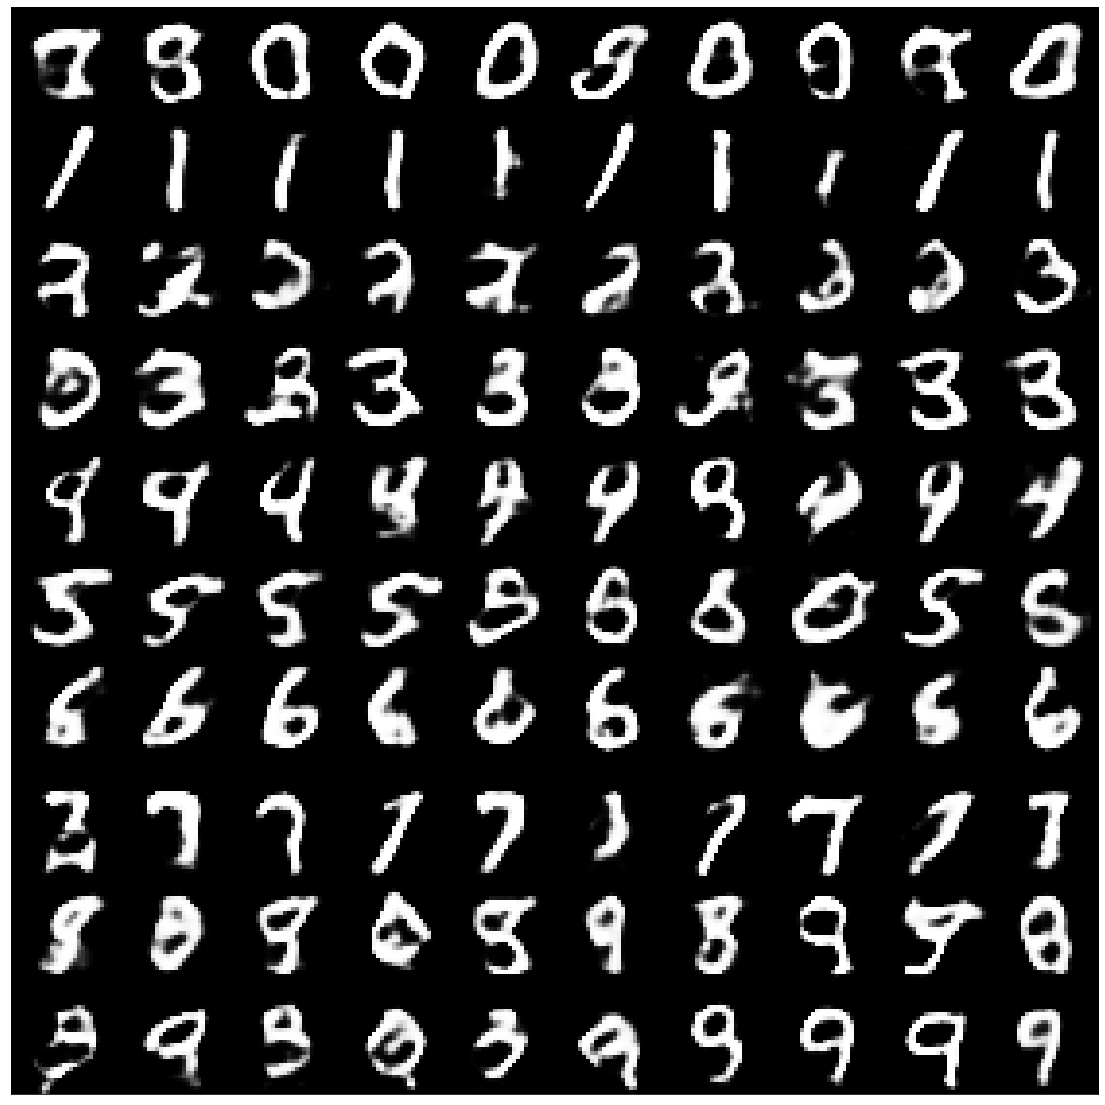

.l_d: 0.4391939043998718
.l_d: 0.48884254693984985
.l_d: 0.45280951261520386
.l_d: 0.4508321285247803
.l_d: 0.40467768907546997
.l_d: 0.4135797619819641
.l_d: 0.40261411666870117
.l_d: 0.4828055202960968
.l_d: 0.4201591908931732
.l_d: 0.40969330072402954
.l_d: 0.4347558617591858
.l_d: 0.42967841029167175
.l_d: 0.4620533287525177
.l_d: 0.48117586970329285
.l_d: 0.5091830492019653
.l_d: 0.418855756521225
.l_d: 0.448050856590271
.l_d: 0.5105568170547485
.l_d: 0.4281231462955475
.l_d: 0.4143640100955963
.l_d: 0.40277183055877686
.l_d: 0.4310271143913269
.l_d: 0.4146779179573059
.l_d: 0.40897053480148315
.l_d: 0.41967806220054626
.l_d: 0.413092702627182
.l_d: 0.4288889467716217
.l_d: 0.48473531007766724
.l_d: 0.418354332447052
.l_d: 0.4245651066303253
.l_d: 0.4825754165649414
.l_d: 0.42269814014434814
.l_d: 0.41911381483078003
.l_d: 0.4207836389541626
.l_d: 0.4194425940513611
.l_d: 0.4089049696922302
.l_d: 0.42553845047950745
.l_d: 0.42208003997802734
.l_d: 0.44287174940109253
.l_d: 0.44790

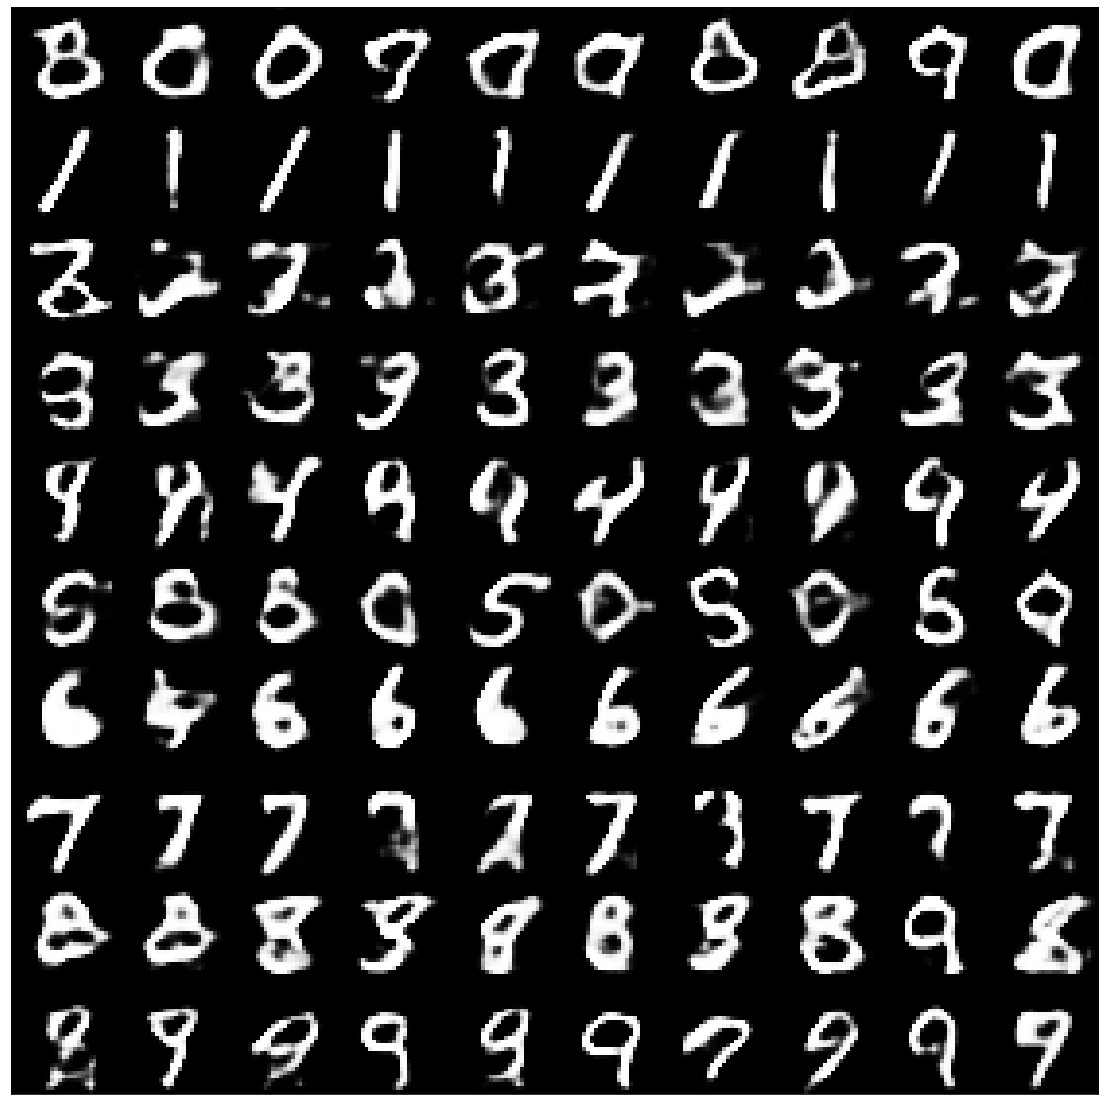

.l_d: 0.4262387752532959
.l_d: 0.4138667583465576
.l_d: 0.5022473931312561
.l_d: 0.46434441208839417
.l_d: 0.4175964295864105
.l_d: 0.41657307744026184
.l_d: 0.446586549282074
.l_d: 0.4813689887523651
.l_d: 0.4054557681083679
.l_d: 0.42119771242141724
.l_d: 0.4516752064228058
.l_d: 0.5500028729438782
.l_d: 0.5442330241203308
.l_d: 0.4450451135635376
.l_d: 0.4708538055419922
.l_d: 0.43811720609664917
.l_d: 0.42495110630989075
.l_d: 0.40158790349960327
.l_d: 0.40021371841430664
.l_d: 0.49729087948799133
.l_d: 0.45130348205566406
.l_d: 0.40947434306144714
.l_d: 0.46071380376815796
.l_d: 0.40152785181999207
.l_d: 0.40782198309898376
.l_d: 0.41513150930404663
.l_d: 0.48741990327835083
.l_d: 0.4413566589355469
.l_d: 0.48982739448547363
.l_d: 0.43947866559028625
.l_d: 0.3400687575340271
.l_d: 0.4428548514842987
.l_d: 0.4624912738800049
.l_d: 0.43564942479133606
.l_d: 0.4012250602245331
.l_d: 0.4678809940814972
.l_d: 0.43100035190582275
.l_d: 0.5455629229545593
.l_d: 0.44885629415512085
.l_d: 

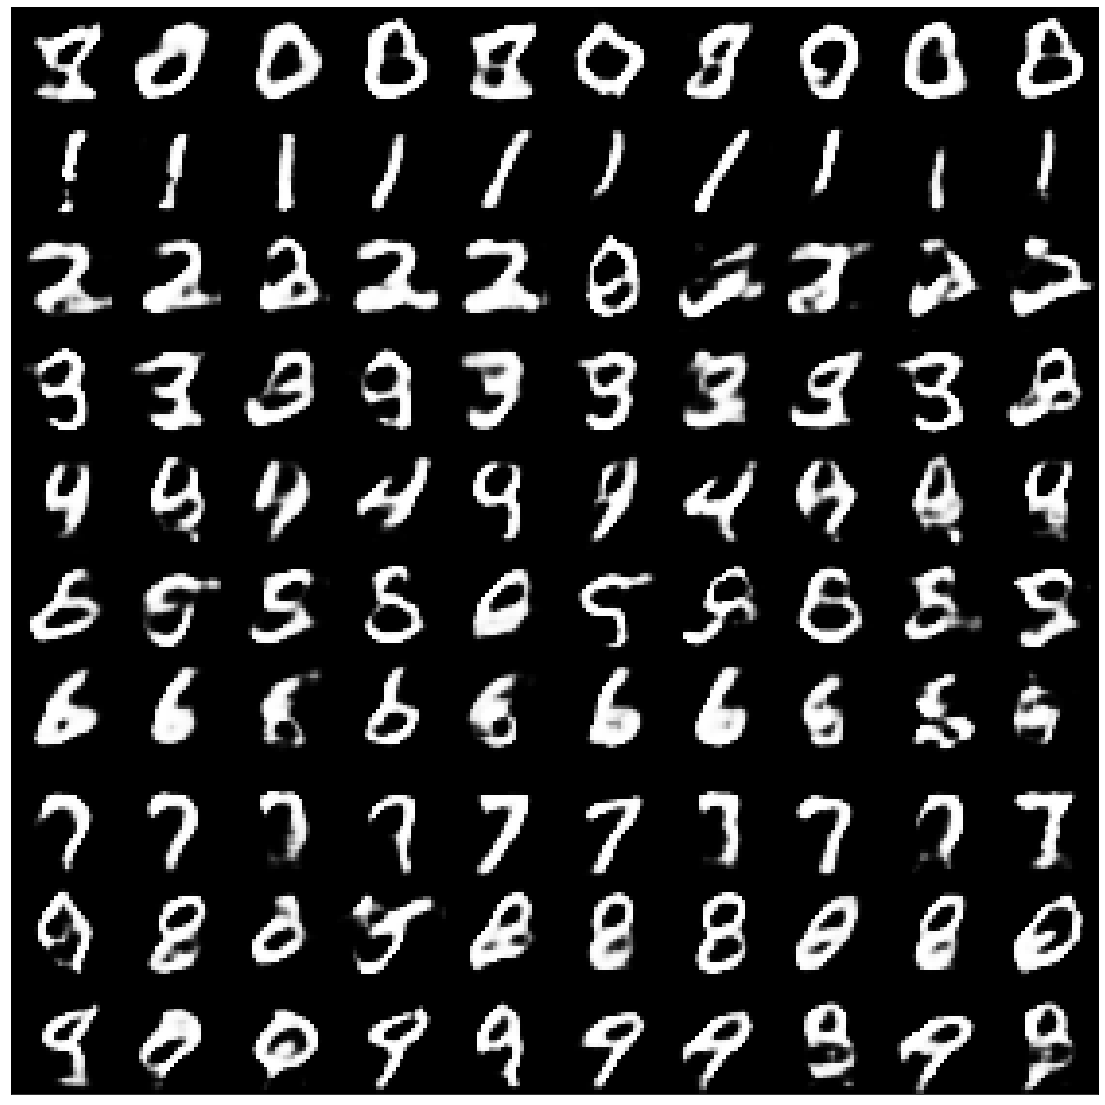

.l_d: 0.40886783599853516
.l_d: 0.4396900534629822
.l_d: 0.48195403814315796
.l_d: 0.4811393618583679
.l_d: 0.4528777301311493
.l_d: 0.5115675330162048
.l_d: 0.42580780386924744
.l_d: 0.4129959046840668
.l_d: 0.4340435564517975
.l_d: 0.4590168297290802
.l_d: 0.428149551153183
.l_d: 0.405287504196167
.l_d: 0.4087485671043396
.l_d: 0.42361199855804443
.l_d: 0.4533529579639435
.l_d: 0.4442852735519409
.l_d: 0.4503175914287567
.l_d: 0.4483462870121002
.l_d: 0.40964752435684204
.l_d: 0.410899817943573
.l_d: 0.40602853894233704
.l_d: 0.5225350260734558
.l_d: 0.41200539469718933
.l_d: 0.45826590061187744
.l_d: 0.49803033471107483
.l_d: 0.46625903248786926
.l_d: 0.4747951924800873
.l_d: 0.4224693179130554
.l_d: 0.46319055557250977
.l_d: 0.44666630029678345
.l_d: 0.4270642399787903
.l_d: 0.46934986114501953
.l_d: 0.4953211545944214
.l_d: 0.4755639135837555
.l_d: 0.4441235065460205
.l_d: 0.4448070526123047
.l_d: 0.41459769010543823
.l_d: 0.44889718294143677
.l_d: 0.4540829658508301
.l_d: 0.43187

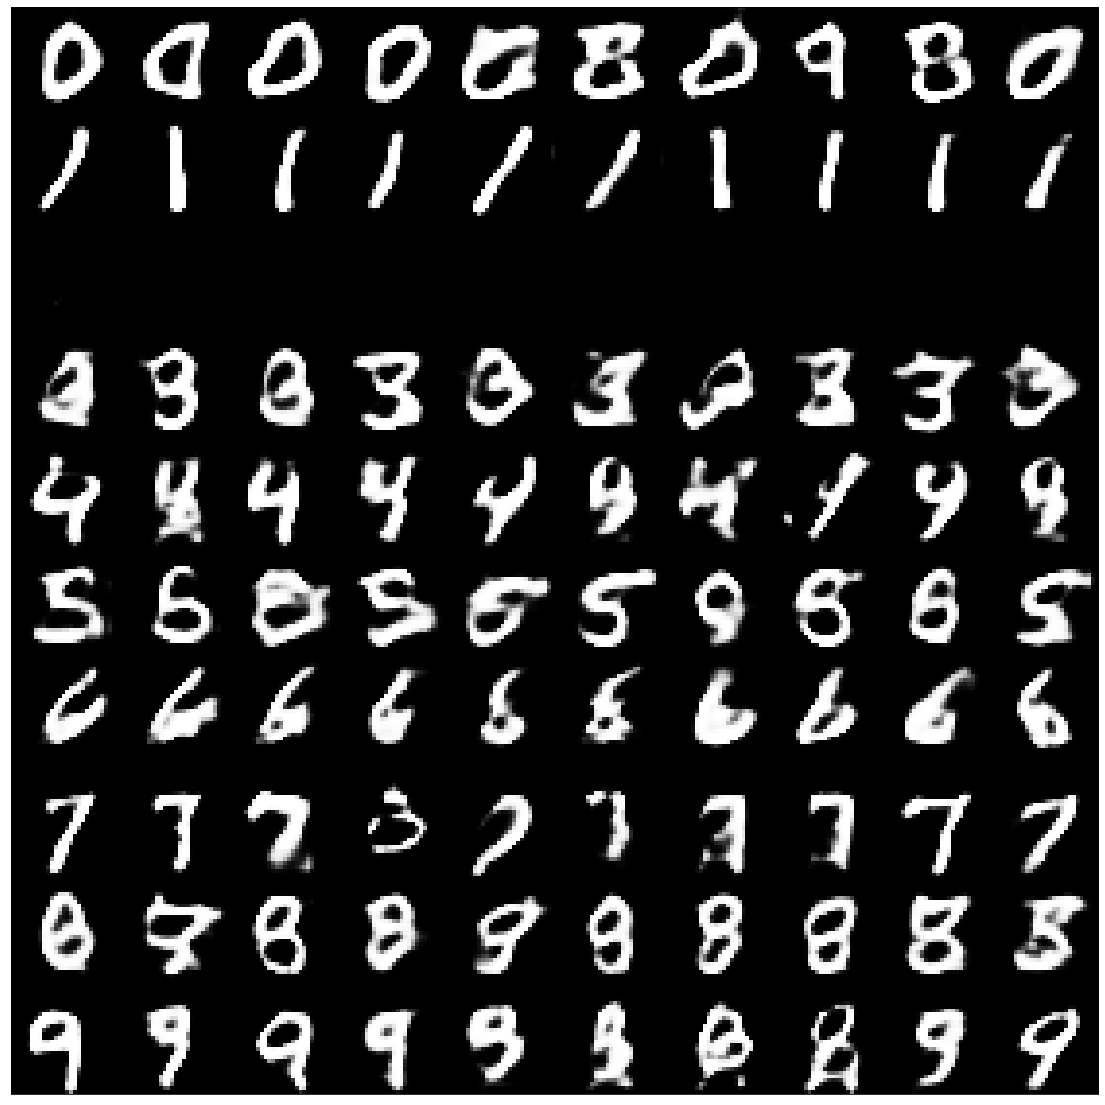

.l_d: 0.4222455620765686
.l_d: 0.49439093470573425
.l_d: 0.4407583475112915
.l_d: 0.40696778893470764
.l_d: 0.4340662956237793
.l_d: 0.45176559686660767
.l_d: 0.493993878364563
.l_d: 0.5049917101860046
.l_d: 0.407873272895813
.l_d: 0.4029046893119812
.l_d: 0.4273715615272522
.l_d: 0.41302067041397095
.l_d: 0.4576358199119568
.l_d: 0.4385116696357727
.l_d: 0.4370352029800415
.l_d: 0.4436384439468384
.l_d: 0.42625248432159424
.l_d: 0.4331846535205841
.l_d: 0.4115249216556549
.l_d: 0.42042139172554016
.l_d: 0.4018937647342682
.l_d: 0.40994134545326233
.l_d: 0.4471185505390167
.l_d: 0.42943957448005676
.l_d: 0.4556916356086731
.l_d: 0.47927141189575195
.l_d: 0.42292916774749756
.l_d: 0.402536541223526
.l_d: 0.4213467538356781
.l_d: 0.48582684993743896
.l_d: 0.419965922832489
.l_d: 0.43377140164375305
.l_d: 0.4134816825389862
.l_d: 0.45295122265815735
.l_d: 0.42903804779052734
.l_d: 0.5523954033851624
.l_d: 0.4616736173629761
.l_d: 0.44269639253616333
.l_d: 0.4664812386035919
.l_d: 0.426268

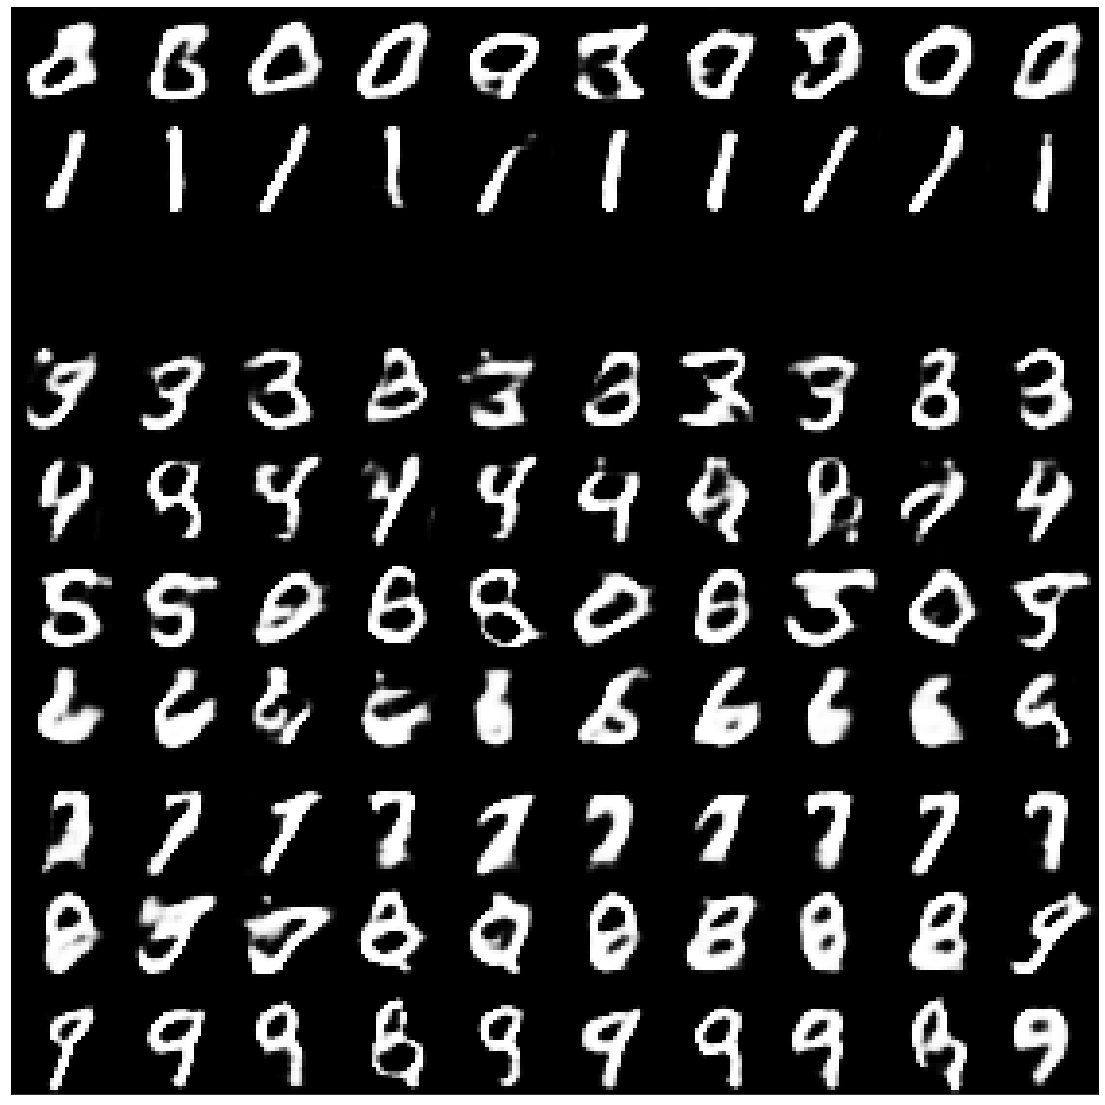

.l_d: 0.4948570132255554
.l_d: 0.4183904528617859
.l_d: 0.43106481432914734
.l_d: 0.4480074644088745
.l_d: 0.41922080516815186
.l_d: 0.4468511641025543
.l_d: 0.4600190818309784
.l_d: 0.4257560670375824
.l_d: 0.42700380086898804
.l_d: 0.4092385470867157
.l_d: 0.4339209496974945
.l_d: 0.4311069846153259
.l_d: 0.4886648654937744
.l_d: 0.509601354598999
.l_d: 0.4728134274482727
.l_d: 0.4190048575401306
.l_d: 0.4812425971031189
.l_d: 0.4445694386959076
.l_d: 0.4058191180229187
.l_d: 0.43469172716140747
.l_d: 0.4230976700782776
.l_d: 0.40634670853614807
.l_d: 0.4520271420478821
.l_d: 0.4416852593421936
.l_d: 0.4030522108078003
.l_d: 0.41401803493499756
.l_d: 0.4071125090122223
.l_d: 0.40486085414886475
.l_d: 0.4985974133014679
.l_d: 0.454609751701355
.l_d: 0.4533860683441162
.l_d: 0.45586222410202026
.l_d: 0.4262343645095825
.l_d: 0.4065701961517334
.l_d: 0.4115772247314453
.l_d: 0.40421003103256226
.l_d: 0.40267807245254517
.l_d: 0.41803741455078125
.l_d: 0.43683093786239624
.l_d: 0.4343948

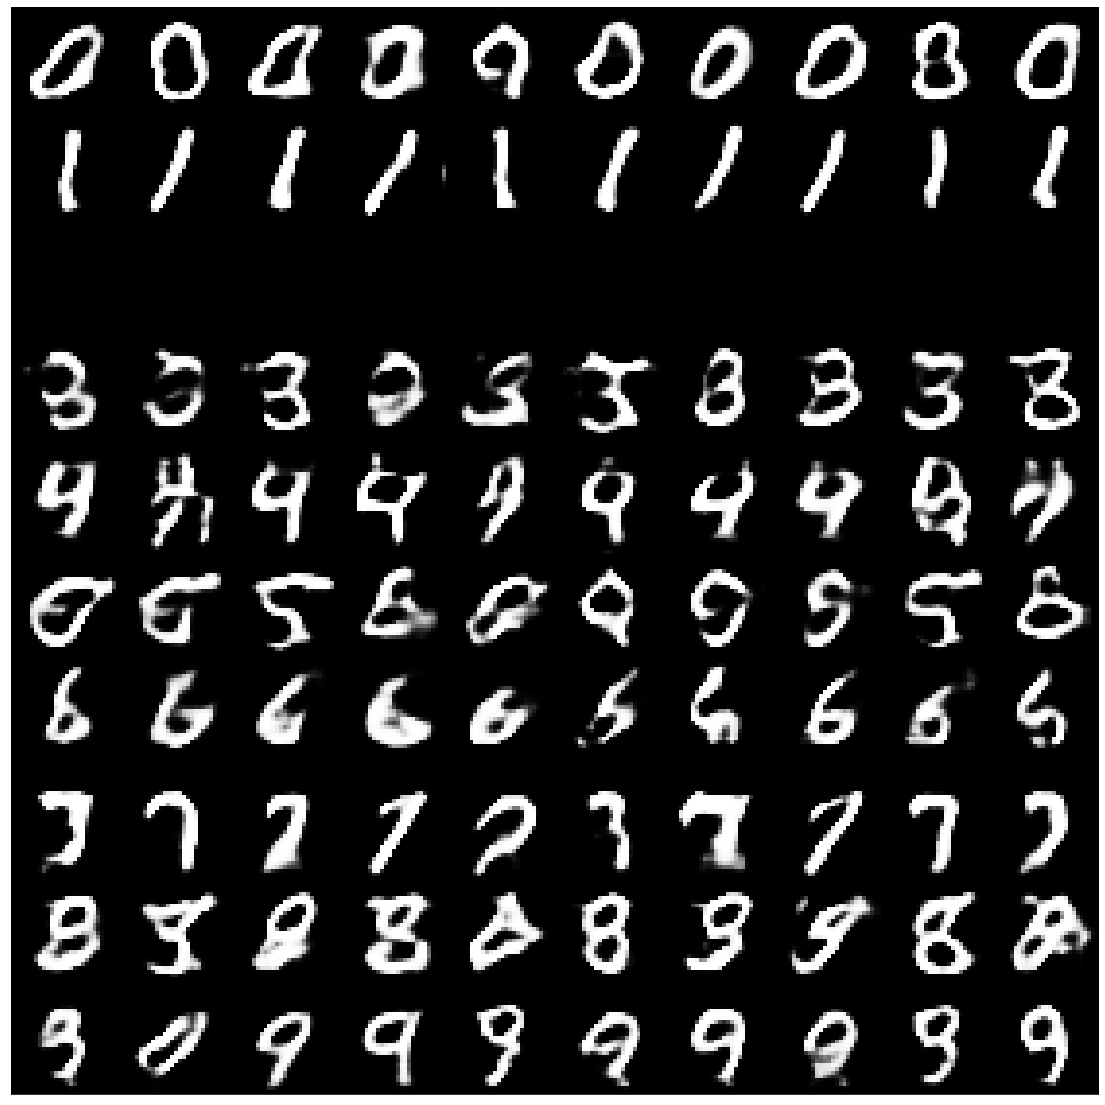

.l_d: 0.44350528717041016
.l_d: 0.4478754699230194
.l_d: 0.4450913071632385
.l_d: 0.45520439743995667
.l_d: 0.41498538851737976
.l_d: 0.4894000291824341
.l_d: 0.43291690945625305
.l_d: 0.48294684290885925
.l_d: 0.42517325282096863
.l_d: 0.4819314777851105
.l_d: 0.452437162399292
.l_d: 0.4361579120159149
.l_d: 0.4384055733680725
.l_d: 0.42068707942962646
.l_d: 0.4483684301376343
.l_d: 0.4092763066291809
.l_d: 0.4309837818145752
.l_d: 0.41884785890579224
.l_d: 0.40690362453460693
.l_d: 0.4375736117362976
.l_d: 0.3366008400917053
.l_d: 0.42460107803344727
.l_d: 0.4367265999317169
.l_d: 0.42794138193130493
.l_d: 0.40233278274536133
.l_d: 0.49001234769821167
.l_d: 0.4586080312728882
.l_d: 0.4442996382713318
.l_d: 0.4078789949417114
.l_d: 0.40460342168807983
.l_d: 0.4125528931617737
.l_d: 0.48996400833129883
.l_d: 0.4200790524482727
.l_d: 0.42726731300354004
.l_d: 0.4746157228946686
.l_d: 0.4035768508911133
.l_d: 0.4256049394607544
.l_d: 0.44775840640068054
.l_d: 0.45798754692077637
.l_d: 0.

In [28]:
k_step = 5
periods_to_train = 4000

for period in range(periods_to_train):
    print('.', end='')

    b0, b1 = next(train_batches_it)
    zp = numpy.random.randn(batch_size, latent_dim)
    for j in range(k_step):
        l_d = step_d(b0, b1, zp)
        b0, b1 = next(train_batches_it)
        zp = numpy.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

    for j in range(k_step):
        l_d = step(b0, b1, zp)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = numpy.random.randn(batch_size, latent_dim)

    print("l_d: {}".format(l_d))
    if period in periods_to_check:
        print("Period: {}".format(period))
        on_n_period()

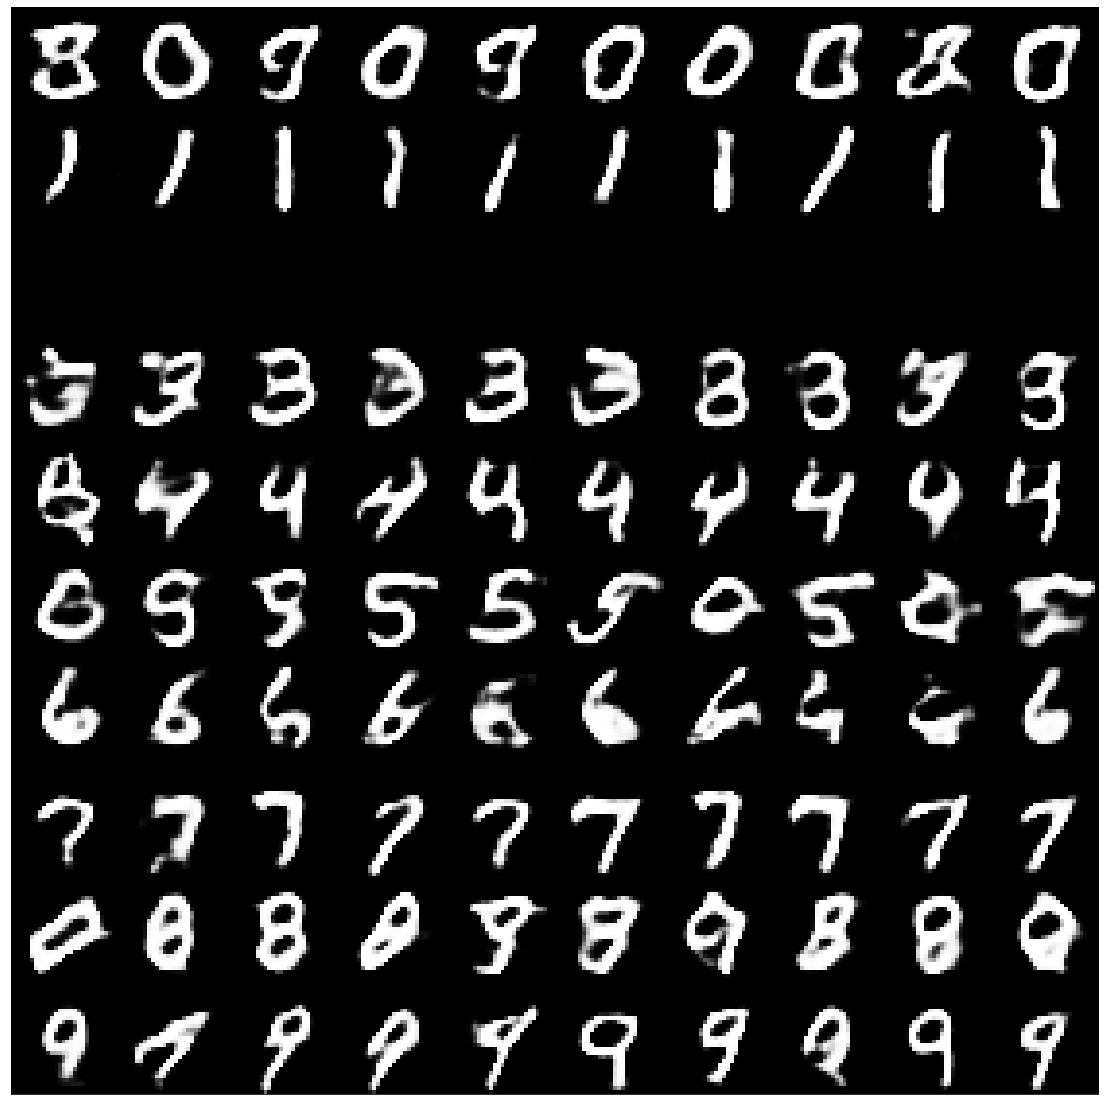

In [29]:
to_compare = []
for lbl in range(num_classes):
    codes = np.random.normal(size=(batch_size, latent_dim))
    lbls = np.zeros(shape=(batch_size, num_classes))
    lbls[:, lbl] = 1

    predicted = cvae_decoder.predict([codes, lbls], batch_size=batch_size)
    to_compare.append(predicted[:n_compare])
plot_digits(*to_compare)

# TRY EASY GAN ARCHITECTURE

In [30]:
# # After tf.global_variables_initializer() the decoder_model is null
# # We need to load weights from file
# cvae_decoder.load_weights(os.path.join(save_path, "cvae_decoder_2dim.h5"))

In [31]:
# import tensorflow as tf
# from keras.layers import Dropout, BatchNormalization, Reshape, Flatten
# from keras.layers import Dense, Input, concatenate
# from keras.layers.advanced_activations import LeakyReLU
# from keras.models import Model
# from keras.optimizers import Adam


# input_discrim_img = Input(shape=(28, 28, 1))
# flatten_discrim_img = Flatten()(input_discrim_img)
# input_lbl = Input(shape=(num_classes,), dtype='float32')

# x = concatenate([flatten_discrim_img, input_lbl])
# x = Dense(1024)(x)
# x = LeakyReLU()(x)
# x = Dropout(dropout_rate)(x)

# x = Dense(512)(x)
# x = LeakyReLU()(x)
# x = Dropout(dropout_rate)(x)

# x = Dense(256)(x)
# x = LeakyReLU()(x)
# x = Dropout(dropout_rate)(x)

# x = Dense(1, activation='sigmoid')(x)

# discriminator_model = Model([input_discrim_img, input_lbl], x, name="Discriminator")
# discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam())
# discriminator_model.summary()

In [32]:
# discriminator_model.trainable = False

# gan_input_code = Input(shape=(latent_dim,))
# gan_input_lbl = Input(shape=(num_classes,))

# fake_image = cvae_decoder([gan_input_code, gan_input_lbl])

# gan_output = discriminator_model([fake_image, gan_input_lbl])

# gan = Model([gan_input_code, gan_input_lbl], gan_output, name="GAN with decoder")
# gan.compile(loss='binary_crossentropy', optimizer=Adam())
# gan.summary()

In [33]:
# import time
# import numpy


# imgs = x_test[:batch_size]
# imgs_lbls = y_test_cat[:batch_size]
# n_compare = 10

# epochs = 200
# batch_size = 100
# steps_per_epoch = 600
# epochs_to_check = numpy.arange(0., 200.0, 10.0).astype('int')


# def gen_batch(x, y):
#     n_batches = x.shape[0] // batch_size
#     while (True):
#         idxs = np.random.permutation(y.shape[0])
#         x = x[idxs]
#         y = y[idxs]
#         for i in range(n_batches):
#             yield x[batch_size * i:batch_size * (i + 1)], y[batch_size * i:batch_size * (i + 1)]

# train_batches_it = gen_batch(x_train, y_train_cat)
# test_batches_it = gen_batch(x_test, y_test_cat)


# print(f'START TRAINING...')
# start_time = time.time()
# for epoch in range(epochs):
#     start_epoch_time = time.time()
#     for batch in range(steps_per_epoch):
#         b0, b1 = next(train_batches_it)
#         noise = numpy.random.randn(batch_size, latent_dim)

#         fake_x = cvae_decoder.predict([noise, b1])

#         x1 = numpy.concatenate((b0, fake_x))
#         x2 = numpy.concatenate((b1, b1))

#         disc_y = numpy.zeros(2 * batch_size)
#         disc_y[:batch_size] = 0.9

#         d_loss = discriminator_model.train_on_batch([x1, x2], disc_y)

#         gen_y = numpy.ones(batch_size)
#         g_loss = gan.train_on_batch([noise, b1], gen_y)

#     print(f'Epoch: %s Discriminator Loss: %s \t Generator Loss: %s \t Elapsed time for epoch: %s' % (epoch, d_loss, g_loss, time.time() - start_epoch_time))
    
#     if epoch in epochs_to_check:
#         b0, b1 = next(test_batches_it)
#         noise = numpy.random.randn(batch_size, latent_dim)

#         decoded = cvae_decoder.predict([noise, b1], batch_size=batch_size)
#         plot_digits(b0[:n_compare], decoded[:n_compare])

# print(f'\nELAPSED TIME FOR ALL TRAINING: %s' % (time.time() - start_time))